In [1]:
## A section imports:
import pandas as pd
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import requests     #required for downloading world bank data and merging with the rest of the data
sys.path.append('utilities')
import helpers as h
# from bs4 import BeautifulSoup
import random
##B-section imports: 
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,  PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor, Pool
from matplotlib.colors import LinearSegmentedColormap
## C section imports: 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# SECTION A: FILE IO + EDA

# 1: Reading files from disk into memory
start by reading the file locations from file, then load the excel file, list the sheets and load them all into variables. Next load the y_test.csv file.

In [2]:
files = h.get_file_organization(True)

Key                                          File Path                                        Explanation
0     raw_data  c:\Python projects\regression task\evaluatie-2...  Training dataset in Excel format as downloaded...
1   y_testdata  c:\Python projects\regression task\evaluatie-2...  Training testdata as downloaded from mail in C...
2  downloaddir  c:\Python projects\regression task\evaluatie-2...  Where to store downloaded files from World Ban...
3   outputfile  c:\Python projects\regression task\evaluatie-2...  Where to store the output file (write permissi...

In [3]:
excel_file = pd.ExcelFile(files['raw_data'])
X_train, X_test, y_train = [pd.read_excel(files['raw_data'], sheet_name= sheet) for sheet in excel_file.sheet_names]
y_test = pd.read_csv(files['y_testdata'])
excel_file.close()
assert(len(X_train) == len(y_train))

# 2: EDA - what data/columns do we have?

In [4]:
X_train.head(5)

work_year experience_level employment_type                  job_title employee_residence work_setting company_location company_size
0       2023        Mid-level       Full-time  Machine Learning Engineer      United States    In-person    United States            M
1       2023        Mid-level       Full-time             Data Scientist      United States    In-person    United States            M
2       2024           Senior       Full-time             Data Scientist     United Kingdom    In-person   United Kingdom            M
3       2024           Senior       Full-time             Data Scientist      United States       Remote    United States            M
4       2024           Senior       Full-time             Data Scientist     United Kingdom       Remote   United Kingdom            M

In [5]:
y_train.head(5)

salary_in_eur
0      188140.00
1      155480.00
2       36800.00
3       88113.92
4       59800.00

## 2.1 single df: 
We want to have a single df with y_train as the target column for easier plotting in our EDA phase. Don't forget all manipulations we do on df and copies, need to be applied to X_test too!!

In [6]:
df = X_train.copy()
df['target'] = y_train

In [7]:
df.head(5)

work_year experience_level employment_type                  job_title employee_residence work_setting company_location company_size     target
0       2023        Mid-level       Full-time  Machine Learning Engineer      United States    In-person    United States            M  188140.00
1       2023        Mid-level       Full-time             Data Scientist      United States    In-person    United States            M  155480.00
2       2024           Senior       Full-time             Data Scientist     United Kingdom    In-person   United Kingdom            M   36800.00
3       2024           Senior       Full-time             Data Scientist      United States       Remote    United States            M   88113.92
4       2024           Senior       Full-time             Data Scientist     United Kingdom       Remote   United Kingdom            M   59800.00

## 2.2 Column inspection:
What is the range of values we're working with - at a first glance there seem to be quite some columns that might be suitable for ordinal encoding (e.g. company_size or experience_level). But for it to work properly we need to have clearly distinguished values in these columns. (e.g. S,M,L and not S,M,L, 100-1000, 1000-2500 for company_size)

In [8]:
df.nunique()
# we see that there is potential to use ordinal encoding for experience_level and company_size. We might consider employment_type and work_setting too if we can find a meaningful hierarchy there.

work_year                5
experience_level         4
employment_type          4
job_title              145
employee_residence      84
work_setting             3
company_location        73
company_size             3
target                2115
dtype: int64

In [9]:
#print the unique values for all columns with less than 6 unique values (assess feasability of ordinal encoding)
for column in df.columns:
    if df[column].nunique() < 6:
        print(column, '\t', df[column].unique())

work_year 	 [2023 2024 2022 2020 2021]
experience_level 	 ['Mid-level' 'Senior' 'Entry-level' 'Executive']
employment_type 	 ['Full-time' 'Freelance' 'Contract' 'Part-time']
work_setting 	 ['In-person' 'Remote' 'Hybrid']
company_size 	 ['M' 'L' 'S']


I'm comfortable calling **experience_level** and **company_size** ordinal values and using ordinal encoding on them. There's a clear hierarchy in the unique values printed for these columns. 
I'm less convinced that **employment_type** and **work_setting** shoudl be treated in a similar way. 
- consider *Contract*: is that a full-time or part-time contract? 
- consider *Part-time*: what's the percentage? 
- consider *Hybrid*: What's the ratio between remote and in-person?

At this point we're curious as to why there's so many **company_location**, **job_title** and **employee_residence** values. 
- to be considered: are there **company_locations** that are hyperspecific (e.g. U.S. vs U.S. - Texas)?
- to be considered: are there **job_titles** that are synonyms (e.g. Lead Dev vs Lead developer) or similar (e.g. Docker vs Kubernetes)?


Before we delve in further; check for duplicates: 

In [10]:
#Now what about possible duplicates?
print(f" There are {len(df)} rows, of which { df.duplicated().sum()} could be duplicates")


 There are 12779 rows, of which 4776 could be duplicates


What about NAN values?: 

In [11]:
#NAN inspection:
print(df.isnull().sum())    #COOL, no nans. 

work_year             0
experience_level      0
employment_type       0
job_title             0
employee_residence    0
work_setting          0
company_location      0
company_size          0
target                0
dtype: int64


so, we're in a pickle about 1/3 of the entries are 'duplicates'; the question is - are these duplicate values really duplicates or are they two different people? I'm going to make the executive decision to leave these 'duplicates' in. It is not unreasonable to imagine that a lot of mid-level jobs occur more than once for a similar pay. 

Having established that: 
1) We have duplicates
2) We assume these duplicates are not duplicates (i.e. they are two different people)
3) There are no missing values (still in the pipelines set it up as if there might be missing data in your X_test by not dropping for OHE and use sentinel values for ORD)

Now let's look at the 'large' columns with lots of variety in them: 

In [12]:
print(h.get_alphabetically(df, 'company_location'))
#no, there's no hyperspecificity in countries - but if we use one-hot encoding, we should make it easy for ourselves change the name of some countries
#   - remove ü
#   - all to lowercase
#   - remove spaces
#   - get rid of comma's 

['Algeria' 'American Samoa' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Bahamas' 'Belgium' 'Bosnia and Herzegovina' 'Brazil' 'Canada'
 'Central African Republic' 'China' 'Colombia' 'Croatia' 'Czechia'
 'Denmark' 'Ecuador' 'Egypt' 'Estonia' 'Finland' 'France' 'Germany'
 'Ghana' 'Gibraltar' 'Greece' 'Honduras' 'Hungary' 'India' 'Indonesia'
 'Iran, Islamic Republic of' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Kenya' 'Korea, Republic of' 'Latvia' 'Lebanon' 'Lithuania' 'Luxembourg'
 'Malaysia' 'Malta' 'Mauritius' 'Mexico' 'Moldova, Republic of'
 'Netherlands' 'New Zealand' 'Nigeria' 'Oman' 'Pakistan' 'Philippines'
 'Poland' 'Portugal' 'Puerto Rico' 'Qatar' 'Romania' 'Russian Federation'
 'Saudi Arabia' 'Singapore' 'Slovenia' 'South Africa' 'Spain' 'Sweden'
 'Switzerland' 'Thailand' 'Türkiye' 'Ukraine' 'United Arab Emirates'
 'United Kingdom' 'United States' 'Viet Nam']


In [13]:
jobs = h.get_alphabetically(df, 'job_title')
print(jobs, len(jobs))
#Hooray we've opened medusa's box and we found a pile of shit: 
#    'ML Ops Engineer' 'MLOps Engineer' ==> SAME THING
#   there's a bunch of titles that I don't even know what the bloody hell they do - and I'd consider it a miracle of the peeople involved know.

['AI Architect' 'AI Developer' 'AI Engineer' 'AI Product Manager'
 'AI Programmer' 'AI Research Engineer' 'AI Research Scientist'
 'AI Scientist' 'AI Software Engineer' 'Admin & Data Analyst'
 'Analytics Engineer' 'Analytics Engineering Manager'
 'Applied Data Scientist' 'Applied Machine Learning Engineer'
 'Applied Machine Learning Scientist' 'Applied Scientist'
 'Autonomous Vehicle Technician' 'Azure Data Engineer' 'BI Analyst'
 'BI Data Analyst' 'BI Developer' 'Big Data Architect'
 'Big Data Developer' 'Big Data Engineer' 'Business Data Analyst'
 'Business Intelligence' 'Business Intelligence Analyst'
 'Business Intelligence Data Analyst' 'Business Intelligence Developer'
 'Business Intelligence Engineer' 'Business Intelligence Lead'
 'Business Intelligence Manager' 'Business Intelligence Specialist'
 'Cloud Data Architect' 'Cloud Data Engineer' 'Cloud Database Engineer'
 'Compliance Data Analyst' 'Computational Biologist'
 'Computer Vision Engineer' 'Computer Vision Software Engine

In [14]:
print(h.get_alphabetically(df, 'employee_residence'))

['Algeria' 'American Samoa' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Belgium' 'Bolivia, Plurinational State of' 'Bosnia and Herzegovina'
 'Brazil' 'Bulgaria' 'Canada' 'Central African Republic' 'Chile' 'China'
 'Colombia' 'Costa Rica' 'Croatia' 'Cyprus' 'Czechia' 'Denmark'
 'Dominican Republic' 'Ecuador' 'Egypt' 'Estonia' 'Finland' 'France'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Honduras' 'Hong Kong' 'India'
 'Indonesia' 'Iran, Islamic Republic of' 'Iraq' 'Ireland' 'Italy' 'Japan'
 'Jersey' 'Kenya' 'Korea, Republic of' 'Kuwait' 'Latvia' 'Lebanon'
 'Lithuania' 'Luxembourg' 'Malaysia' 'Malta' 'Mauritius' 'Mexico'
 'Moldova, Republic of' 'Netherlands' 'New Zealand' 'Nigeria' 'Oman'
 'Pakistan' 'Peru' 'Philippines' 'Poland' 'Portugal' 'Puerto Rico' 'Qatar'
 'Romania' 'Russian Federation' 'Saudi Arabia' 'Serbia' 'Singapore'
 'Slovenia' 'South Africa' 'Spain' 'Sweden' 'Switzerland' 'Thailand'
 'Tunisia' 'Türkiye' 'Uganda' 'Ukraine' 'United Arab Emirates'
 'United Kingdom' 'United States

- Geographical information is quite clean, don't see a lot of problems there other than the variety of the data - in EDA check if each country is more or less representative in there or not. 
- Job title information is a mess - helper function required to clean it up: we'll be splitting the job_title field in two: field and title. A good example where this makes sense: 'Data Analytics Consultant' 'Data Analytics Engineer'
 'Data Analytics Lead' 'Data Analytics Manager'. Ideally you let this do by someone who is familiar with the job titles.


# 3 data preprocessing: 
we'll add some features that might be interesting to use further down the line.
rationalize the job_title - there are typos, synonyms in there. It should also be split in field/domain and title. 
clean up names of countries if used in OHE later. 

In [15]:
#We saw there are more values for employee_residence then there are for company_location. 
# A question we might try to explore: are foreign employees payed less?


df_processed = h.is_employee_of_country(df)
#now: do the same for X_test you read from the excel file: 
X_test_processed = h.is_employee_of_country(X_test)

In [16]:
#For jobs we saw that there's some redundancy: same jobs - different spelling. 
# let's address this quickly with the extractor utility.
df_processed[['field', 'title']] = df_processed['job_title'].apply(h.extractor).apply(pd.Series)
#tehre's probably more to do here, but this is a good enough start.
#now: do the same for X_test you read from the excel file: 
X_test_processed[['field', 'title']] = X_test_processed['job_title'].apply(h.extractor).apply(pd.Series)


In [17]:
#Same for country data in employee_residence and company_location
cleanup_countries = {
    'republic of': '', 
    'ü': 'u',
    ',': '',
    ' ': '_'
    }
df_processed = h.cleanup_strings(df_processed, 'employee_residence', cleanup_countries)
df_processed = h.cleanup_strings(df_processed, 'company_location', cleanup_countries)
#now: do the same for X_test you read from the excel file: 
X_test_processed = h.cleanup_strings(X_test_processed, 'employee_residence', cleanup_countries)
X_test_processed = h.cleanup_strings(X_test_processed, 'company_location', cleanup_countries)

# 4: EDA - visualisations

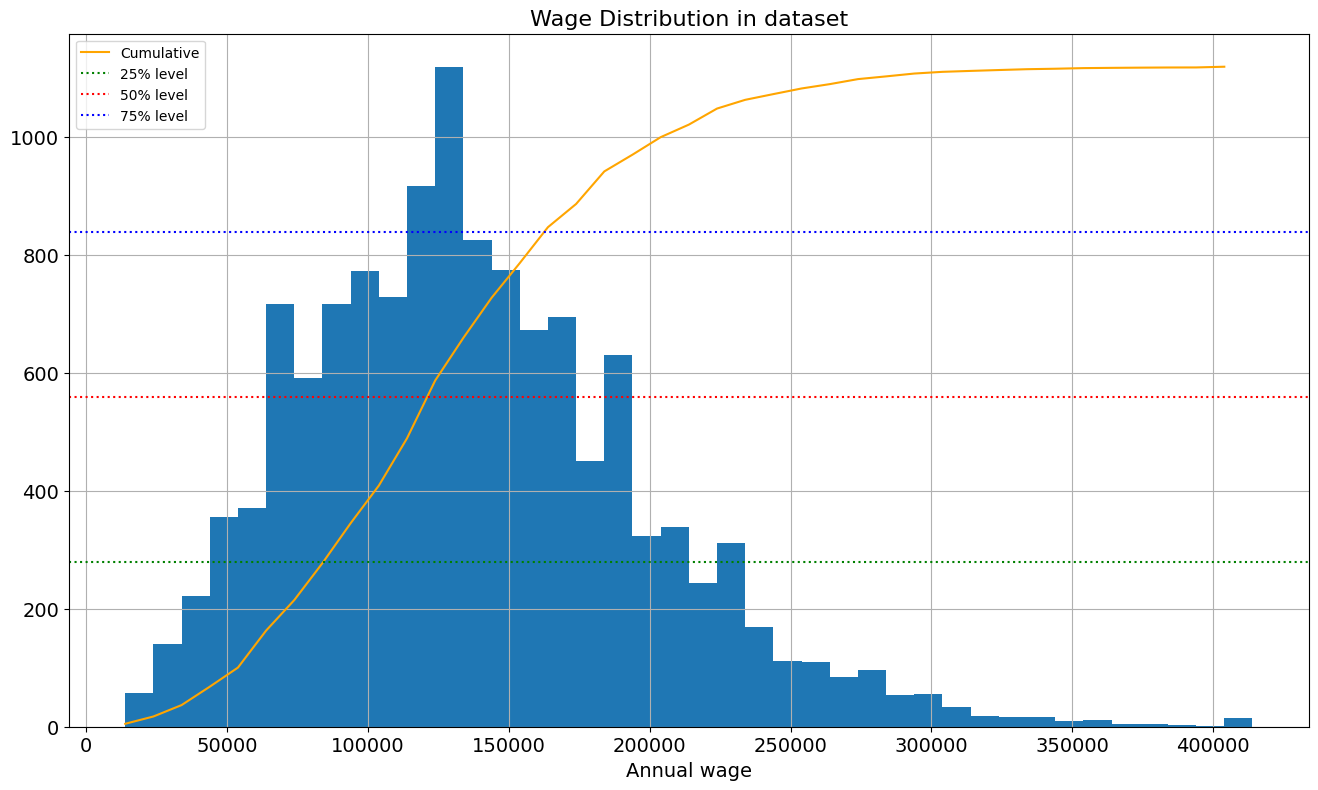

In [18]:
bins = 40
df_processed.target.hist(bins=bins)
plt.title('Wage Distribution in dataset')
plt.xlabel('Annual wage')
bin_values, bin_edges = np.histogram(df_processed.target, bins=bins)
cumulative = np.cumsum(bin_values)
# Normalize cumulative to match histogram scale
cumulative_normalized = cumulative / cumulative.max() * bin_values.max()
# Plot the cumulative line
plt.plot(bin_edges[:-1], cumulative_normalized, color='orange', label='Cumulative')
percentiles = [0.25, 0.50, 0.75]
colors = ['green', 'red', 'blue']
for p, color in zip(percentiles, colors):
    y_value = p * bin_values.max()
    plt.axhline(y=y_value, color=color, linestyle='dotted', label=f'{int(p*100)}% level')
#Add legend
plt.legend()

Wage is leaning slightly to the left - with 50% of the population earning about 120000 per year. There is a tail to the right, with few people belonging to a high-income category, but the tail is not that heavy. I would not consider normalization a necessity here. 

## 4.1. Do foreign employees earn less?

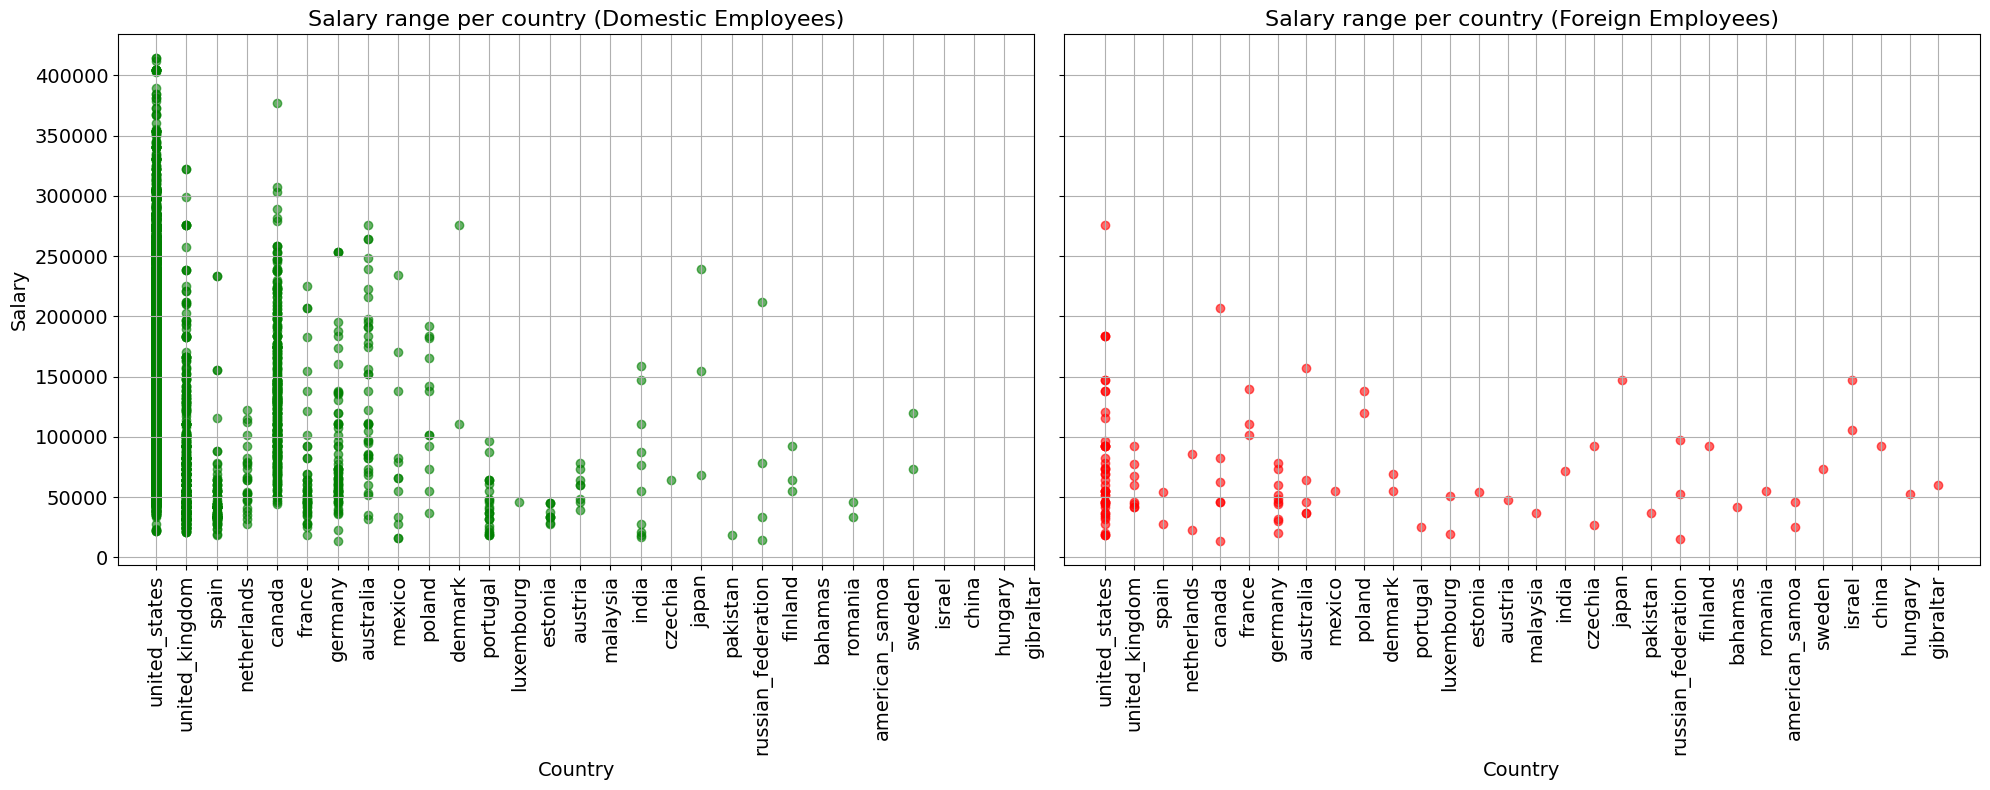

In [19]:
# Filter the data
countries_with_false = df_processed[df_processed['employee_of_country'] == False]['company_location'].unique()
df_filtered = df_processed[df_processed['company_location'].isin(countries_with_false)]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot for green dots (employee_of_country == True)
for i, country in enumerate(df_filtered['company_location'].unique()):
    country_data = df_filtered[(df_filtered['company_location'] == country) & (df_filtered['employee_of_country'] == True)]
    ax1.scatter([i] * len(country_data), country_data['target'], color='green', alpha=0.6)

# Plot for red dots (employee_of_country == False)
for i, country in enumerate(df_filtered['company_location'].unique()):
    country_data = df_filtered[(df_filtered['company_location'] == country) & (df_filtered['employee_of_country'] == False)]
    ax2.scatter([i] * len(country_data), country_data['target'], color='red', alpha=0.6)

# Customize the plots
ax1.set_title('Salary range per country (Domestic Employees)')
ax1.set_xlabel('Country')
ax1.set_ylabel('Salary')
ax1.set_xticks(range(len(df_filtered['company_location'].unique())))
ax1.set_xticklabels(df_filtered['company_location'].unique(), rotation=90)
ax1.grid(True)

ax2.set_title('Salary range per country (Foreign Employees)')
ax2.set_xlabel('Country')
ax2.set_xticks(range(len(df_filtered['company_location'].unique())))
ax2.set_xticklabels(df_filtered['company_location'].unique(), rotation=90)
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

This scatterplot does suggest so, but it's easier to compare country side by side.
A violinplot would be nice, but it does funky things, boxplot does not show distribution as detailed as a boxenplot does, so we go for the latter. 

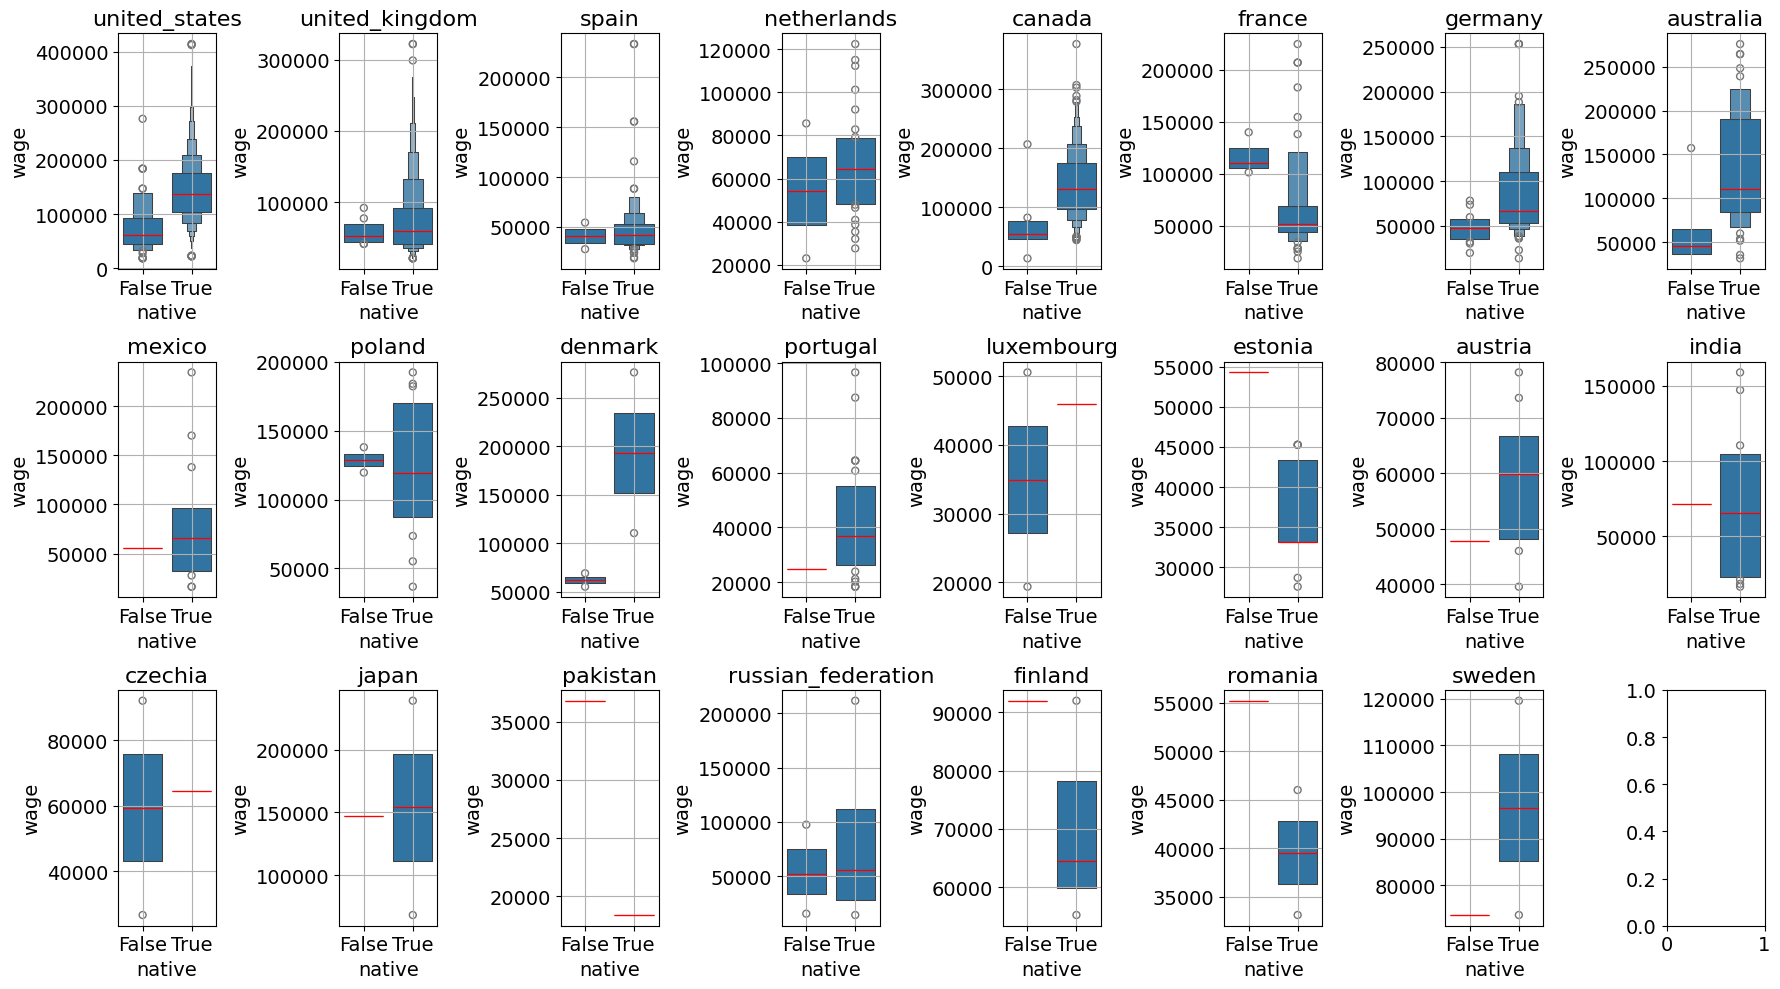

In [20]:
#Share Y-axis in boxplots: (1 or 0)
y_setting = 0       #zero = autoscale per subplot, 1 = shared y axis. 
plottype = 'boxen'  #box or boxen
##########

# Filter the data based on employee_of_country; the country should have both true and false to be interesting in this plot;
countries_with_false = df_processed[df_processed['employee_of_country'] == False]['company_location'].unique()      #filter1
countries_with_true = df_processed[df_processed['employee_of_country'] == True]['company_location'].unique()        #filter2
relevant_countries = list(set(countries_with_false) & set(countries_with_true))                                     #keep mutual items
df_filtered = df_processed[df_processed['company_location'].isin(relevant_countries)]                               #apply mutuality filter

# Get the unique countries
unique_countries = df_filtered['company_location'].unique()

# Create the figure and subplots
y_axis_setting = 'all' if y_setting == 1 else None                      #autoscale option at top of cell
fig, axes = plt.subplots(3, 8, figsize=(18, 10), sharey=y_setting)     #there are 30 countries that have foreign employees, 23 that have both this is what I'm interested in here, so 3by10
axes = axes.flatten()

# Plot for each country
for i, country in enumerate(unique_countries):
    ax = axes[i]
    country_data = df_filtered[df_filtered['company_location'] == country]
    # Create boxplot with values for country == country_data
    if plottype == 'boxen':
        sns.boxenplot(x='employee_of_country', y='target', data=country_data, ax=ax, legend=False, line_kws={'color': 'red'})
    else:
        sns.boxplot(x='employee_of_country', y='target', data=country_data, ax=ax, legend=False)
    ax.set_title(country)
    ax.set_xlabel('native')
    ax.set_ylabel('wage')

    ax.grid(True)

plt.tight_layout()


Some countries are more paritar than others. For example: Denmark has a very high unequality, whereas Spain has a very similar boxenplot (bar the outliers). This could be due to different job functions being filled out in different countries, at this stage of the EDA, we should put a pin in that idea and go to check the numerical distribution of jobs per country/function using barcharts and grids. If the grid shows us the ratios are similar between countries, then we can create more detailed boxenplots for Spain vs Denmark vs United States vs Japan... and a few others to see if certain job titles are not reachable for non-native employees. If the numbers are too low, then we have to conclude that there's not enough samples to make a statement about this. 

When rendering the graph with a shared y-axis (``y_setting==1``) you notice the inequality between countries quite well. There seem to be different payment standards per country - but this could be due to other variables. When setting the `y_setting == 0`, the above graph maximizes the differences inside a country. 

## 4.2. What's the distribution of jobs per country: (barchart)

Text(0.5, 1.0, 'Number of job entries per country')

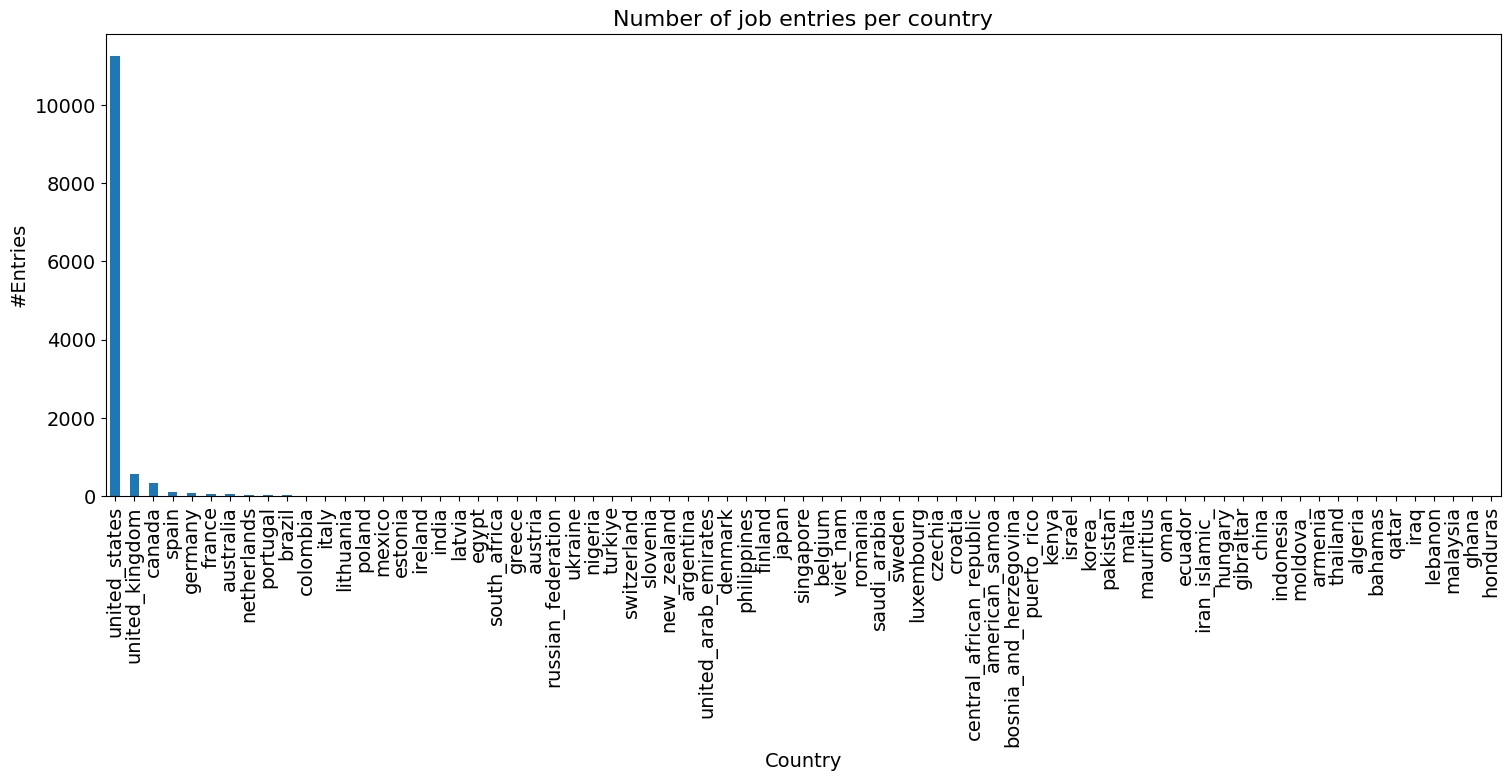

In [21]:
country_counts = df_processed['company_location'].value_counts()
plt.figure(figsize=(18, 6))
country_counts.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('#Entries')
plt.title('Number of job entries per country')


So the listings in the US are throwing off a lot, we need to keep this in mind as we continue making other visualizations. You could consider LOG visualizations, but they are not intuitive enough. In stead split it up: US vs the rest (one plot), the rest (detailled plot). This already circles back to the previous boxenplots made, we see that Denmark is not really representative - so investigating the titles is probably not worth it due to too little samples.

I'm reluctant to reduce the country feature to a binary statement: USA vs not-USA. We saw in the boxenplot just how much variety there is in payment standards between countries (i.e. Poland vs Portugal) - again, other variables could be having an impact here. 

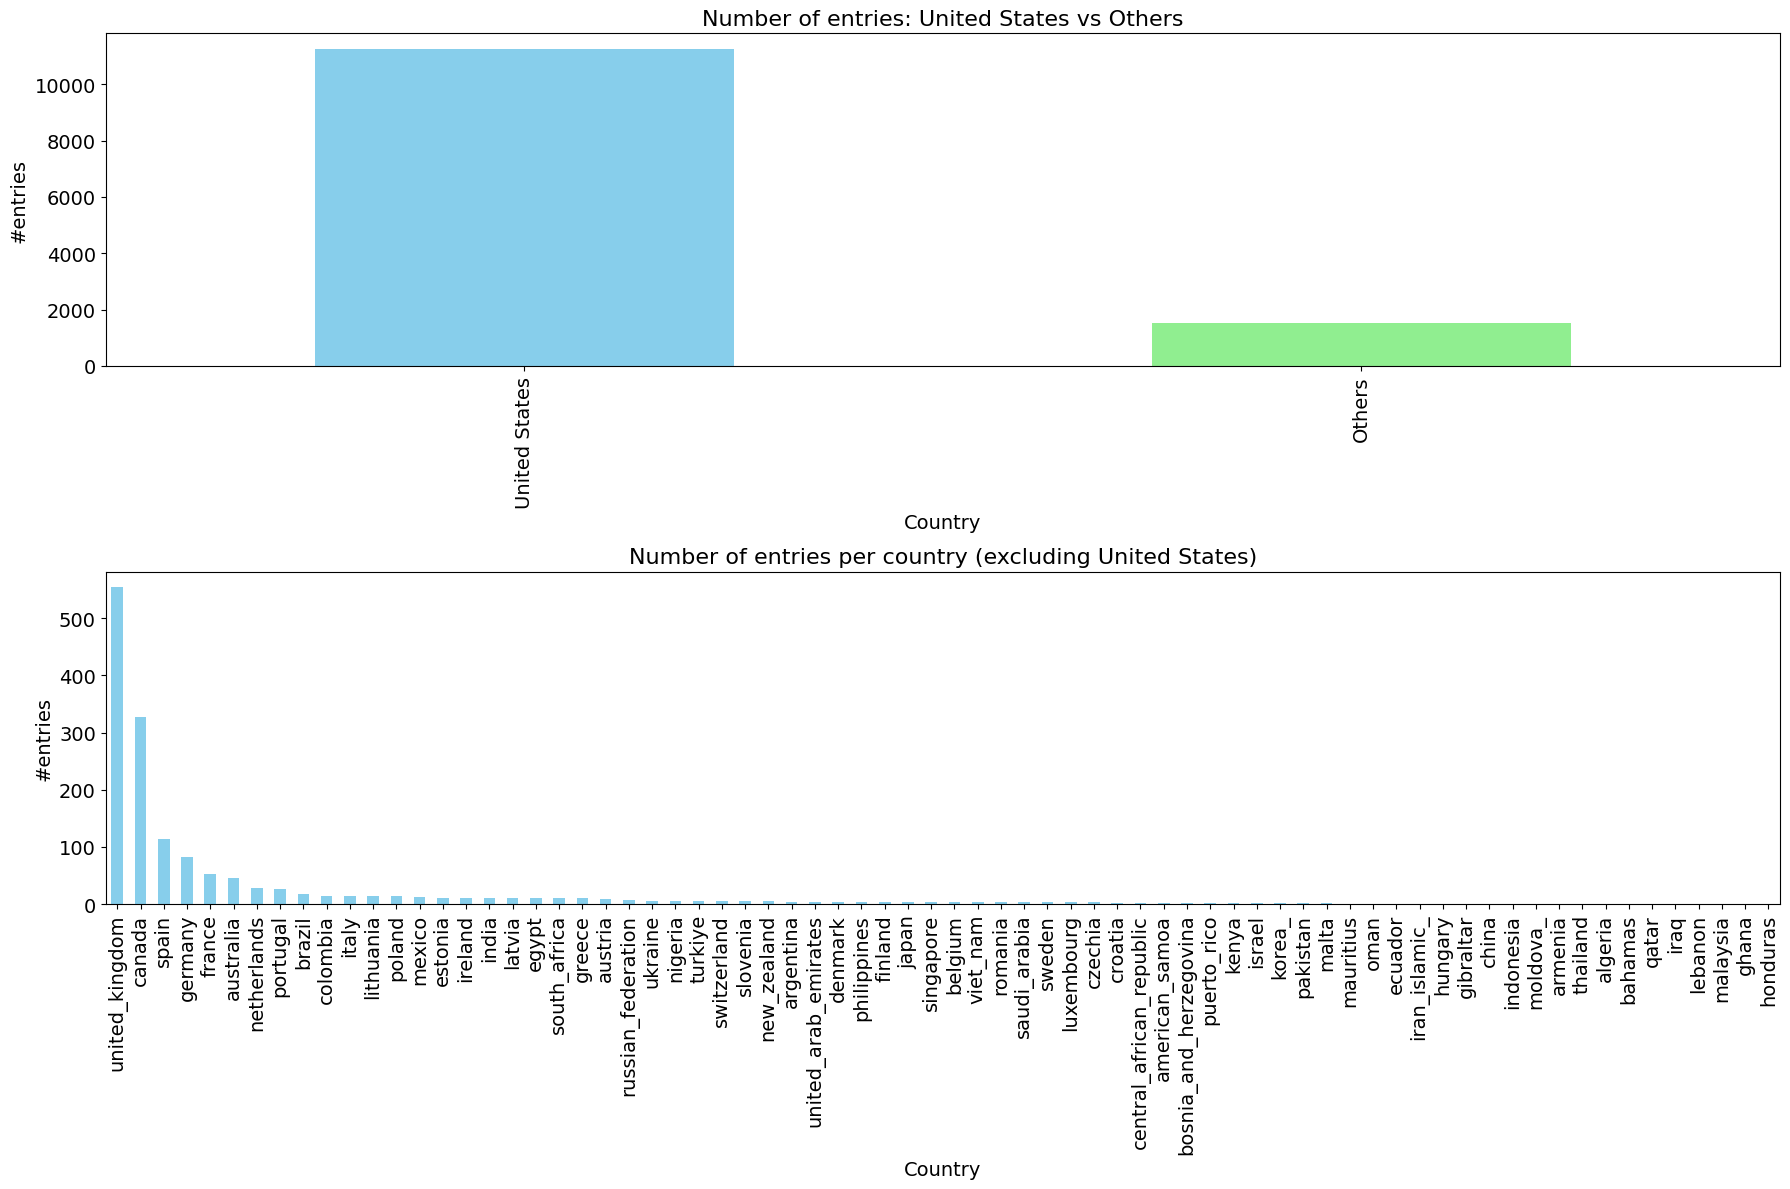

In [22]:
us_count = country_counts.get('united_states', 0)
other_counts = country_counts.drop('united_states').sum()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
first_plot_data = pd.Series({'United States': us_count, 'Others': other_counts})
first_plot_data.plot(kind='bar', color=['skyblue', 'lightgreen'], ax=ax1)
ax1.set_xlabel('Country')
ax1.set_ylabel('#entries')
ax1.set_title('Number of entries: United States vs Others')
other_country_counts = country_counts.drop('united_states')
other_country_counts.plot(kind='bar', color='skyblue', ax=ax2)
ax2.set_xlabel('Country')
ax2.set_ylabel('#entries')
ax2.set_title('Number of entries per country (excluding United States)')
plt.tight_layout()

even after combining all the data of non-us countries, we see that the dataset still heavily favours the United States. 

In [23]:
df_processed.loc[df_processed['company_location'] == 'honduras']  #and then still we see that some countries only have a single entry

work_year experience_level employment_type             job_title employee_residence work_setting company_location company_size   target  employee_of_country    field         title
12551       2020        Mid-level       Full-time  Product Data Analyst           honduras    In-person         honduras            S  18400.0                 True  Product  Data Analyst

In [24]:
#while we're at it, let's check for poland vs portugal as we noticed a large dived in the boxenplots: 
inspection_df = df_processed.loc[df_processed['company_location'].isin(['poland', 'portugal'])]
most_frequent_job_title = inspection_df['job_title'].mode()[0]
inspection_df.loc[inspection_df['job_title'] == most_frequent_job_title].sort_values(by='work_year')



work_year experience_level employment_type      job_title employee_residence work_setting company_location company_size    target  employee_of_country field     title
12461       2021        Mid-level       Full-time  Data Engineer             poland       Remote           poland            L  101200.0                 True  Data  Engineer
2602        2022           Senior       Full-time  Data Engineer           portugal    In-person         portugal            M   36800.0                 True  Data  Engineer
6860        2022           Senior       Full-time  Data Engineer           portugal    In-person         portugal            M   32200.0                 True  Data  Engineer
6883        2022           Senior       Full-time  Data Engineer           portugal    In-person         portugal            M   64400.0                 True  Data  Engineer
5866        2023        Mid-level       Full-time  Data Engineer               peru       Remote         portugal            S   24840.0                False  Data  Engineer
6121        2023        Mid-level       Full-time  Data Engineer             poland       Remote           poland            L   36800.0                 True  Data  Engineer
7402        2023           Senior       Full-time  Data Engineer           portugal    In-person         portugal            M   32200.0                 True  Data  Engineer
10597       2023           Senior       Full-time  Data Engineer             poland       Remote           poland            L  184000.0                 True  Data  Engineer
10828       2024           Senior       Full-time  Data Engineer             poland       Remote           poland            M   92000.0                 True  Data  Engineer
11722       2024           Senior       Full-time  Data Engineer             poland       Remote           poland            M   55200.0                 True  Data  Engineer

So for a same job over two countries we see a high variablity in the target variable. The only foreign employee earns the least, but it's also the only employee working at a S(mall) scale company.

## 4.3. What's the amount of values we have per country/field and country/title?
For this visualization we'll make a kind of heatmap with x-y axis. Color intensity is the amount of rows at the xy-intersect.
- We're going to hide 0 values using a mask to not overload it visually with a bund of zeros; 
- Also dump the US out of this visualization, it overwhelms the rest so much that the small variations between other countries get lost. 

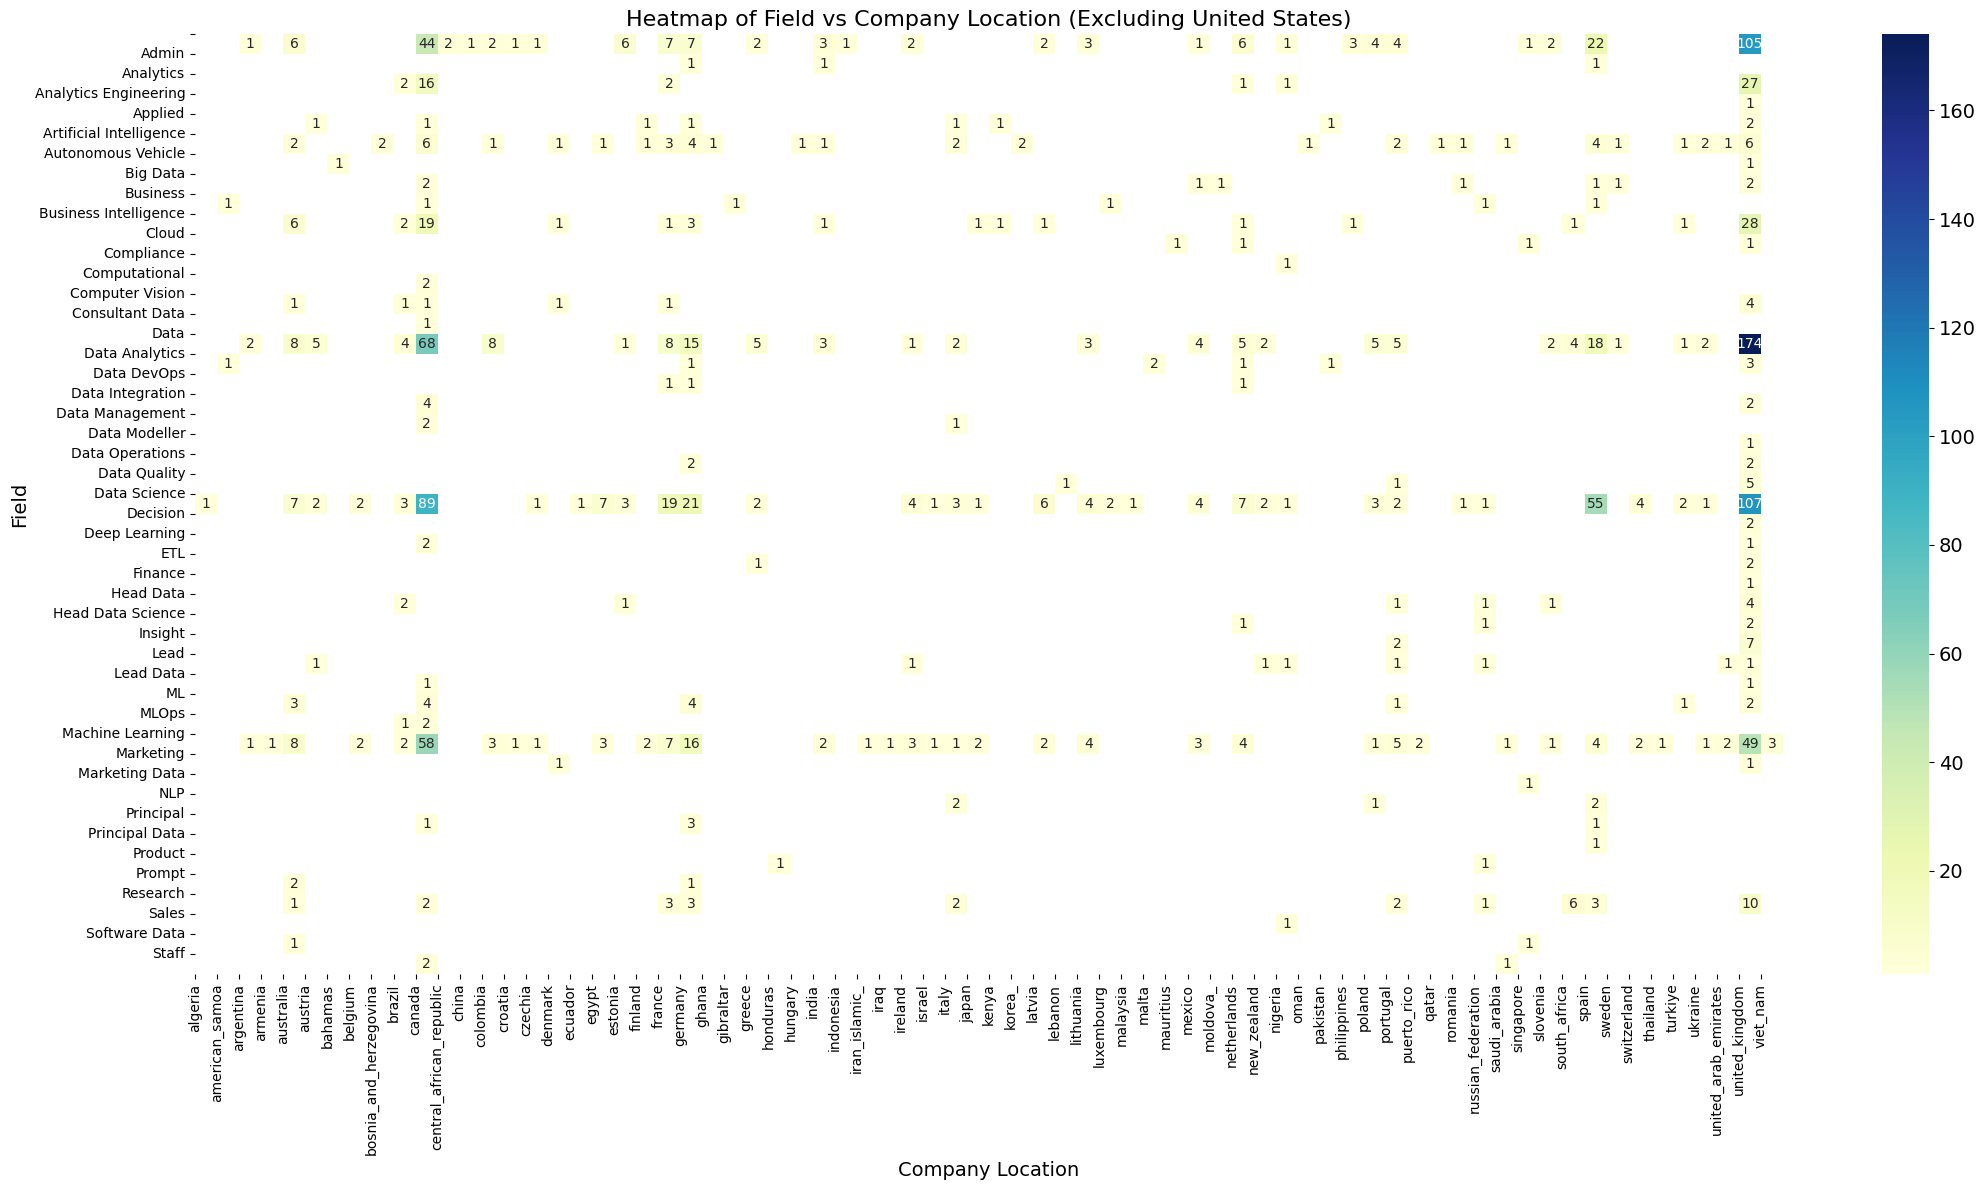

In [25]:
# Create a pivot table
pivot_table = df_processed.loc[df_processed['company_location'] != 'united_states'].pivot_table(index='field', columns='company_location', aggfunc='size', fill_value=0)
#hide zeros: 
mask = pivot_table == 0
# Create the heatmap
plt.figure(figsize=(22, 12))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", mask = mask)

# Set the labels
plt.xlabel('Company Location')
plt.ylabel('Field')
plt.title('Heatmap of Field vs Company Location (Excluding United States)')

#force label visibility for field - country matrix!!
plt.xticks(ticks=range(len(pivot_table.columns)), labels=pivot_table.columns, fontsize=10)
plt.yticks(ticks=range(len(pivot_table.index)), labels=pivot_table.index, fontsize=10)


# Show the plot
plt.tight_layout()

We look back at Denmark and see there are only four fields that have a listing: Marketing, Computer Vision, Business Intelligence, AI. All four of these fields hold only one listing - The pay discrepancy seen in the boxenplots might just be explained by the overall low number of listings in various fields. Because of this we will not further investigate wage inequality as the low number of listings makes it difficult to make meaningful statements. 

# 5 Grouping countries
We want to group countries into categories, there are a few ways to do this: 
1) Group based on geography (e.g. Europe, Asia, Africa, etc.): We have to ask ourselves "does this make sense for the wage?" i.e. is the wage tied to the geography of the country? If yes, then we can group by geography. If not, then we should look for another measure. We can use some common sense here: Mexico and Canada neighbour the US. However we see extremely divergent wages. (Boxenplot). So No, we're not going to group based on geography. 
2) GDP: We can group countries by GDP. This is a good measure because it is a good proxy for the wealth of a country (and the cost of living). We need to combine data from another source to make this work (World Bank or something). However, GDP or GDP per capita is a number - not a group so we still need to group them together based on some kind of clustering
3) World Bank Income Classification: this reduces the country dataset to easier to handle categories: Low, Lower-middle, Upper-middle, High-income countries. This is interesting for a few reasons: 
    - prevents feature inflation and long compute times. 
    - World Bank did studies on this and we can use their results. Better than winging it ourselves with the risk of making mistakes. (besides, with this dataset we only have income dat for IT jobs, this does not allow us direclty to make a statement for the overall income streams in a country)

To pull of the latter we need requests and need to download the data from the world bank: 

* WB Blogpost: https://blogs.worldbank.org/en/opendata/world-bank-country-classifications-by-income-level-for-2024-2025 
* downloadable dataset: https://databankfiles.worldbank.org/public/ddpext_download/site-content/OGHIST.xls 

We'll also need to do some kind of fuzzy matching (rapidfuzz, Levenshtein distance,....) When using this kind of fuzzy matching keep in mind to reduce some errors by preprocessing all countries in the same way!


I ended up going route 3; was clustered extremely in favor of high-income countries. So I ended up adding GDP per capita as well from the WB as they had historical data for other years. 
* downloadable dataset: https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.CD?downloadformat=excel

This process needs to be performed for ``X_test_processed`` too!



## 5.1. Downloading and processing World Bank data

In [26]:
dataset_url = 'https://databankfiles.worldbank.org/public/ddpext_download/site-content/OGHIST.xls'
r = requests.get(dataset_url)
dest = os.path.join(files['downloaddir'], 'OGHIST.xls')
with open(dest, "wb") as f:
    f.write(r.content)

In [27]:
income_df = pd.read_excel(dest, sheet_name='Country Analytical History', header= 5)   #year is in row 5
income_df = income_df.dropna(subset=['Unnamed: 0'])[['Unnamed: 0', 'Data for calendar year :', 2021]]
income_df = income_df.rename(columns={
    'Unnamed: 0': 'countrycode', 
    'Data for calendar year :': 'country',
    2021: 'rating'
    })

In [28]:
income_df = h.cleanup_strings(income_df, 'country', cleanup_countries)

In [29]:
income_df.sample(5)

countrycode       country rating
158         PRY      paraguay     UM
35          BFA  burkina_faso      L
172         SEN       senegal     LM
181         SOM       somalia      L
25          BEN         benin     LM

## 5.2 fuzzy matching: alligning both dataframes

In [30]:
df_processed = h.assign_country_codes(df_processed, income_df, 'company_location', 'country', 'countrycode', 'comp_location_WBI_code')
df_processed = h.assign_country_codes(df_processed, income_df, 'employee_residence', 'country', 'countrycode', 'employee_residence_WBI_code')

#repeat for X_test_processed:
X_test_processed = h.assign_country_codes(X_test_processed, income_df, 'company_location', 'country', 'countrycode', 'comp_location_WBI_code')
X_test_processed = h.assign_country_codes(X_test_processed, income_df, 'employee_residence', 'country', 'countrycode', 'employee_residence_WBI_code')


Fuzzy matching is done, I want to check if there are mistakes and manually correct these: 

Initially the code showed mistakes for egypt, korea_ (we're assuming south), czechia. All the rest is fine. The cause of the error is a high distance in the scoring algorithm. i'm not going to update the alghoritm - in stead just add these to the code as extra checks. Reason for this is that other countries are fine and an update to the algo might throw those off. The added code will use basic string matching and update the relevant rows. 

In [31]:
unique_rows = df_processed[['company_location', 'comp_location_WBI_code']].drop_duplicates()
unique_rows.sample(5)

company_location comp_location_WBI_code
1291        lithuania                    LTU
2368            malta                    MLT
8               spain                    ESP
51              egypt                    EGY
3184          belgium                    BEL

In [32]:
df_processed.sample(5)

work_year experience_level employment_type       job_title employee_residence work_setting company_location company_size     target  employee_of_country         field           title comp_location_WBI_code employee_residence_WBI_code
12293       2023           Senior       Full-time  Data Scientist      united_states       Remote    united_states            M   75013.12                 True  Data Science  Data Scientist                    USA                         USA
7954        2023           Senior       Full-time  Data Architect      united_states    In-person    united_states            M   62928.00                 True          Data       Architect                    USA                         USA
8996        2022           Senior       Full-time  Data Scientist      united_states    In-person    united_states            L  109756.00                 True  Data Science  Data Scientist                    USA                         USA
840         2024           Senior       Full-time   Data Engineer      united_states    In-person    united_states            M  235336.00                 True          Data        Engineer                    USA                         USA
12219       2024           Senior       Full-time    Data Modeler      united_states       Remote    united_states            M  119600.00                 True          Data         Modeler                    USA                         USA

In [33]:
df_processed.loc[df_processed['comp_location_WBI_code'].isna()]  #GOOD! all company_location coutnries have a code assigned matching the WBI data.

Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, employee_residence, work_setting, company_location, company_size, target, employee_of_country, field, title, comp_location_WBI_code, employee_residence_WBI_code]
Index: []

In [34]:
df_processed.loc[df_processed['employee_residence_WBI_code'].isna()]  #GOOD! all employee_residence coutnries have a code assigned matching the WBI data.

Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, employee_residence, work_setting, company_location, company_size, target, employee_of_country, field, title, comp_location_WBI_code, employee_residence_WBI_code]
Index: []

## 5.4 Add income category of World Bank to df: 
fuzzy matching alligned both dataframes; now add the income code of the World Bank for both columns! The good thing is now that we found a way to ditch all the different countries and replace them by one column which makes sense to use an Ordinal Encoder on!! :)

In [35]:
rating_map = income_df.set_index('countrycode')['rating'].to_dict()
#for the country location: 
df_processed['location_income_category'] = df_processed['comp_location_WBI_code'].map(rating_map)
#for the employee residence:
df_processed['residence_income_category'] = df_processed['employee_residence_WBI_code'].map(rating_map)

#repeat for X_test_processed:
X_test_processed['location_income_category'] = X_test_processed['comp_location_WBI_code'].map(rating_map)
X_test_processed['residence_income_category'] = X_test_processed['employee_residence_WBI_code'].map(rating_map)



In [36]:
df_processed.sample(6)

work_year experience_level employment_type               job_title employee_residence work_setting company_location company_size    target  employee_of_country         field              title comp_location_WBI_code employee_residence_WBI_code location_income_category residence_income_category
1060       2023           Senior       Full-time       Research Engineer      united_states    In-person    united_states            M  184000.0                 True      Research           Engineer                    USA                         USA                        H                         H
4663       2023           Senior       Full-time          Data Architect      united_states    In-person    united_states            M  160540.0                 True          Data          Architect                    USA                         USA                        H                         H
5255       2024        Mid-level       Full-time       Applied Scientist      united_states    In-person    united_states            L  125120.0                 True                Applied Scientist                    USA                         USA                        H                         H
5054       2022      Entry-level       Full-time  Applied Data Scientist            austria       Hybrid          austria            M   46000.0                 True       Applied     Data Scientist                    AUT                         AUT                        H                         H
3118       2024           Senior       Full-time    Data Product Manager     united_kingdom    In-person   united_kingdom            M  126500.0                 True          Data    Product Manager                    GBR                         GBR                        H                         H
156        2023           Senior       Full-time          Data Scientist      united_states    In-person    united_states            M  118956.0                 True  Data Science     Data Scientist                    USA                         USA                        H                         H

In [37]:
df_processed.location_income_category.value_counts()    #well butter my butt and call me a biscuit, this was useless, I didn't realize so many countries were considered 'high-income' by the world bank.

location_income_category
H     12642
UM       84
LM       51
L         2
Name: count, dtype: int64

In [38]:
#let's add in GDP/capita: The good news, is that previous steps were not in vain - I can reuse allignment and use very precise data from world bank again. 
#World bank data has also the historical GDP/capita, since I have historical employment data (2020 upwards), we can use the GDP/capita at that point in time for that country!
dataset_url = 'https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.CD?downloadformat=excel'
dest = os.path.join(files['downloaddir'], 'gdp.xls')
r = requests.get(dataset_url)
with open(dest, "wb") as f:
    f.write(r.content)


In [39]:
gdp_df = pd.read_excel(dest, sheet_name='Data', header= 3)
#next up do: horizon forward fill per row from left to right (so we are sure we have data for 2023)
#i don't need backward fill per row. 
colnames = [str(year) for year in range(1960, 2024)]
gdp_df[colnames] = gdp_df[colnames].ffill(axis=1)
#use GDP value from gdp_df to use in df_processed: 
colname_map = {
    'comp_location_WBI_code': 'gdp_cap_comploc', 
    'employee_residence_WBI_code': 'gdp_cap_resloc'
}
for df in [df_processed, X_test_processed]:
    for k,v in colname_map.items(): 
        for idx, row in df.iterrows():
            code = row[k]
            year = row['work_year']
            if year == 2024: 
                year = 2023   #we don't have data from 2024 yet at WB!
            gdp = gdp_df.loc[gdp_df['Country Code']==code][str(year)].reset_index()[str(year)][0]
            df.loc[idx, v] = gdp


In [40]:
df_processed.sample(5)
#wunderbahr: now we have the GDP per capita of the countyr_location and the residence_lcation of an employee matching the work_year of the row!

work_year experience_level employment_type                           job_title employee_residence work_setting company_location company_size    target  employee_of_country             field           title comp_location_WBI_code employee_residence_WBI_code location_income_category residence_income_category  gdp_cap_comploc  gdp_cap_resloc
10990       2023           Senior       Full-time                      Data Scientist      united_states       Remote    united_states            M  174800.0                 True      Data Science  Data Scientist                    USA                         USA                        H                         H     82769.412211    82769.412211
1554        2024           Senior       Full-time                      Data Scientist             canada    In-person           canada            M  174800.0                 True      Data Science  Data Scientist                    CAN                         CAN                        H                         H     53431.185706    53431.185706
6436        2024        Executive       Full-time                        Data Analyst      united_states    In-person    united_states            M  147200.0                 True                      Data Analyst                    USA                         USA                        H                         H     82769.412211    82769.412211
4324        2024           Senior       Full-time           Machine Learning Engineer      united_states       Remote    united_states            M  174800.0                 True  Machine Learning        Engineer                    USA                         USA                        H                         H     82769.412211    82769.412211
12185       2023           Senior       Full-time  Machine Learning Software Engineer      united_states    In-person    united_states            M  165600.0                 True  Machine Learning        Engineer                    USA                         USA                        H                         H     82769.412211    82769.412211

In [41]:
#Sanity check: to be sure our year-strategy worked, let's see for USA how many unique values there are for gdp (should be one unique value per year) (with 2024 being a repeat of 2023)!!
print(df_processed.loc[df_processed['comp_location_WBI_code']=='USA'].gdp_cap_comploc.nunique())
print(df_processed.loc[df_processed['comp_location_WBI_code']=='USA'].work_year.nunique())  ##HOORAY 4 unique values for 5 years (we know that 2024 is a duplicate of 2023)

4
5


In [42]:
#handle GDP NAN values: newly introduced data MAY contain NANS: 
# fix it and do it for both dataframes, for both newly created columns: 
for df in [df_processed, X_test_processed]:
    df.gdp_cap_comploc = df.gdp_cap_comploc.fillna(0)
    df.gdp_cap_resloc= df.gdp_cap_resloc.fillna(0)


In [43]:
df_processed.isna().sum()

work_year                      0
experience_level               0
employment_type                0
job_title                      0
employee_residence             0
work_setting                   0
company_location               0
company_size                   0
target                         0
employee_of_country            0
field                          0
title                          0
comp_location_WBI_code         0
employee_residence_WBI_code    0
location_income_category       0
residence_income_category      0
gdp_cap_comploc                0
gdp_cap_resloc                 0
dtype: int64

## 5.5 visualizing world bank data merge results: 
The really cool thing is that we have now converted our categorical variable to a numerical variable (country name to mean individual wealth in the country - barring of course the Gini-index). We can now make a scatter plot with two dimensions: XY for gdp vs wage of the entire dataframe.

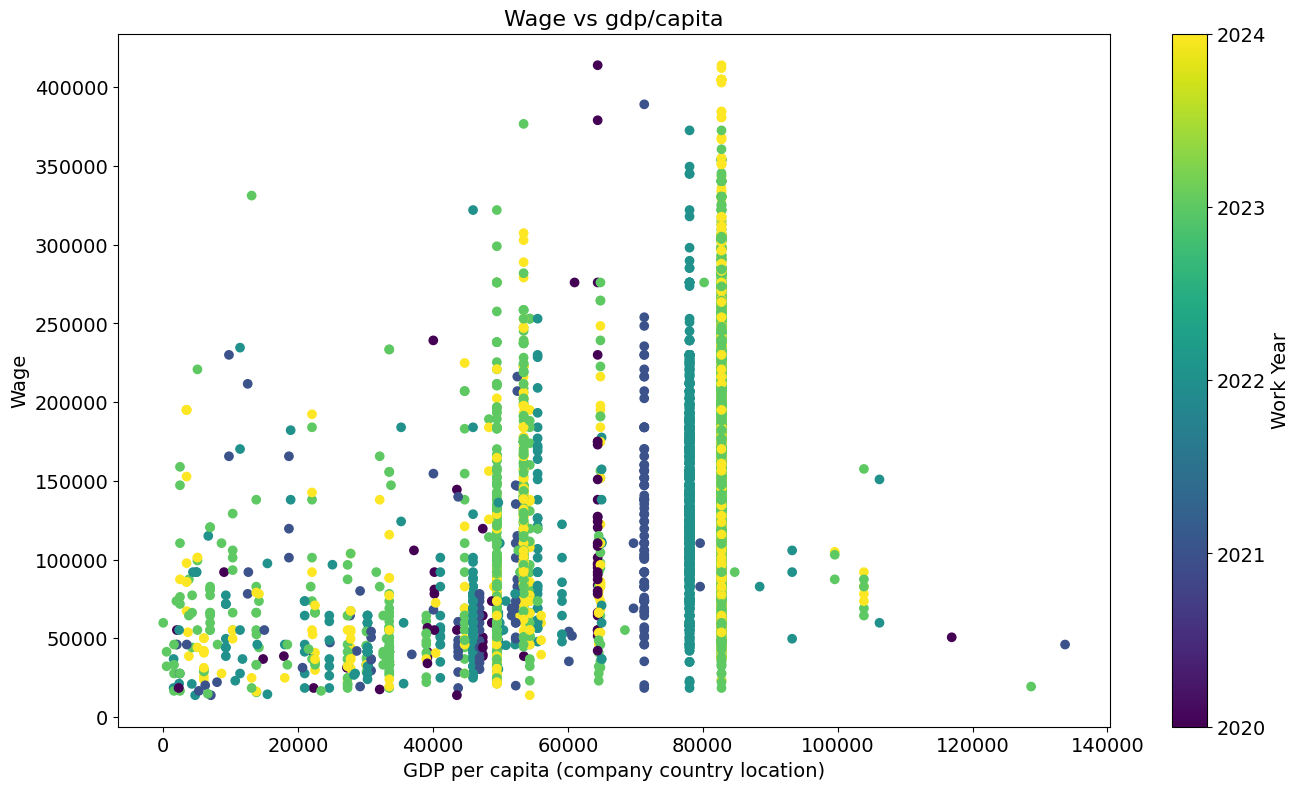

In [44]:
scatterplot = plt.scatter(
    x = df_processed['gdp_cap_comploc'], 
    y = df_processed['target'], 
    c=df_processed['work_year'],  # Use work_year for colors
    cmap='viridis'  # Colormap
)
plt.title('Wage vs gdp/capita')
plt.xlabel('GDP per capita (company country location)')
plt.ylabel('Wage')
cbar = plt.colorbar(scatterplot)
cbar.set_ticks(df_processed['work_year'].unique())
cbar.set_ticklabels(df_processed['work_year'].unique()) 
cbar.set_label('Work Year')

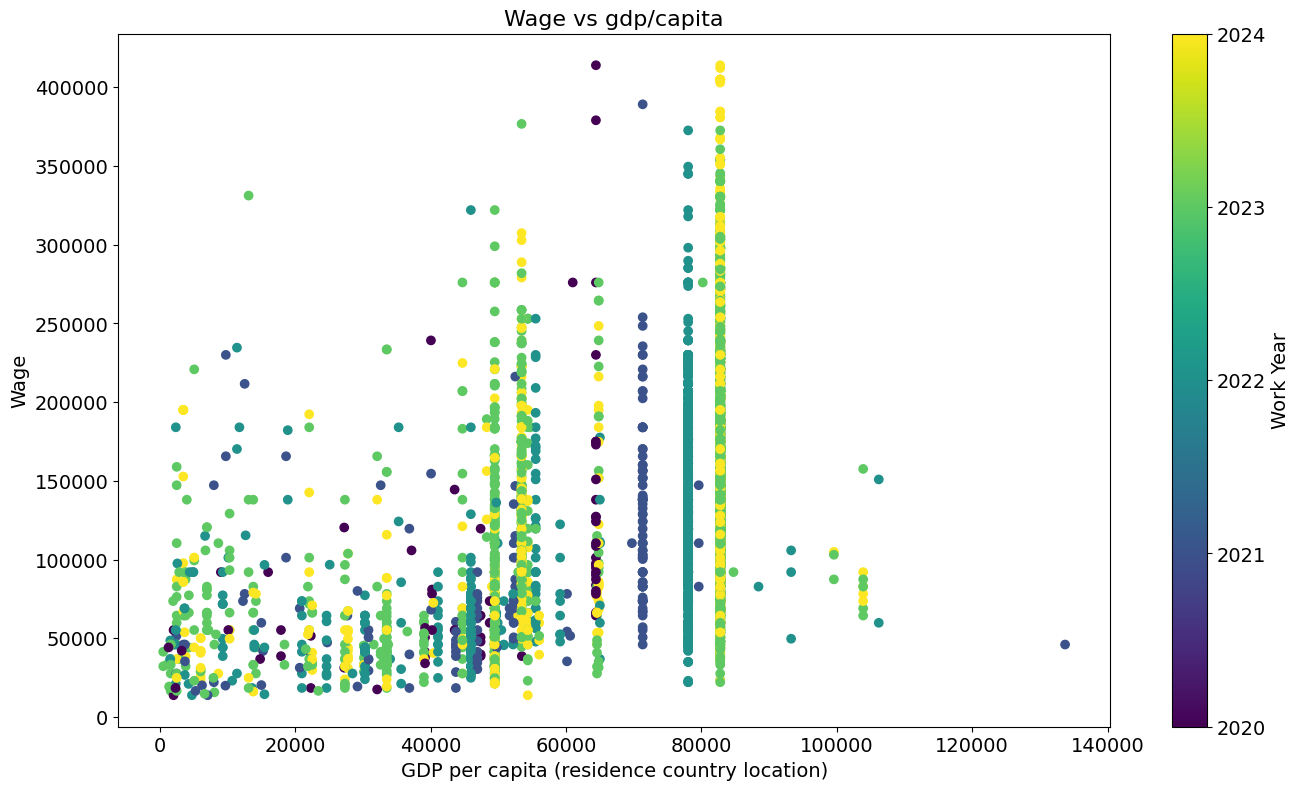

In [45]:
scatterplot = plt.scatter(
    x = df_processed['gdp_cap_resloc'], 
    y = df_processed['target'], 
    c=df_processed['work_year'],  # Use work_year for colors
    cmap='viridis'  # Colormap
)
plt.title('Wage vs gdp/capita')
plt.xlabel('GDP per capita (residence country location)')
plt.ylabel('Wage')
cbar = plt.colorbar(scatterplot)
cbar.set_ticks(df_processed['work_year'].unique())
cbar.set_ticklabels(df_processed['work_year'].unique()) 
cbar.set_label('Work Year')

not really a noticeable difference between GDP/capita for the residence of an employee, vs GDP/capita for the company location. 

# 6: Further visualisations:
Listings per country where too sparse to really do something meaningful with - I opted to use studies by the World Bank to allow Ordinal encoding at a later stage. Right now I need to make a few more visualisation on the actual wages. Some questions I want to see answered: 
1) Did wage change over time (work_year + target)
2) How are wages evolving in each different country (we replaced countrycodes by income categories in step 5). 
3) Relation of wage and field. 
4) Pick a field with a lot of different listings and see if title makes a difference. 
5) In the overall dataset, does company size matter in relation to wage? 
6) In the overall dataset, does experience matter in relation to wage? 
7) What is the impact of on vs off-site work?
8) What is the impact of employment duration( half-time/full-time)
9) Is exerperience equally distributed across company sizes?

before we go there, let's make a few high level plots to see how the data is distrubuted. We already know USA is the biggest country. What about other columns? 

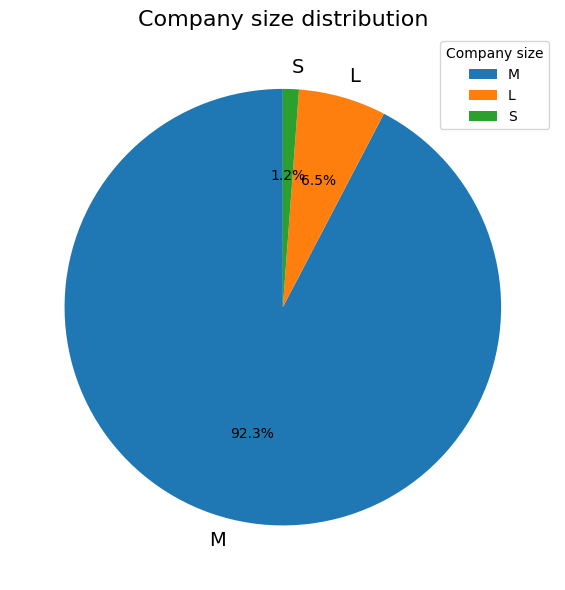

In [46]:
# company size distribution?
company_size_counts = df_processed['company_size'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Company size distribution')
plt.legend(company_size_counts.index, title='Company size', loc='best')
plt.tight_layout()
# >> heavily in favor of medium sized companies.

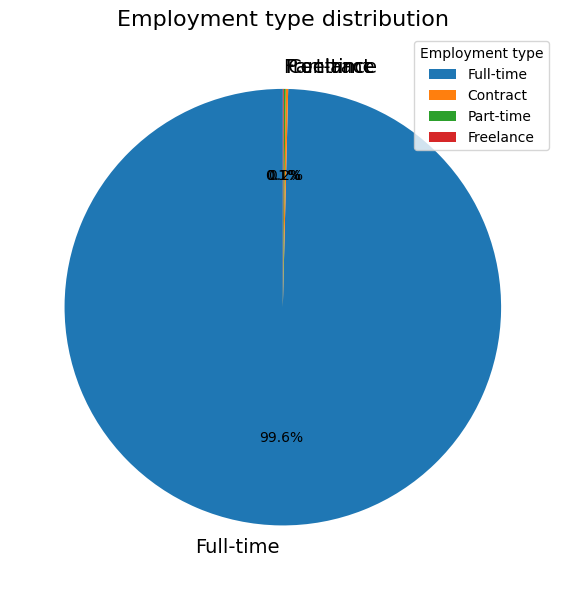

In [47]:
# Employment type distribution?
company_size_counts = df_processed['employment_type'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Employment type distribution')
plt.legend(company_size_counts.index, title='Employment type', loc='best')
plt.tight_layout()
# >> Extremely in favor of full-time contract.!!

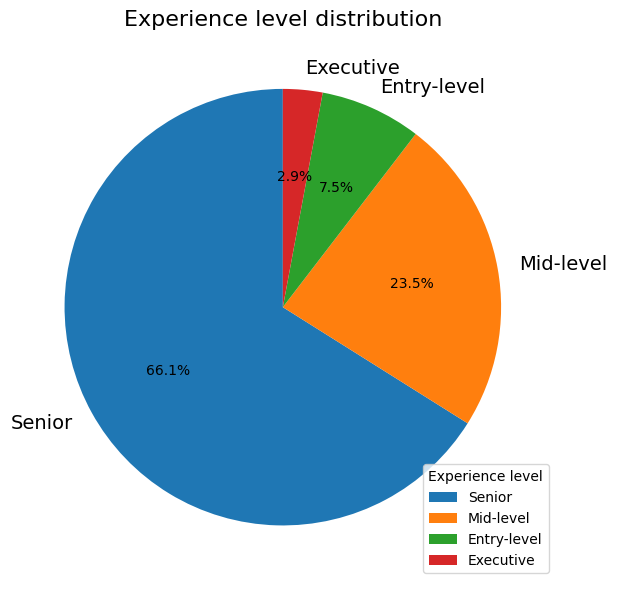

In [48]:
# Employment experience level distribution?
company_size_counts = df_processed['experience_level'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Experience level distribution')
plt.legend(company_size_counts.index, title='Experience level', loc='best')
plt.tight_layout()
# >> quite in favor of senior positions.

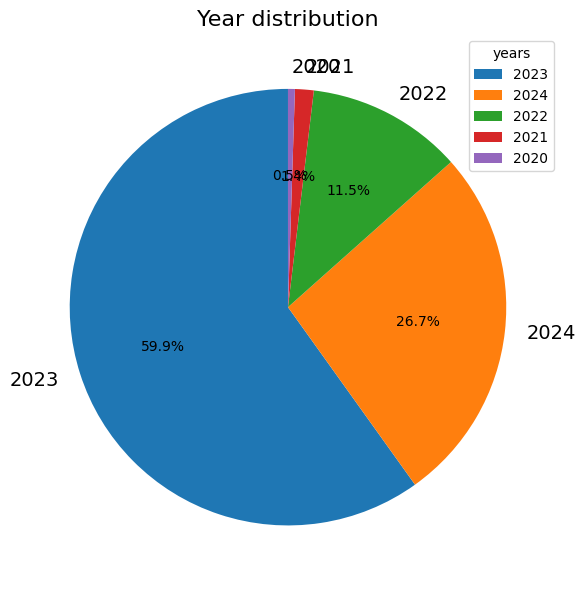

In [49]:
# workyear distribution?
company_size_counts = df_processed['work_year'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Year distribution')
plt.legend(company_size_counts.index, title='years', loc='best')
plt.tight_layout()
# >> quite in favor of more recent years; however 1/8th of the data is older than 2023!!! (impact of inflation might be visible)

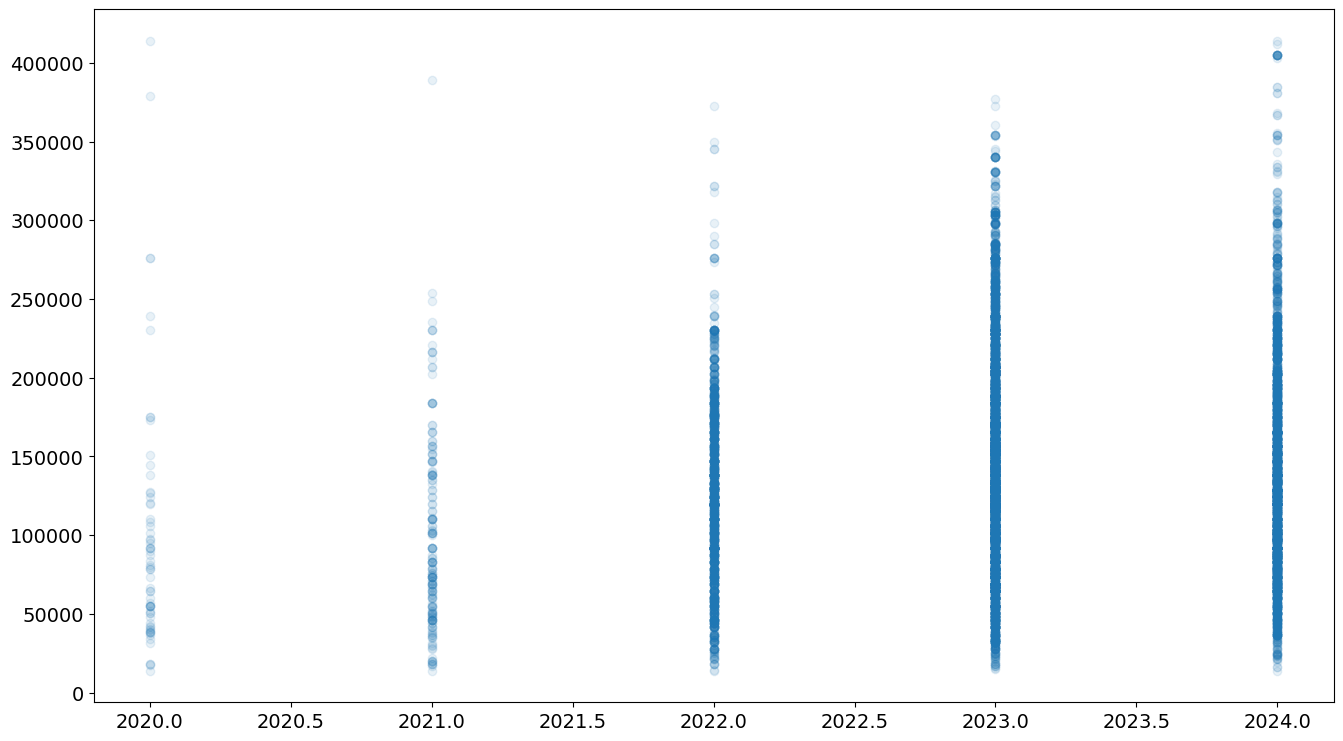

In [50]:
plt.scatter(df_processed['work_year'], df_processed['target'], alpha=0.1)

## 6.1. Wage evolution over time: 

Text(0.5, 0.98, 'Overall wage evolution per year across full dataset')

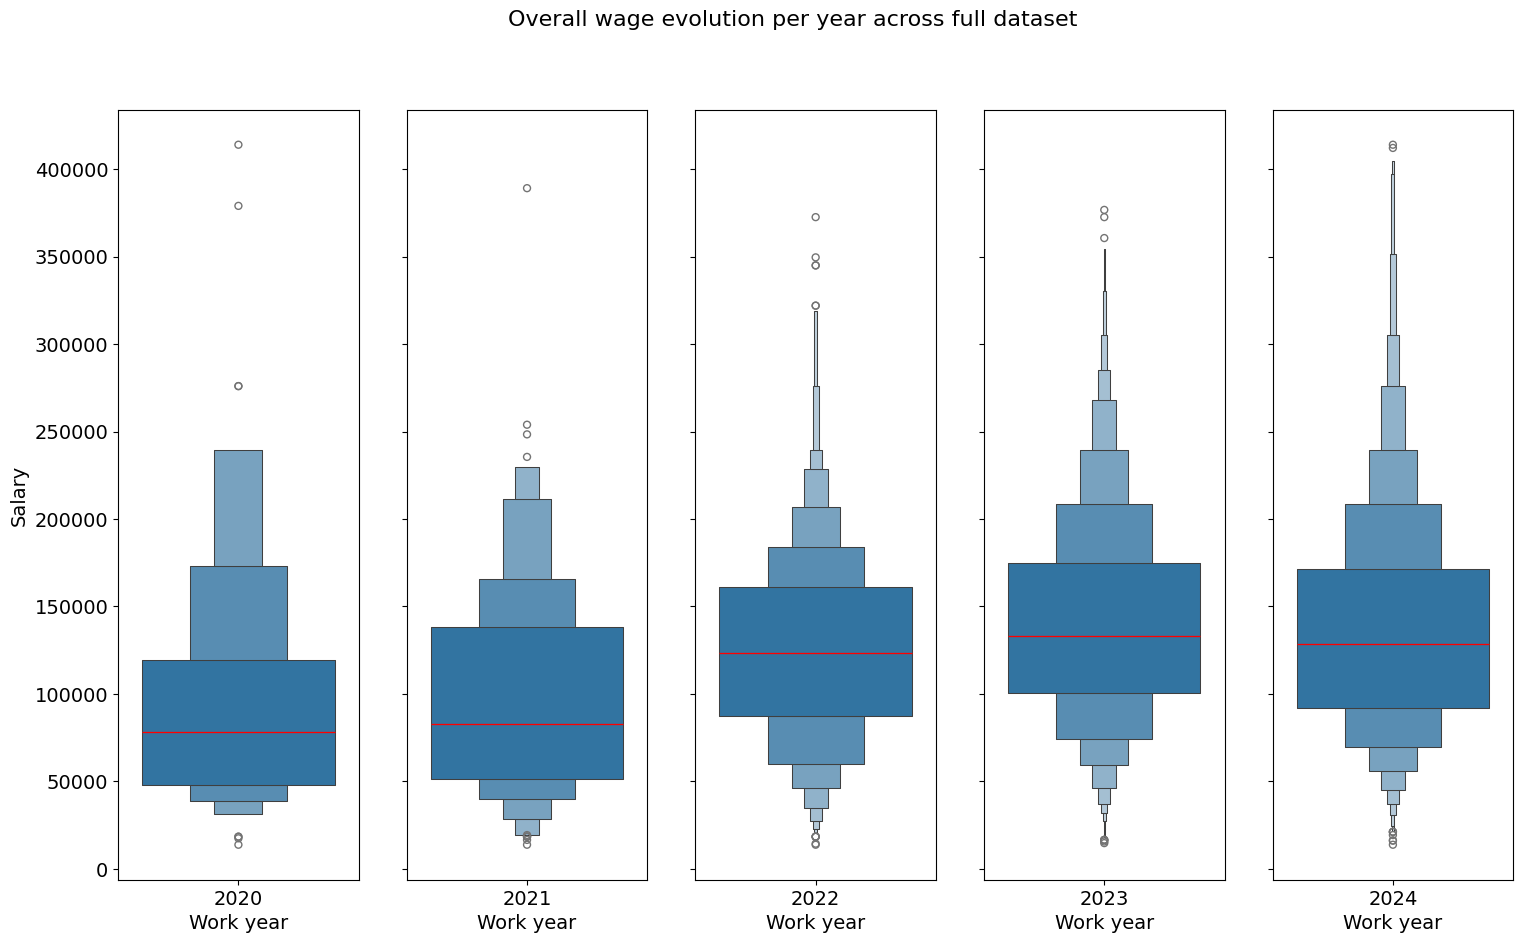

In [51]:
fig, axes = plt.subplots(1, 5, figsize=(18, 10), sharey=True)
years = sorted(df_processed['work_year'].unique())
for i, (year, ax) in enumerate(zip(years, axes)):
    sns.boxenplot(x='work_year', y='target', data=df_processed[df_processed['work_year'] == year], ax=ax, line_kws={'color': 'red'})
    ax.set_xlabel('Work year')
    ax.set_ylabel('Salary')
plt.suptitle('Overall wage evolution per year across full dataset')

Text(0.5, 0.98, 'Overall wage evolution per year across dataset ommitting USA')

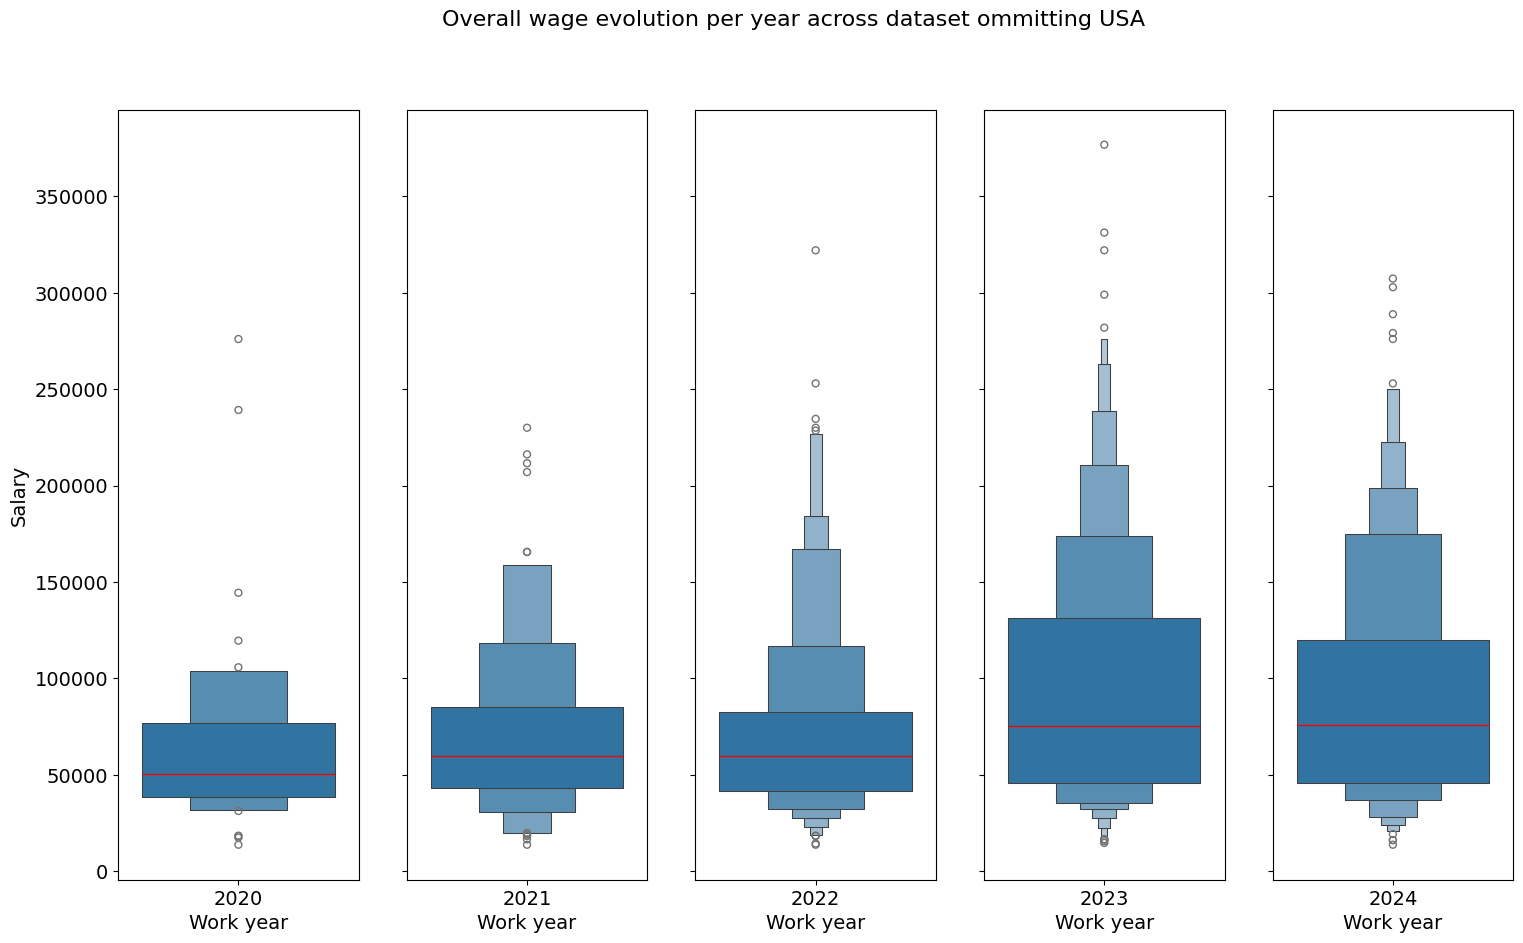

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(18, 10), sharey=True)
years = sorted(df_processed['work_year'].unique())
for i, (year, ax) in enumerate(zip(years, axes)):
    sns.boxenplot(x='work_year', y='target', data=df_processed[(df_processed['work_year'] == year) & (df_processed['comp_location_WBI_code'] != 'USA')], ax=ax, line_kws={'color': 'red'})
    ax.set_xlabel('Work year')
    ax.set_ylabel('Salary')
plt.suptitle('Overall wage evolution per year across dataset ommitting USA')


6.1 Answer ==> YES in the overall dataset wage changed significantly over time. We can see the effect very clear for the full dataset (first boxenplot); when we ommit wages paid in the USA we see that the overal conclusion remains, but is less pronounced. Overall I'd say work year is a significant factor in determining the target.

The countrycode seems to be a factor too. Let's see how important it is with a linechart/timeseries setup. 

Notice how the USA is leading wage shifts when you look at the time-dimension: 
- 2021 -> 2022 = big jump in USA; NON usa countries swho only the same bump one year later. 

So the countrycode also plays a role (at least USA vs NOT USA)

## 6.2. Country wage evolution over time

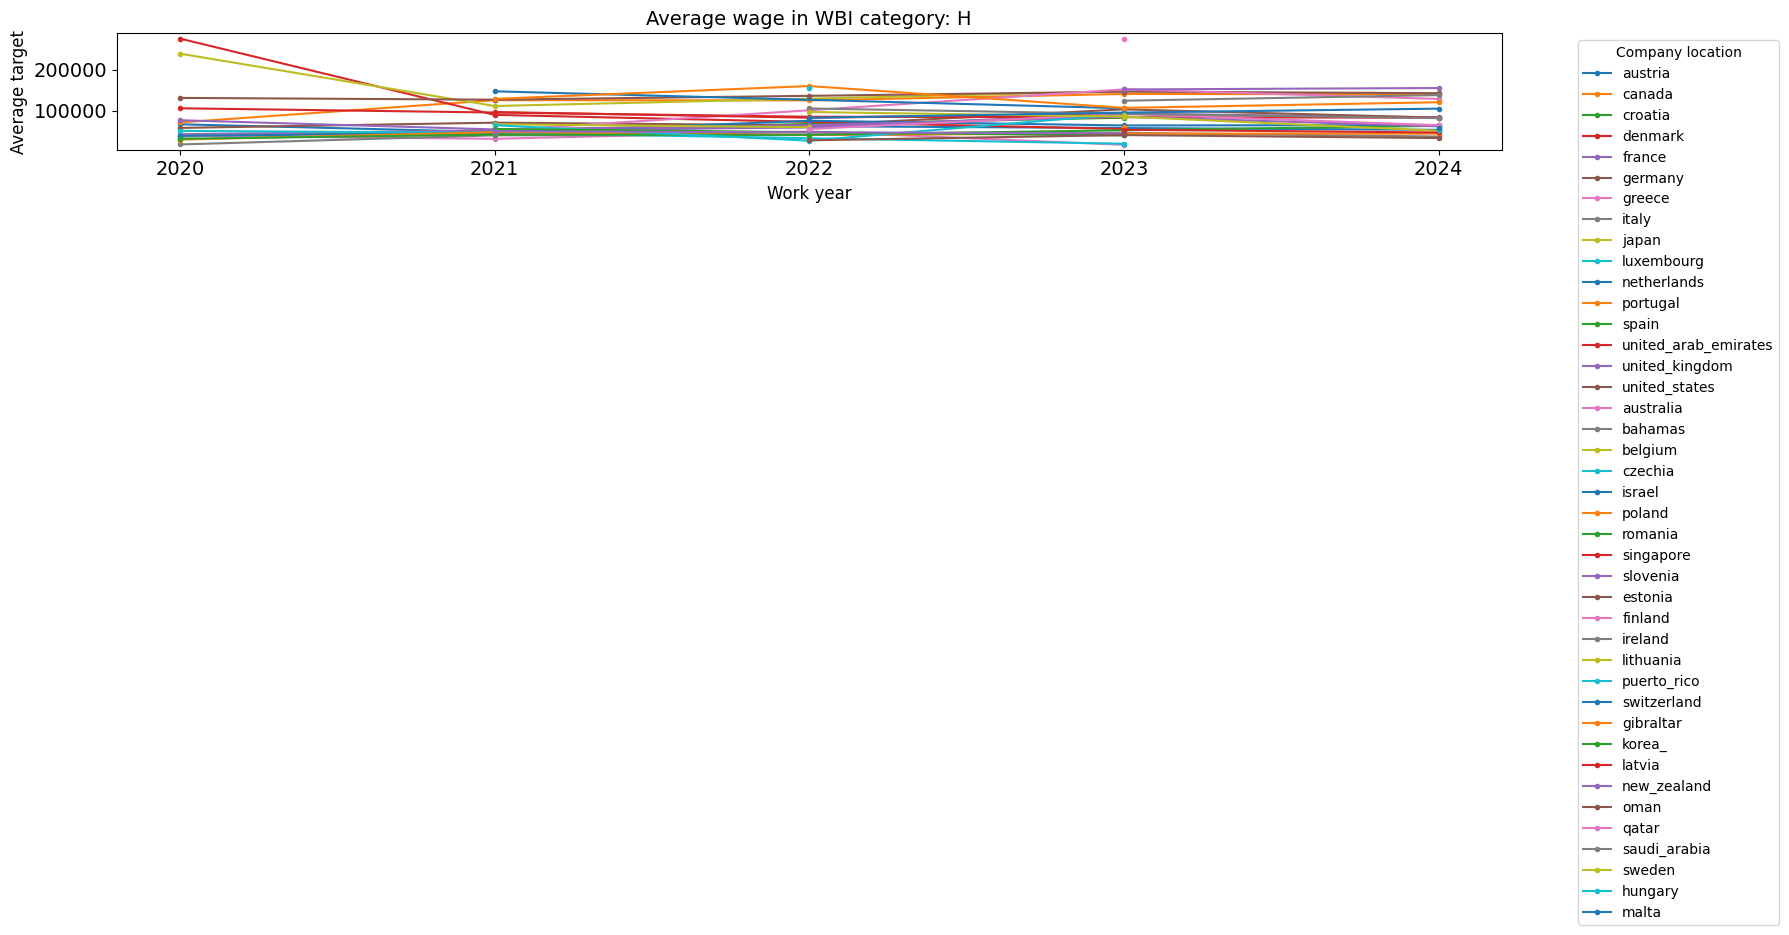

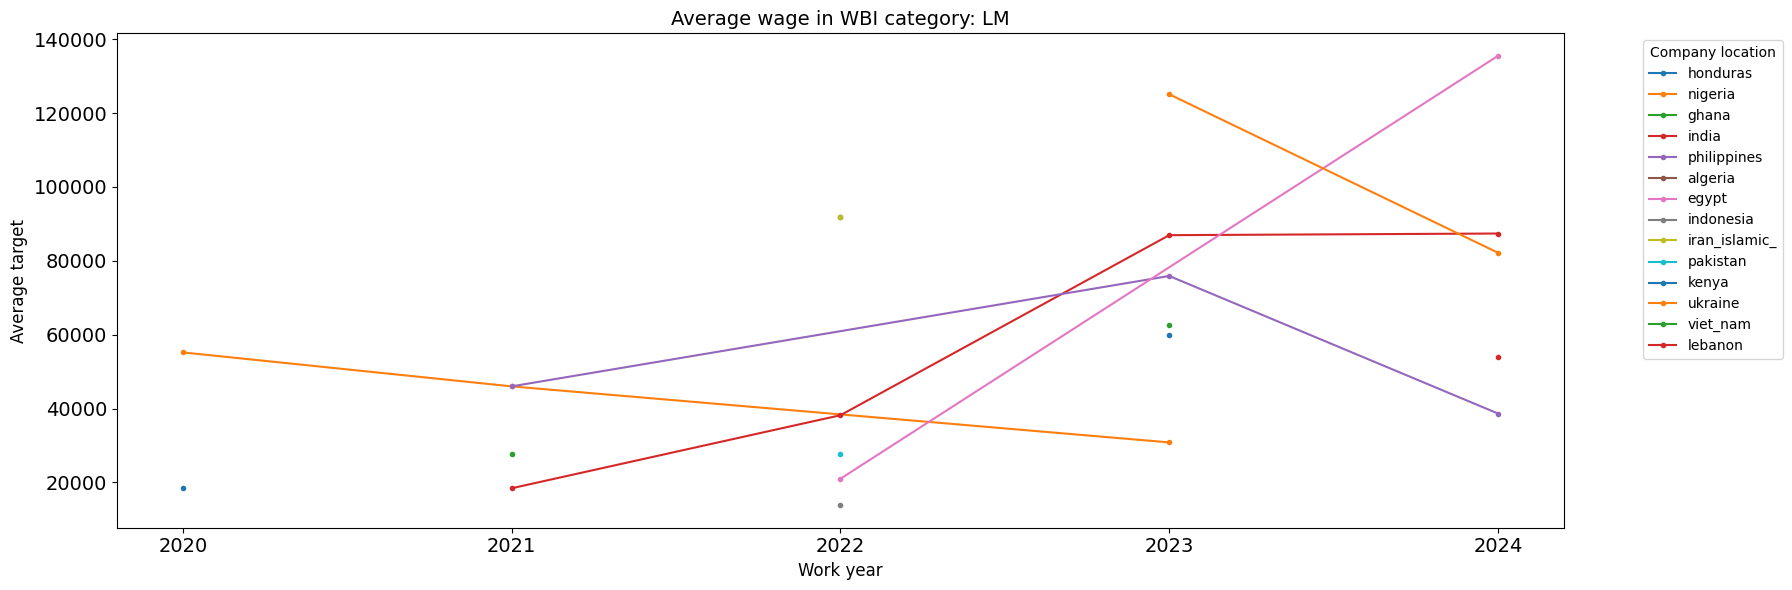

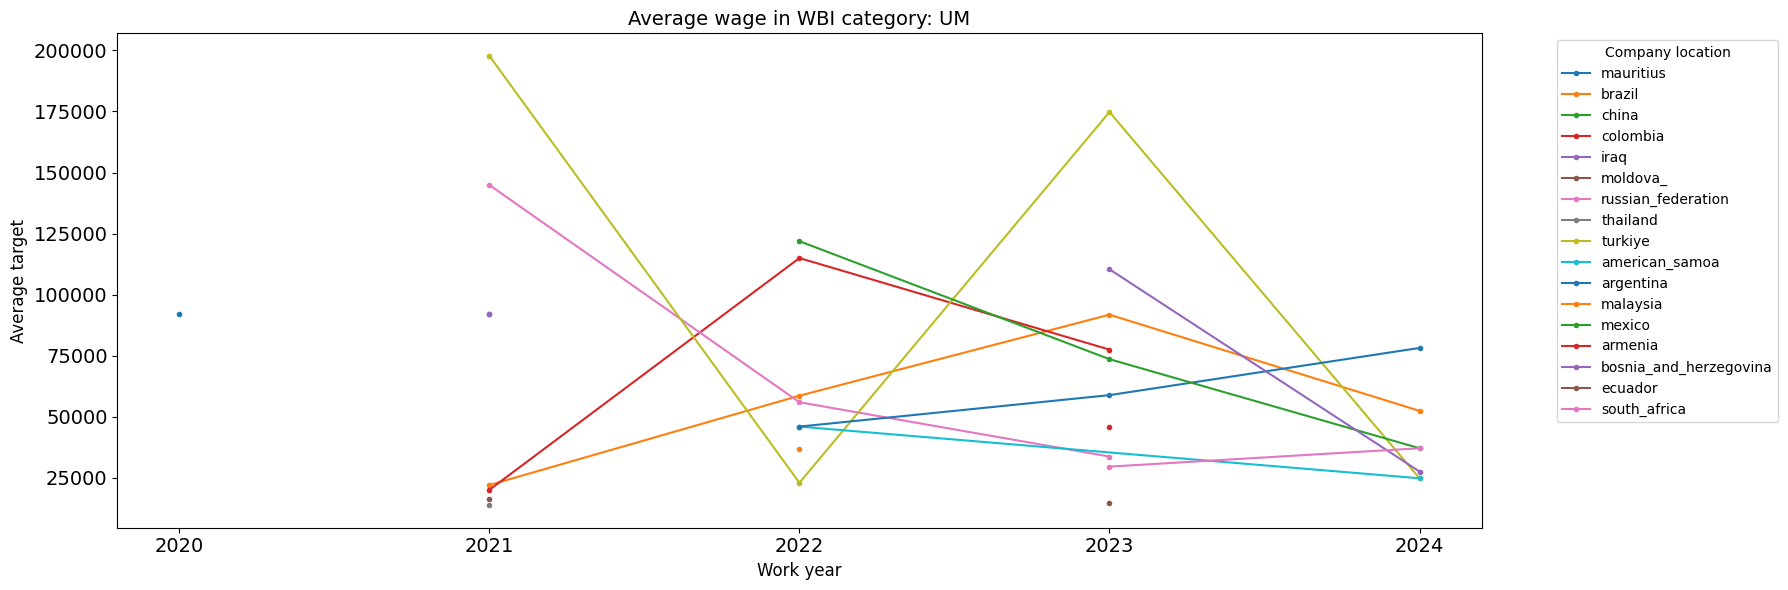

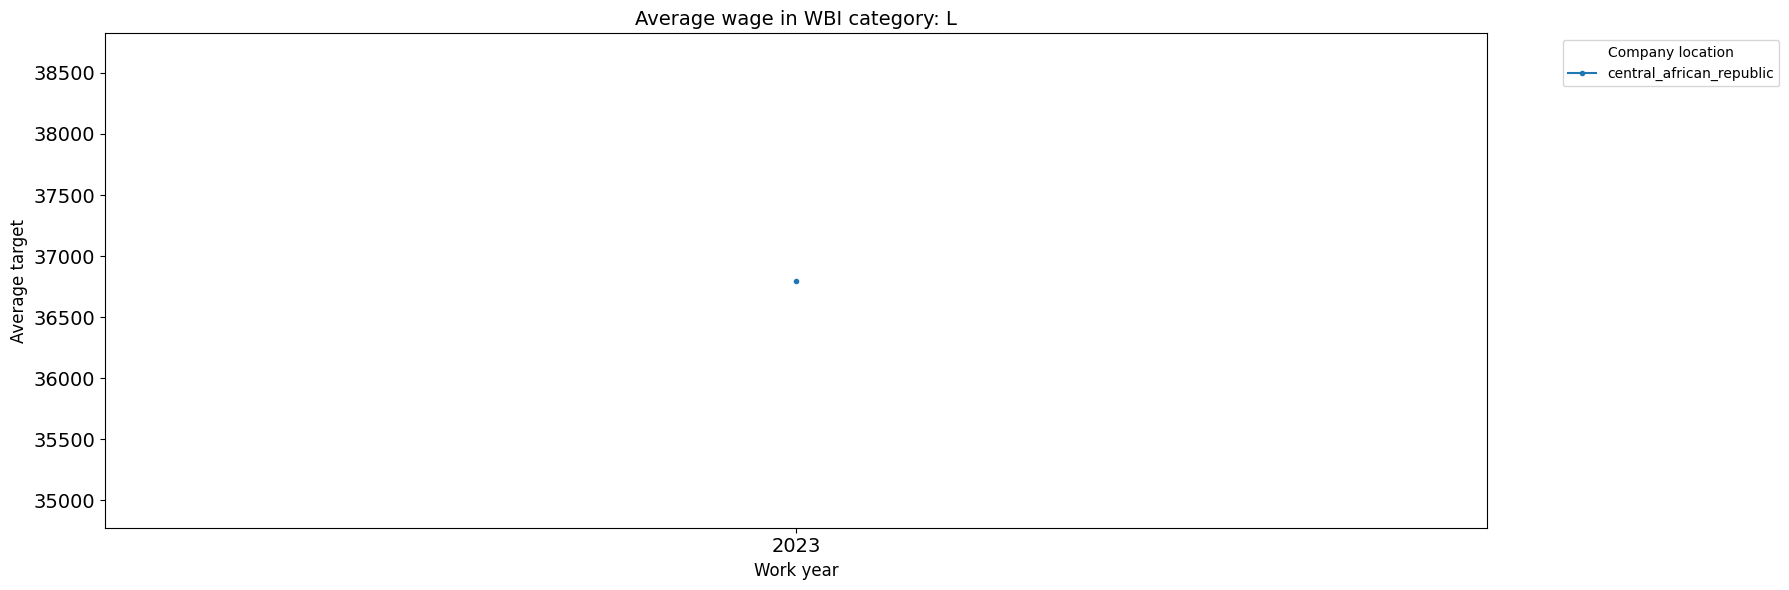

In [53]:
average_target = df_processed.groupby(['work_year', 'company_location', 'location_income_category'])['target'].mean().reset_index()

# Create separate plots for each 'location_income_category'
for category in df_processed['location_income_category'].unique():
    # Filter data for the current category
    category_data = average_target[average_target['location_income_category'] == category]
    
    # Initialize the plot
    plt.figure(figsize=(18, 6))
    
    # Iterate over each unique 'company_location'
    for location in category_data['company_location'].unique():
        location_data = category_data[category_data['company_location'] == location]
        plt.plot(
            location_data['work_year'],
            location_data['target'],
            marker='.',
            label=location
        )
        unique_years = category_data['work_year'].unique()
        plt.xticks(ticks=unique_years, labels=unique_years)
    # Customize the plot
    plt.title(f'Average wage in WBI category: {category}', fontsize=14)
    plt.xlabel('Work year', fontsize=12)
    plt.ylabel('Average target', fontsize=12)
    plt.legend(title='Company location', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

some observations: 
1) the average wage for countries in the high-income category are less volatile than in any of the other categories. If we go back to the gridplot we can mostly explain this by there being more entries. 
2) High and Upper Middle countries seem to have quite some overlap - this could mean that we should keep the country added!!!! (we'll need to experiment with this)
3) A lot of countries are in the high income category - but even there we see a small upward trend. 

The high income graph is not very clear, but we can conclude there's a small upward trend there with less volatily compared to other income categories. Finally adding these categories was really pointless as the spread of the wages across countries in H-category is absurdly high

## 6.3 Wages per field and per title
In an earlier phase we split up the job title in two parts: the field and the title (e.g. Data Science Developer became: field = data_science and title = developer). This was also done with the idea to reduce the need for too many columns when performing OHE on this. For now I quickly want to see how the wage distribution is per field per income category by country. We'll use a scatterplot. We've established that the year is important across the whole dataset, so we'll focus on a single year. Horizontal boxplots would work nicely for this. 

In [54]:
year = df_processed.work_year.value_counts().idxmax()
#most for 2023, let's use that as our focus year. 

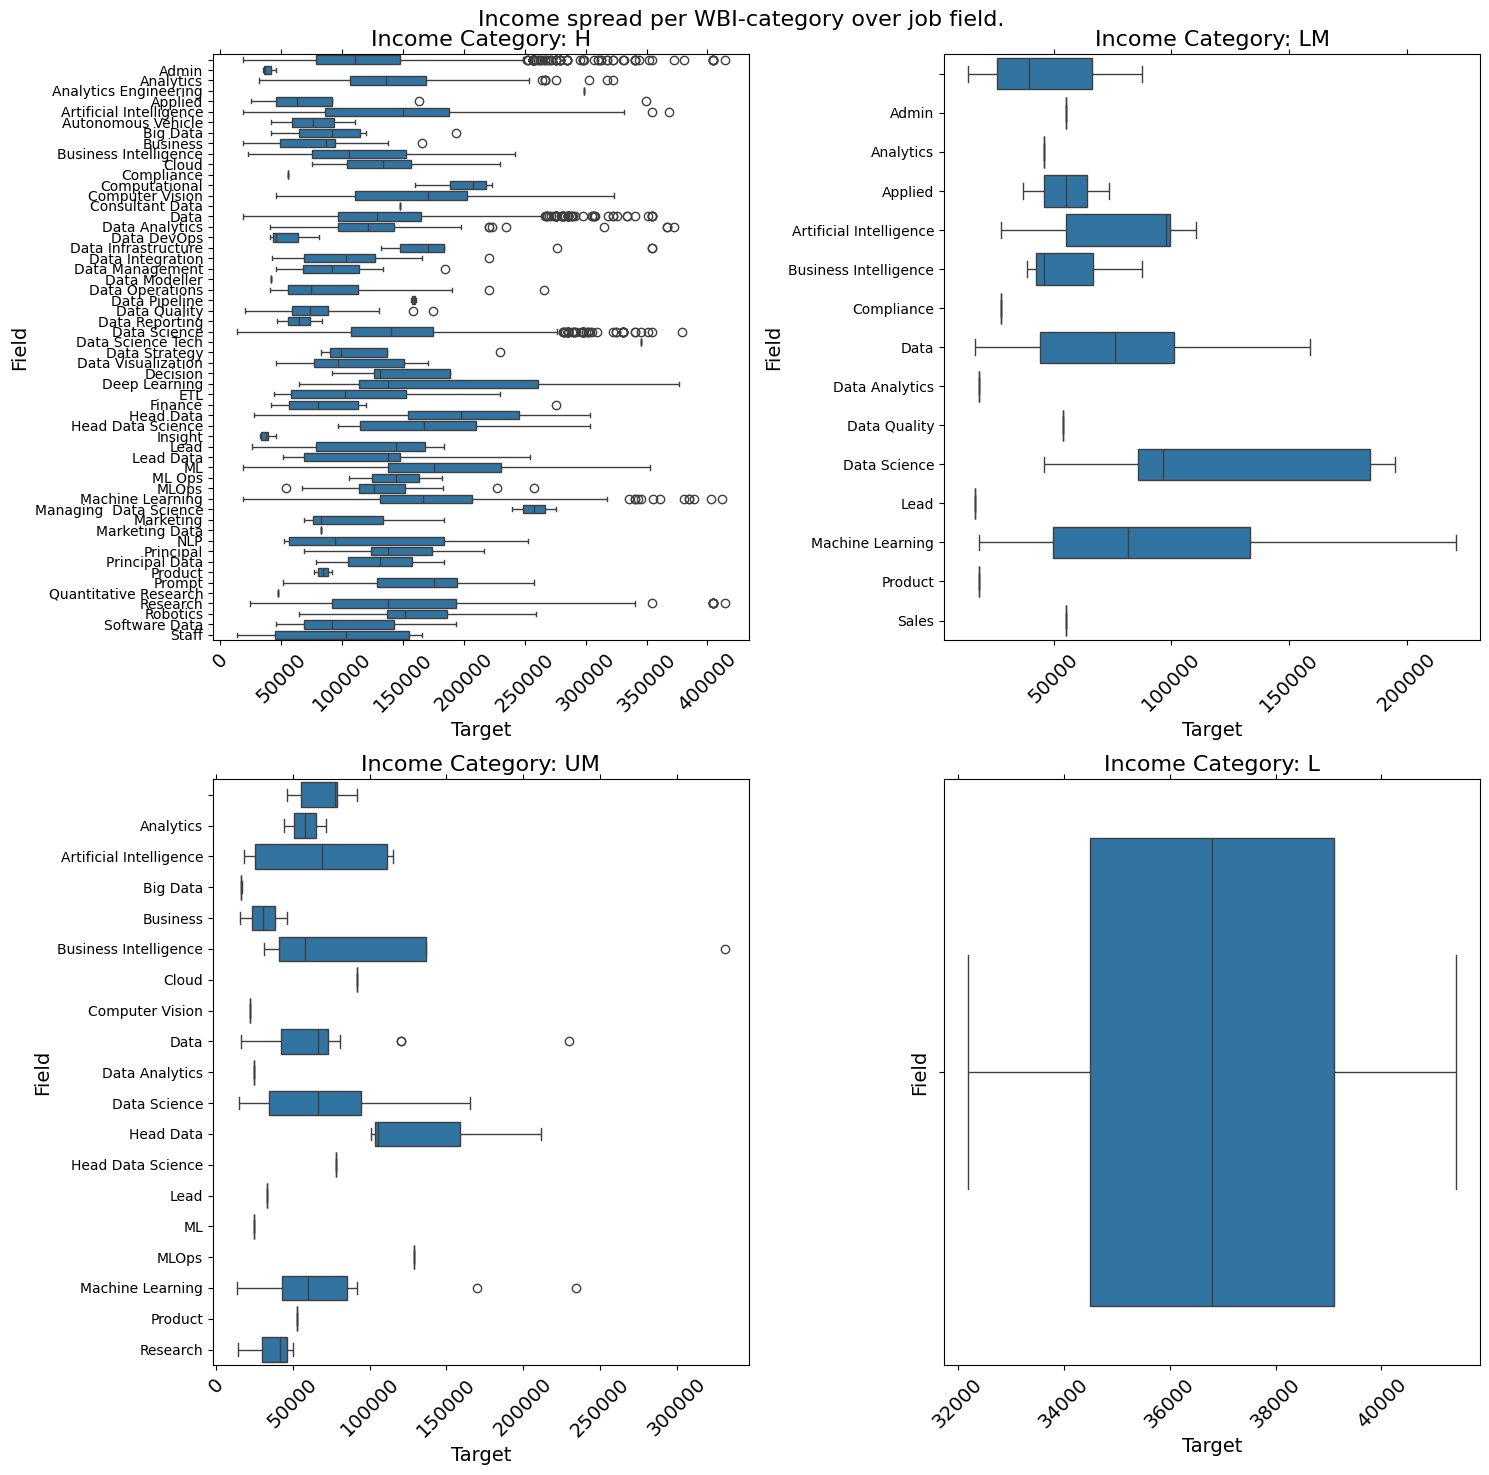

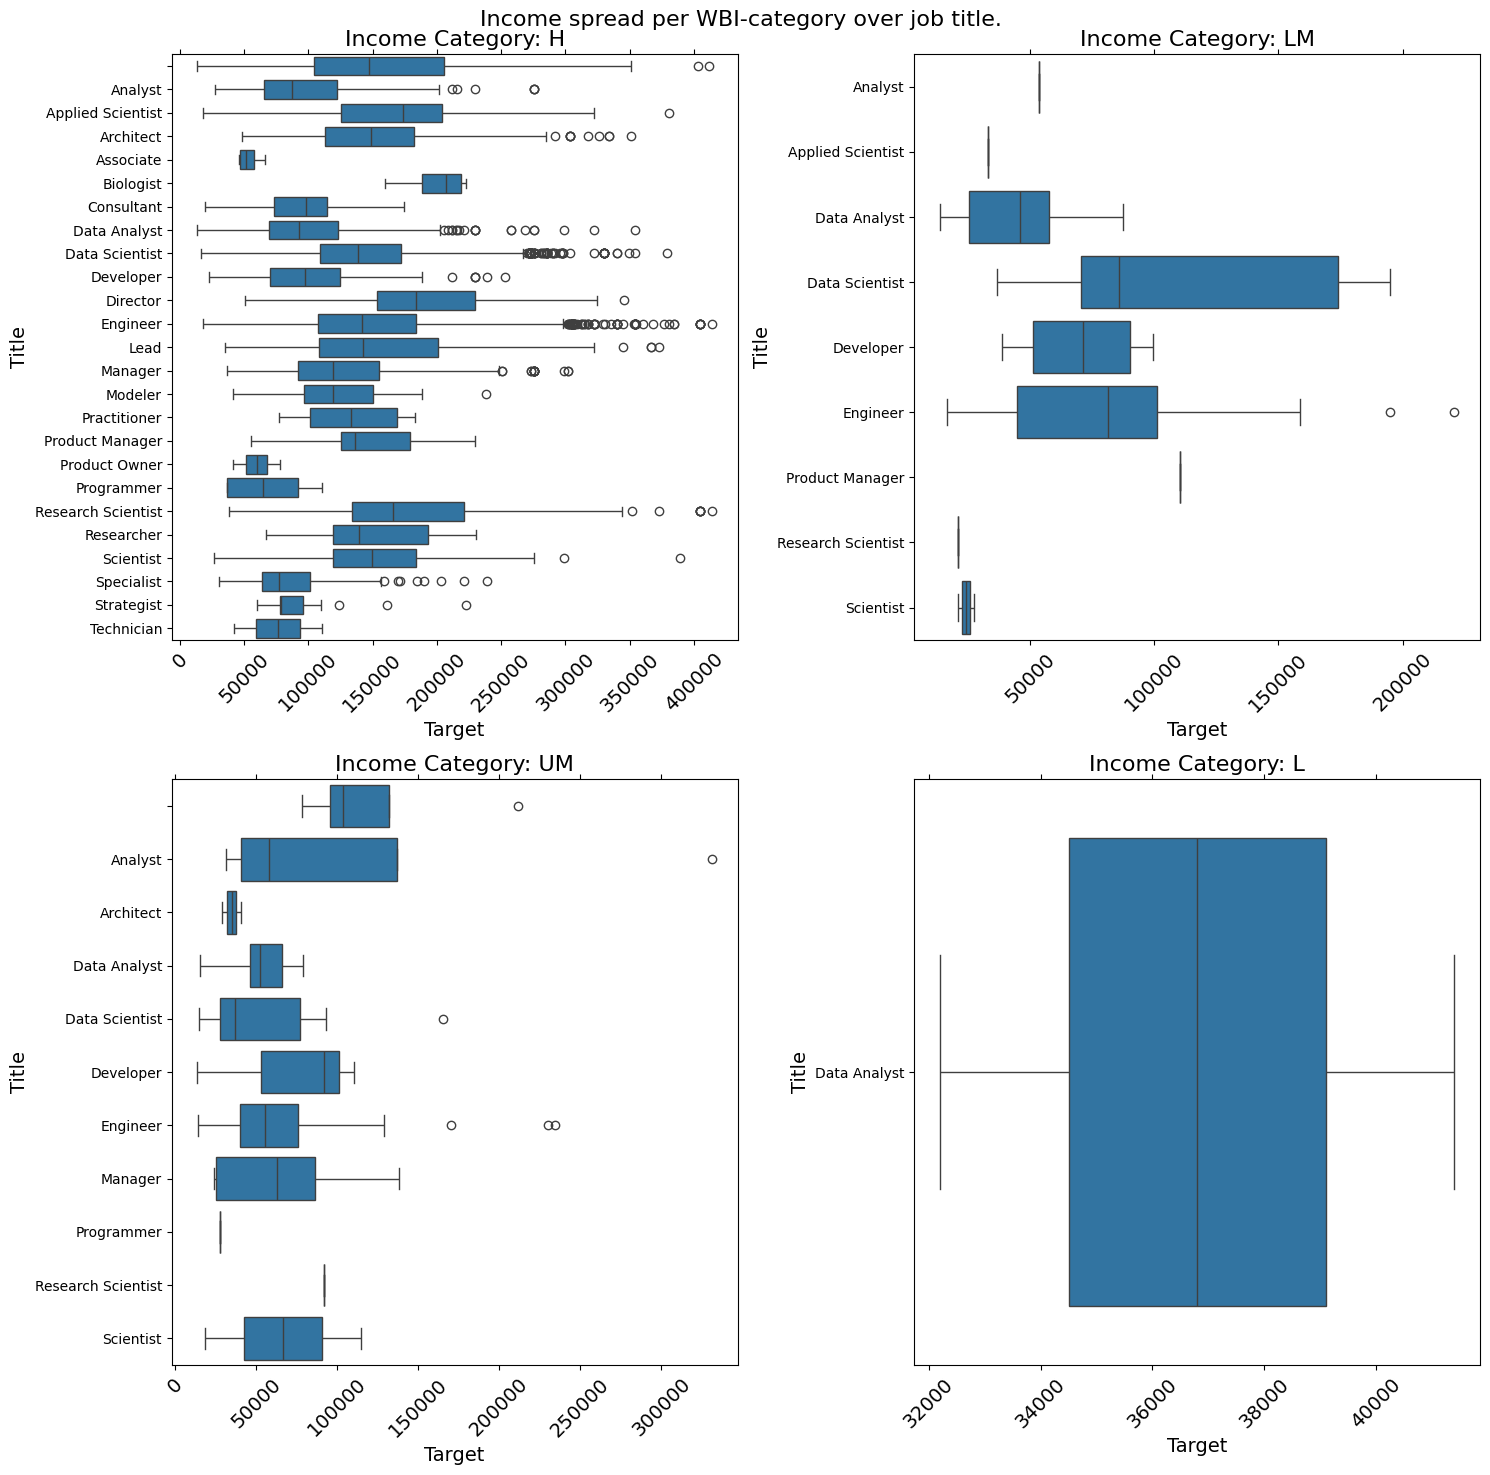

In [55]:
for grouper in ['field', 'title']: 
    # Create a 2x2 grid for subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # List of unique 'location_income_category' values
    categories = df_processed['location_income_category'].unique()

    # Iterate over each 'location_income_category' and corresponding subplot axis
    for ax, category in zip(axes, categories):
        # Filter data for the current category and sort by 'field'
        category_data = df_processed[df_processed['location_income_category'] == category].sort_values(by=grouper)
        
        # Create horizontal boxplot
        sns.boxplot(
            y=grouper,
            x='target',
            data=category_data,
            ax=ax,
            orient='h'  # Horizontal orientation
        )
        ax.set_title(f'Income Category: {category}')
        ax.set_xlabel('Target')
        ax.set_ylabel(grouper.capitalize())
        ax.tick_params(axis='y', labelsize=10)  #make y axis font a bit smaller to put all together. 
        ax.tick_params(axis='x', rotation = 45, top = 'ha')  #make y axis font a bit smaller to put all together. 

    # Adjust layout for better spacing
    plt.suptitle(f'Income spread per WBI-category over job {grouper}. ')
    plt.tight_layout()
    plt.show()

For similar fields the split in H, UM, LM and L income categories seems to make sense - so the data provided from the WBI file is actually more usefull than the previous lineplots showed. However - there are a lot fo major differneces between the same jobs: notice how the full normal range for people working in High income coutnries in Administration is considered to be in the same range as the outliers for people working High income categories in the MLOPS field....

this shows that the field is an important factor in determining the wage for an employee too. 

For job titles we see a similar conlcusion, so that'll have to be a part of the model too. there's little sense in exploring the relation between experience level and title as some titles are only found in specific fields and ordinality of a title is not always clear.

## 6.4 Wages per level in a given field

In [56]:
topfield = df_processed.query("work_year == @year").field.value_counts().idxmax()   #take the year witht the most entries found earlier and explore: 
topfield

'Data'

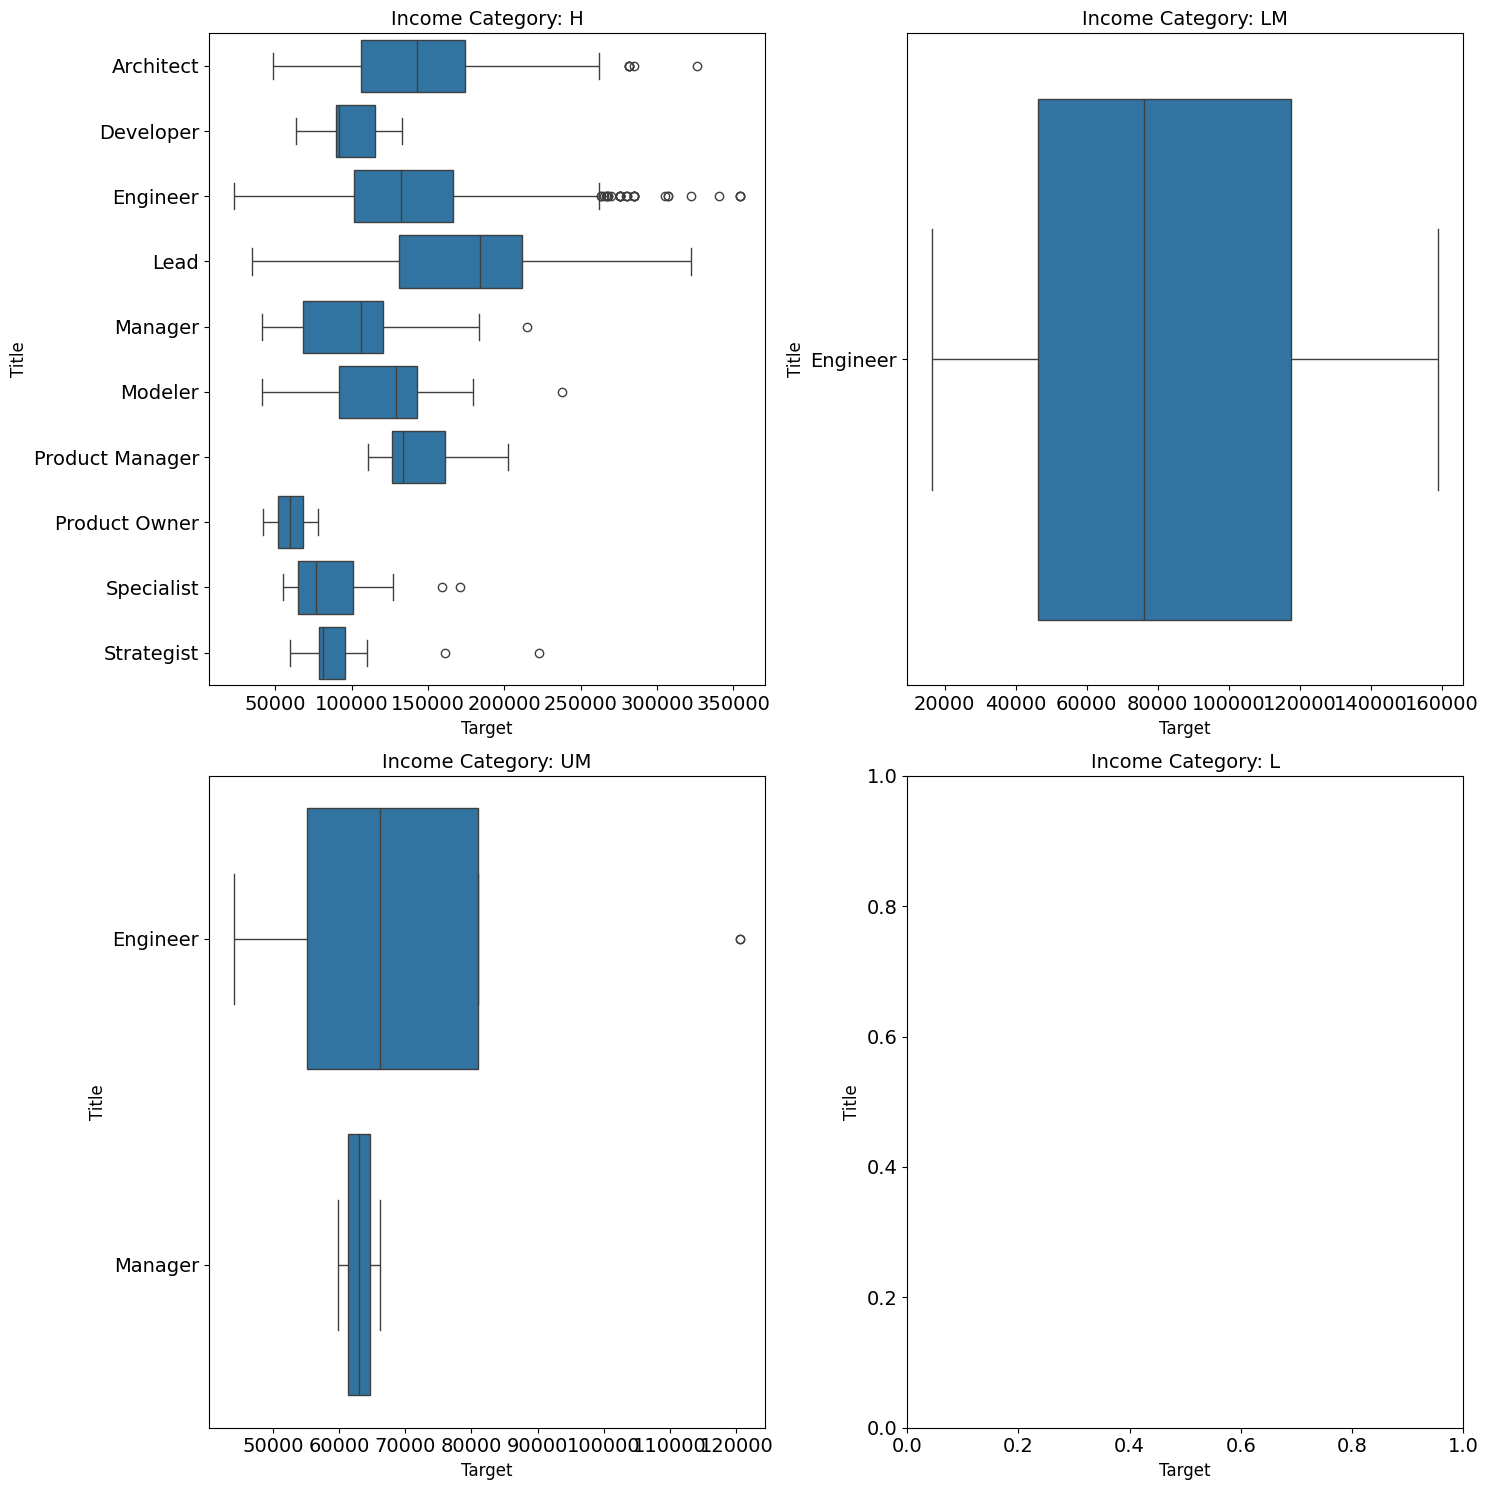

In [57]:
# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Flatten axes for easier iteration
axes = axes.flatten()

# List of unique 'location_income_category' values
categories = df_processed['location_income_category'].unique()

# Iterate over each 'location_income_category' and corresponding subplot axis
for ax, category in zip(axes, categories):
    # Filter data for the current category and sort by 'field'
    category_data = df_processed[
        (df_processed['location_income_category'] == category) & 
        (df_processed['field'] == topfield) &
        (df_processed['work_year'] == year)
        ].sort_values(by='title')
    
    # Create horizontal boxplot
    sns.boxplot(
        y='title',  # Replace 'field' with the actual column name
        x='target',
        data=category_data,
        ax=ax,
        orient='h'  # Horizontal orientation
    )
    
    # Customize the plot
    ax.set_title(f'Income Category: {category}', fontsize=14)
    ax.set_xlabel('Target', fontsize=12)
    ax.set_ylabel('Title', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()


similar as before we see that some wages are significantly different from others; the whole range of wages for H-income WBI countries for product owners is considered to be in the range of outliers for H-income WBI countries for product managers. 

SO: yes, title plays a big role, but it's not possible to apply ordinality to this feature. 

## 6.5 Company Size vs Wage
so far we have established that the following factors contribute to the wage determination: 
- work_year (base feature)
- country (base feature)
- field (engineered feature)
- title (engineered feature)

To see if there's a correlation betwene company size and wage we'll need to look for a large enough subset with features that are similar to the ones above. 

In [58]:
#these are all the keys i want to grluop by on for all of the next questions I want to answer. For each questin I just remove one of the strings as part of my call to the make_clusters function. (delcare for all)
groupbykeys = ['work_year', 'company_location', 'title', 'field', 'employment_type', 'experience_level', 'company_size', 'work_setting']  

In [59]:
key_for_question = 'company_size'
clusters = h.make_clusters(df_processed, groupbykeys, key_for_question)
clusters.head(5)

work_year company_location           title             field employment_type experience_level work_setting  count
849       2023    united_states        Engineer              Data       Full-time           Senior    In-person    753
798       2023    united_states  Data Scientist      Data Science       Full-time           Senior    In-person    685
884       2023    united_states        Engineer  Machine Learning       Full-time           Senior    In-person    579
799       2023    united_states  Data Scientist      Data Science       Full-time           Senior       Remote    420
777       2023    united_states    Data Analyst                         Full-time           Senior    In-person    355

we have a few good ones to use with constraints as follows: 
- year = 2023 (logical, we have most data for 2023)
- company_location = united_states (logical, we have most data for USA)
- title = Engineer
- field = Data
- Employment_type = Full-time
- work_setting = In-person
- Experience_level = Senior

We'll use these constraints to plot the wage in function of the company size.


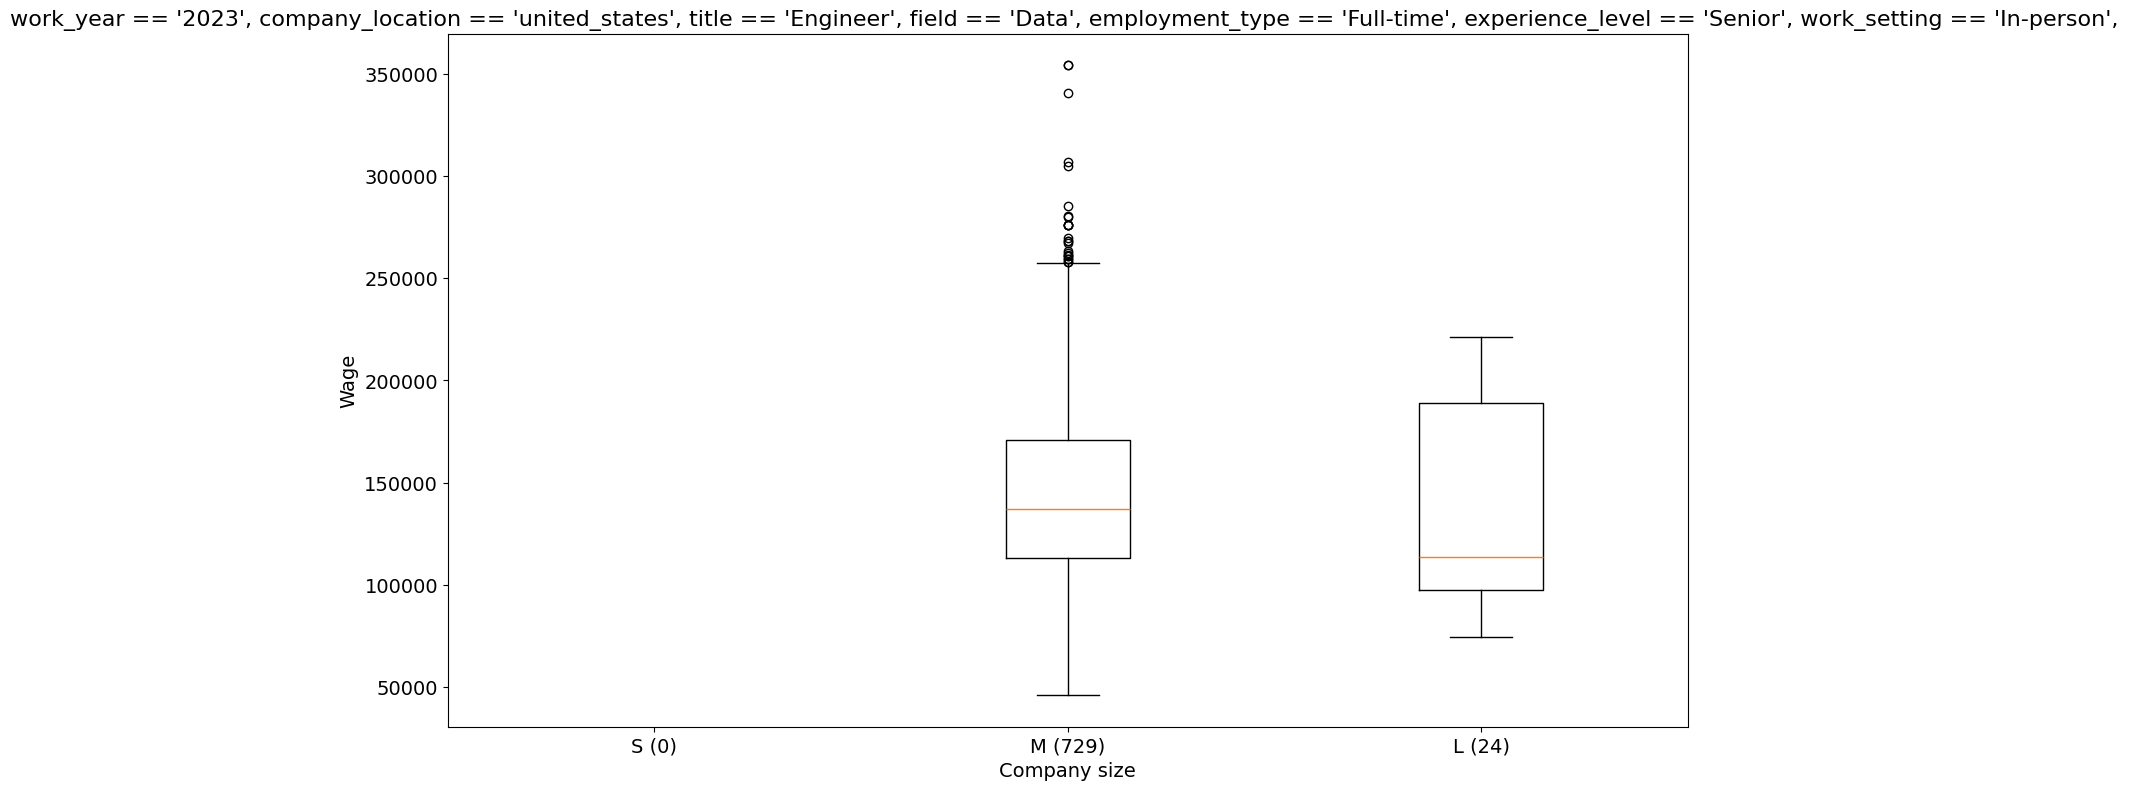

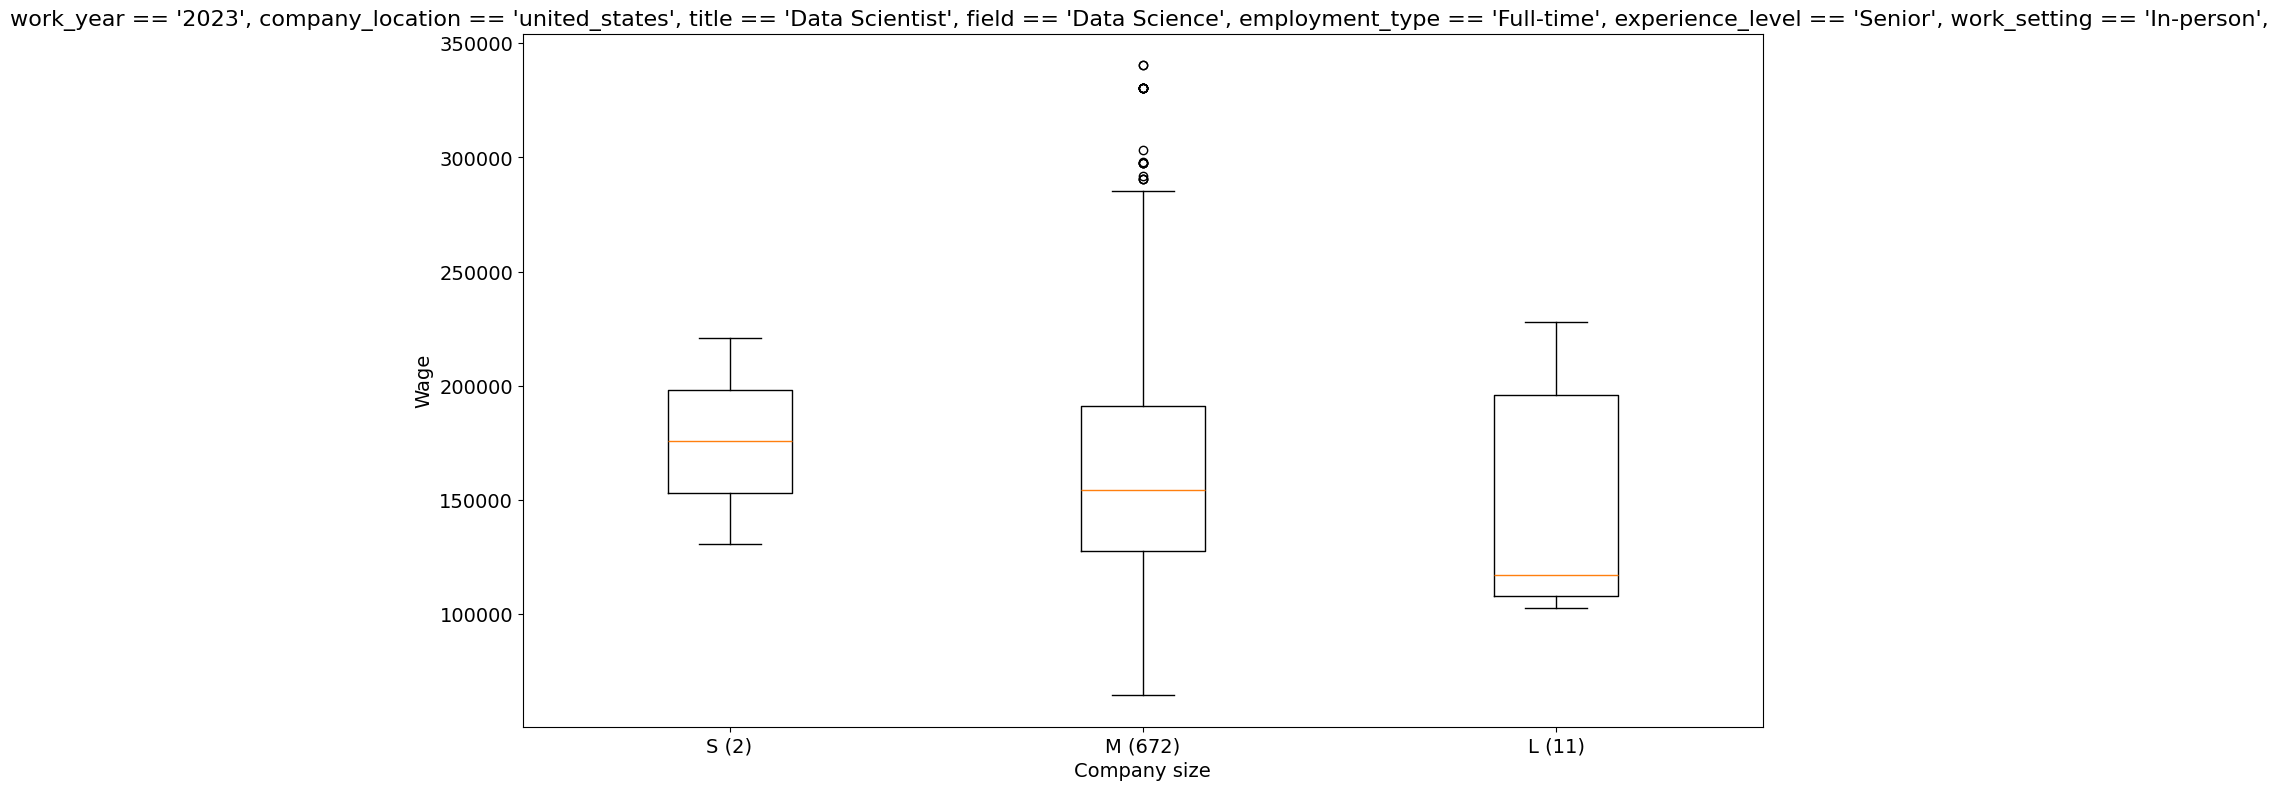

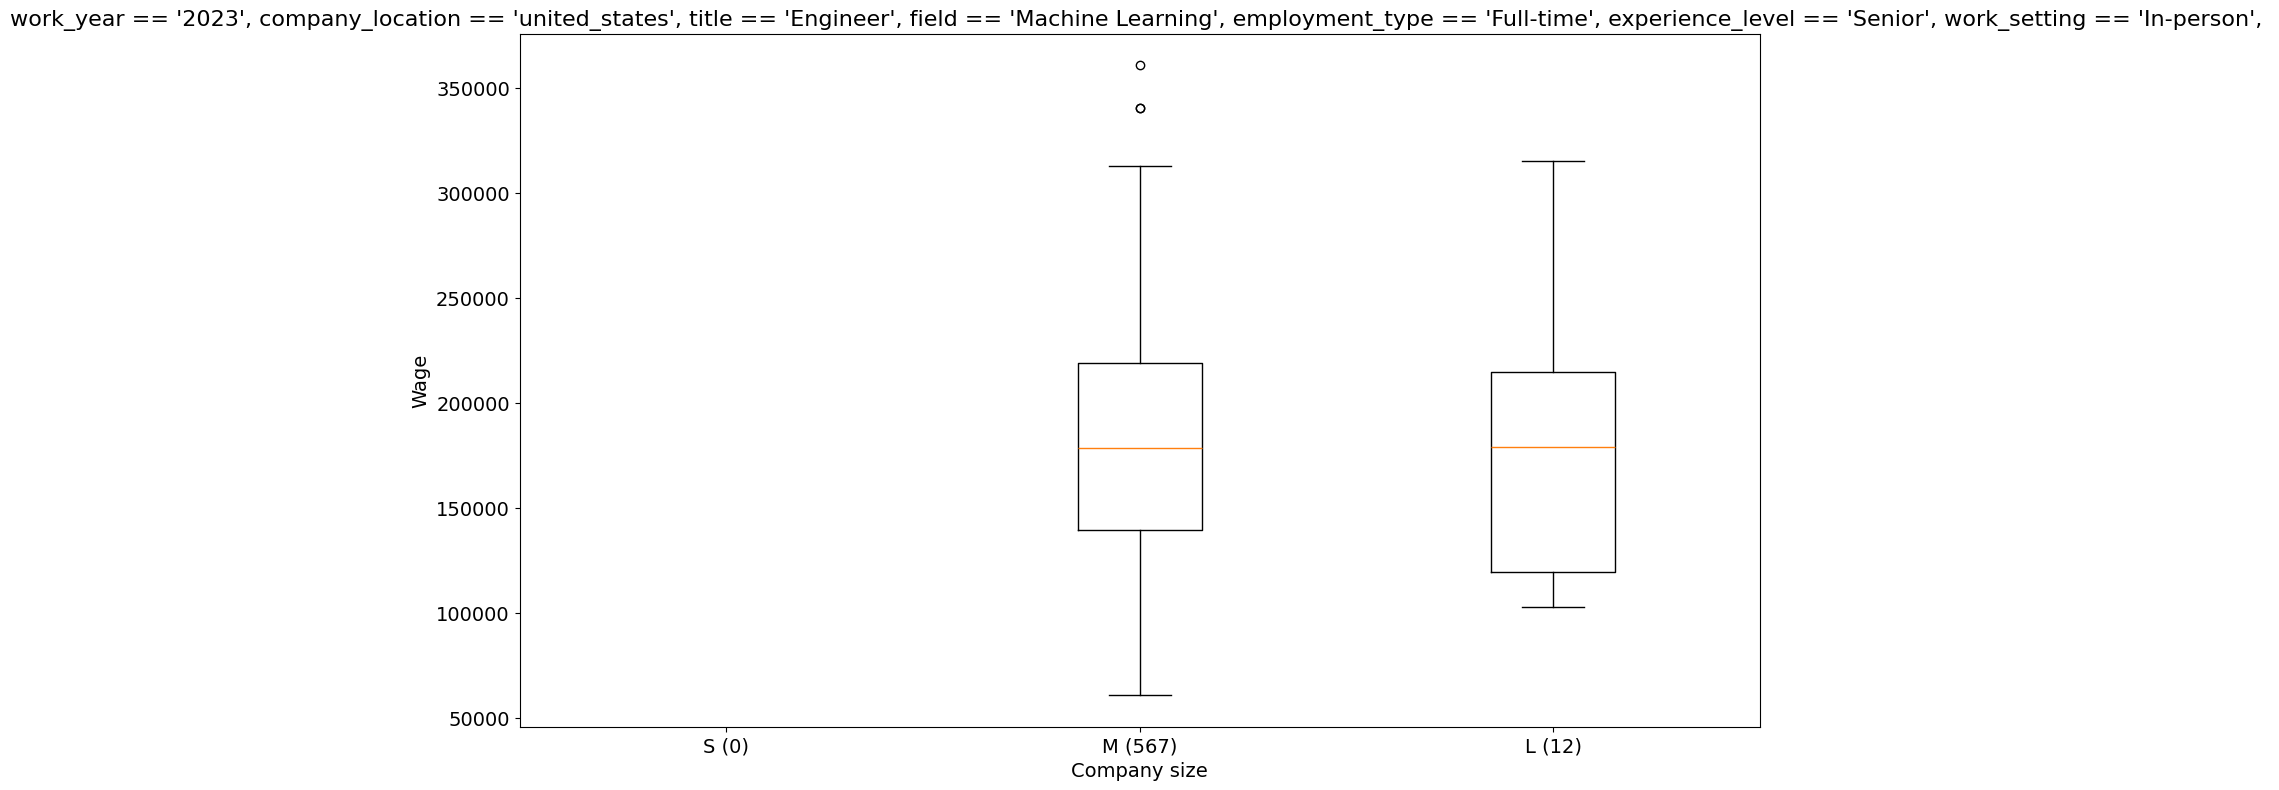

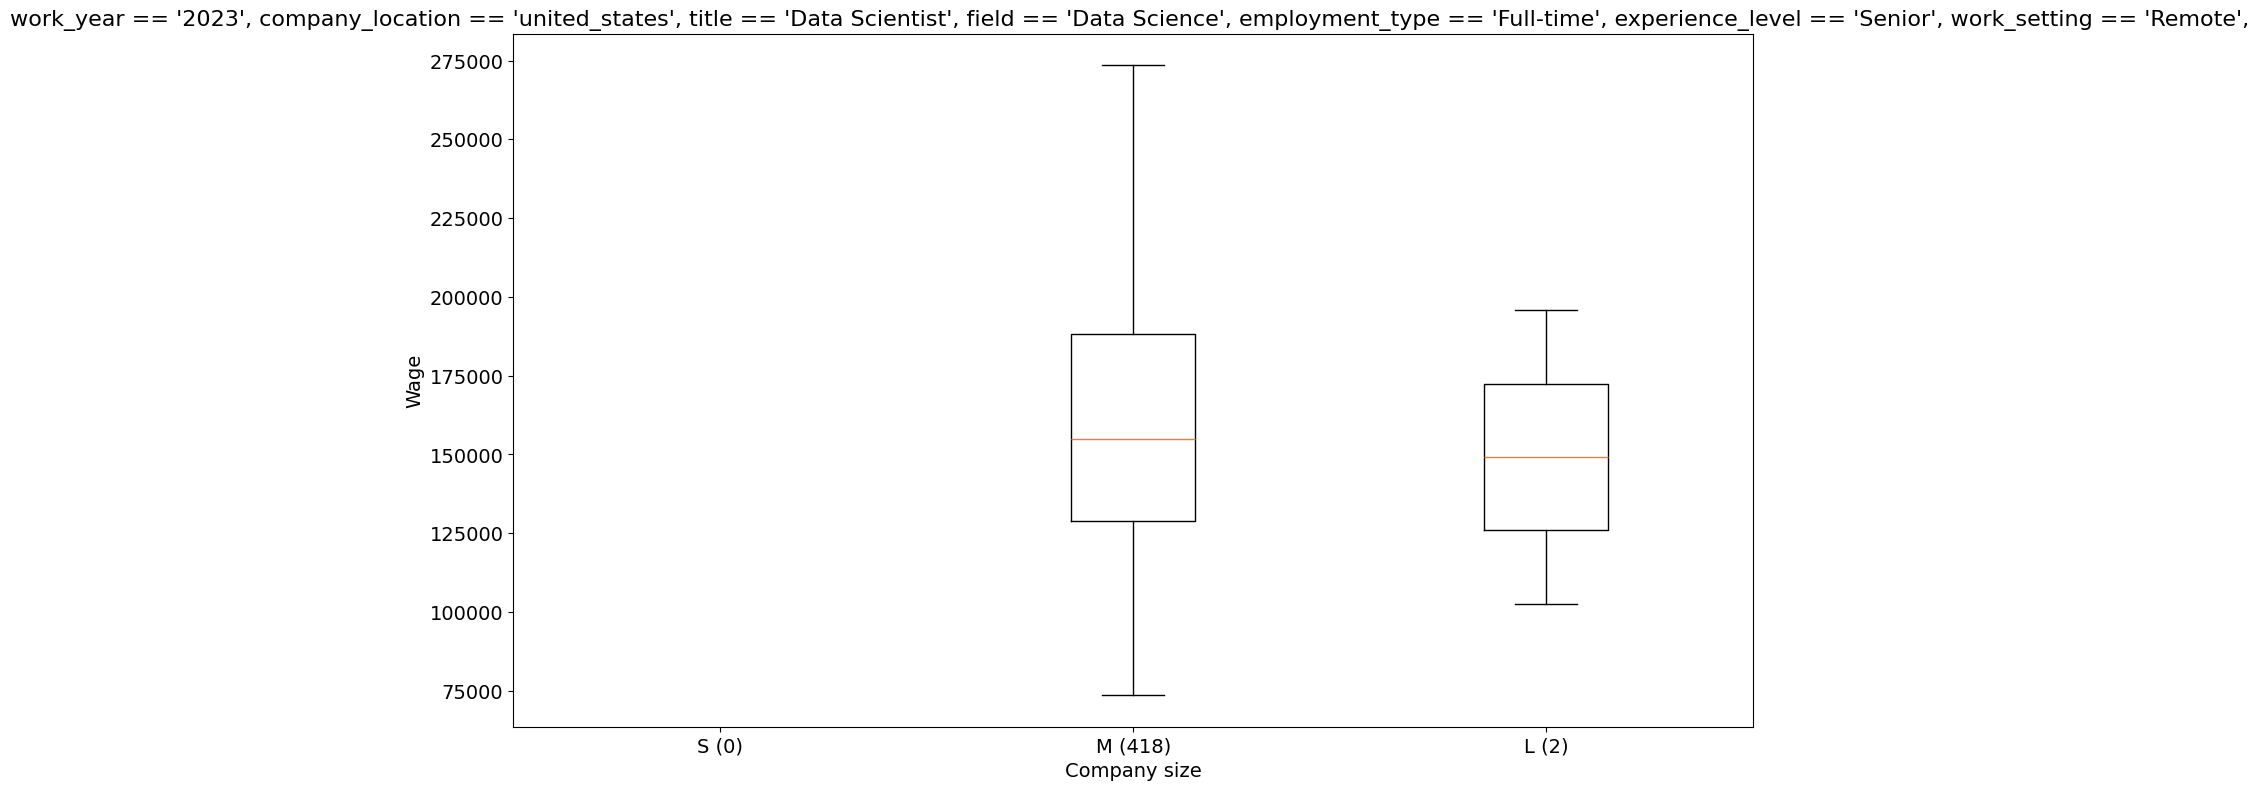

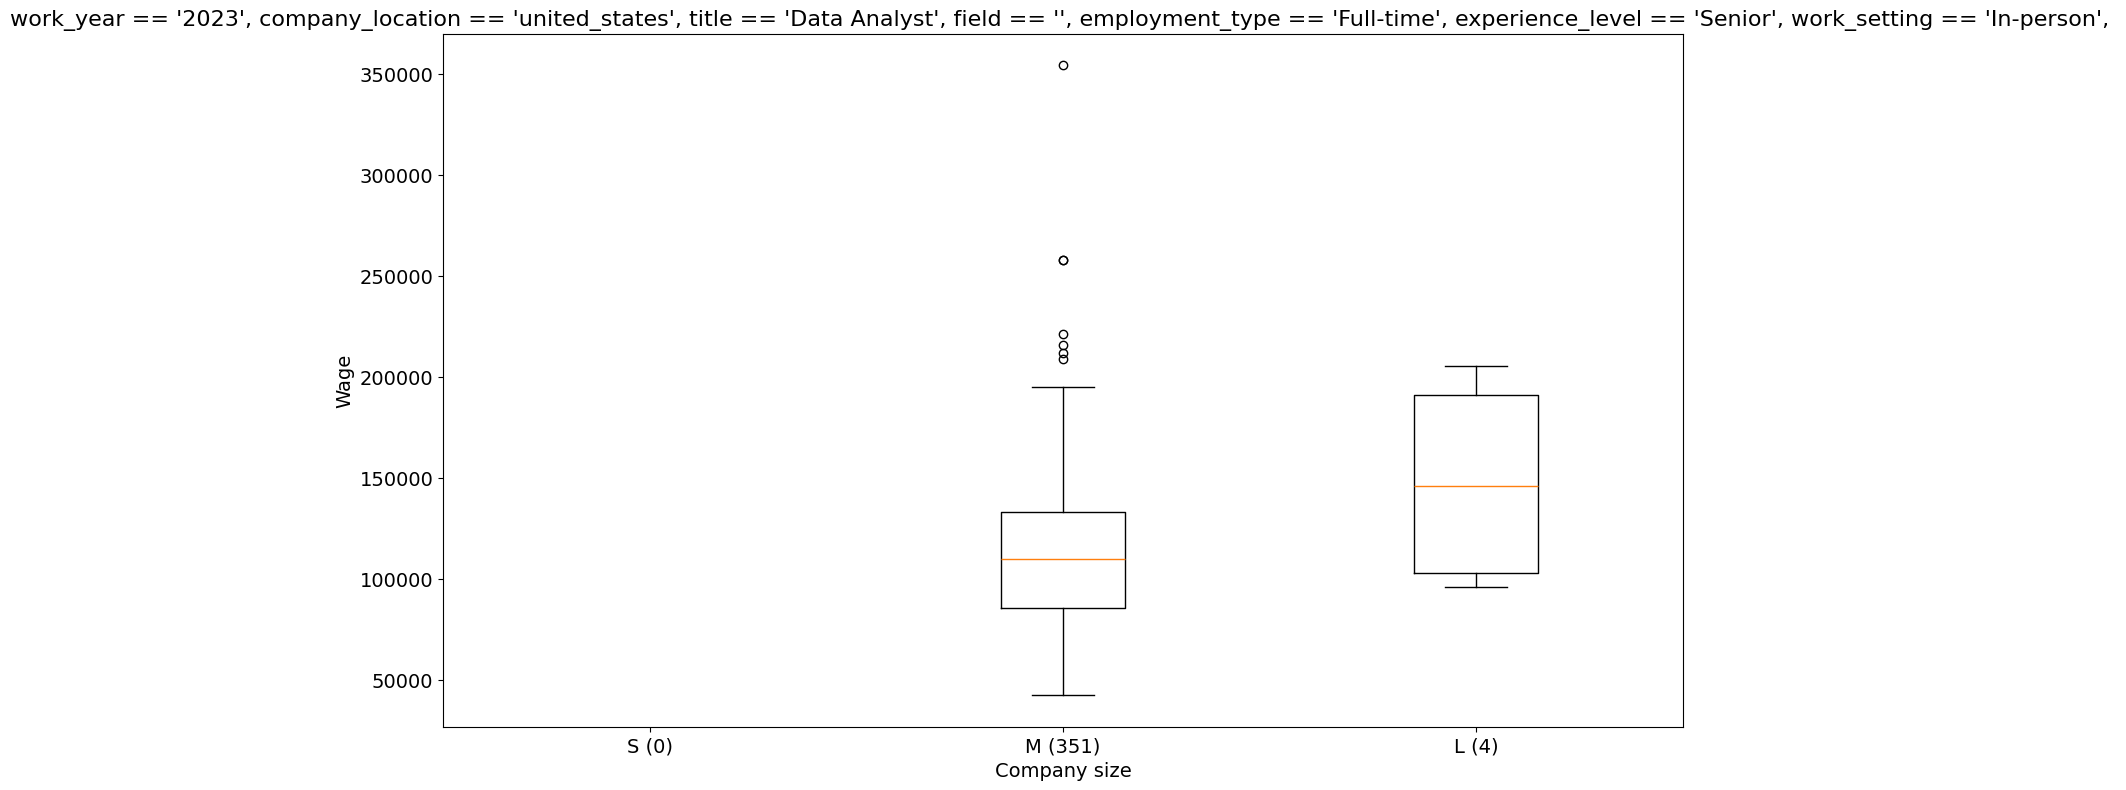

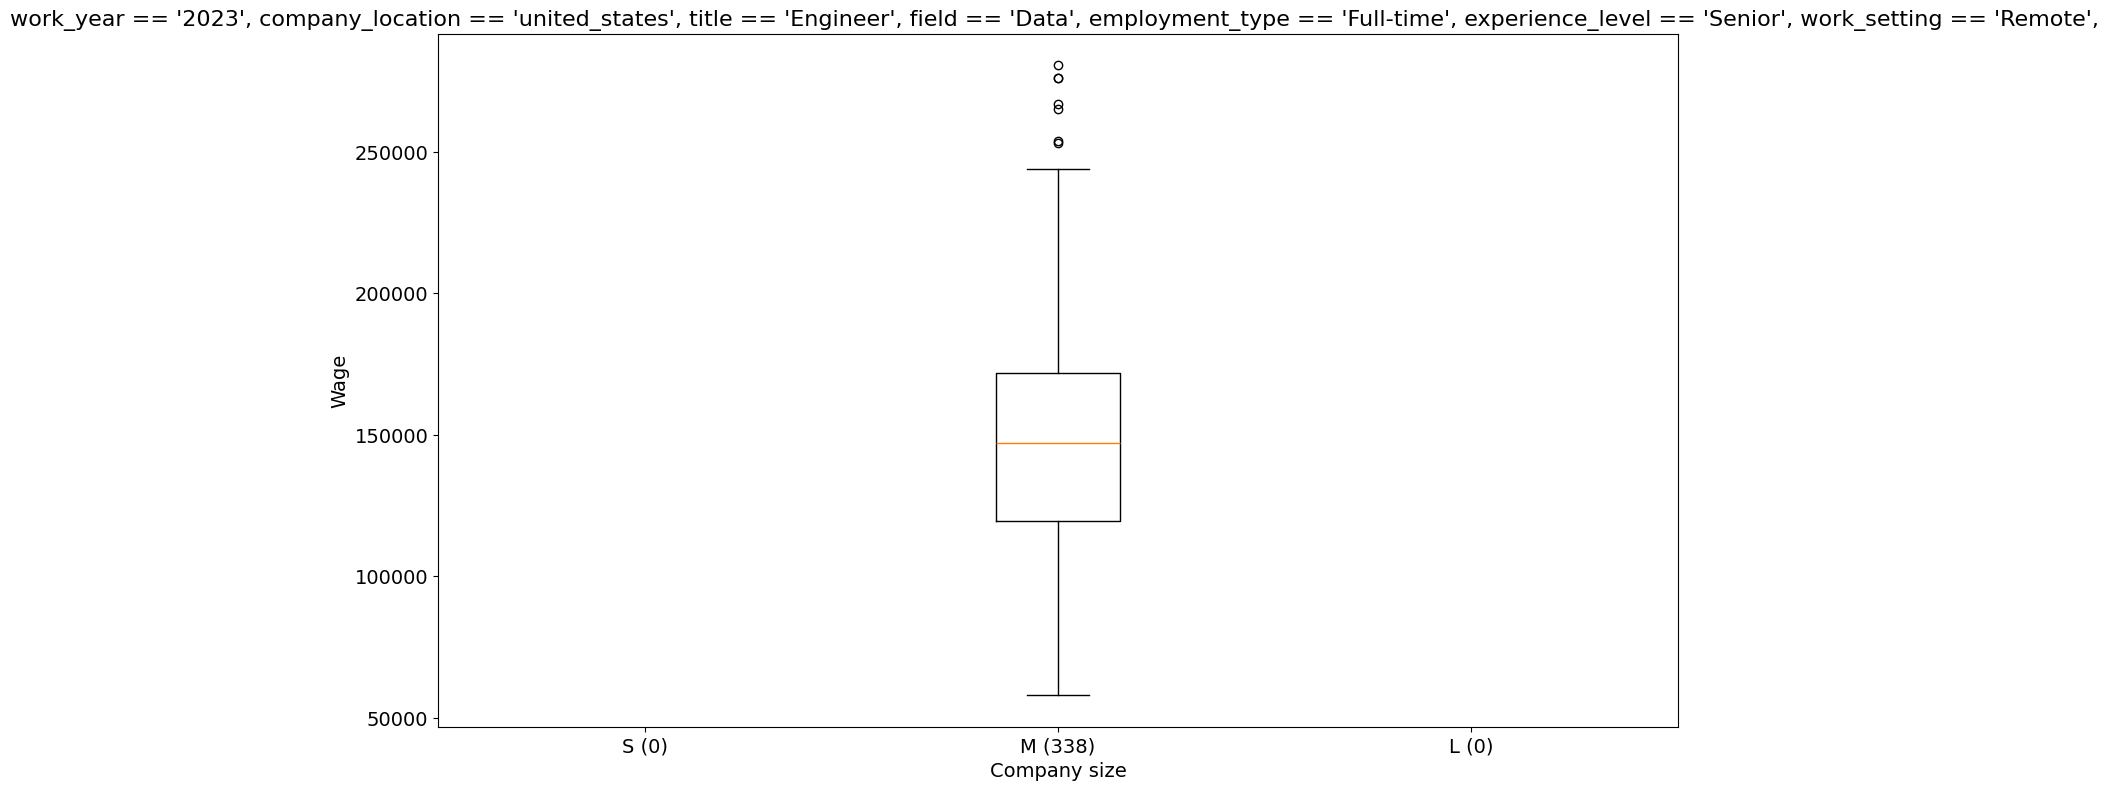

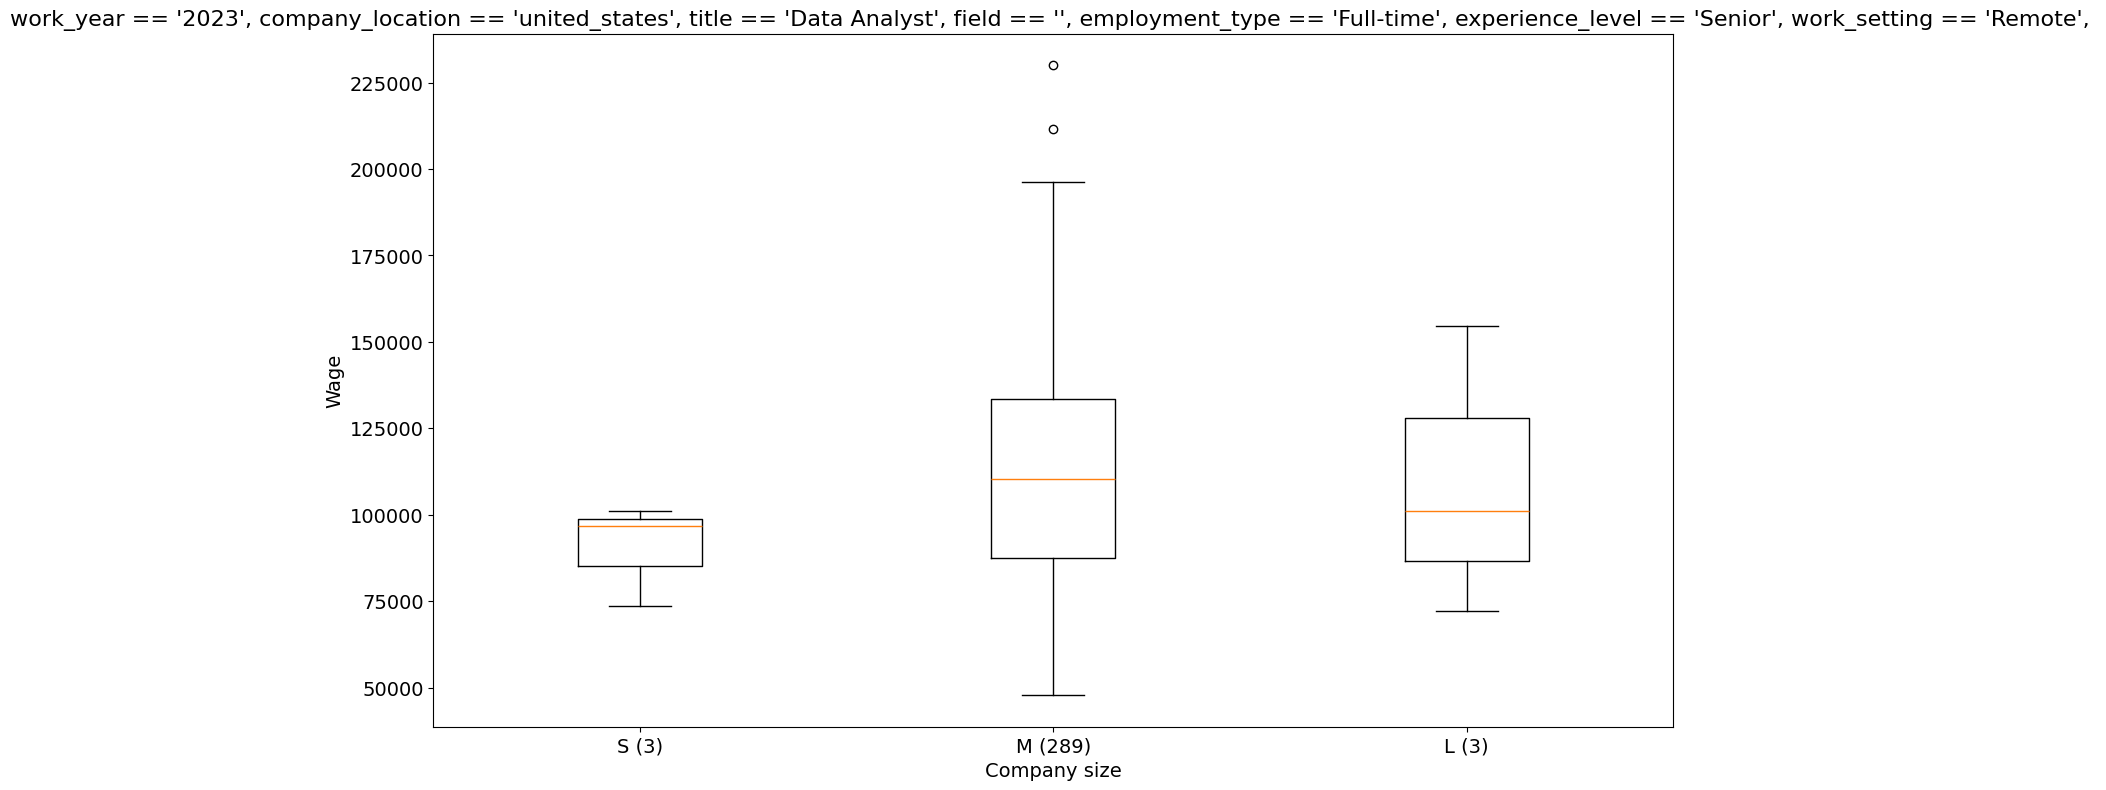

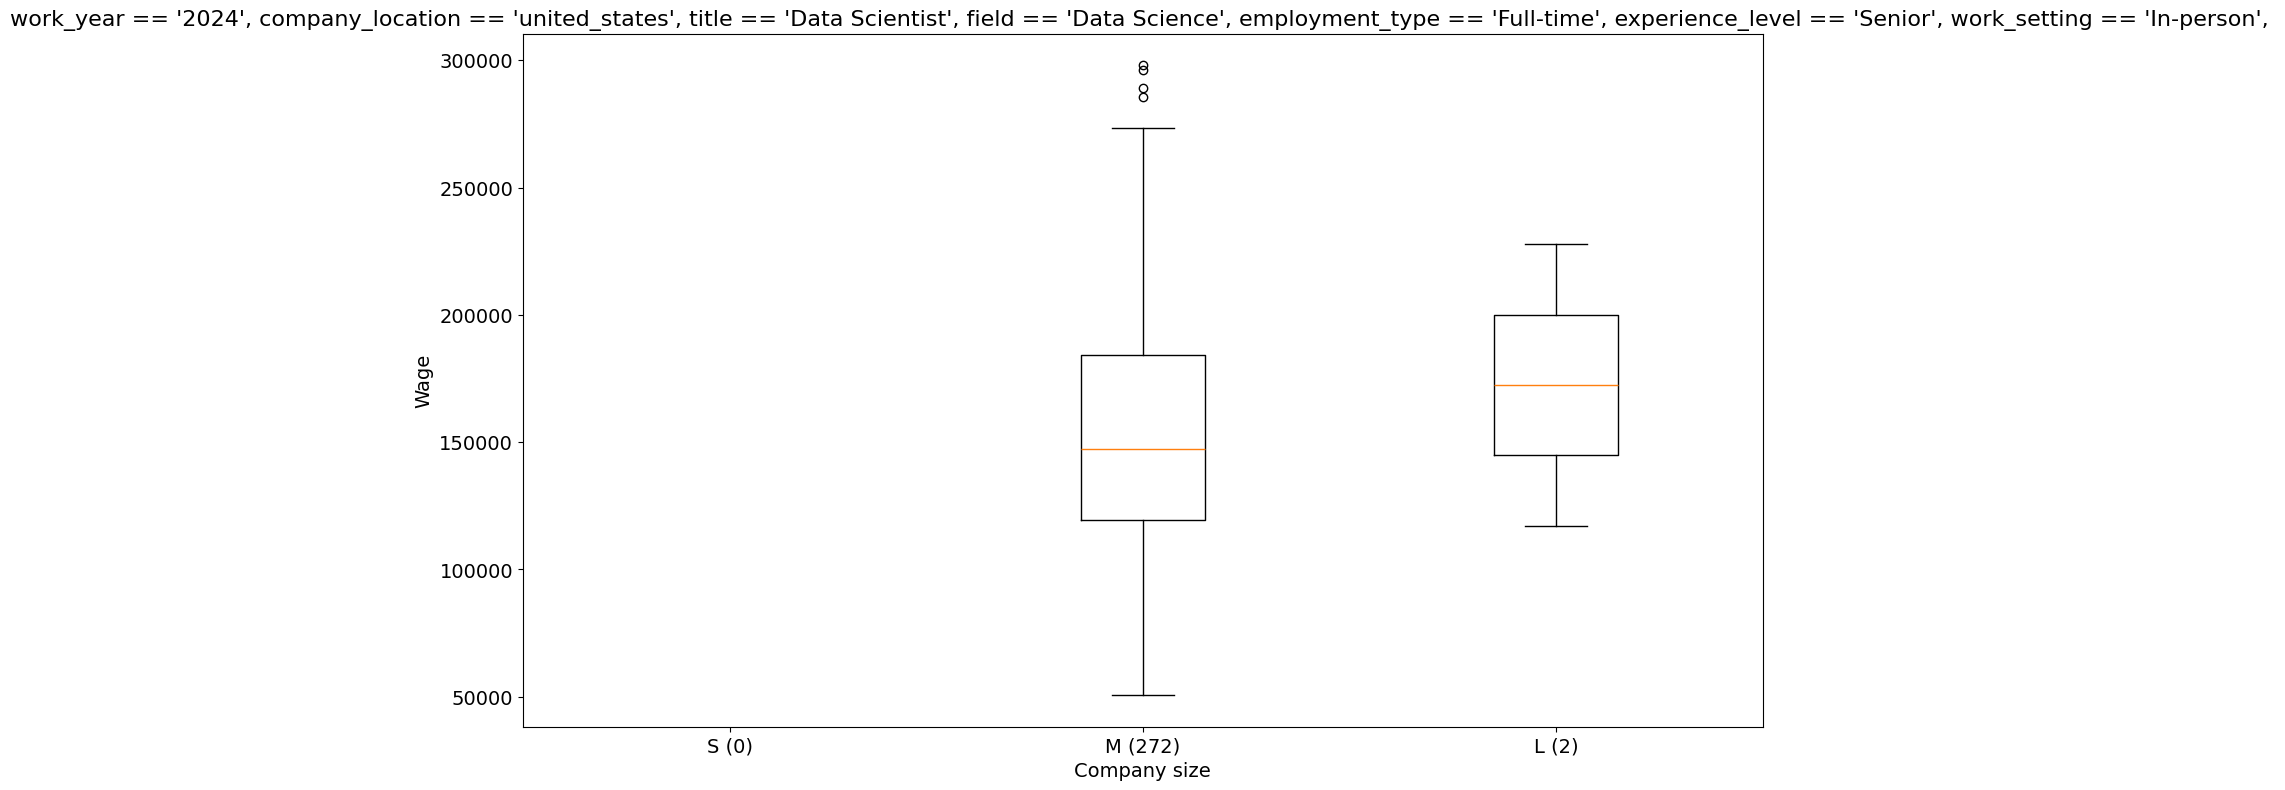

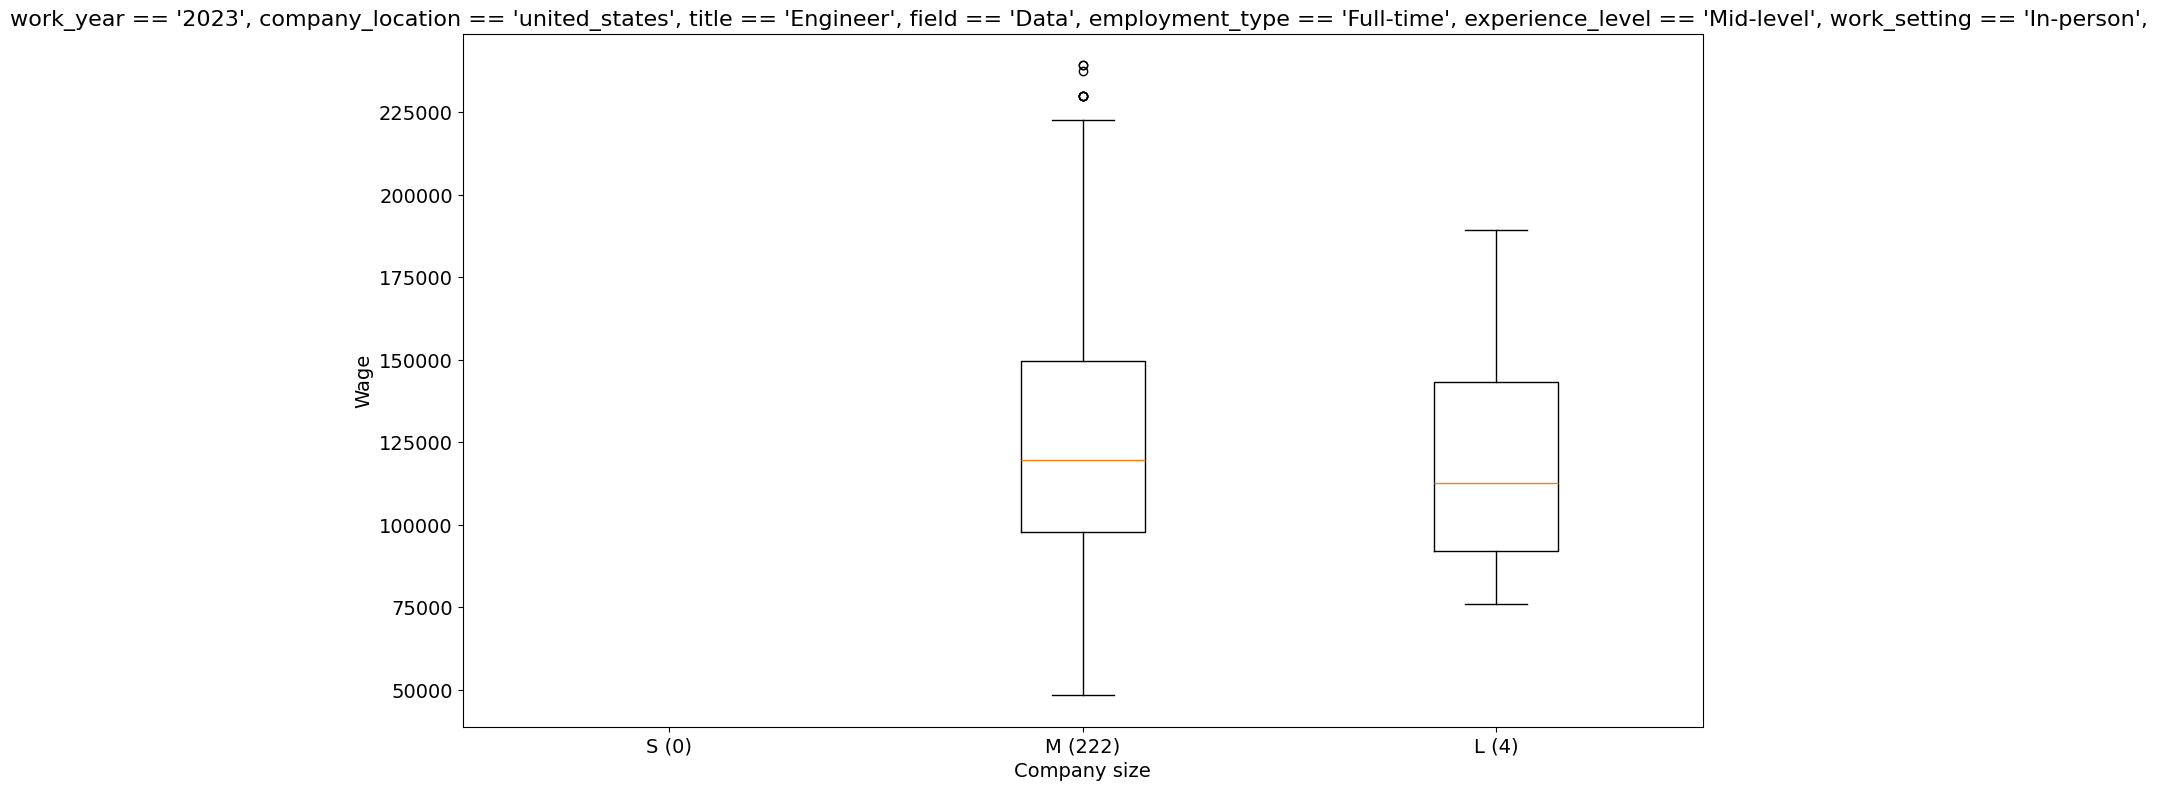

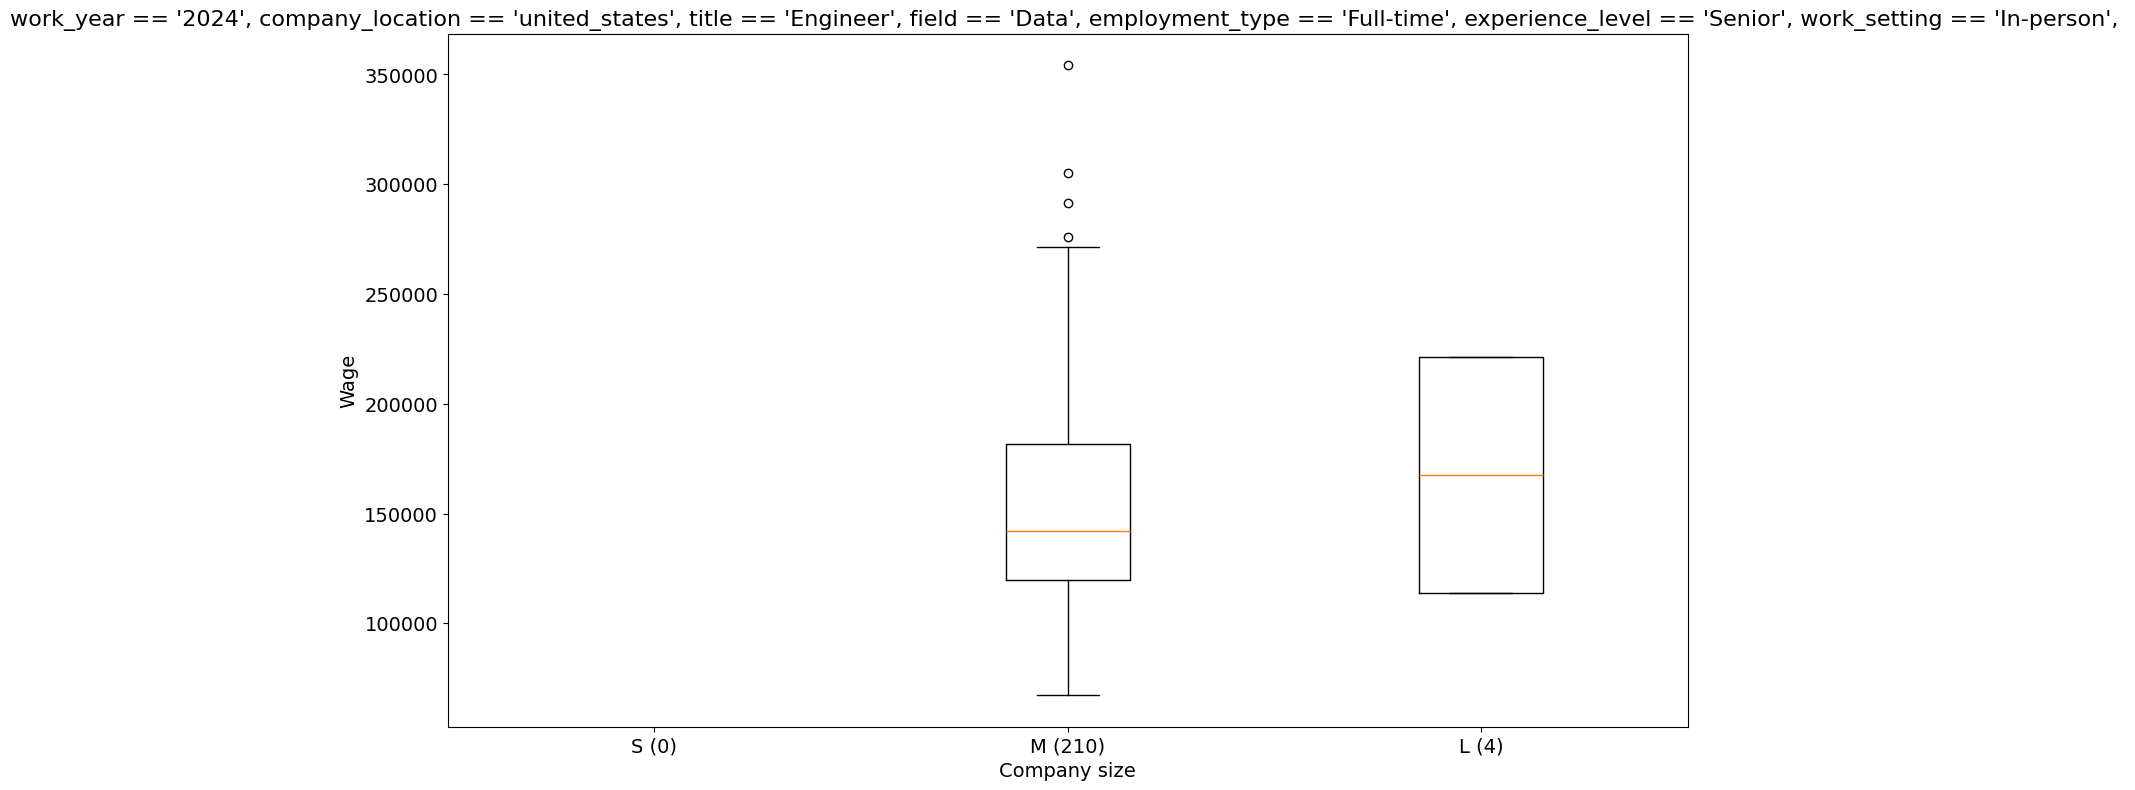

In [60]:
for i in range(0, 10): 
    #let's inspect the top 10 clusters with the most entries according to our constraints set at the start of step 6.5.
    [subset, title] = h.query_main_dataframe(i, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()
    


so far I'm not convinced that the company size is an important factor - there seems to be a very irregular patter in here with sometimes the Large companies paying the best, other times, Small or Medium sized companies paying the best. We'll conclude this subquestion with a random search of the dataset to see if this statement holds truth outside the top ten! The constraint for this to be meaningful is that there should be at least a hundred listings (number pulled out of thin air)

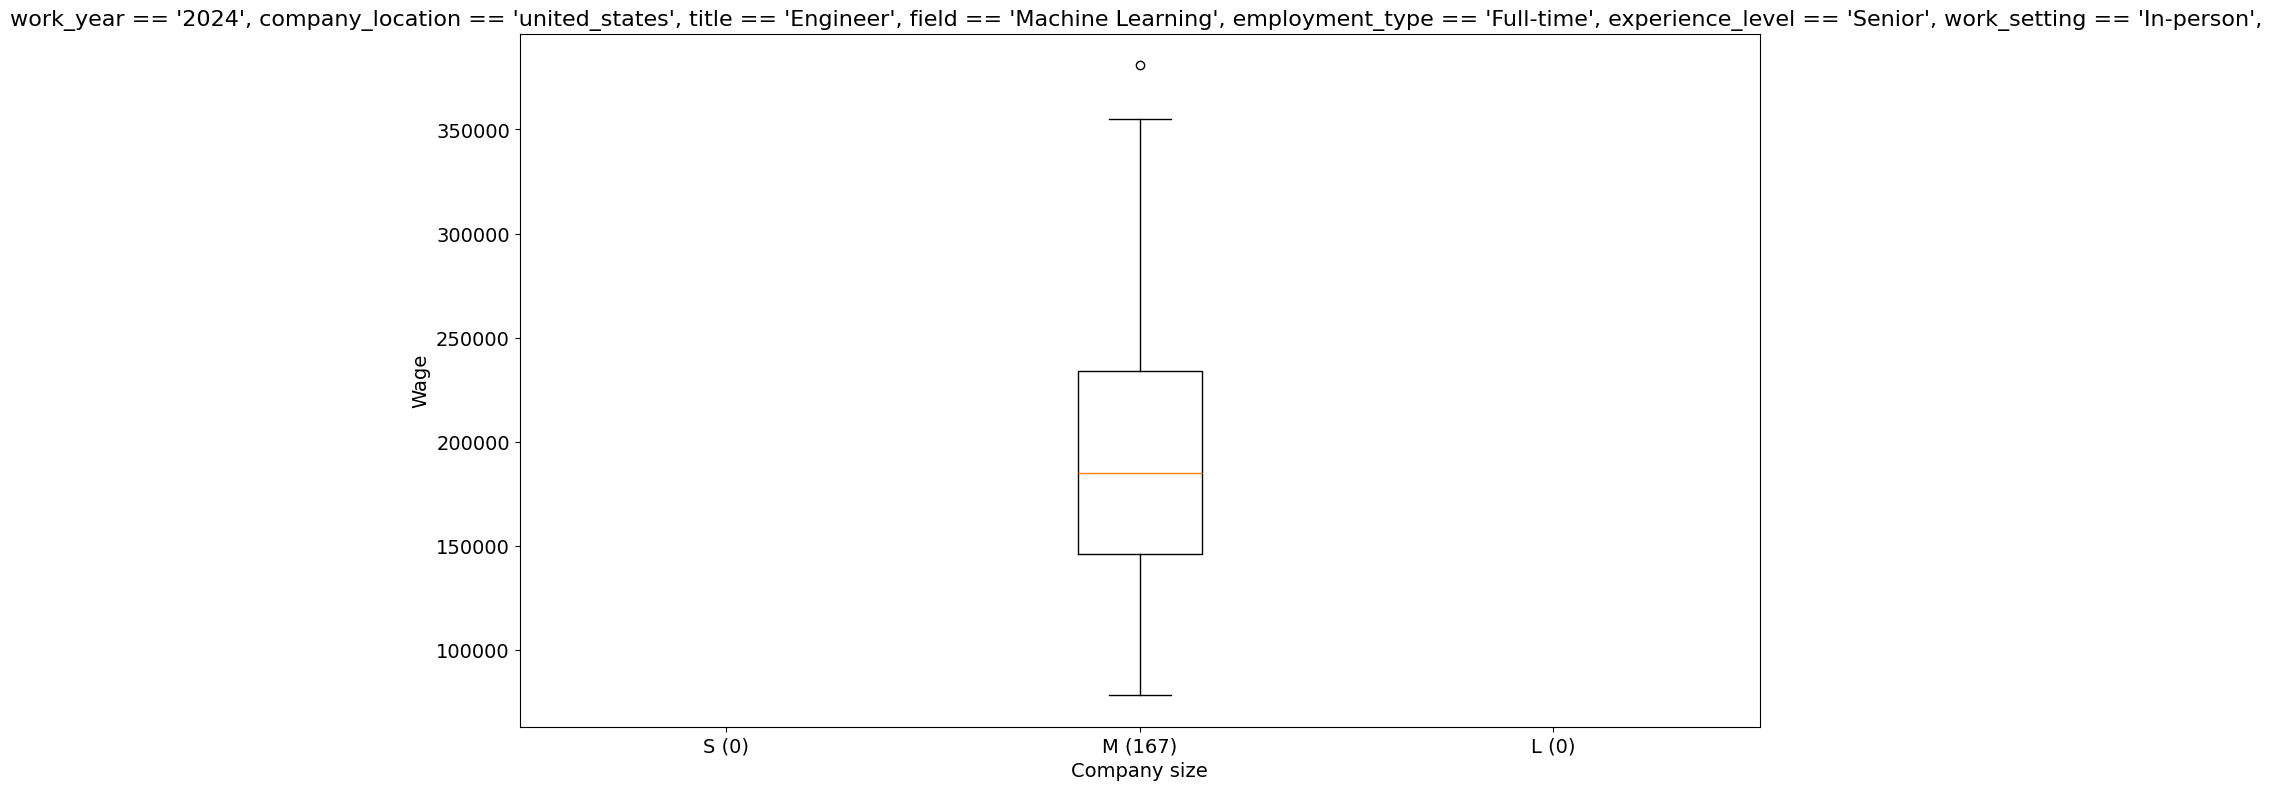

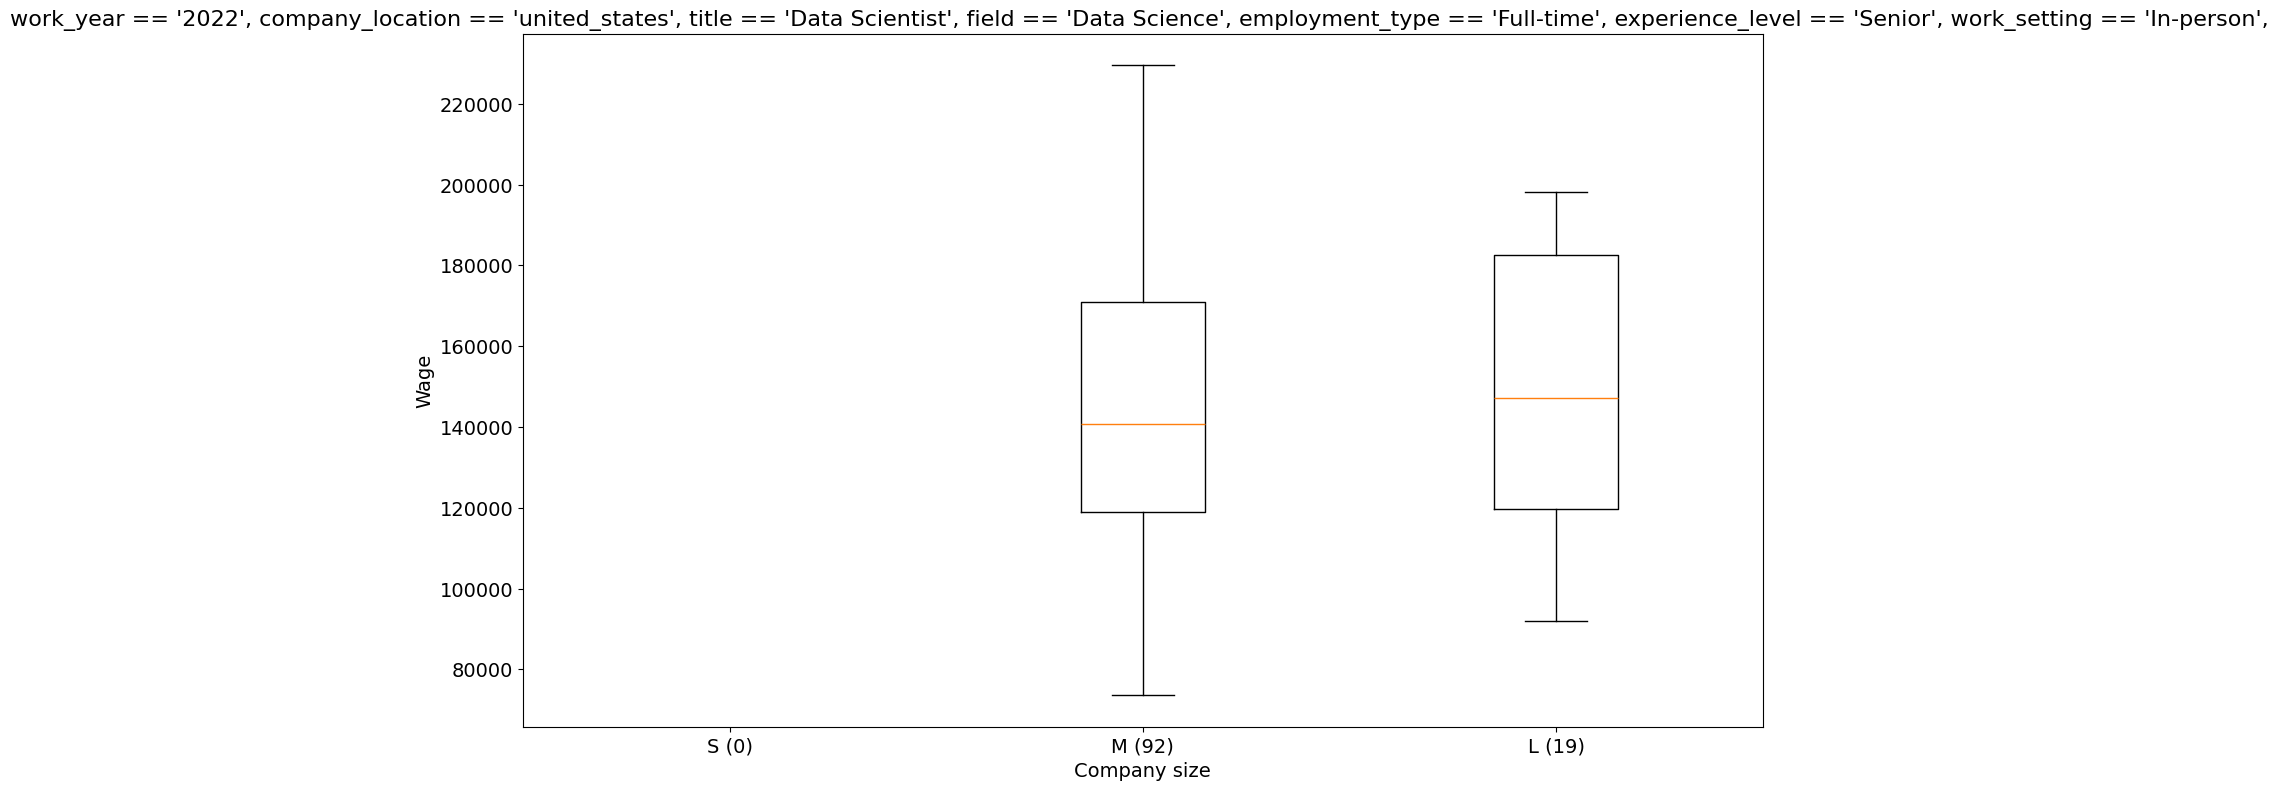

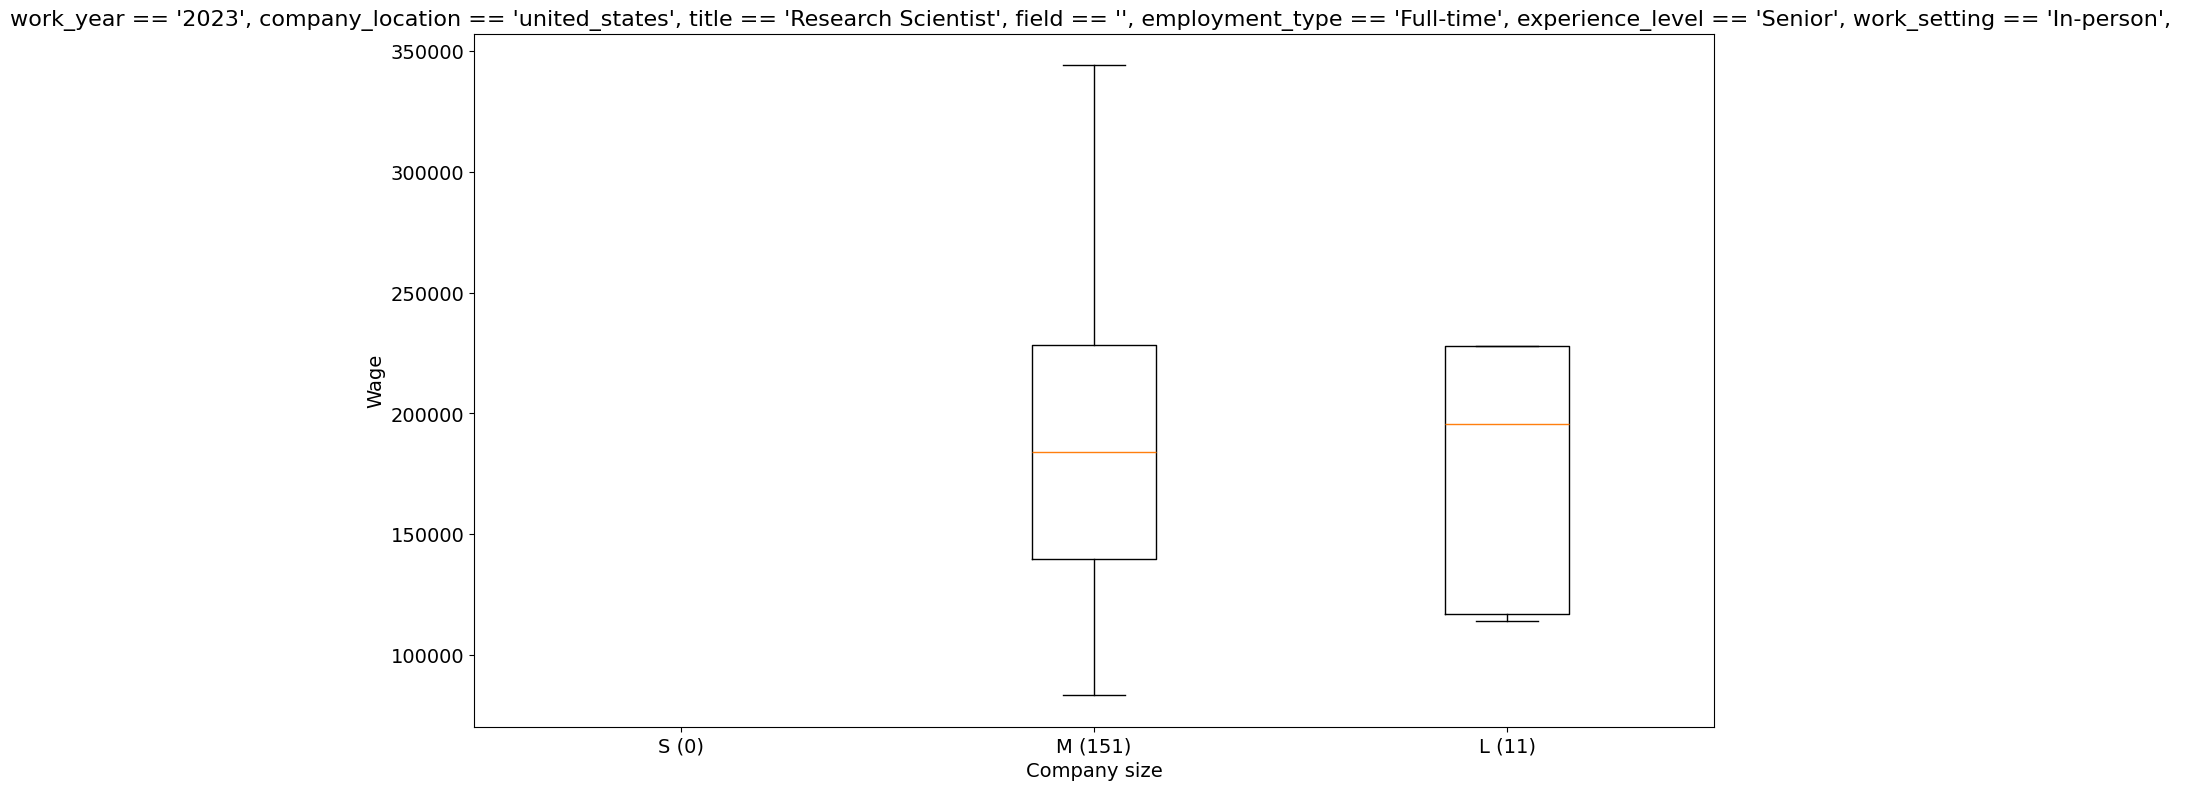

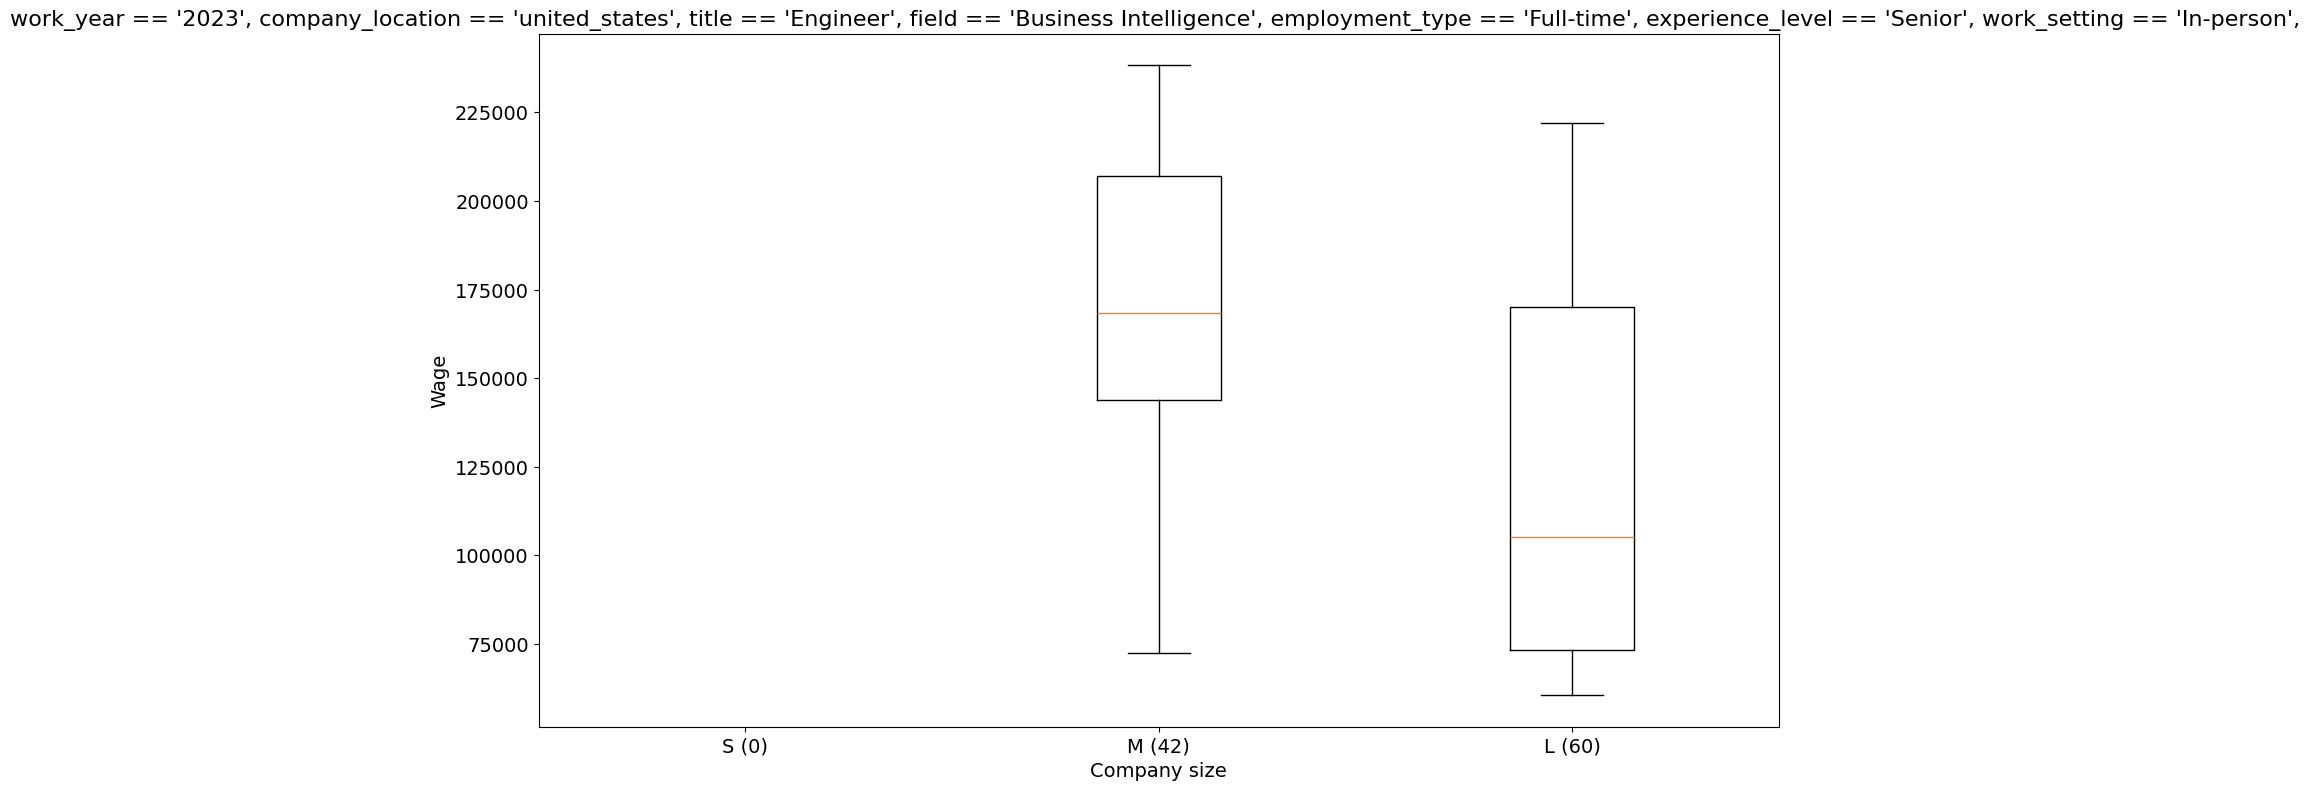

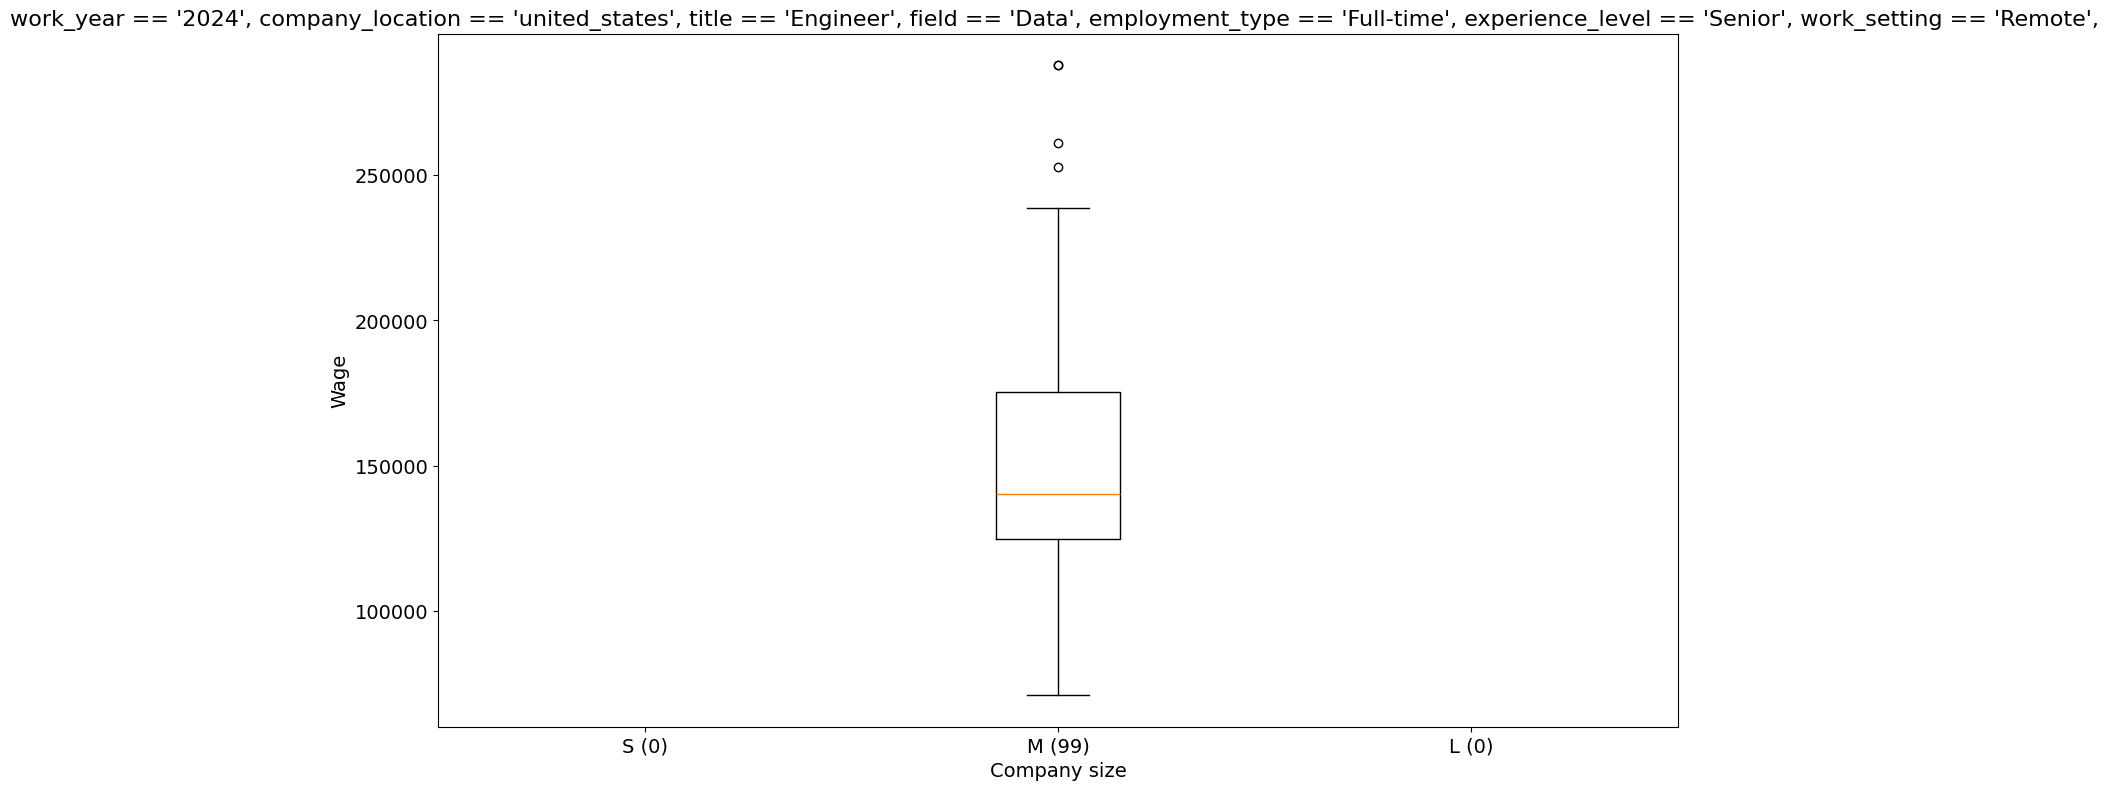

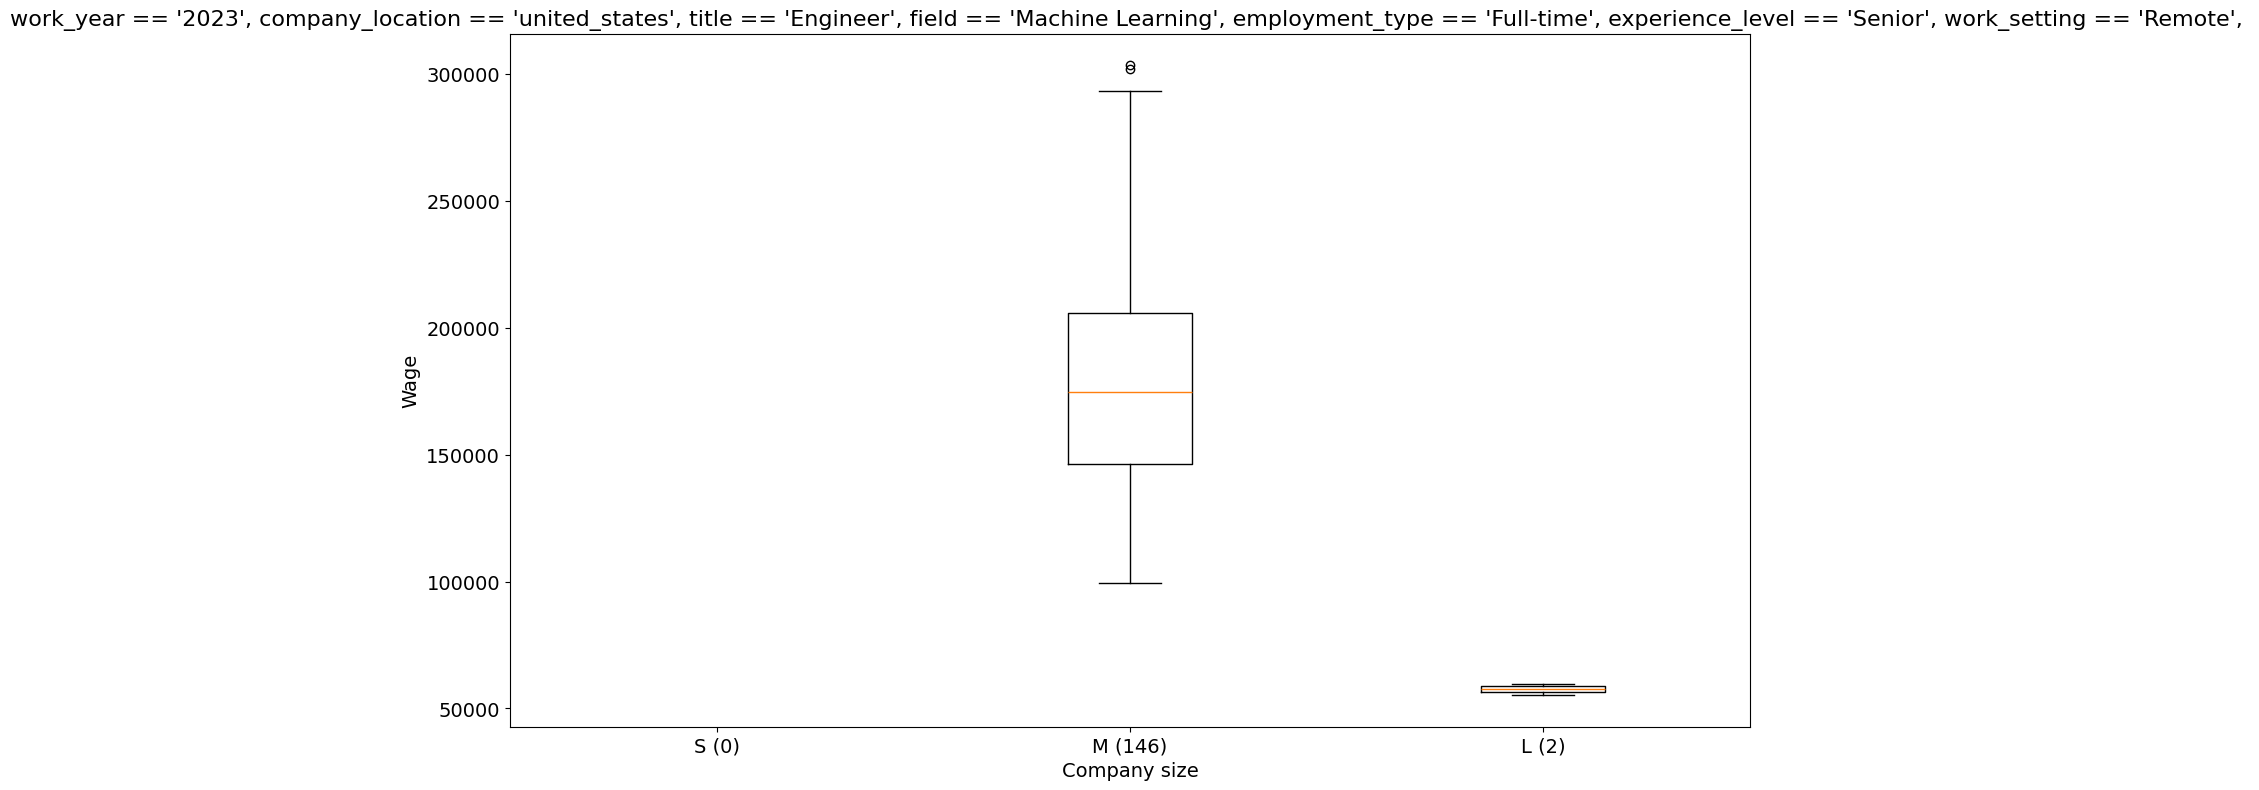

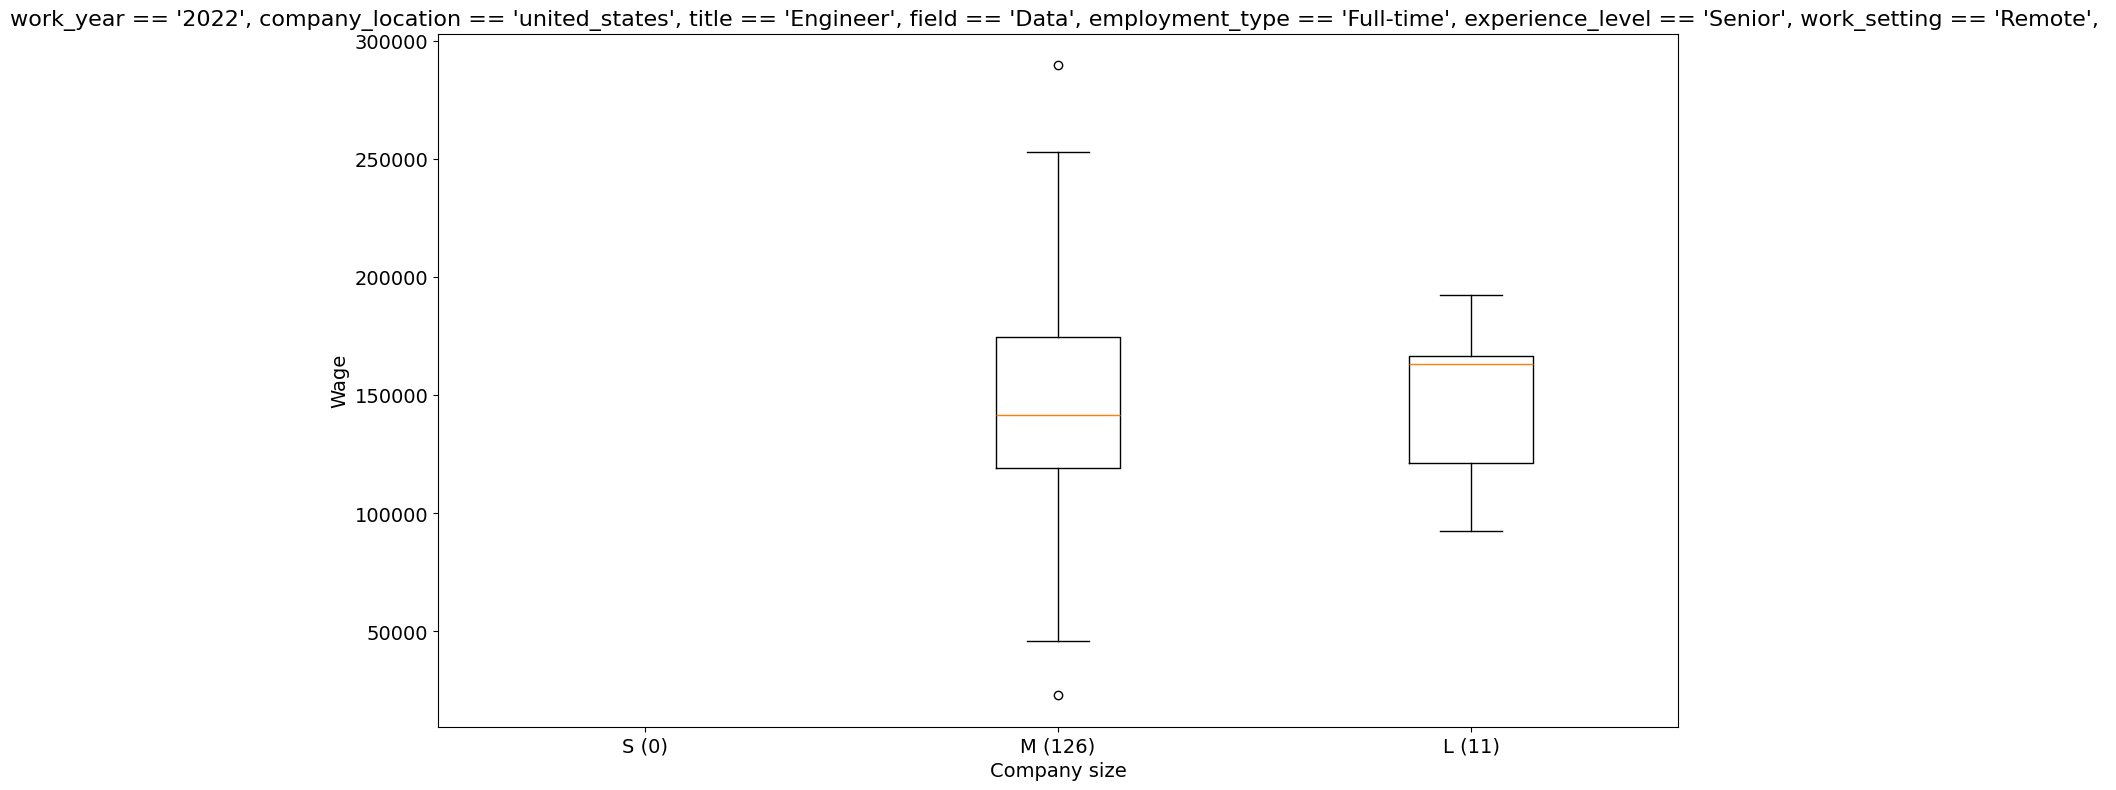

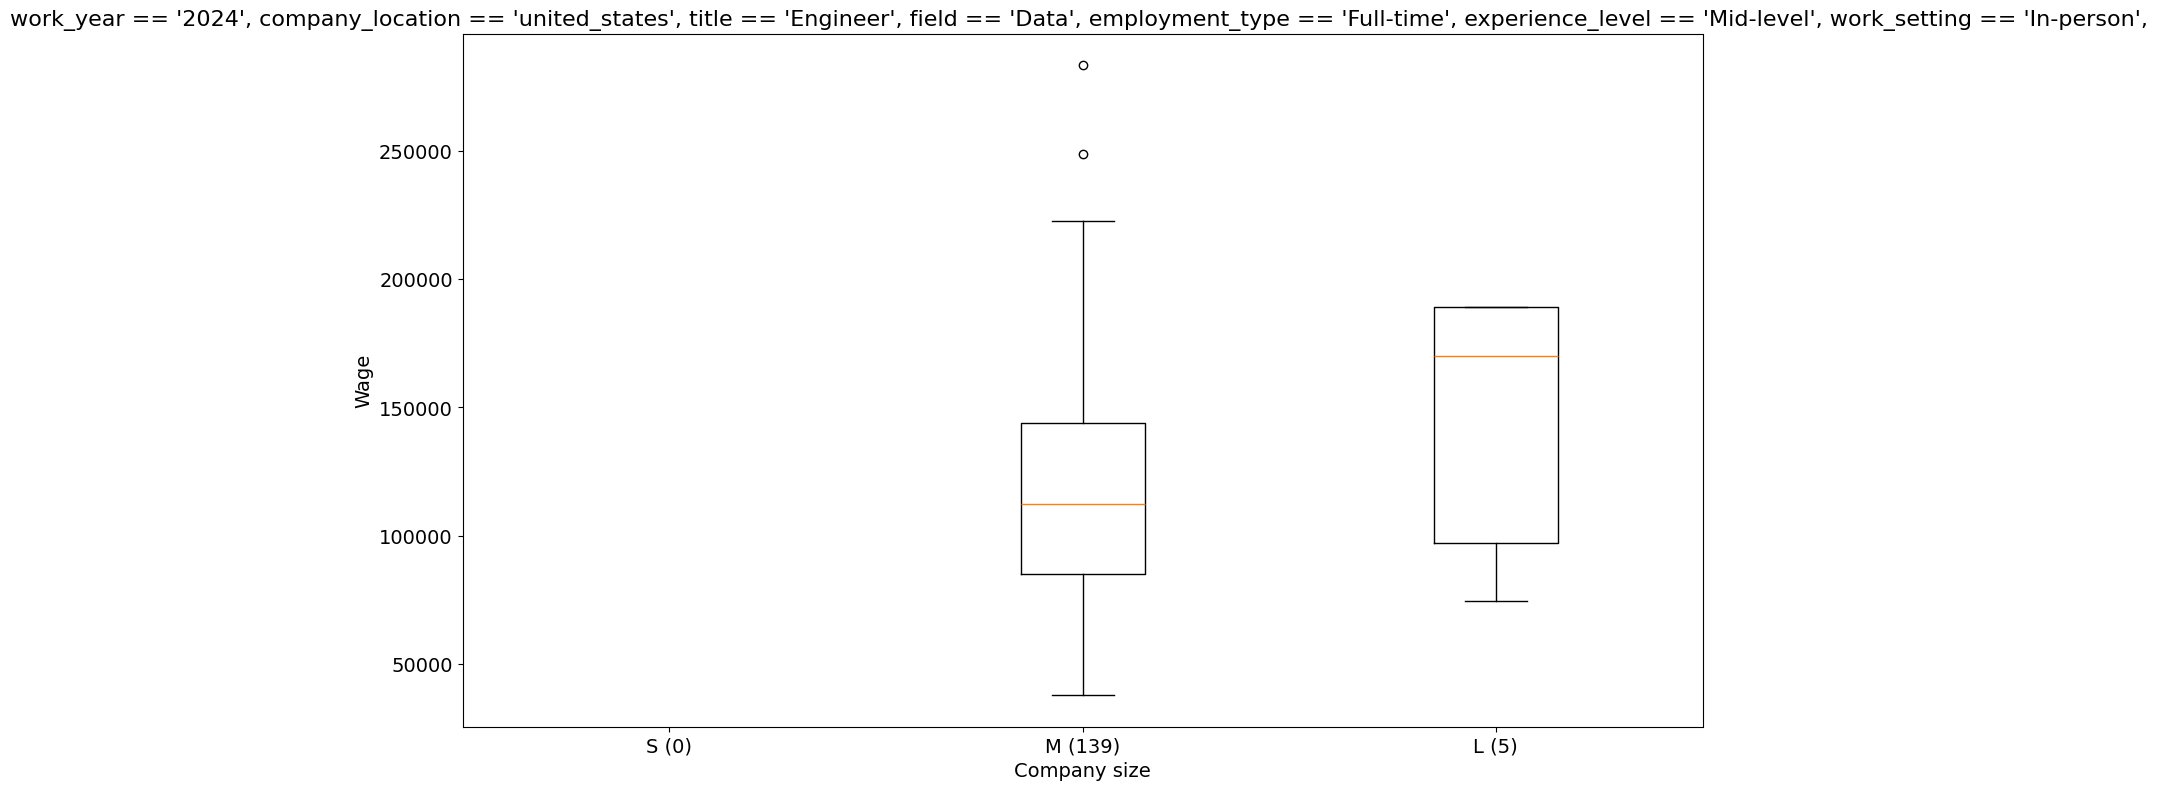

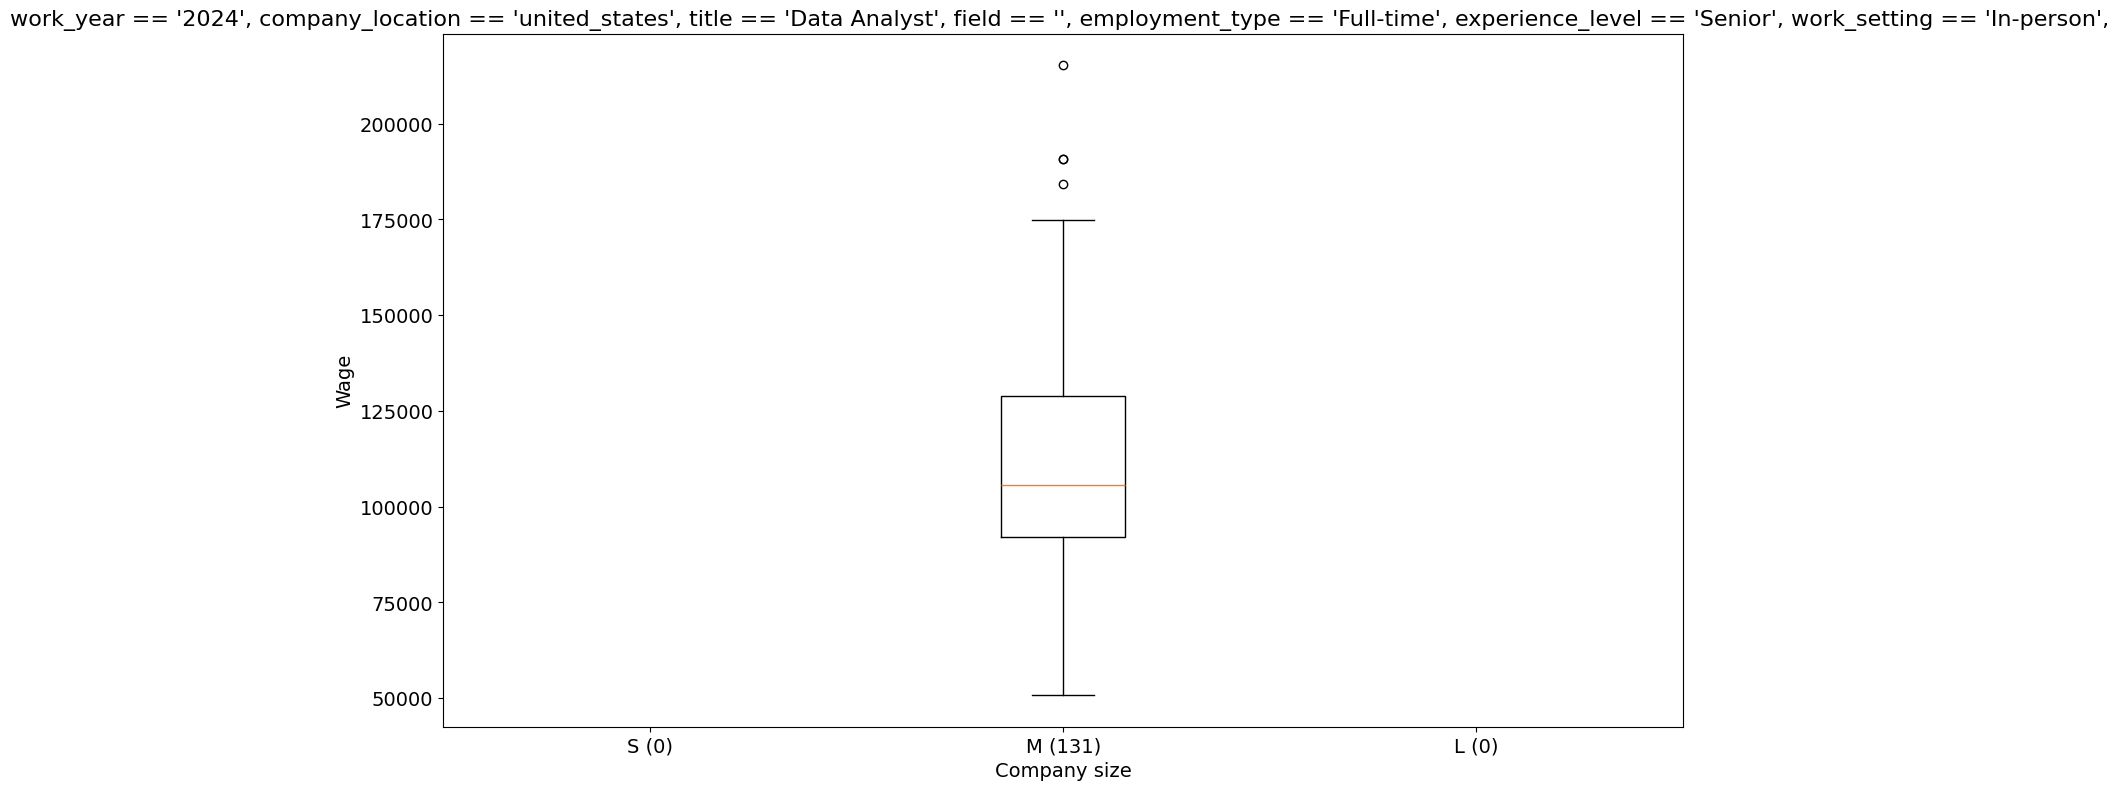

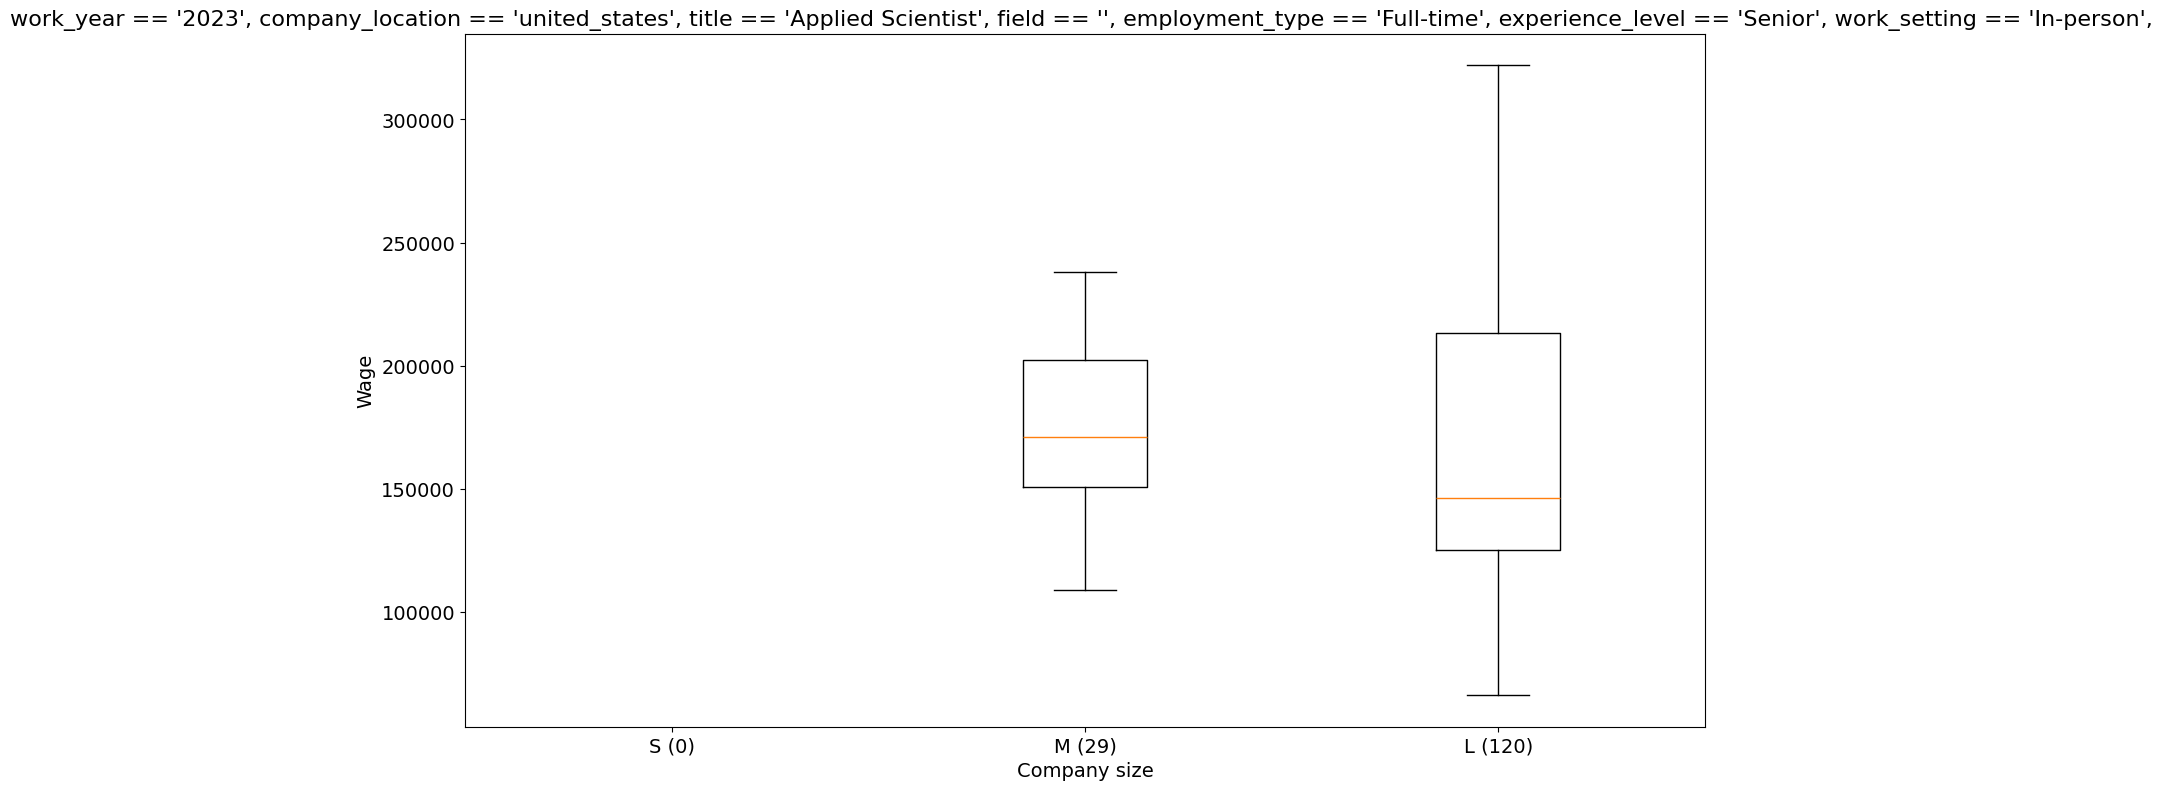

In [61]:
min_listings = 100
lmax = len(clusters.query("count>=@min_listings"))
picked_rows = random.sample(range(10, lmax+1), 10)
for row in picked_rows: 
    [subset, title] = h.query_main_dataframe(row, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

Outside the top ten of clustered listings we see a similar truth - company size is not as strong of a factor as initially thought. Plotting the boxplots shows a high irregularity between specific function/field... factors and company size. There's no consistent order where the for example small companies always pay better than large companies. As such we might consider ommitting this feature from a predictive model. We can use Catboost's feature importance to confirm if this is a good idea.

## 6.6 Experience level vs Wage
This is in essence a repeat question of 6.5 with different query parameters. Helper functions are written in such a way that the code can be reused by passing an extra parameter. 

In [62]:
key_for_question = 'experience_level'
clusters = h.make_clusters(df_processed, groupbykeys, key_for_question)
clusters.head(5)

work_year company_location           title             field employment_type company_size work_setting  count
763       2023    united_states        Engineer              Data       Full-time            M    In-person   1042
729       2023    united_states  Data Scientist      Data Science       Full-time            M    In-person    864
787       2023    united_states        Engineer  Machine Learning       Full-time            M    In-person    641
713       2023    united_states    Data Analyst                         Full-time            M    In-person    590
730       2023    united_states  Data Scientist      Data Science       Full-time            M       Remote    485

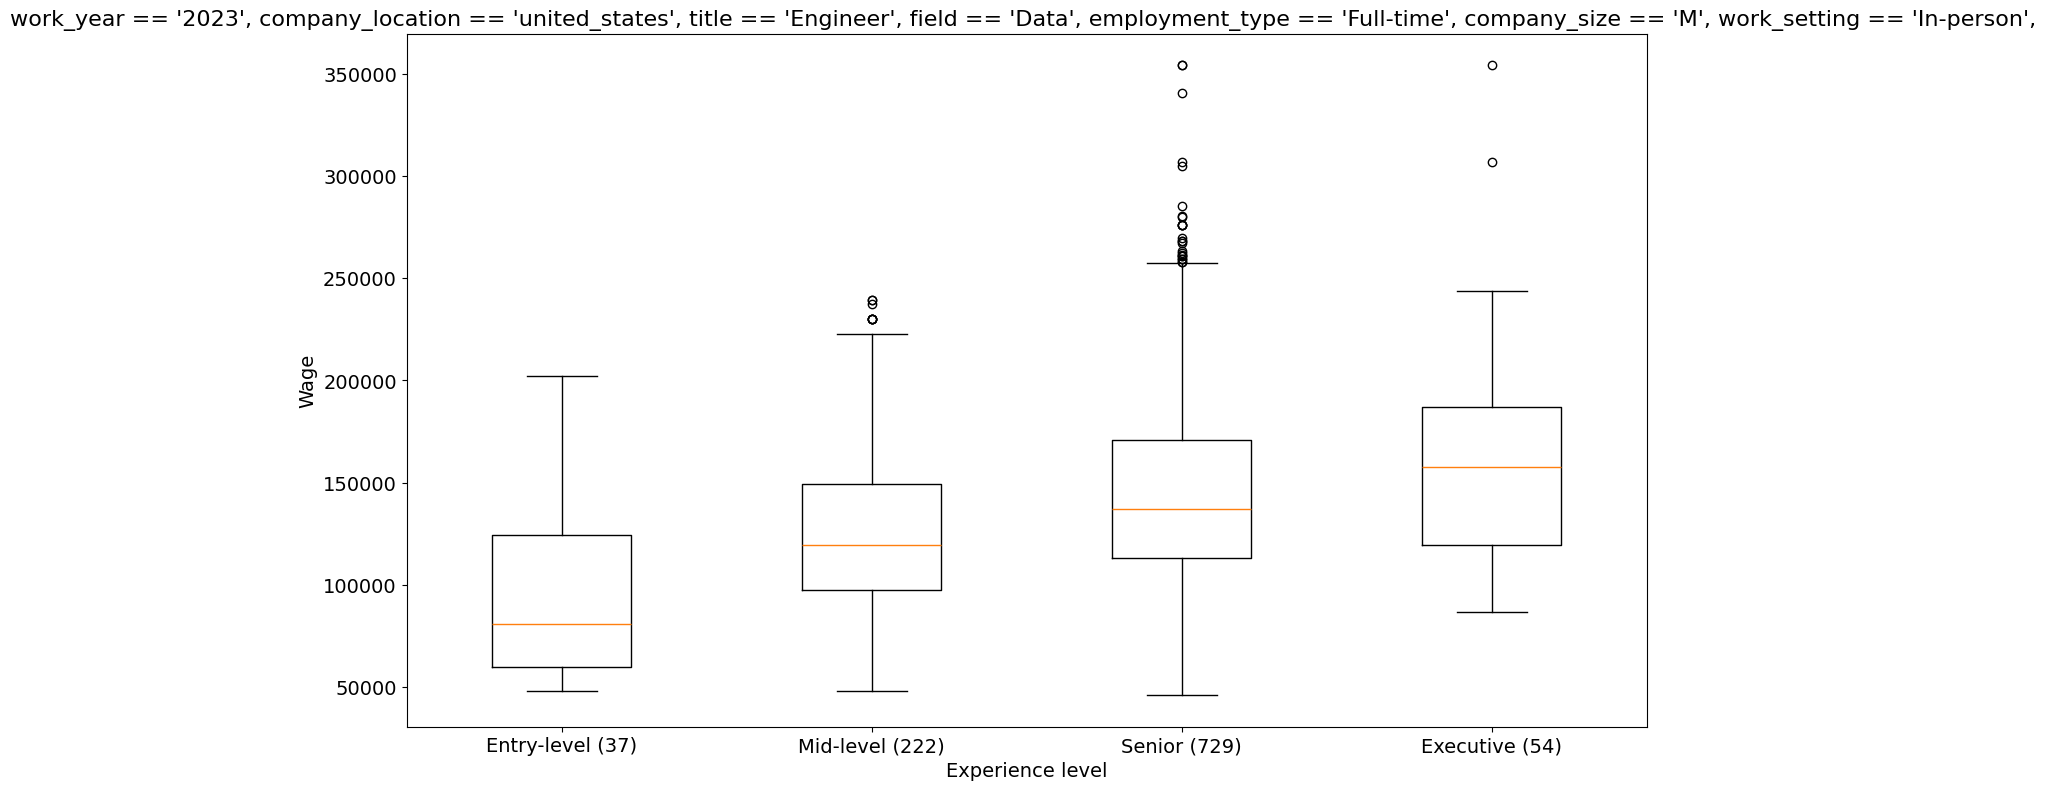

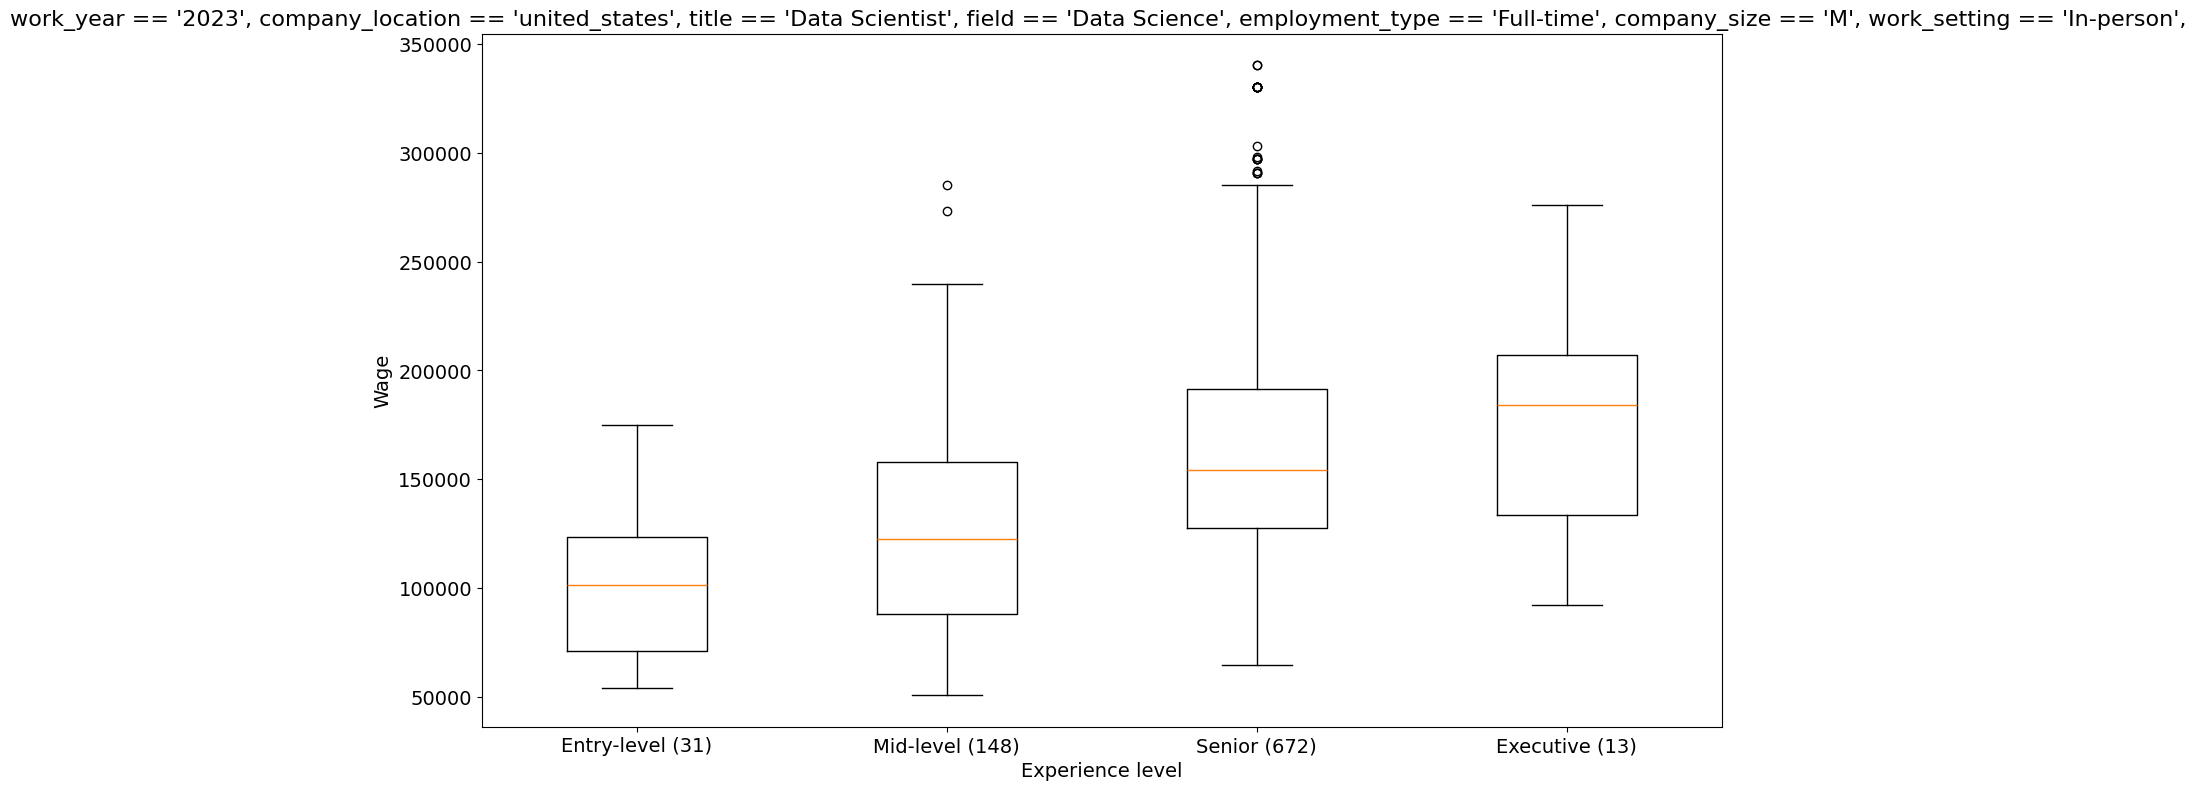

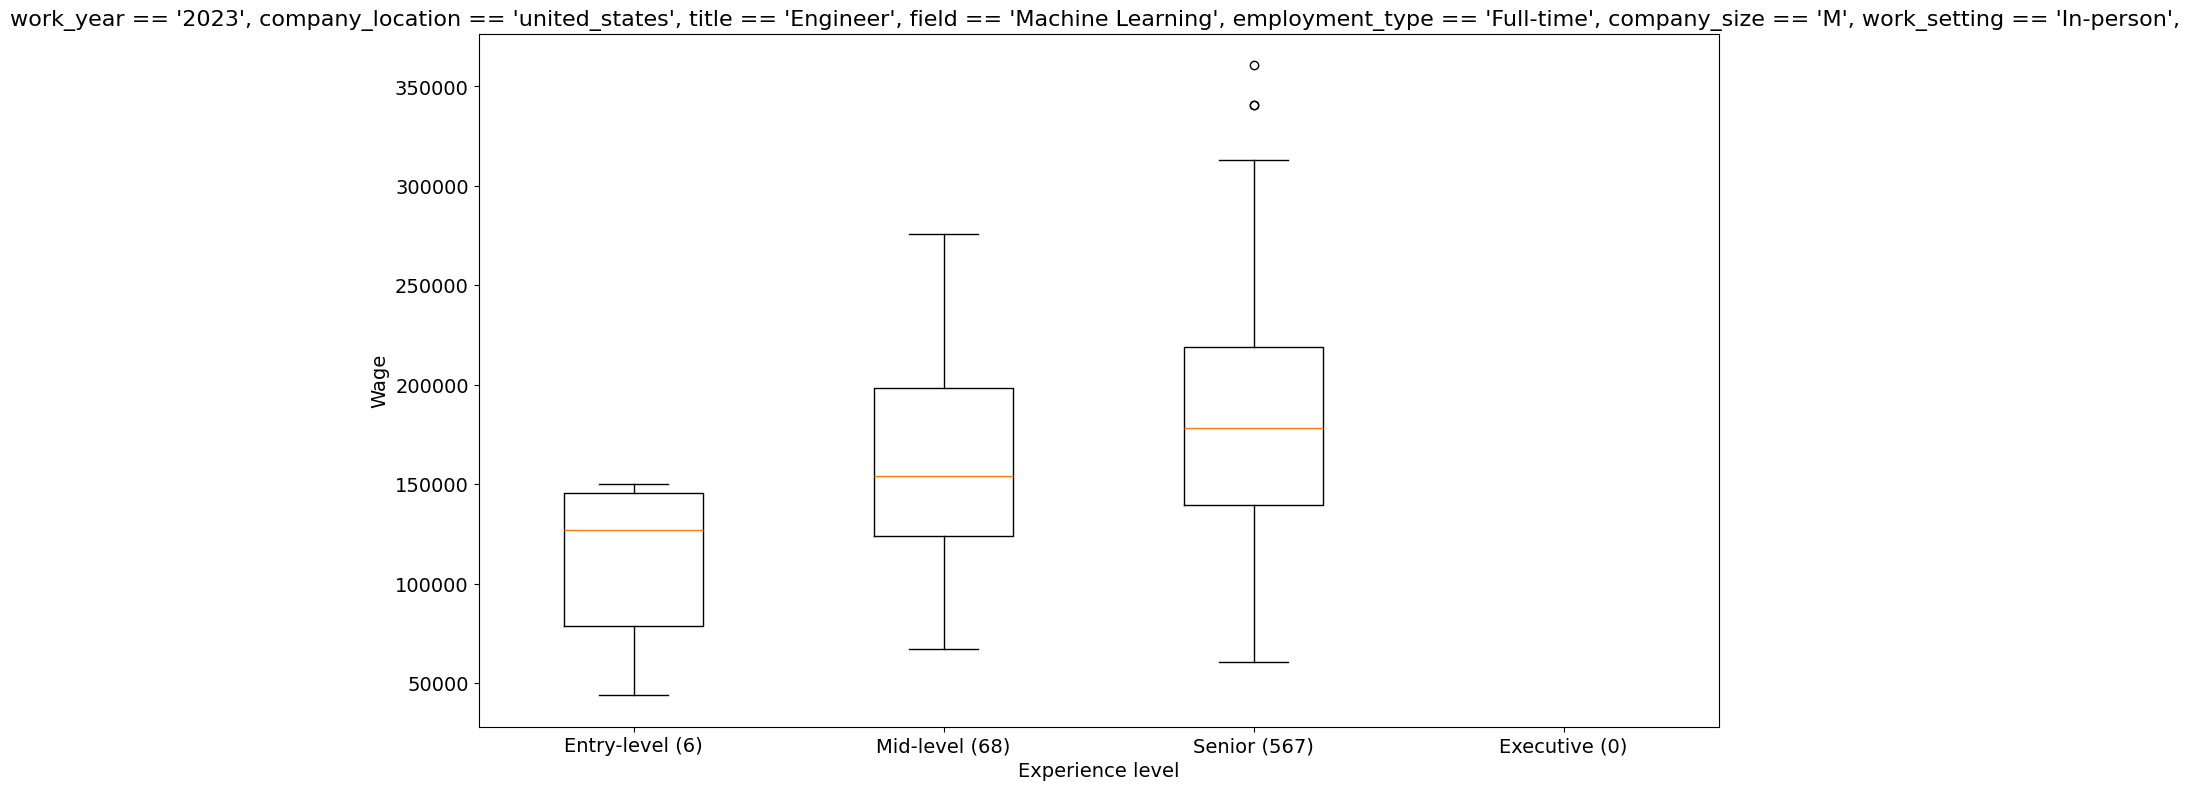

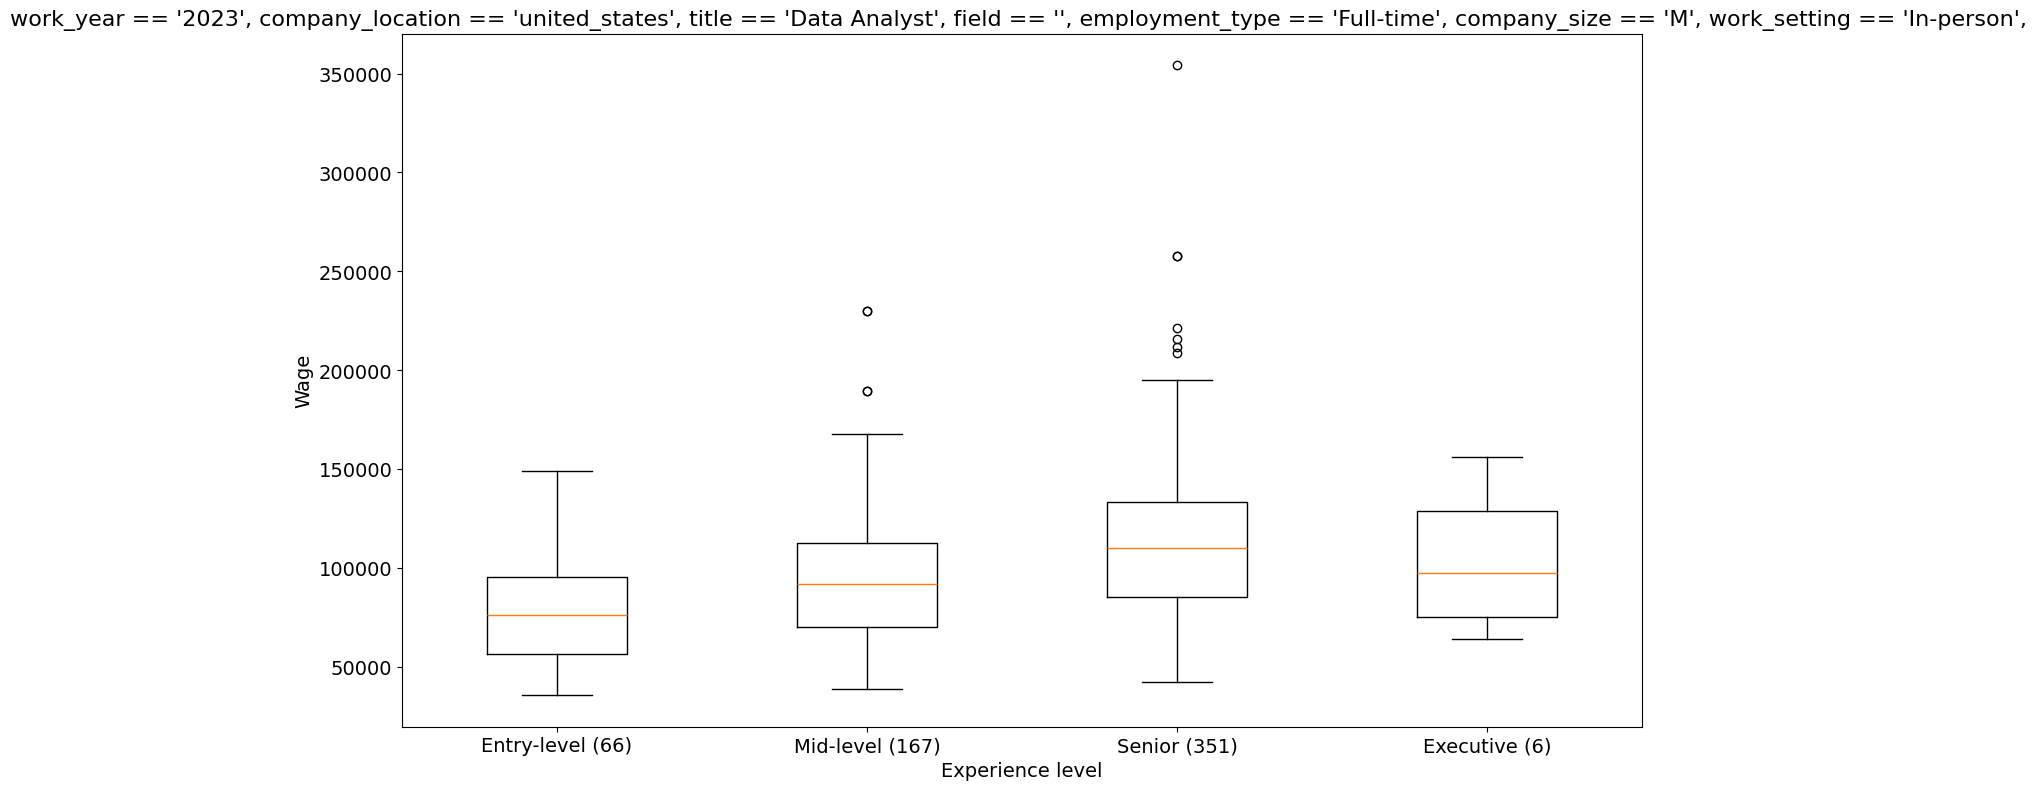

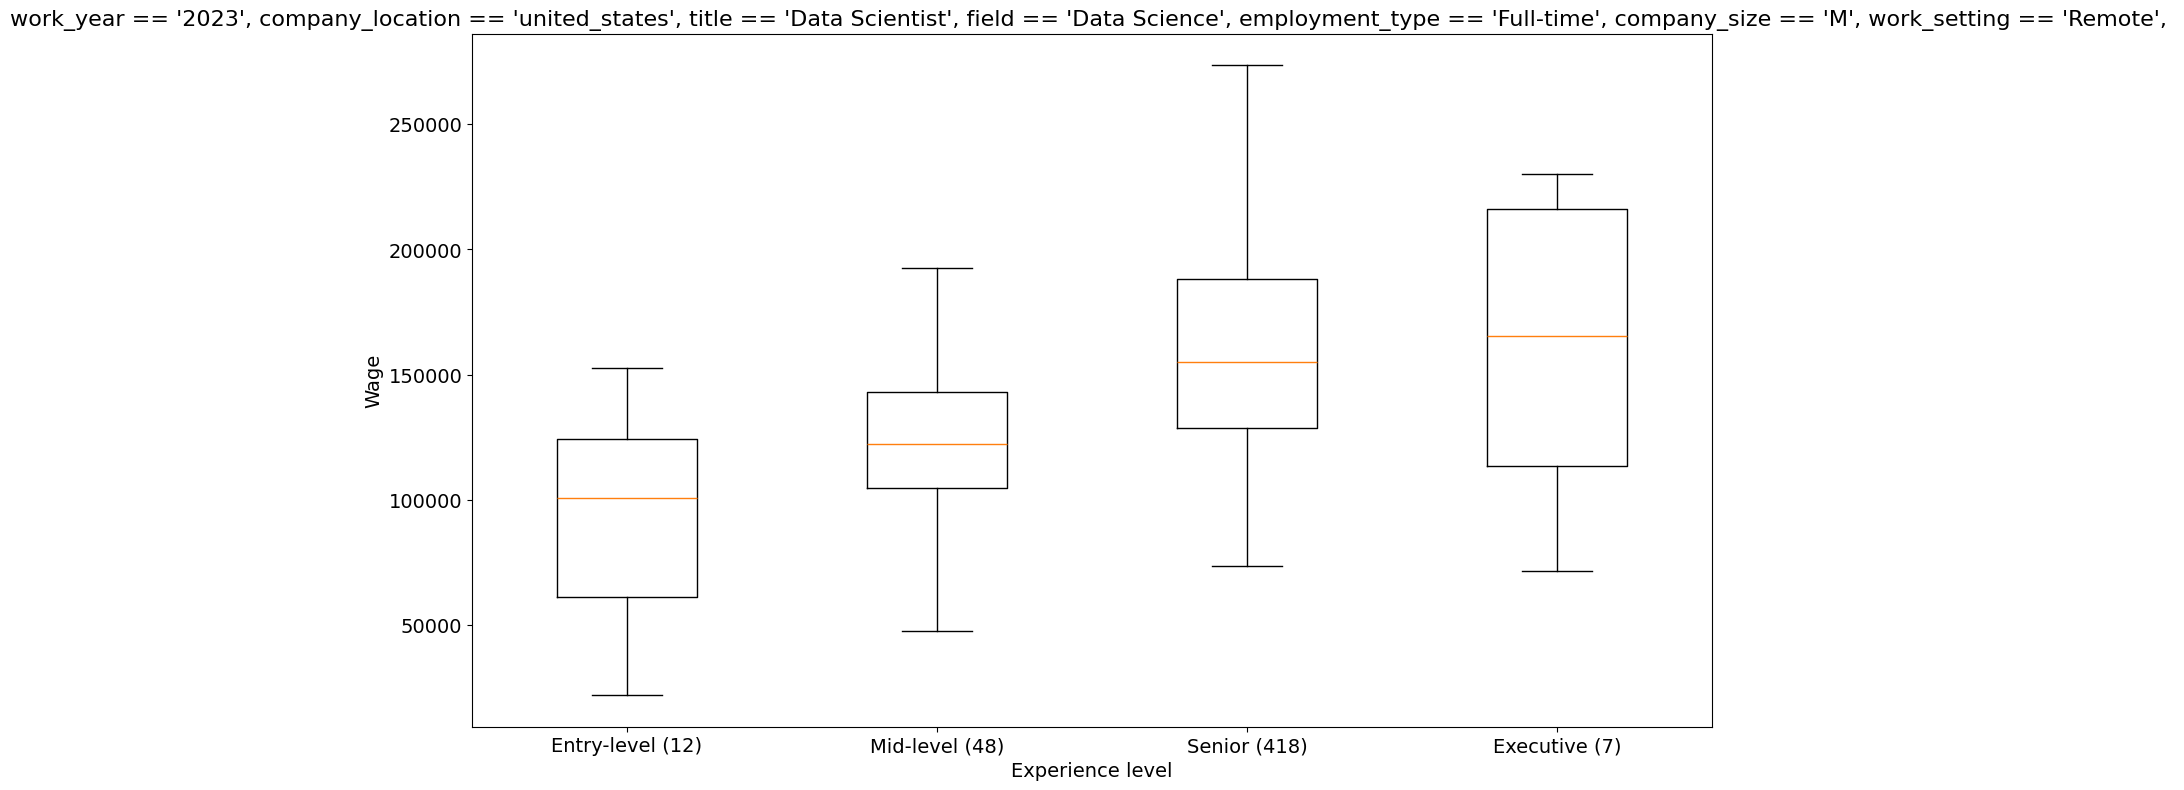

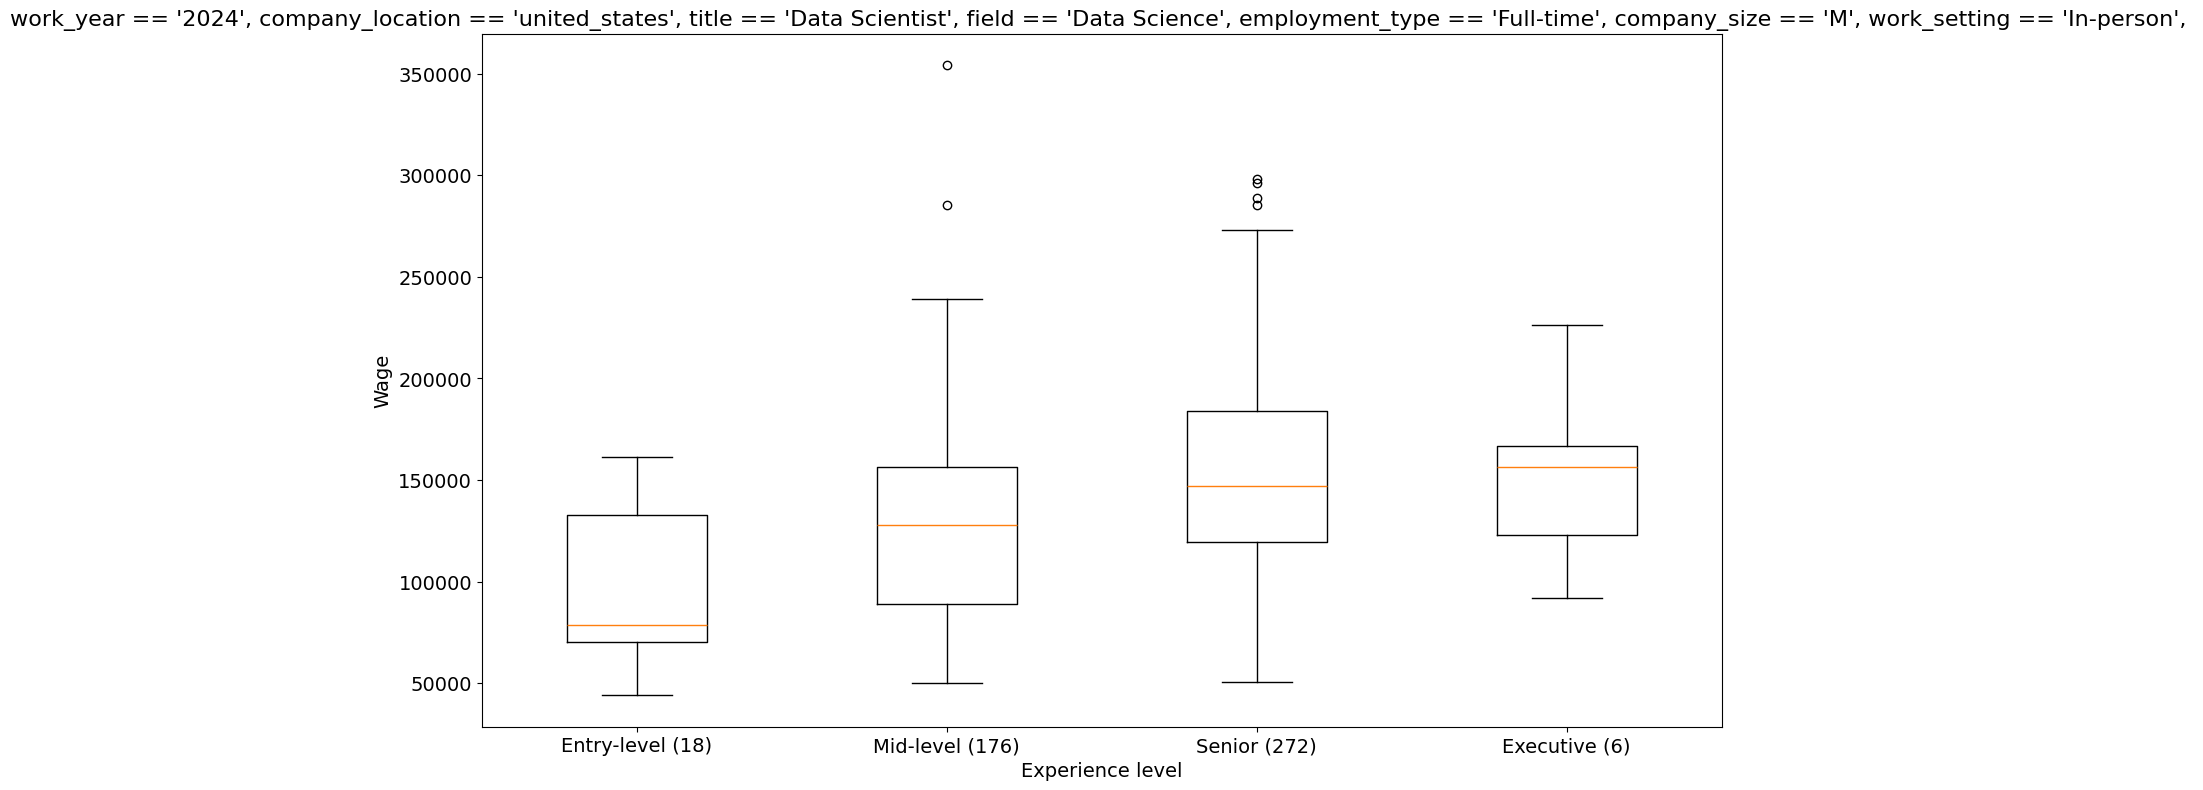

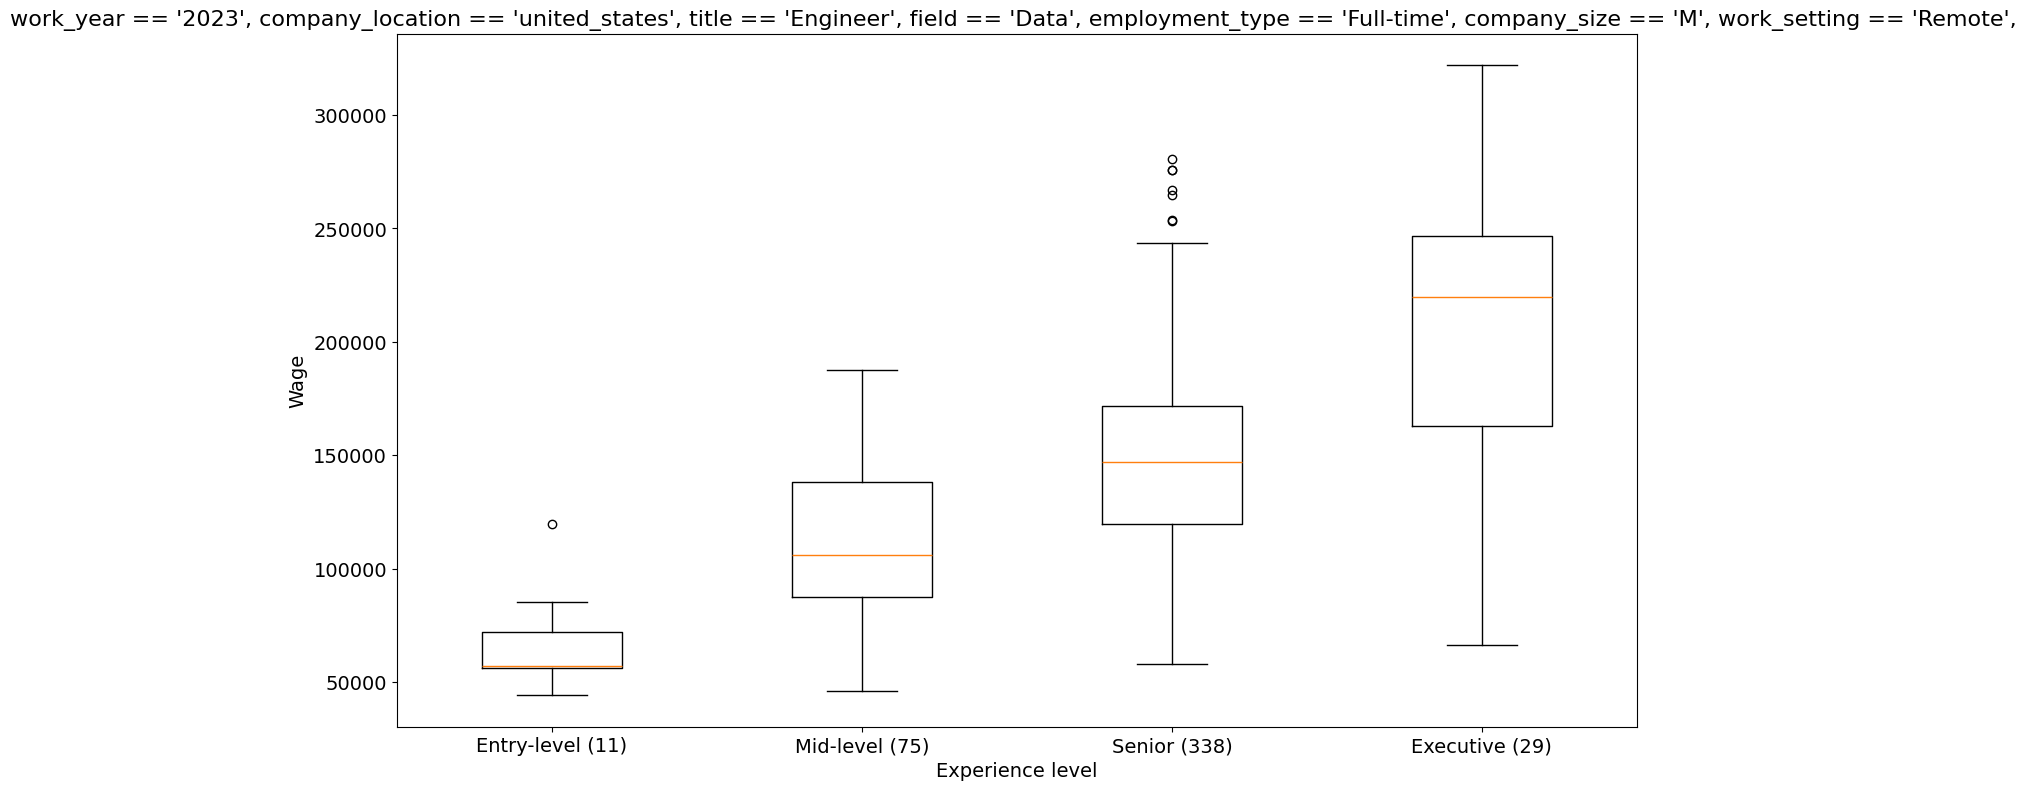

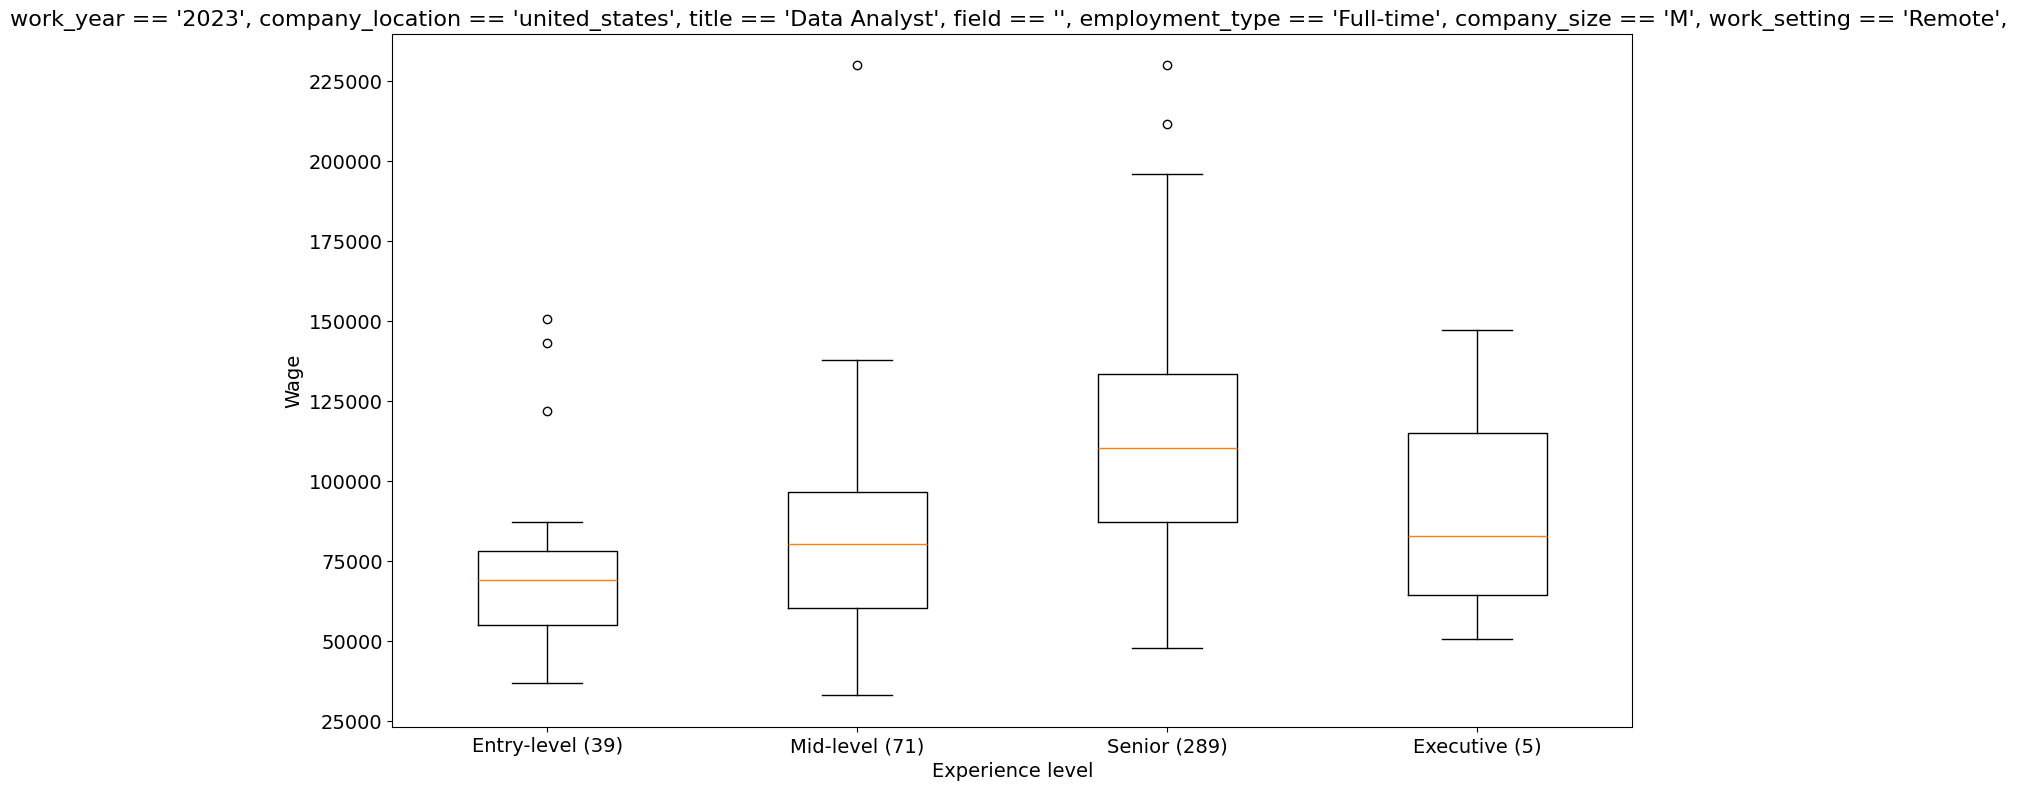

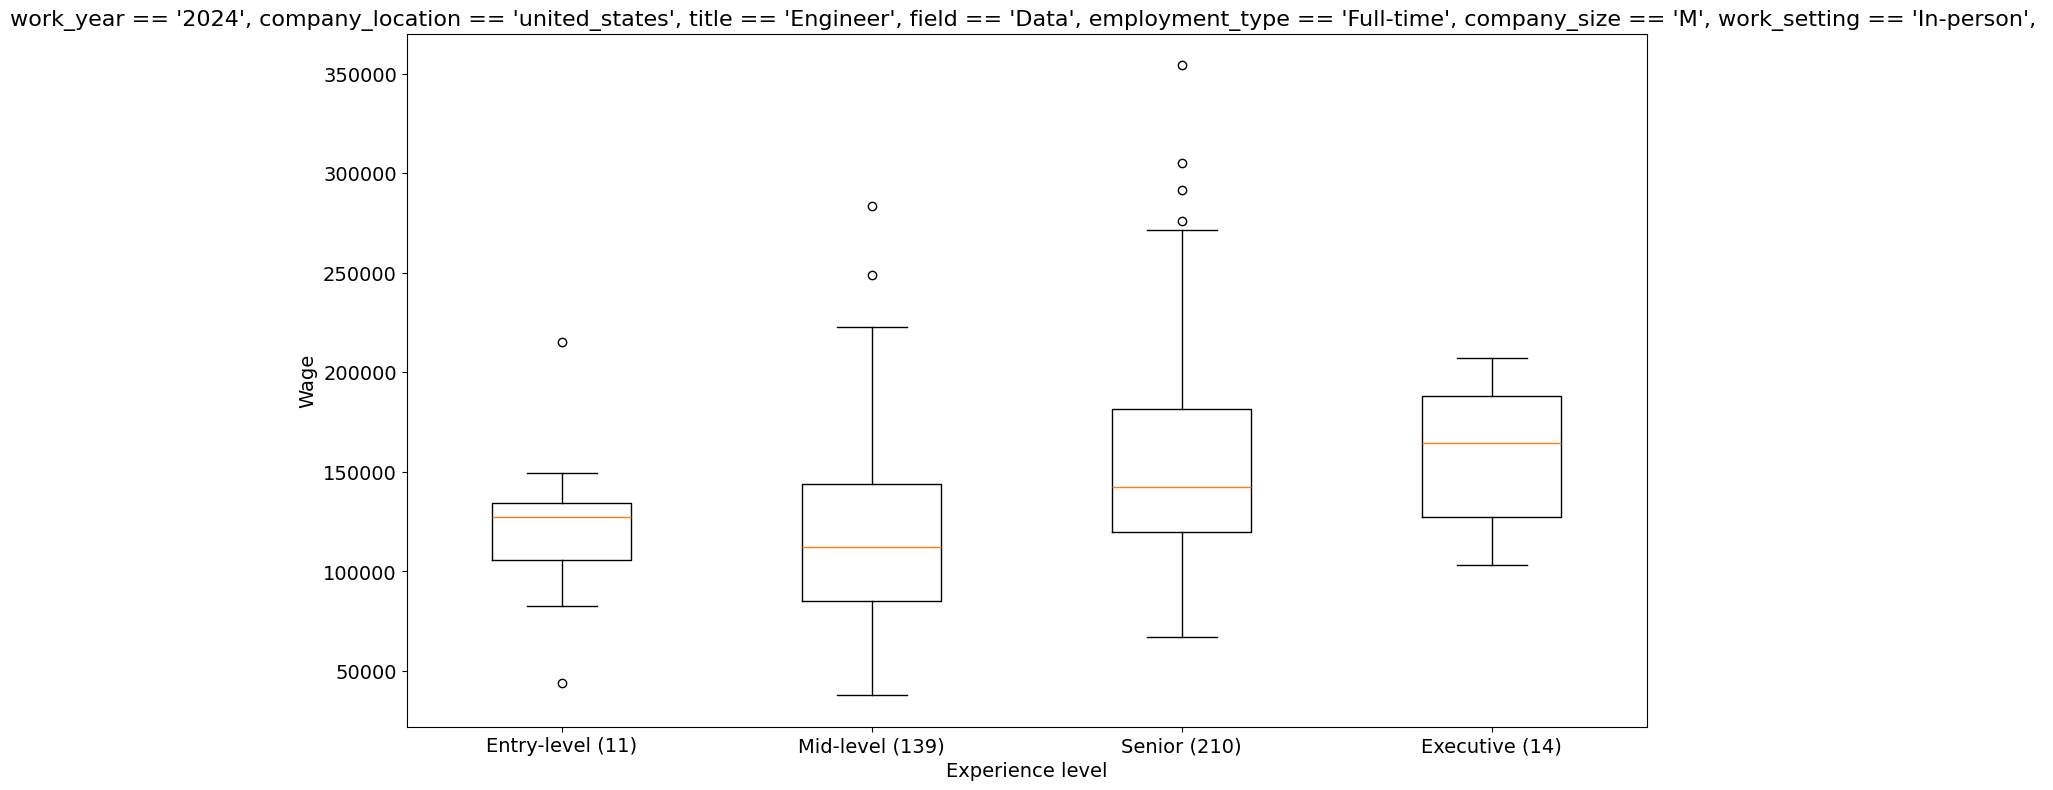

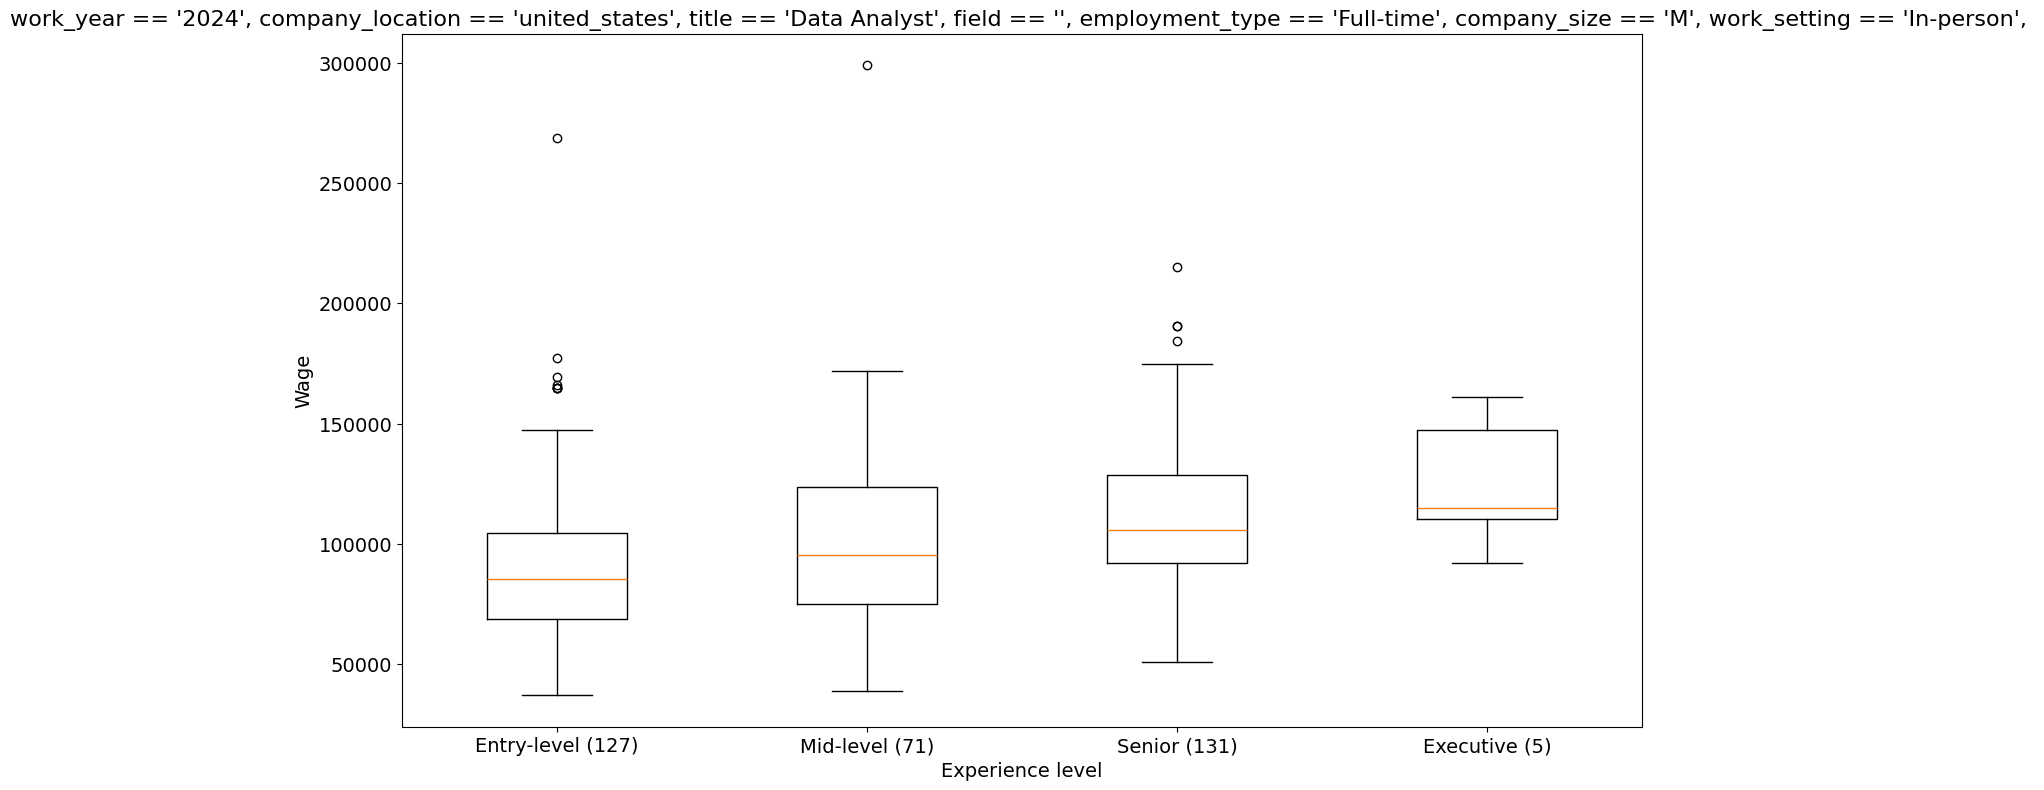

In [63]:
for i in range(0, 10): 
    #let's inspect the top 10 clusters with the most entries according to our constraints set at the start of step 6.5.
    [subset, title] = h.query_main_dataframe(i, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()
    


There is a clear upward trend for higher wages as experience level increases; it's not always there, but overall we can say that more experience leads to higher wages. Let's see if this trend is also visible for randomly selected rows. 

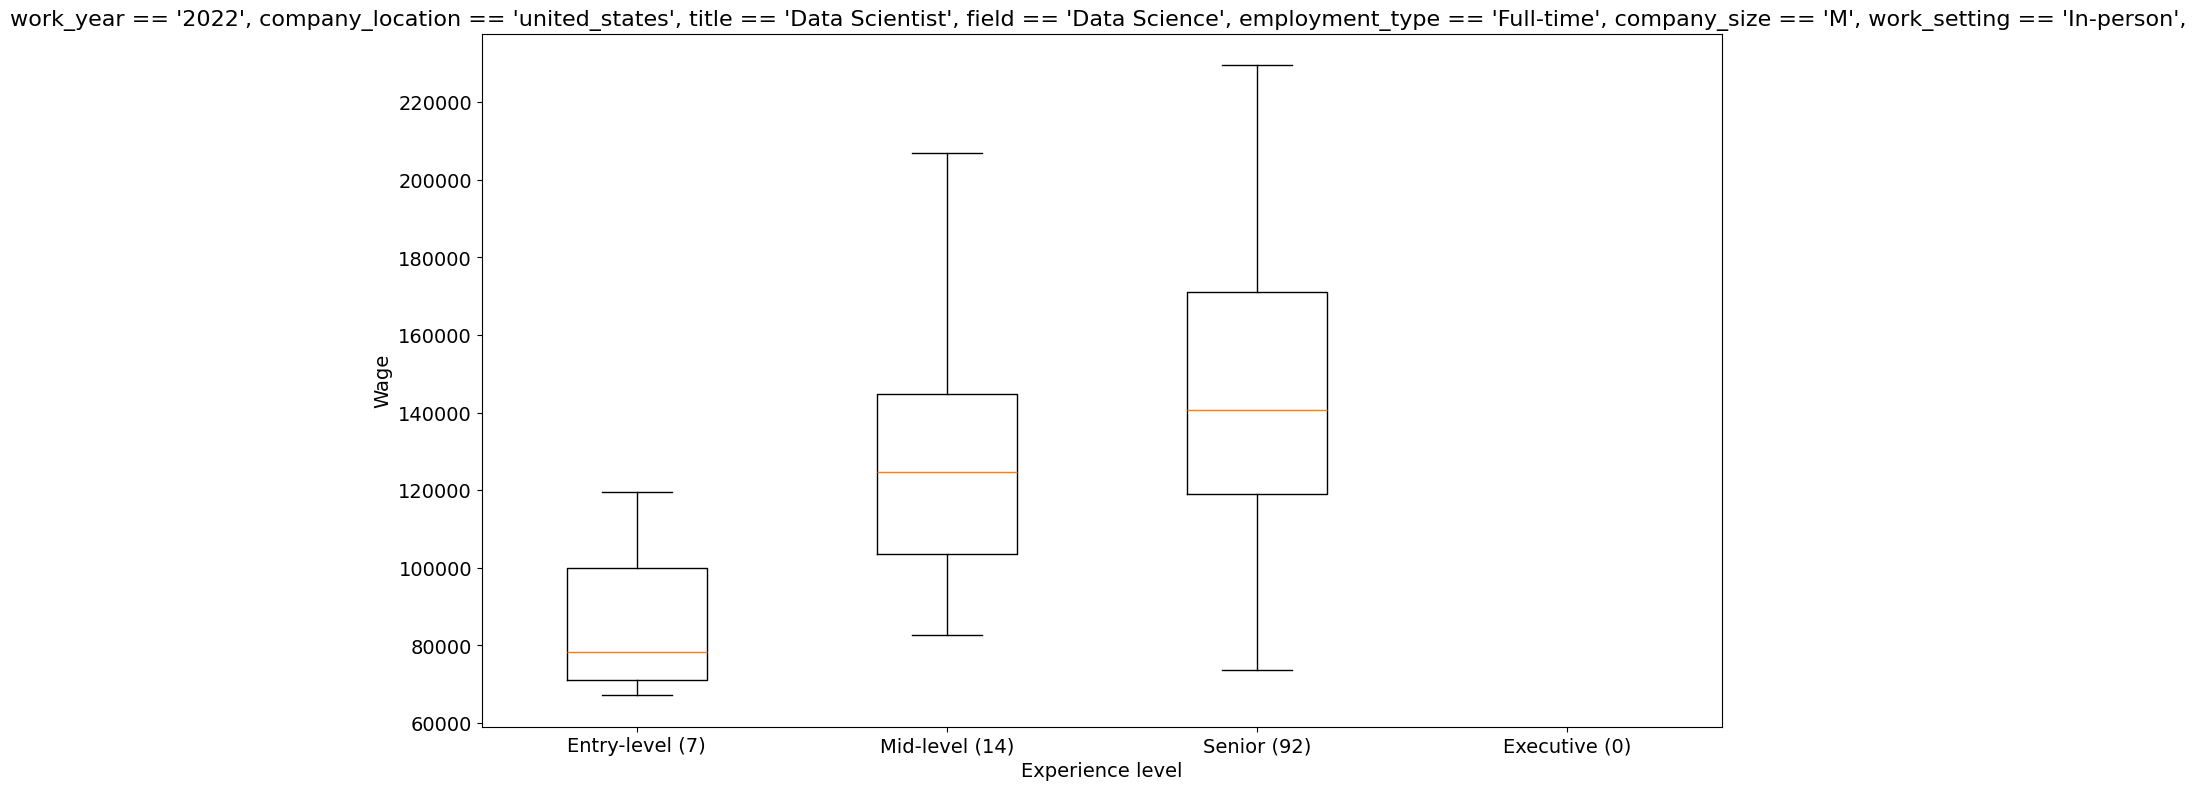

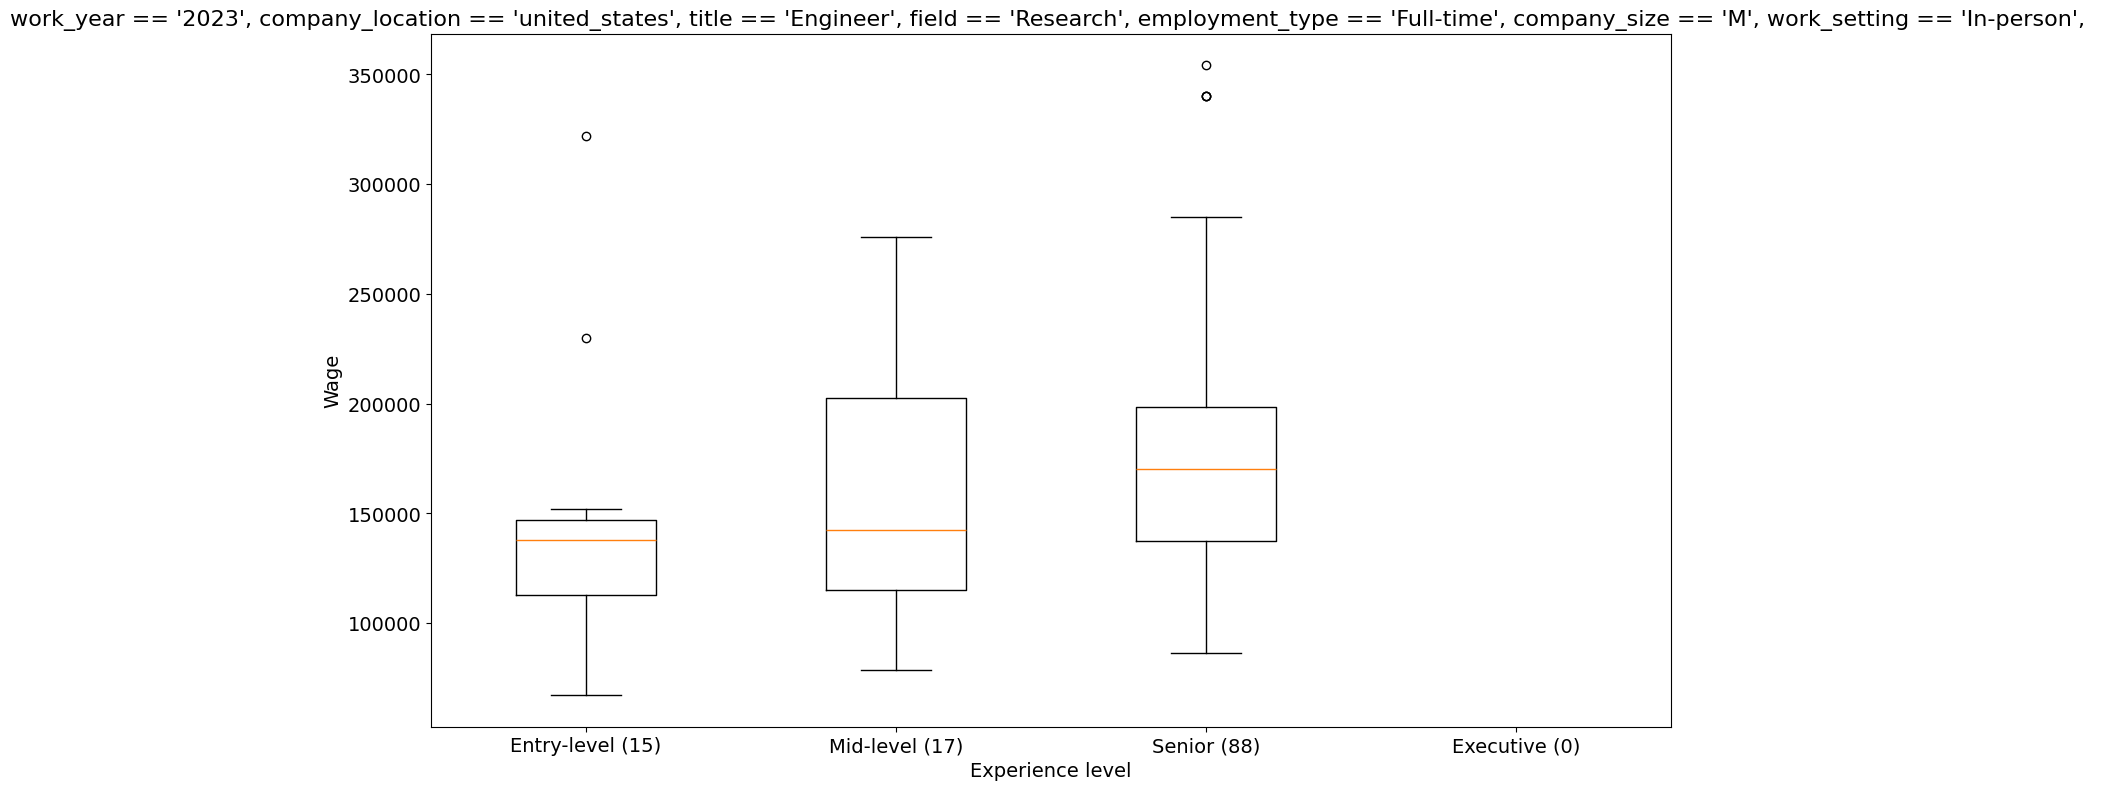

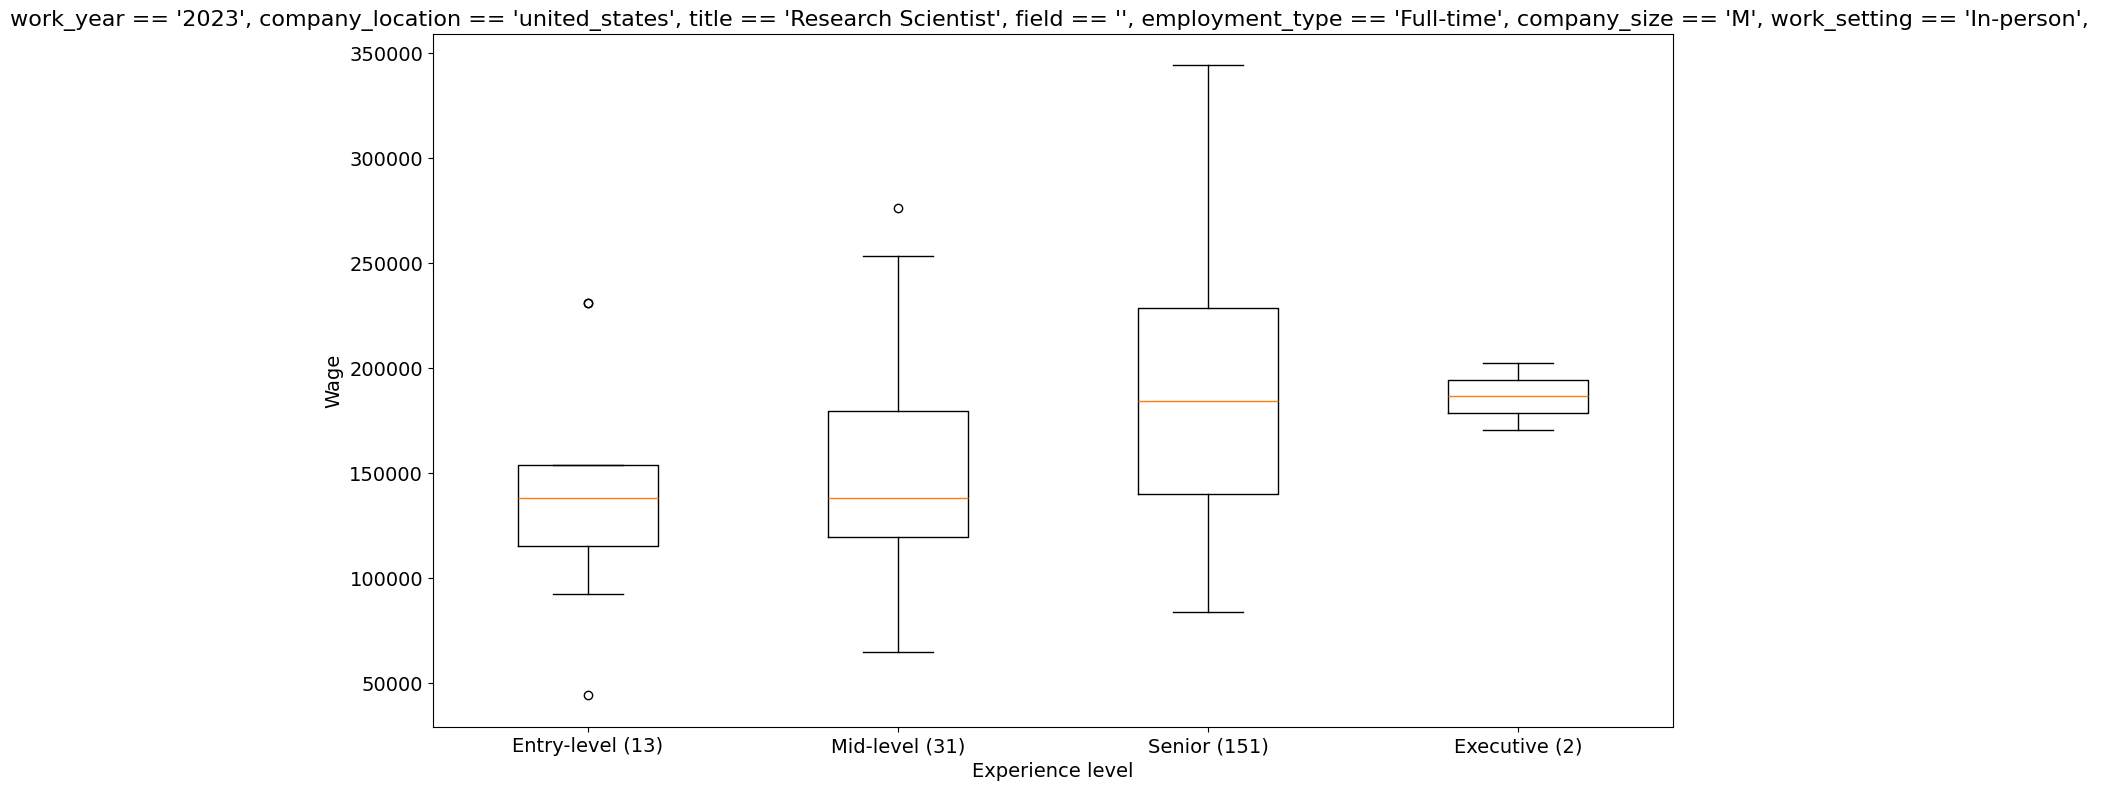

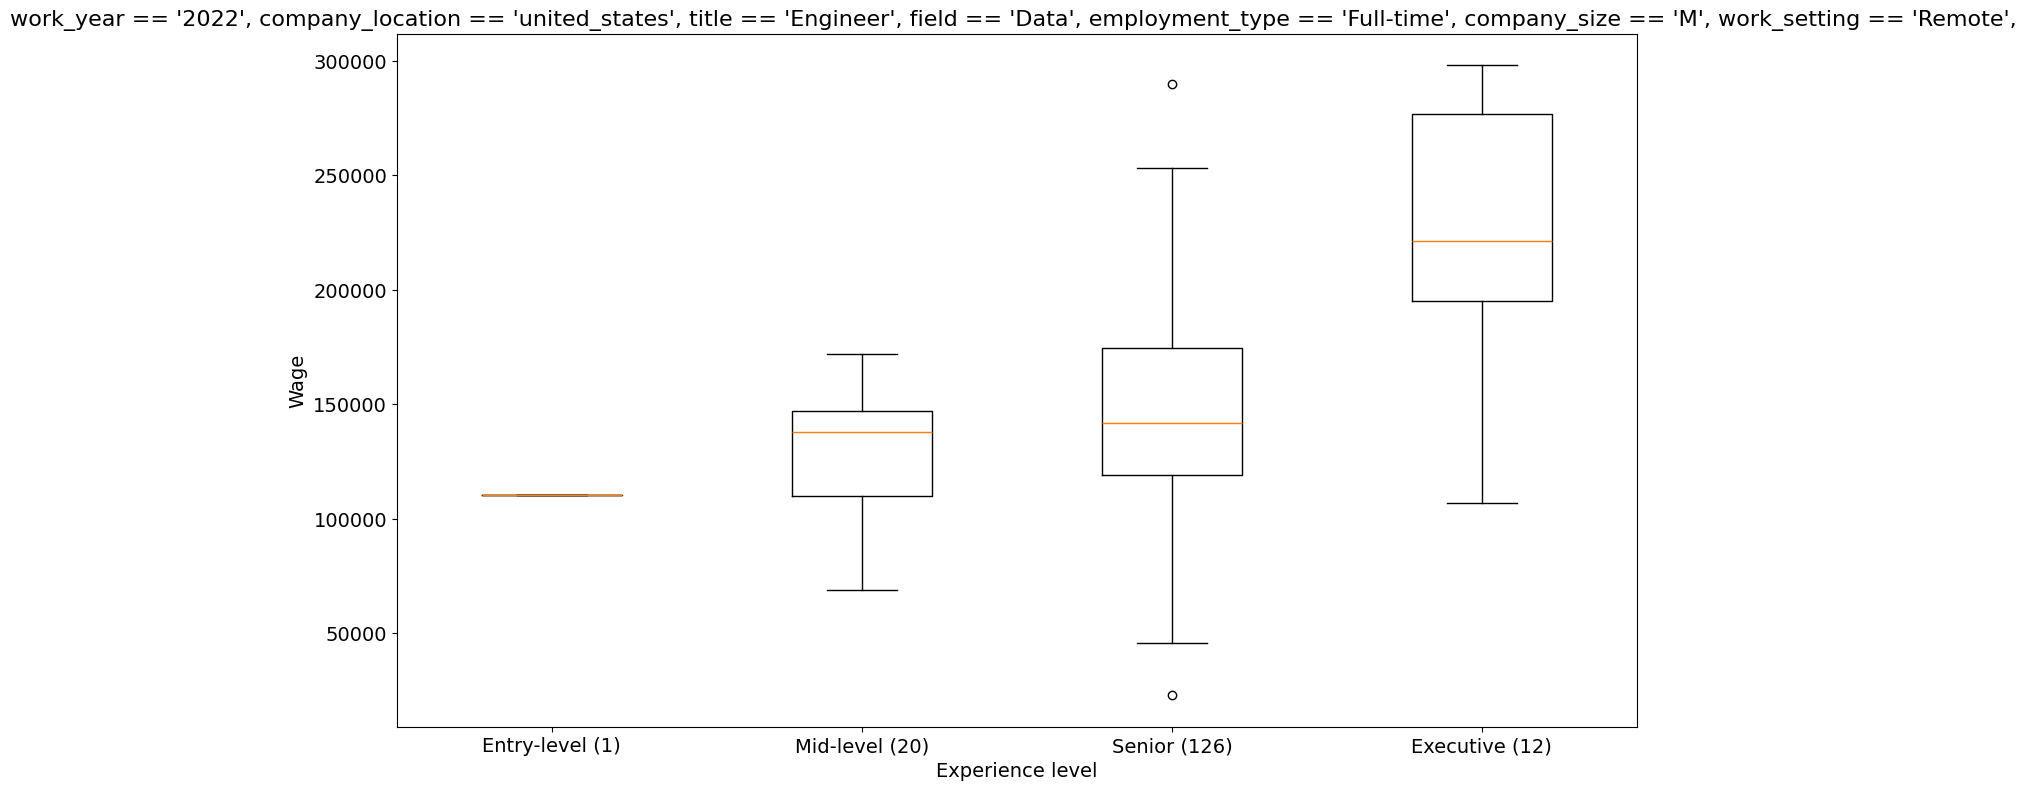

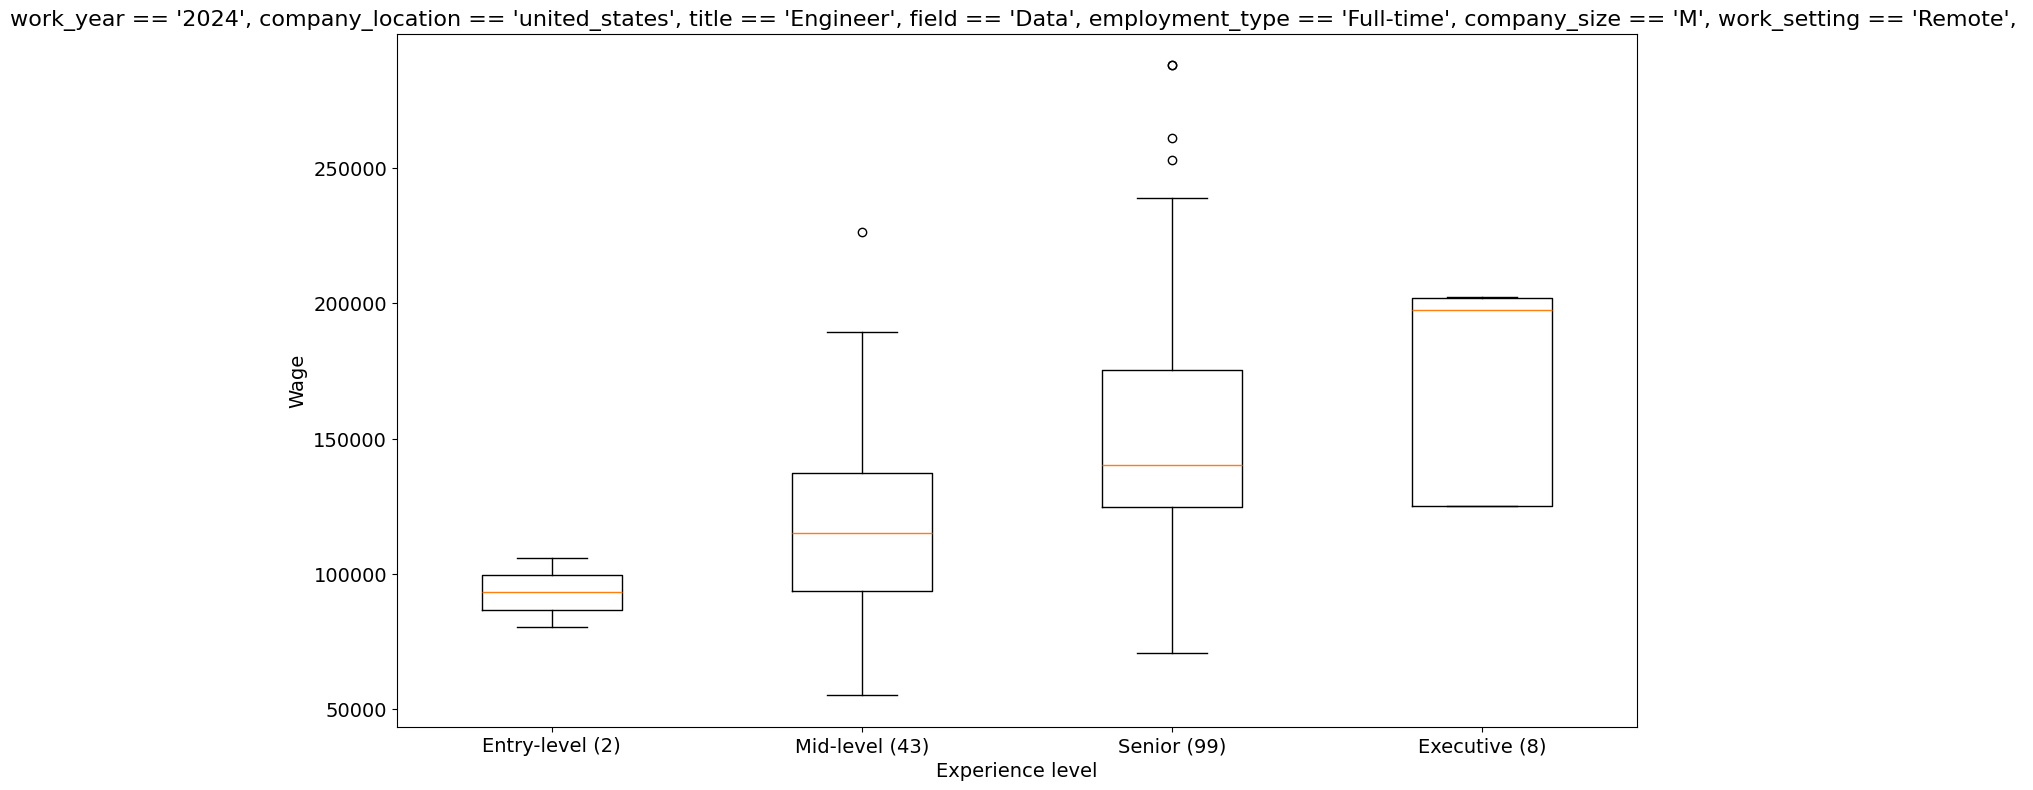

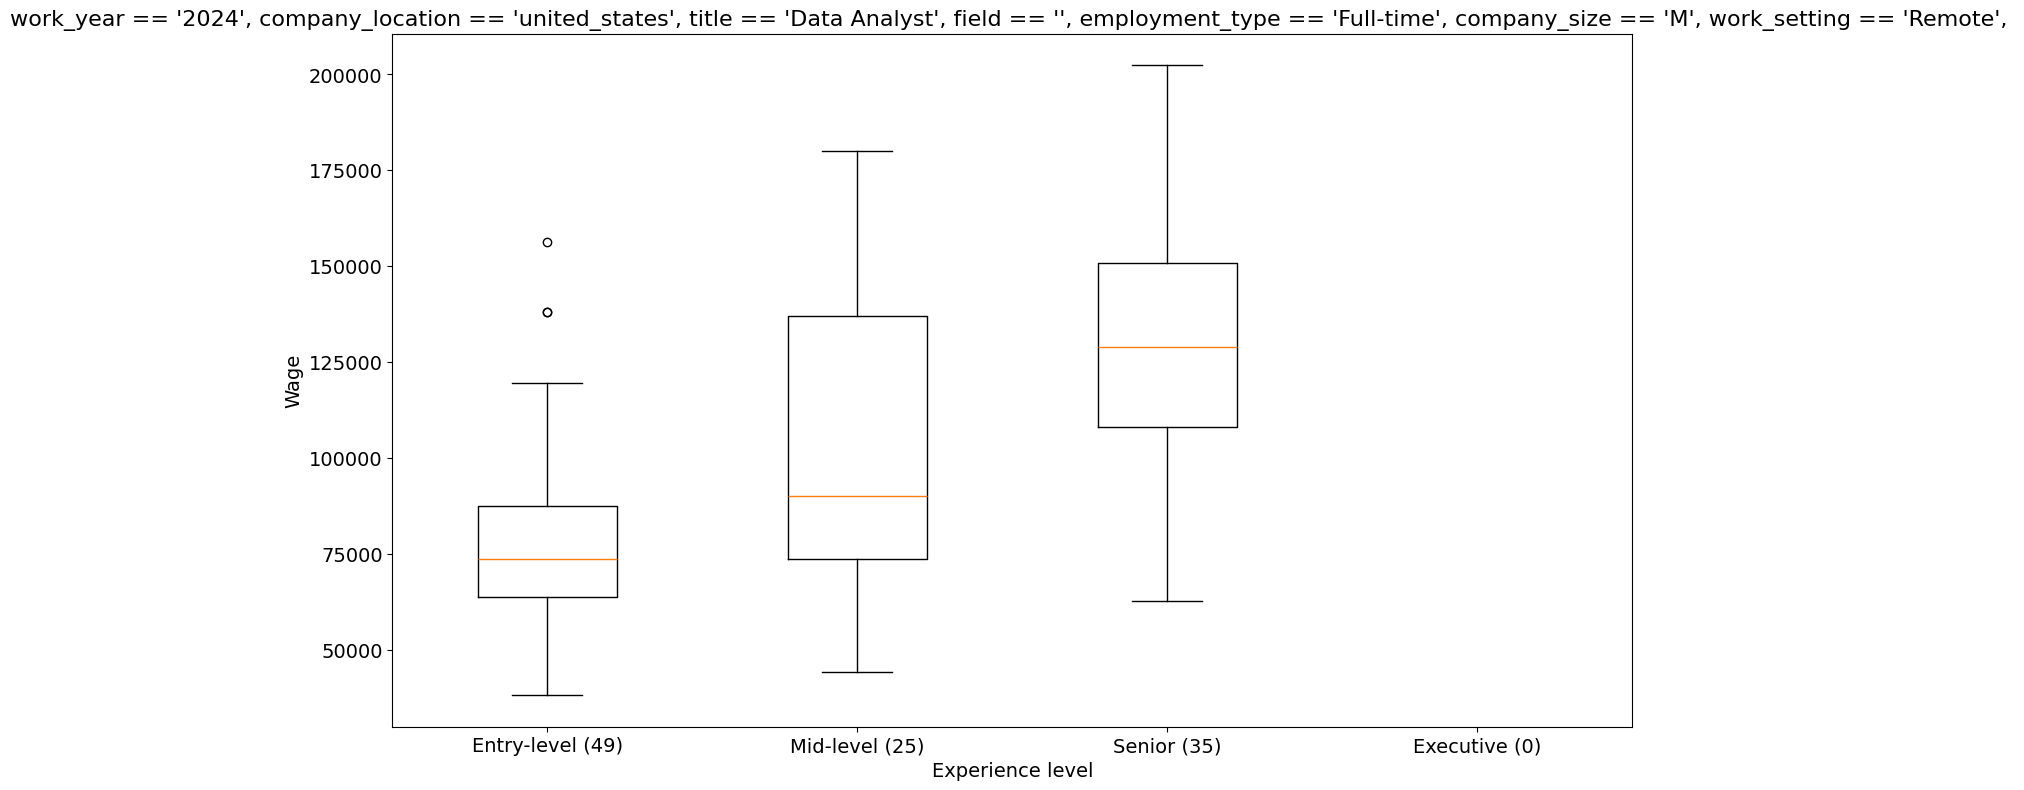

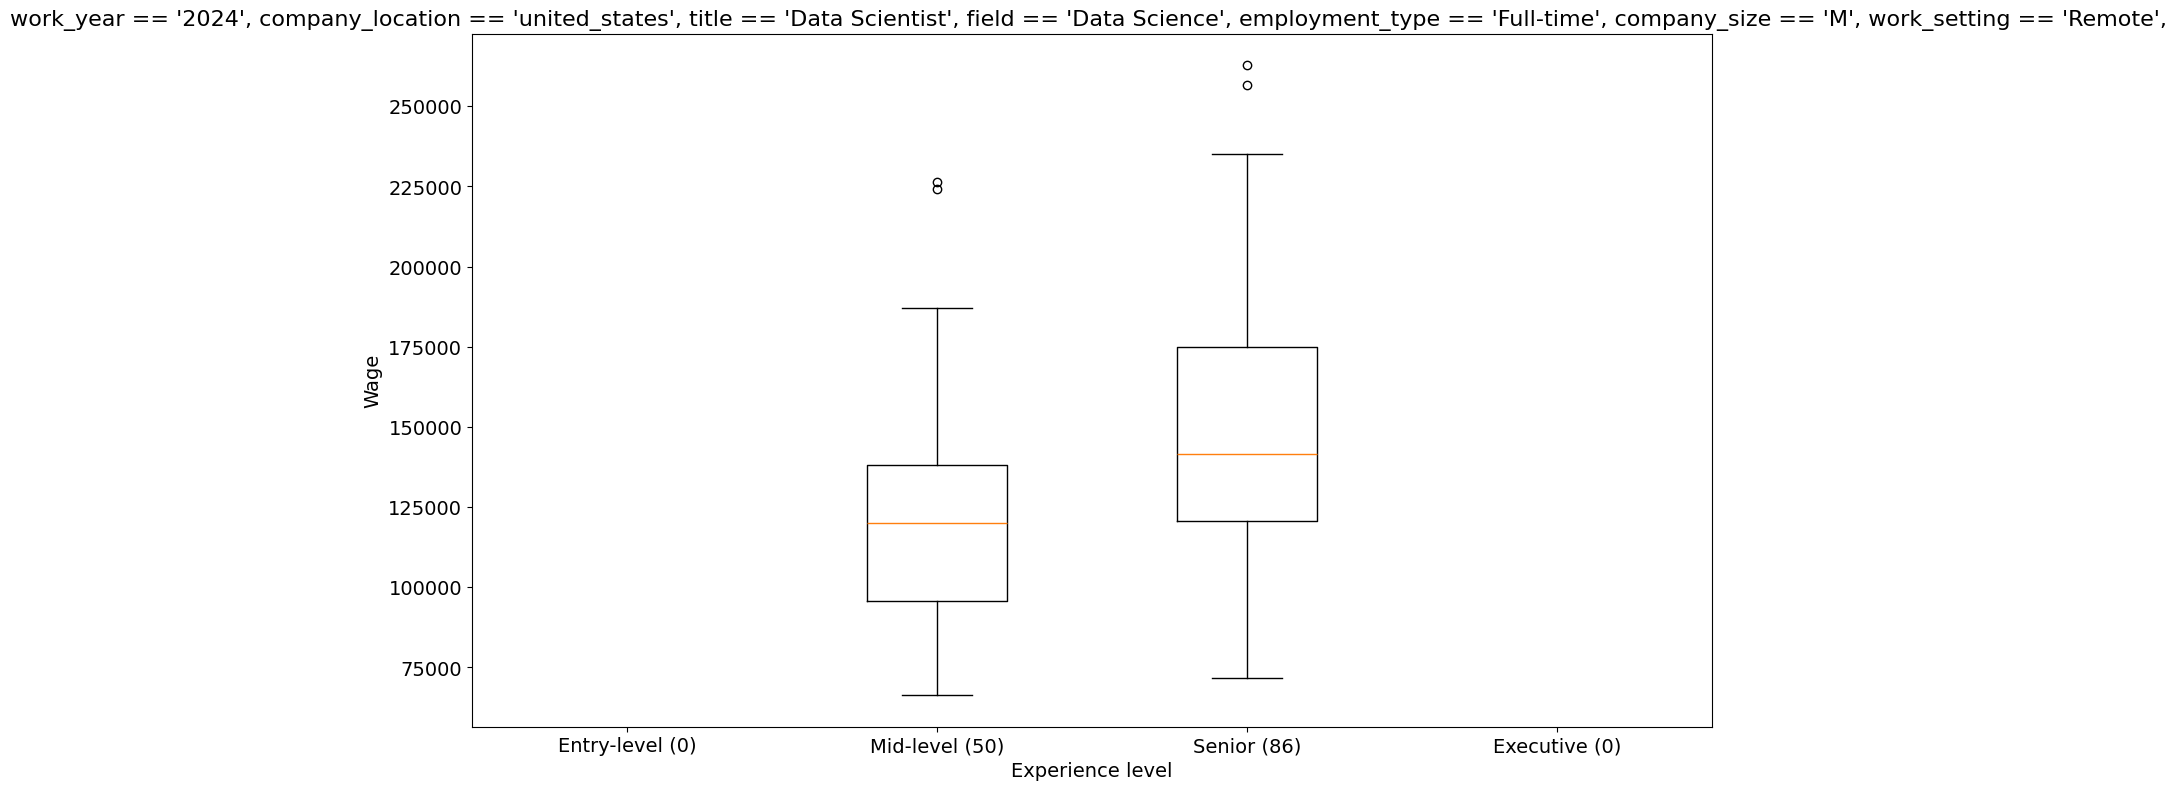

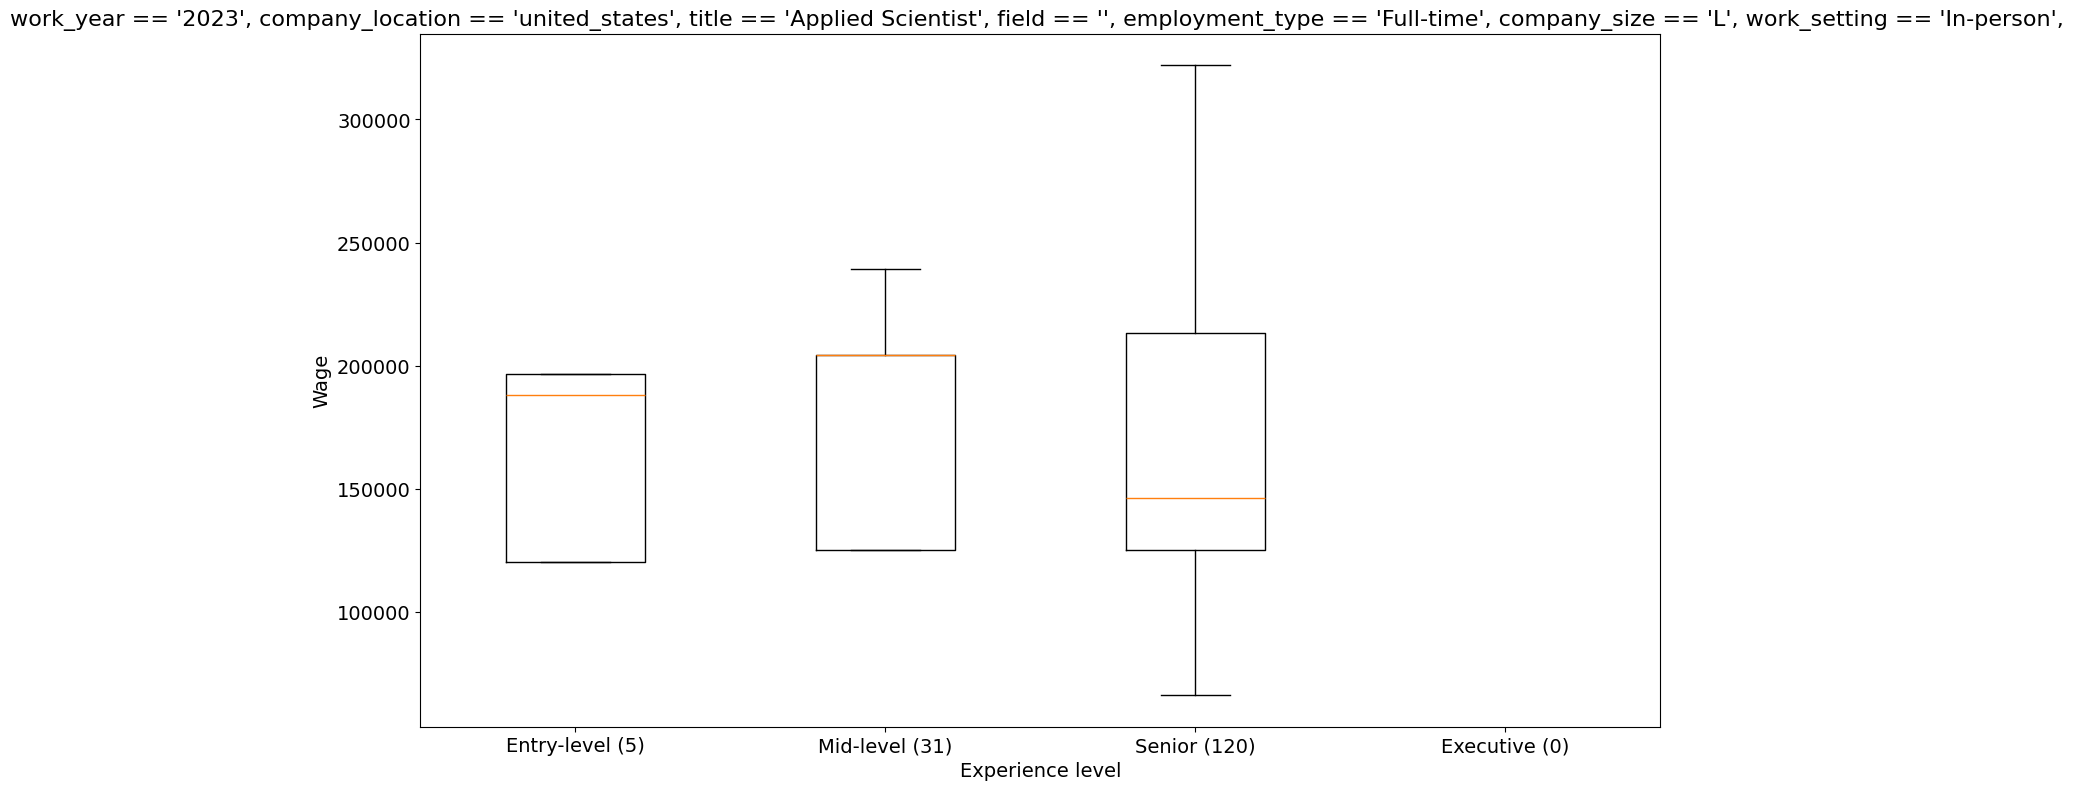

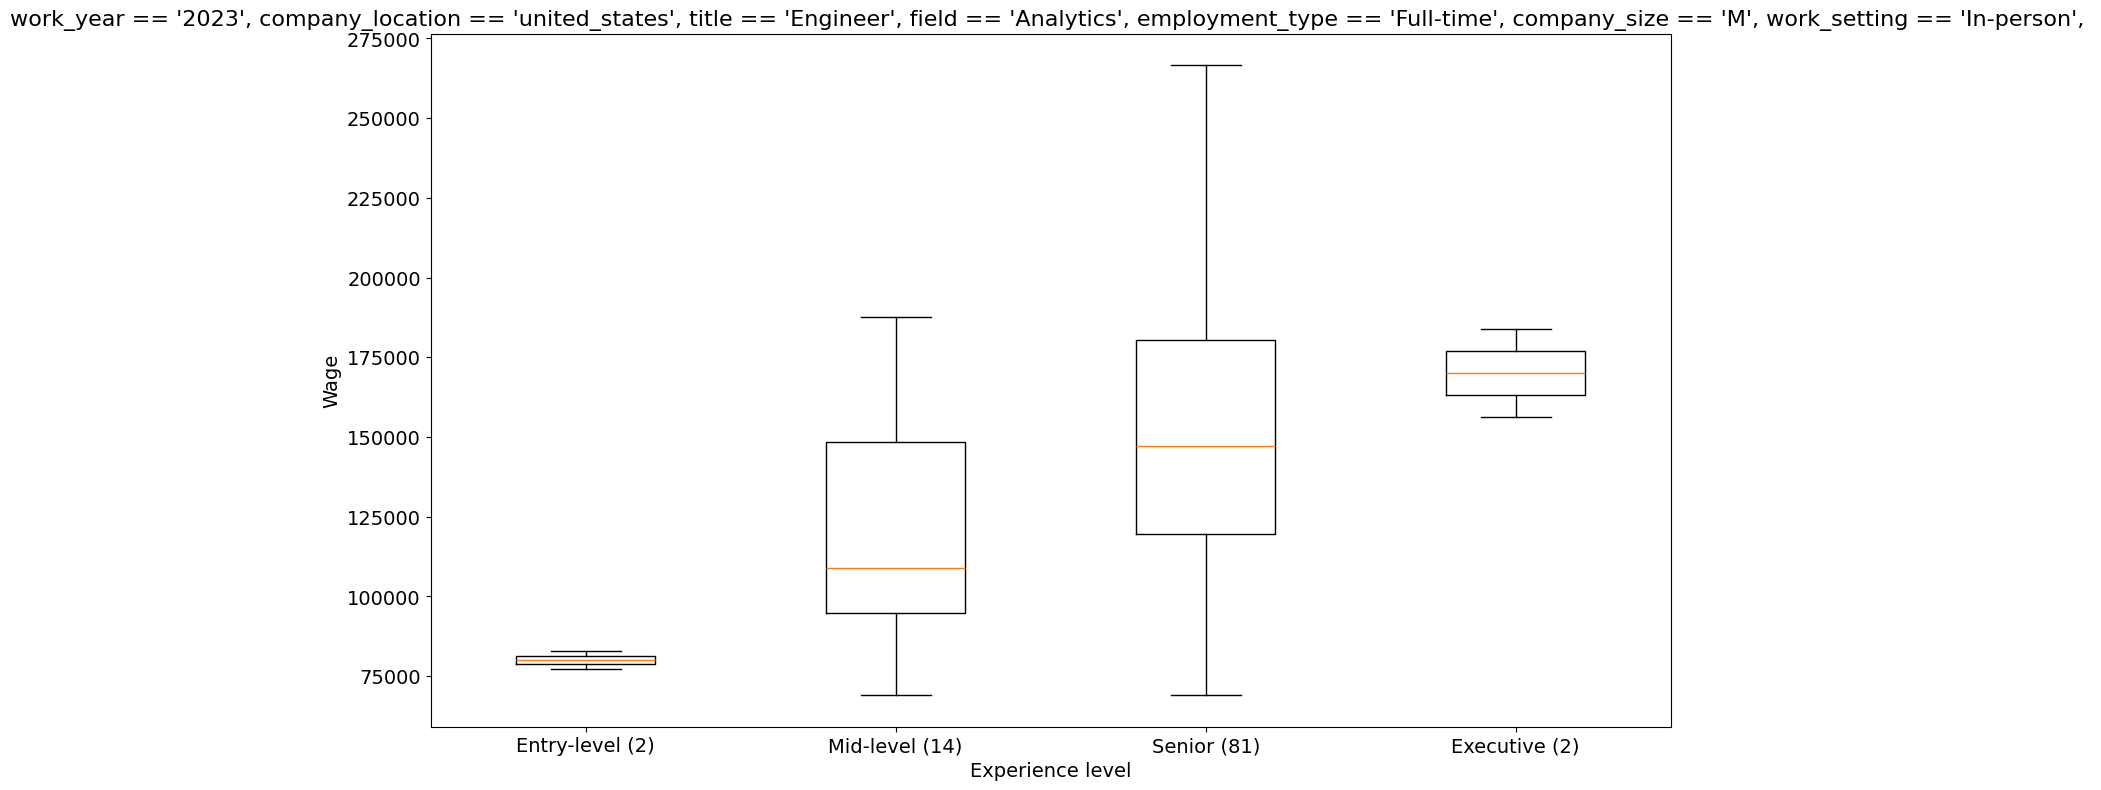

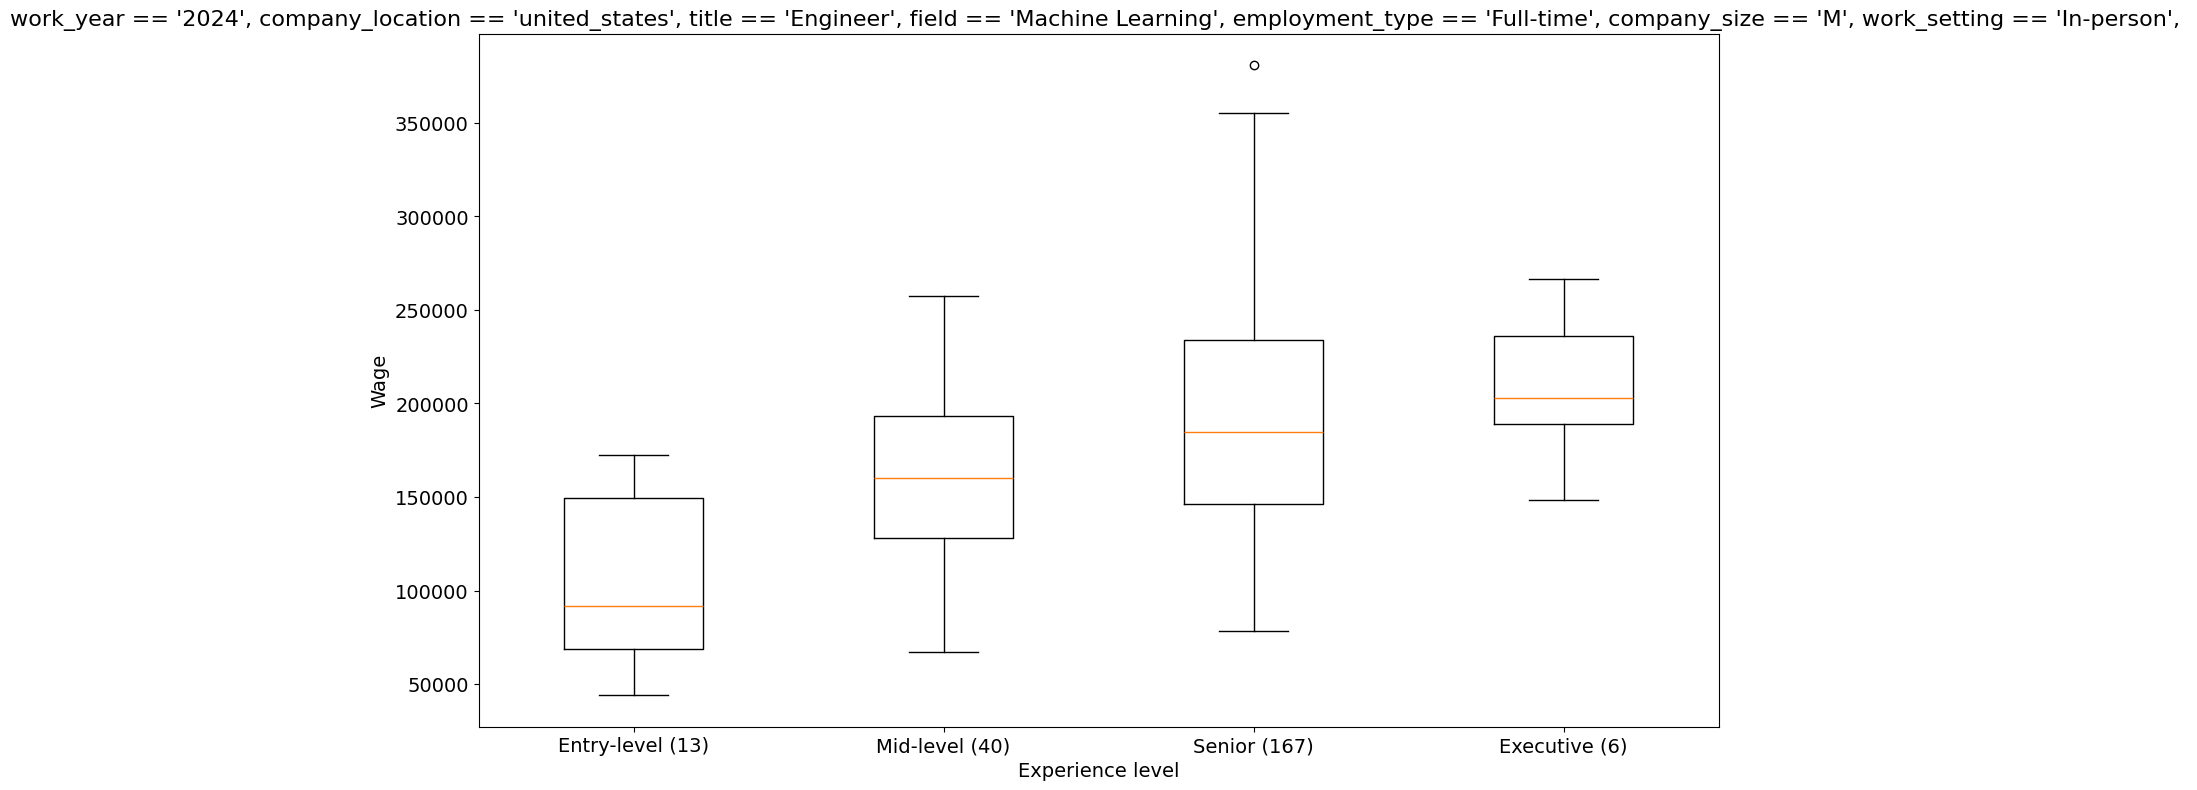

In [64]:
min_listings = 100
lmax = len(clusters.query("count>=@min_listings"))
picked_rows = random.sample(range(10, lmax+1), 10)
for row in picked_rows: 
    [subset, title] = h.query_main_dataframe(row, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

For randomly selected rows of the `exp_clusters` dataframe we see that the trend holds up - again with a handful exceptions. So unlike the company size this is a very valuable feature to implement in the model. 

## 6.7 On vs off site work
rinse and repeat of 6.5

In [65]:
key_for_question = 'work_setting'
clusters = h.make_clusters(df_processed, groupbykeys, key_for_question)
clusters.head(5)

work_year company_location           title             field employment_type experience_level company_size  count
762        2023    united_states  Data Scientist      Data Science       Full-time           Senior            M   1090
803        2023    united_states        Engineer              Data       Full-time           Senior            M   1067
831        2023    united_states        Engineer  Machine Learning       Full-time           Senior            M    713
742        2023    united_states    Data Analyst                         Full-time           Senior            M    640
1091       2024    united_states  Data Scientist      Data Science       Full-time           Senior            M    358

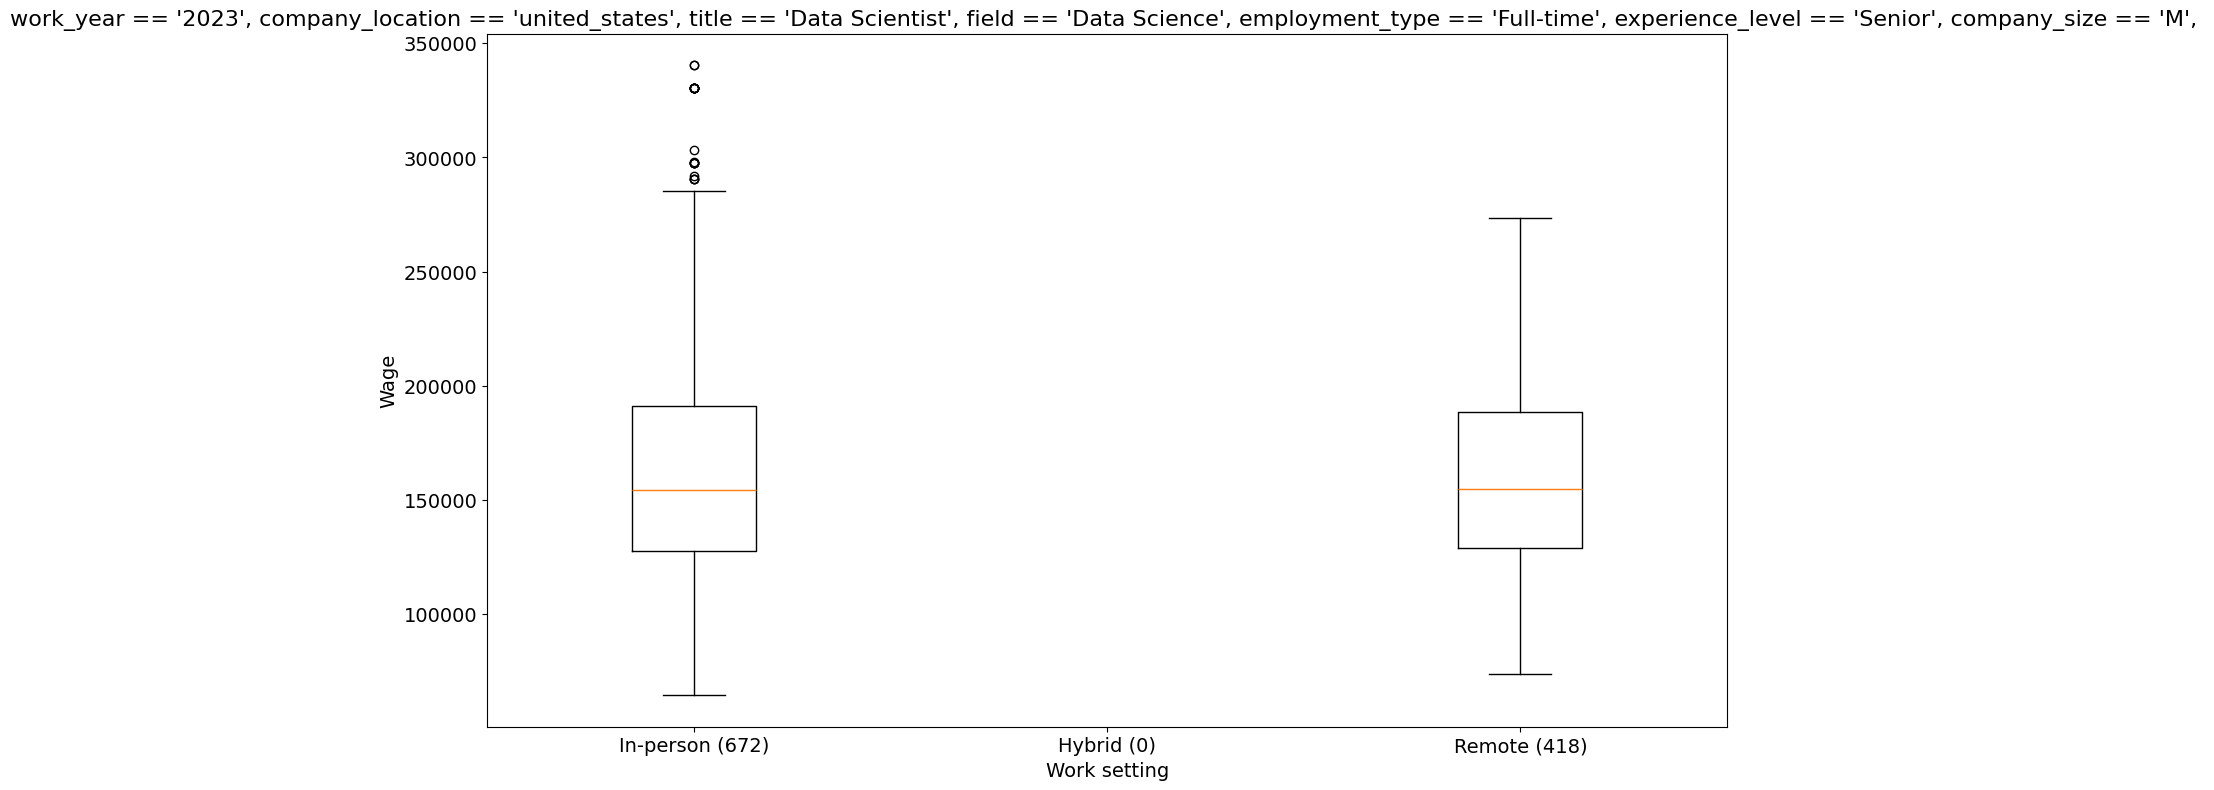

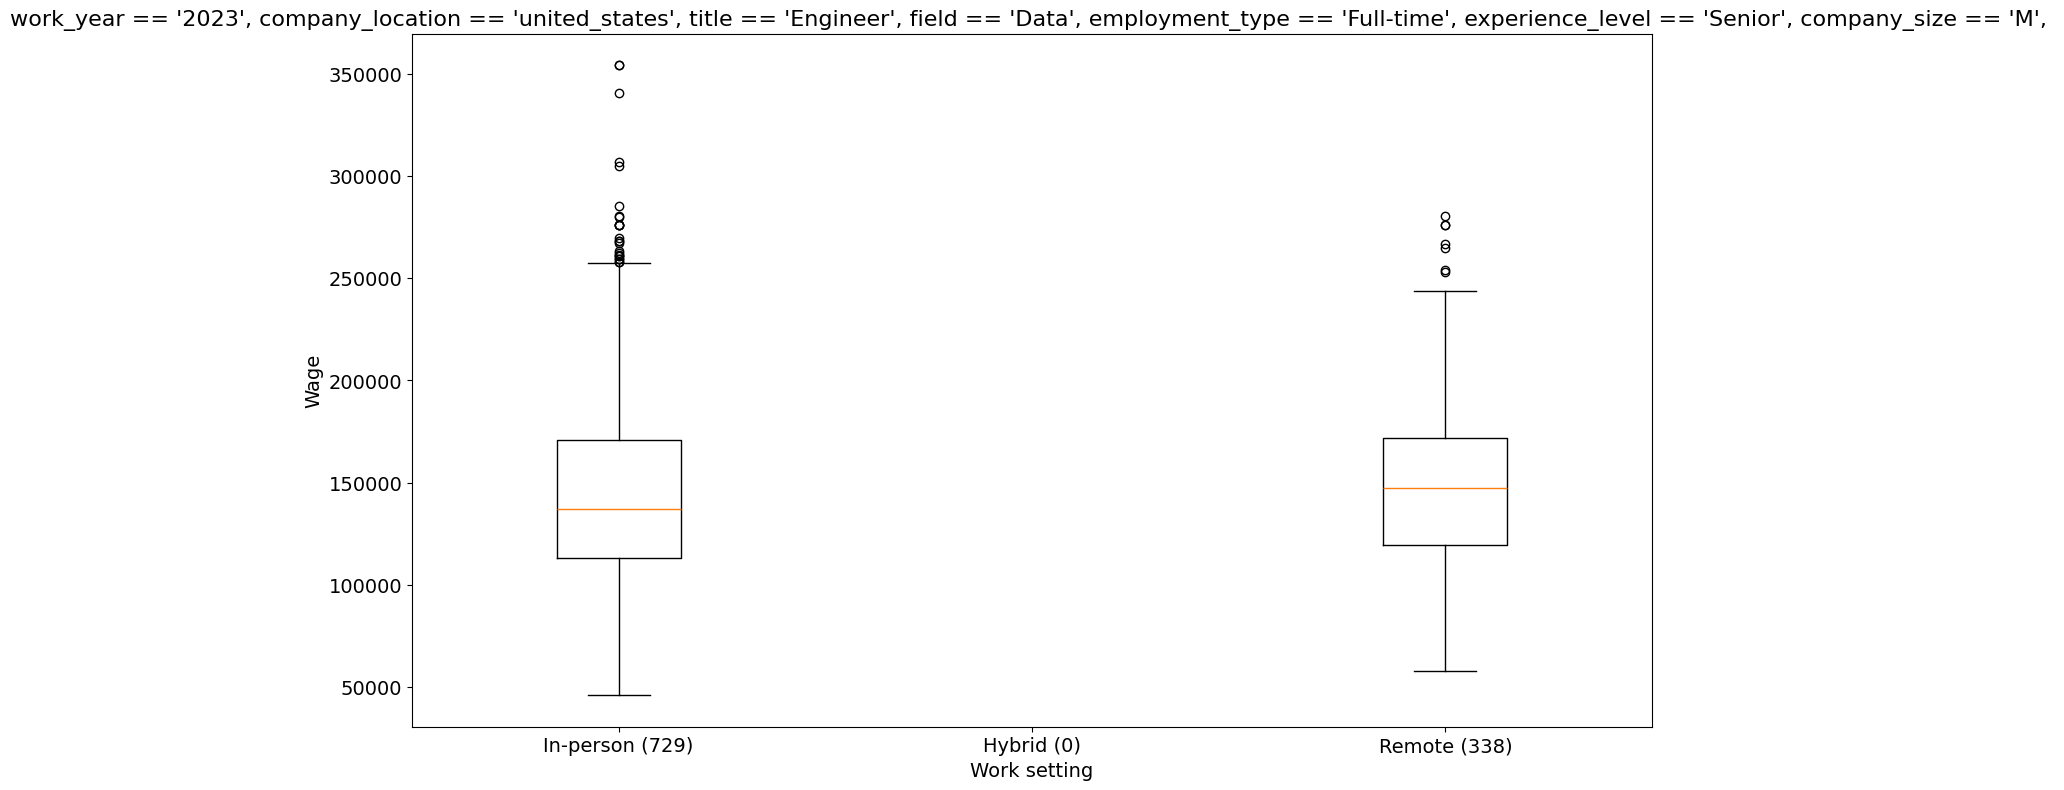

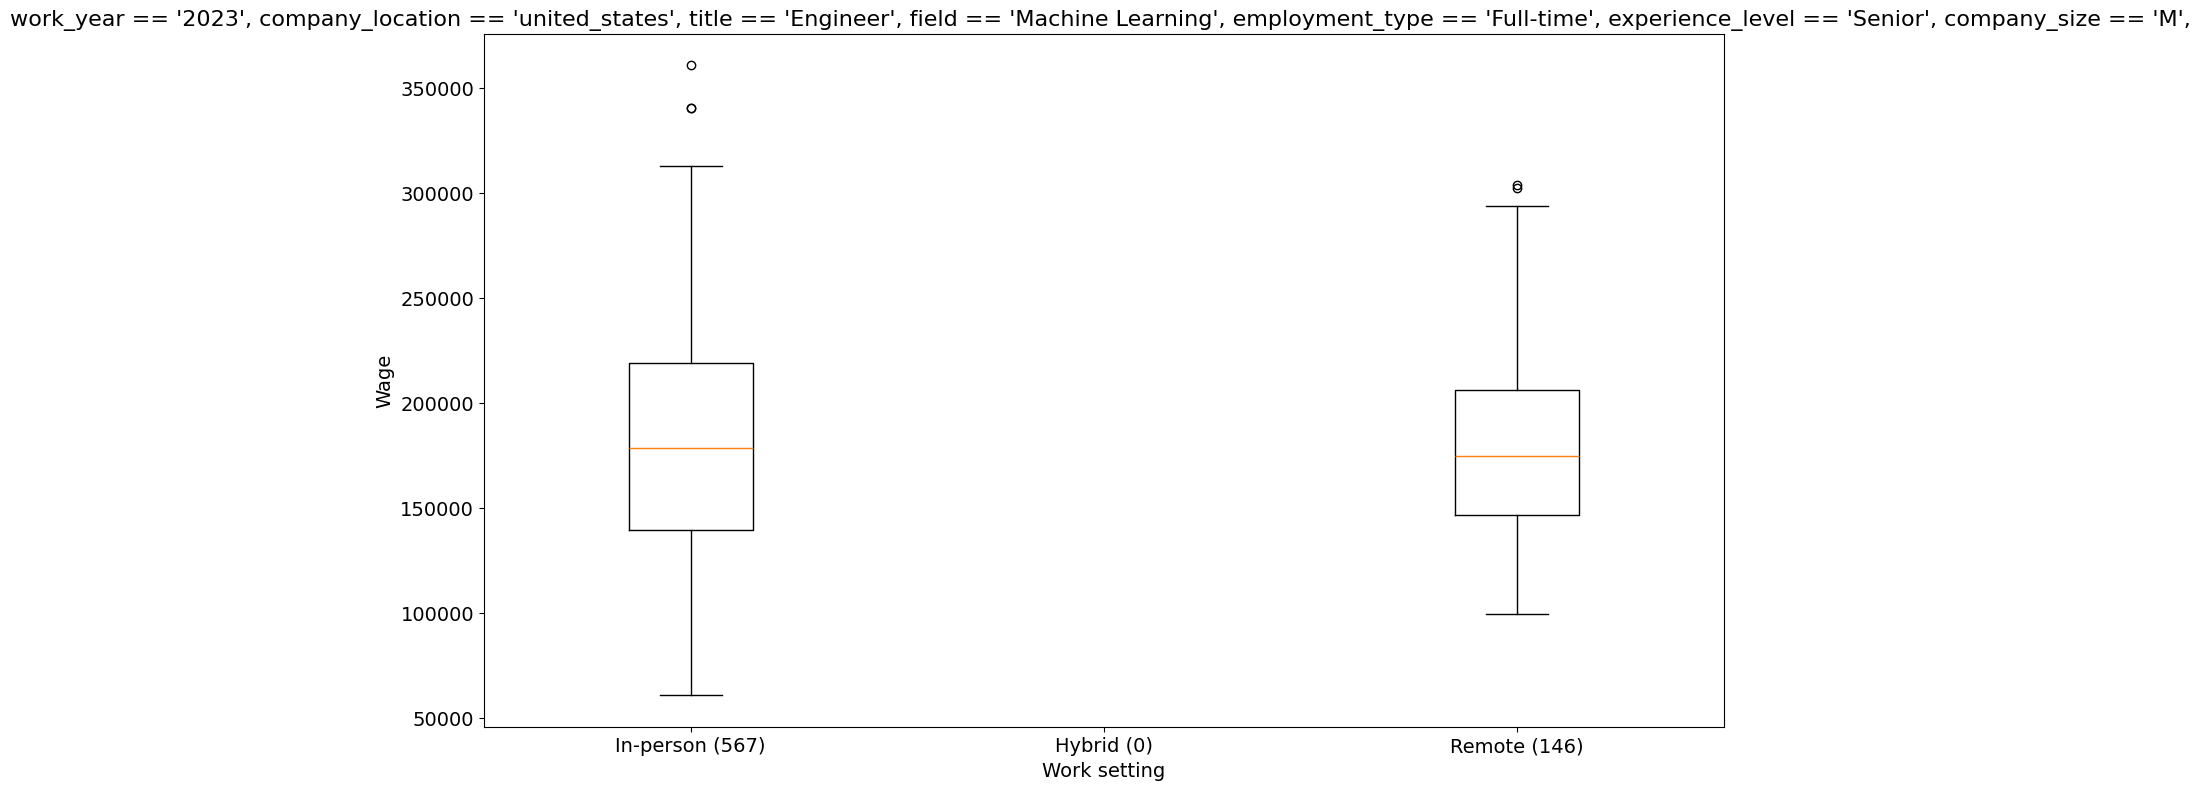

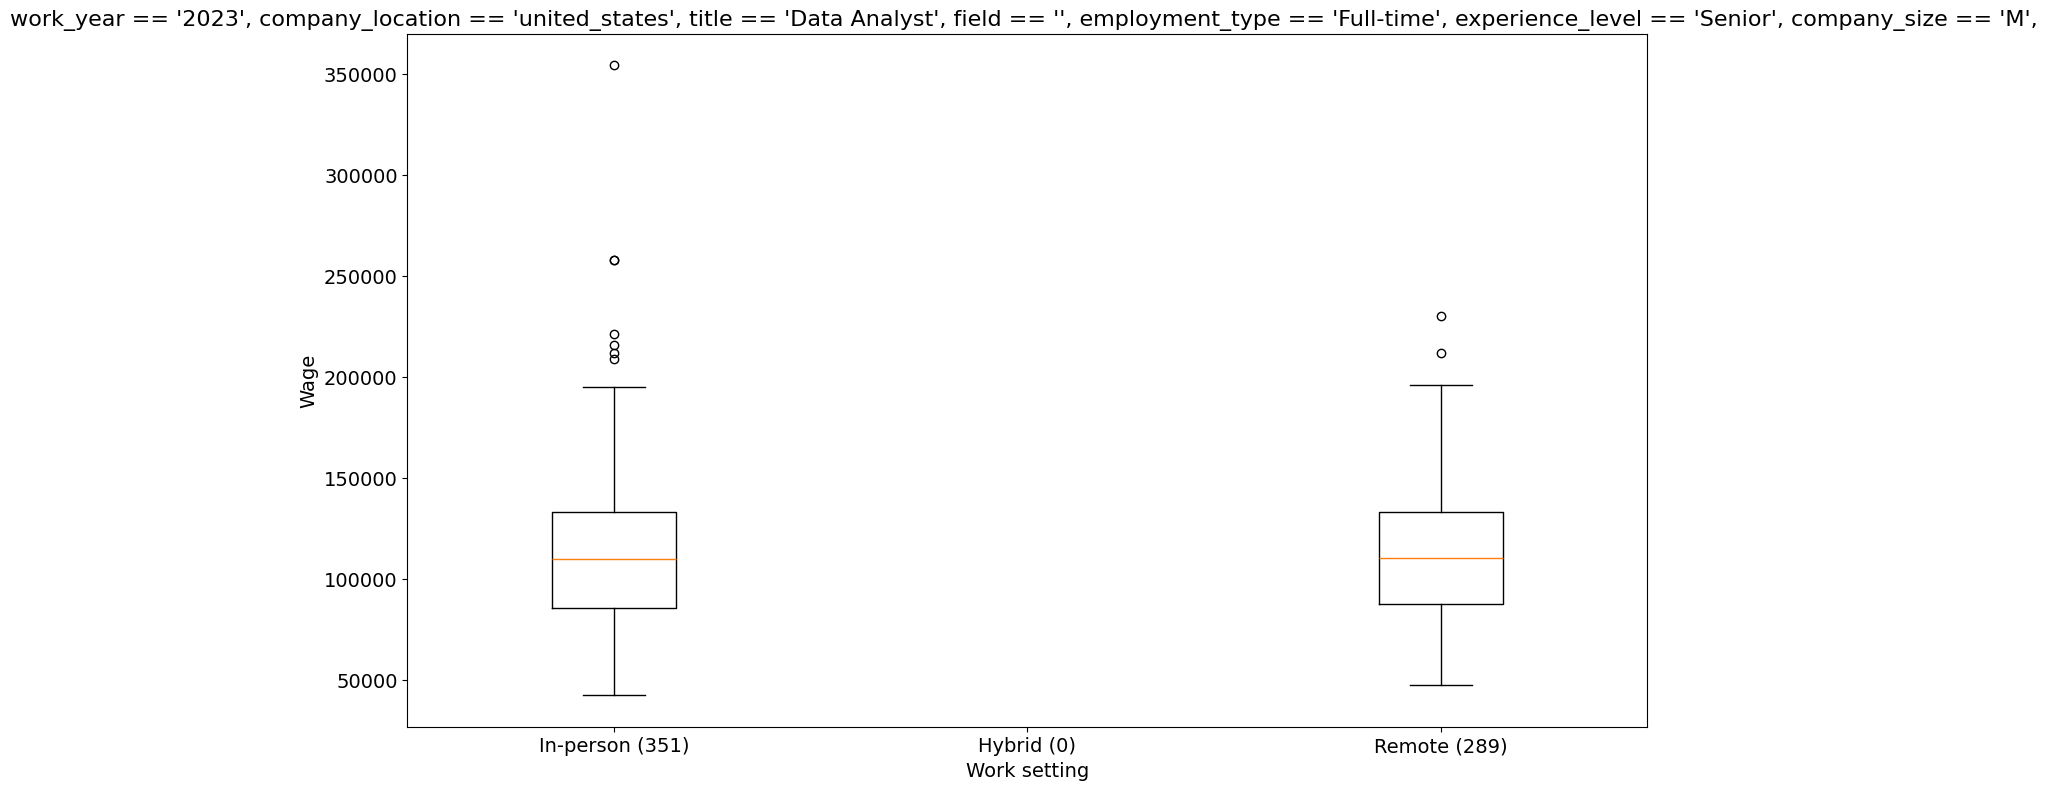

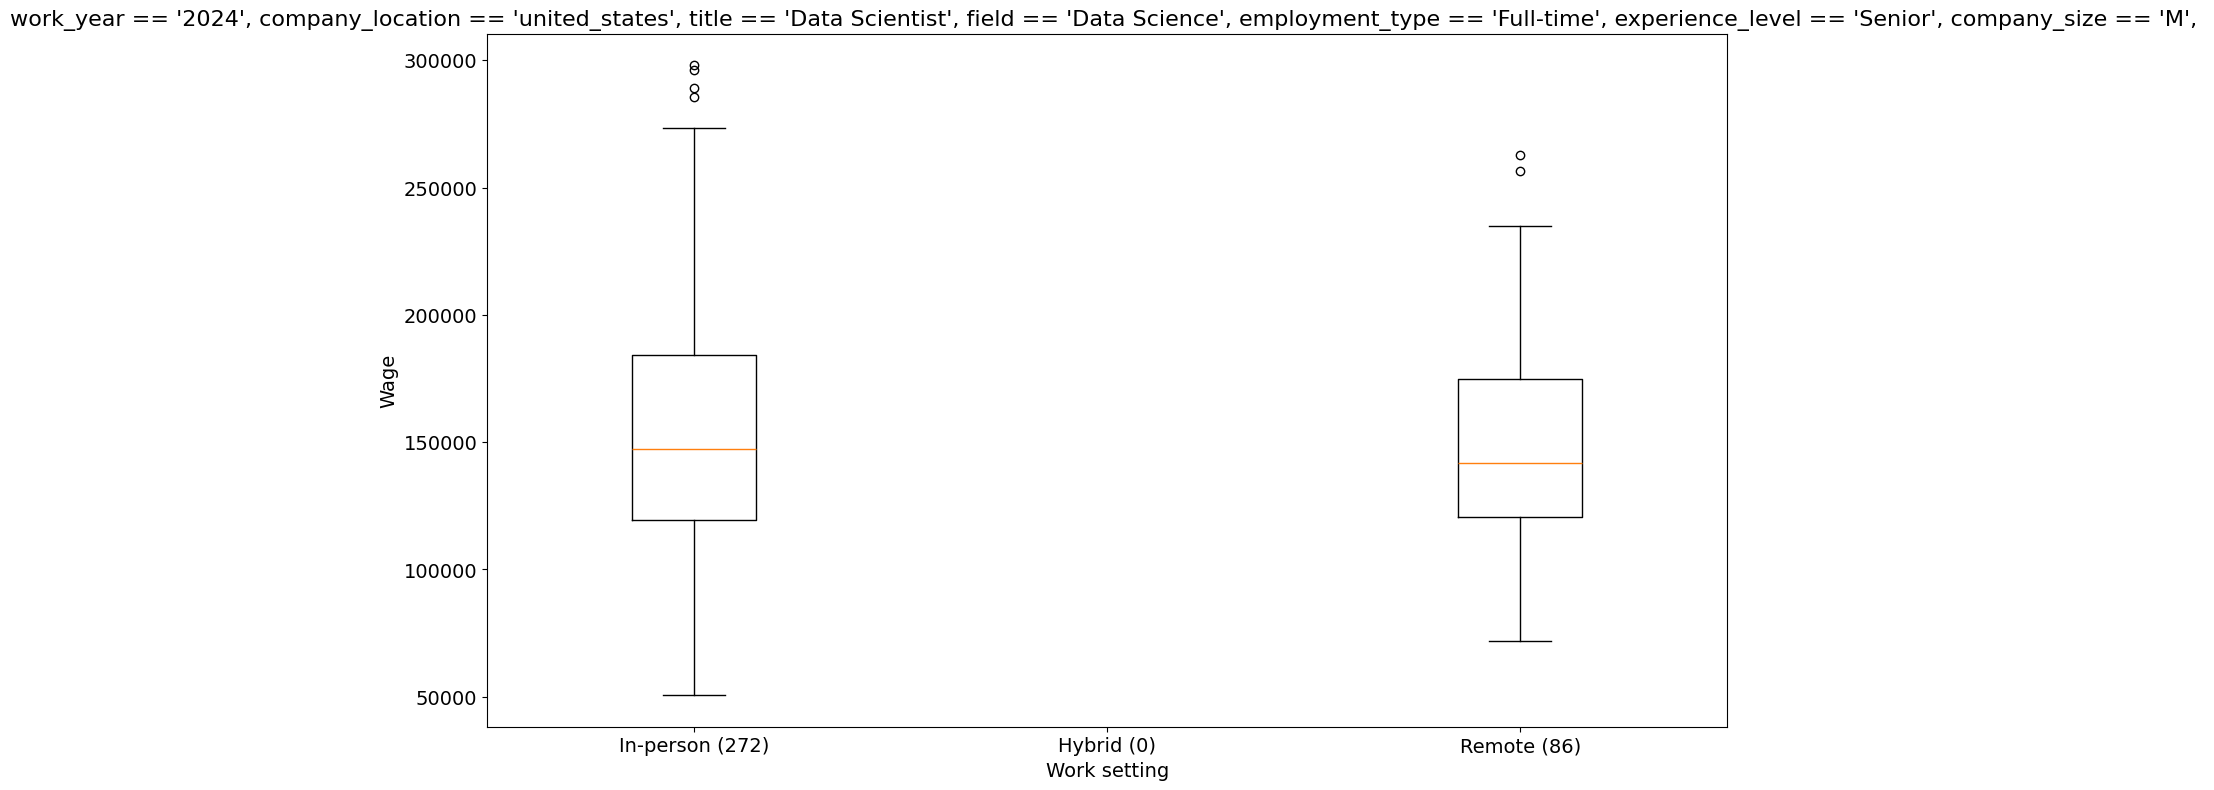

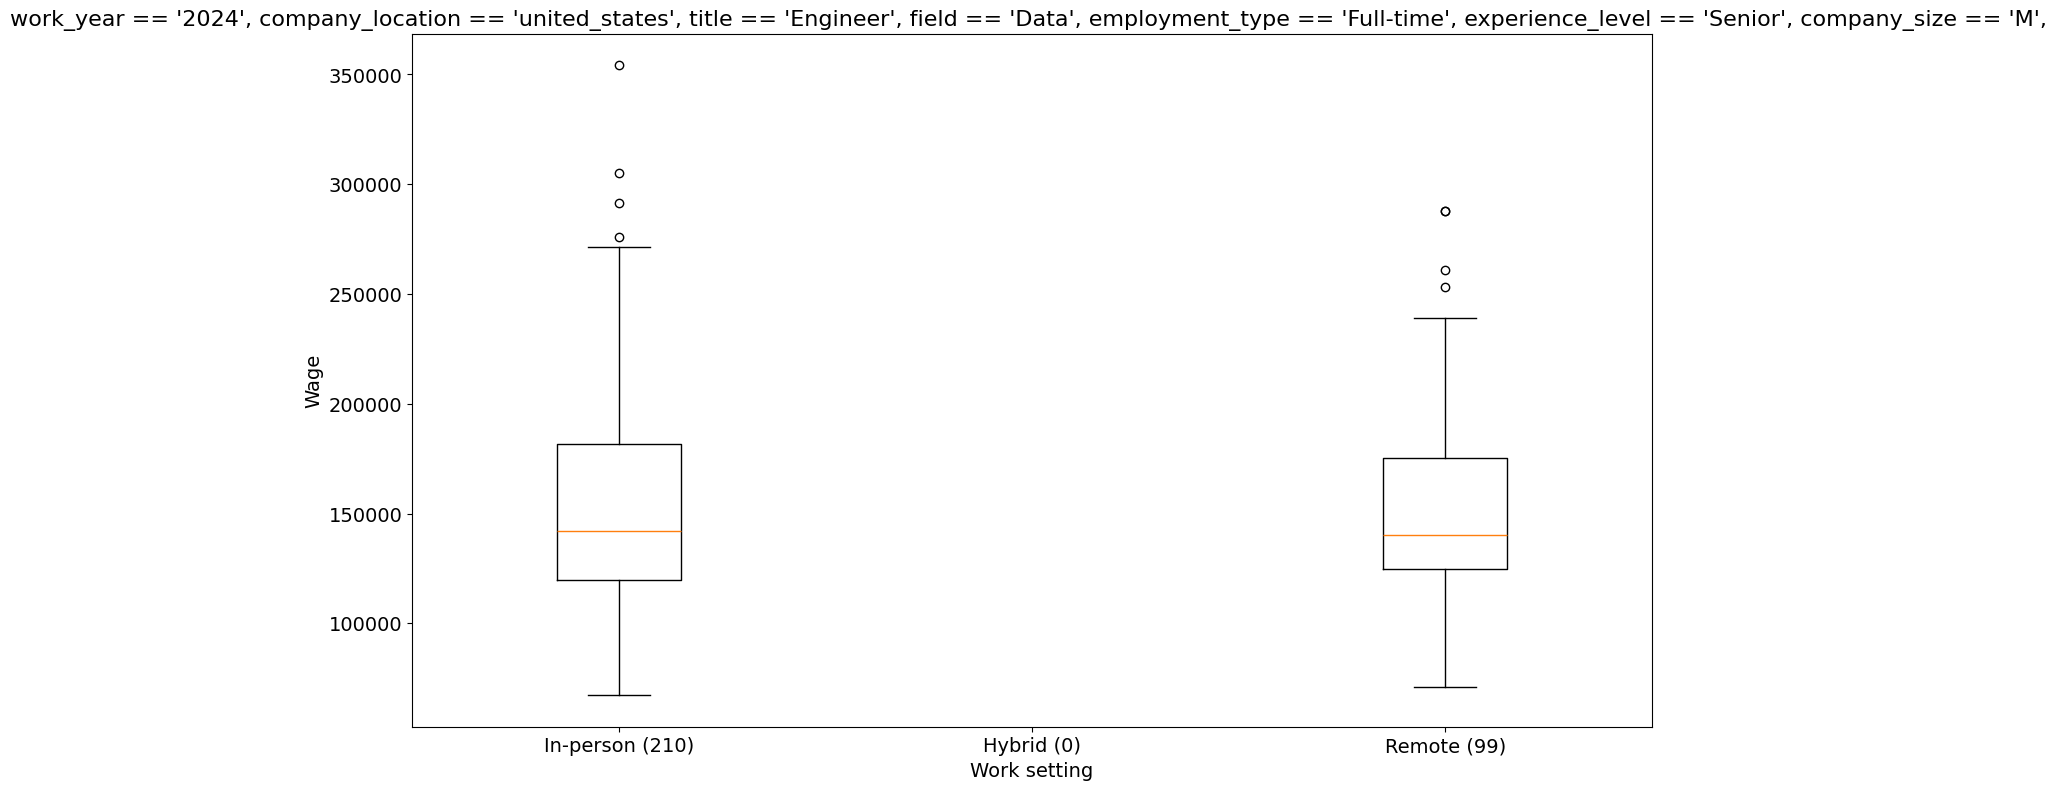

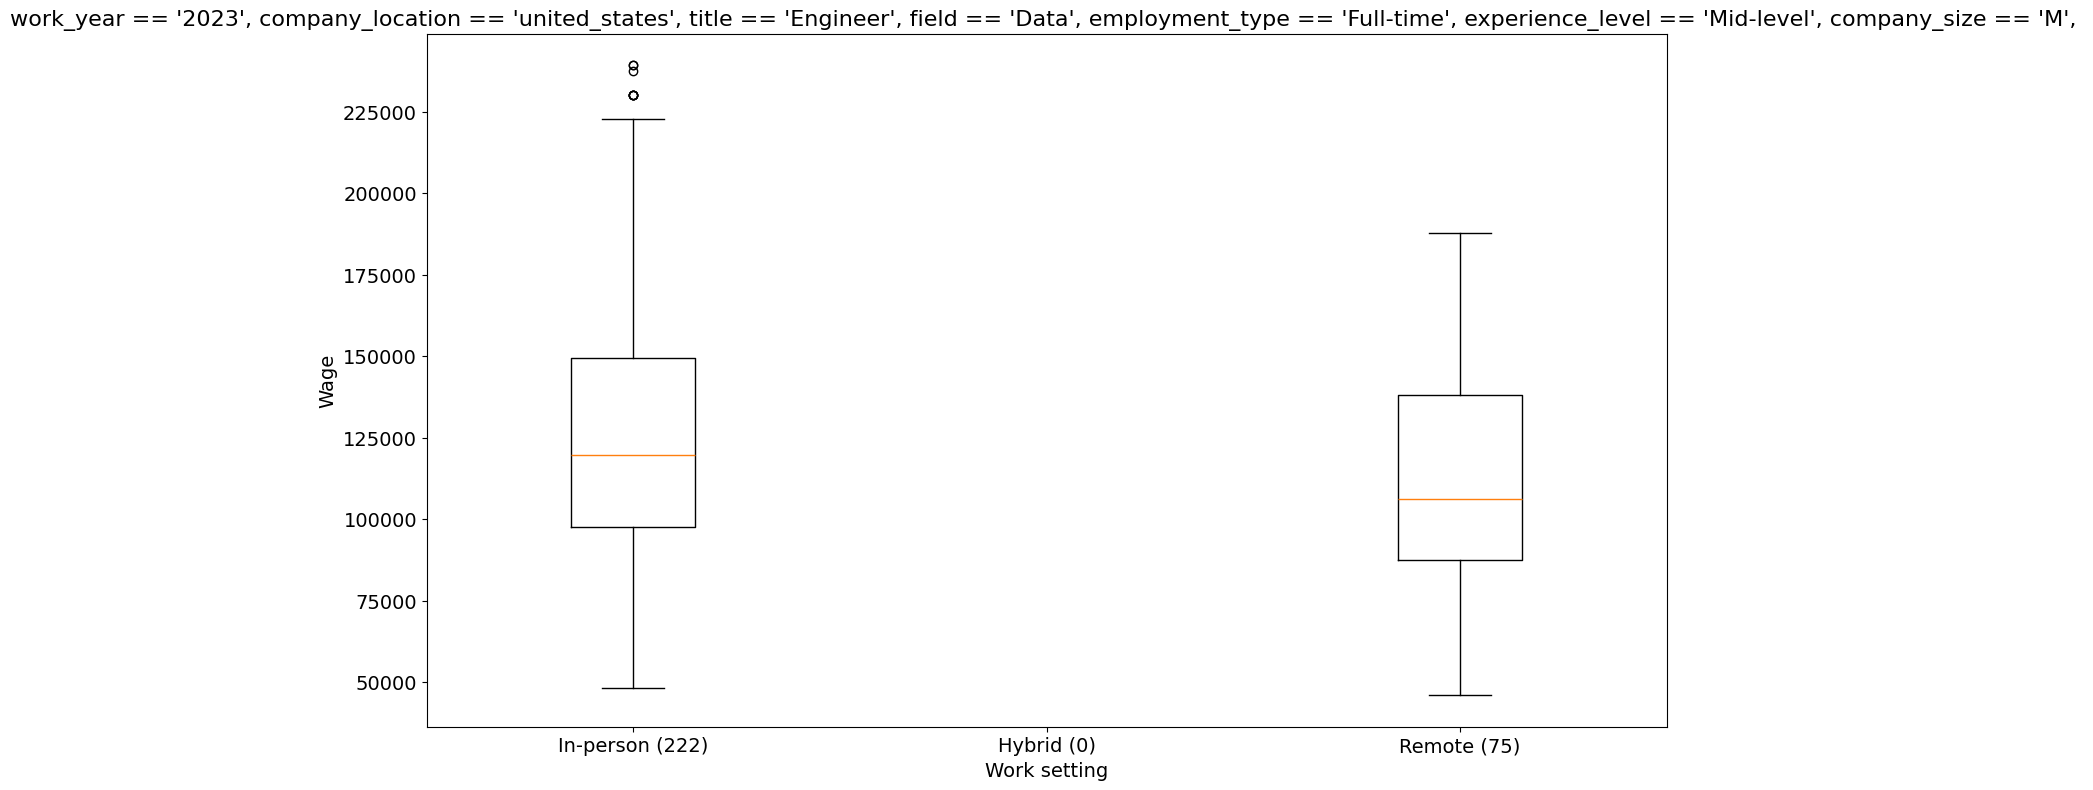

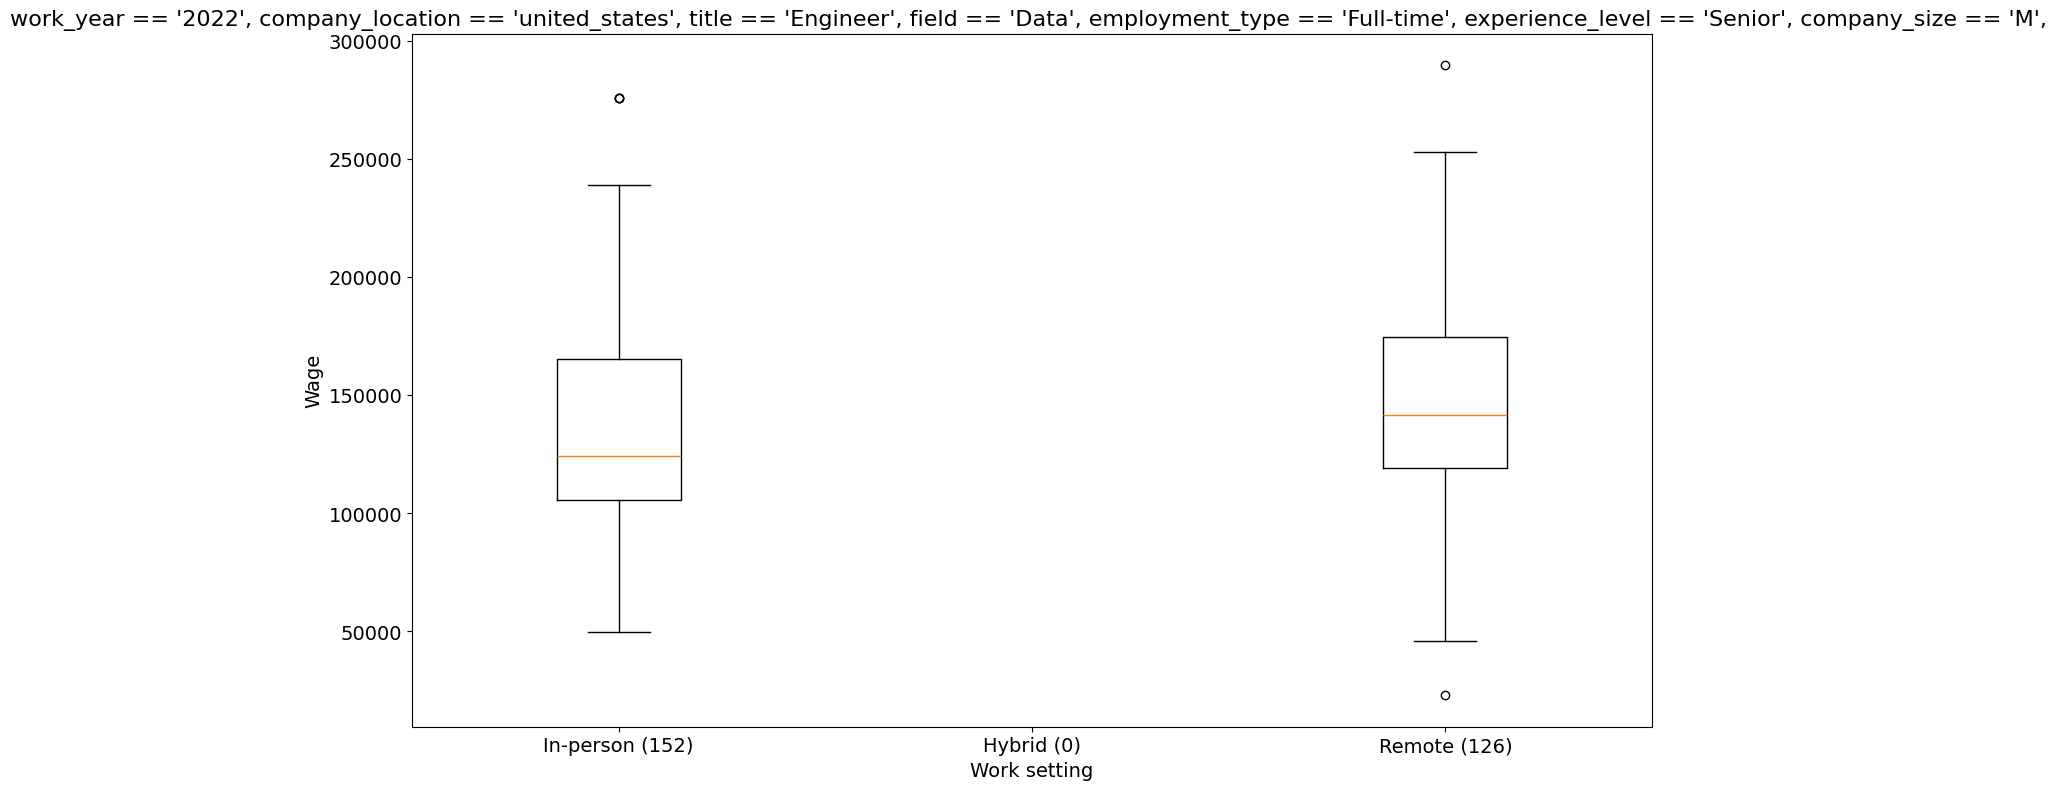

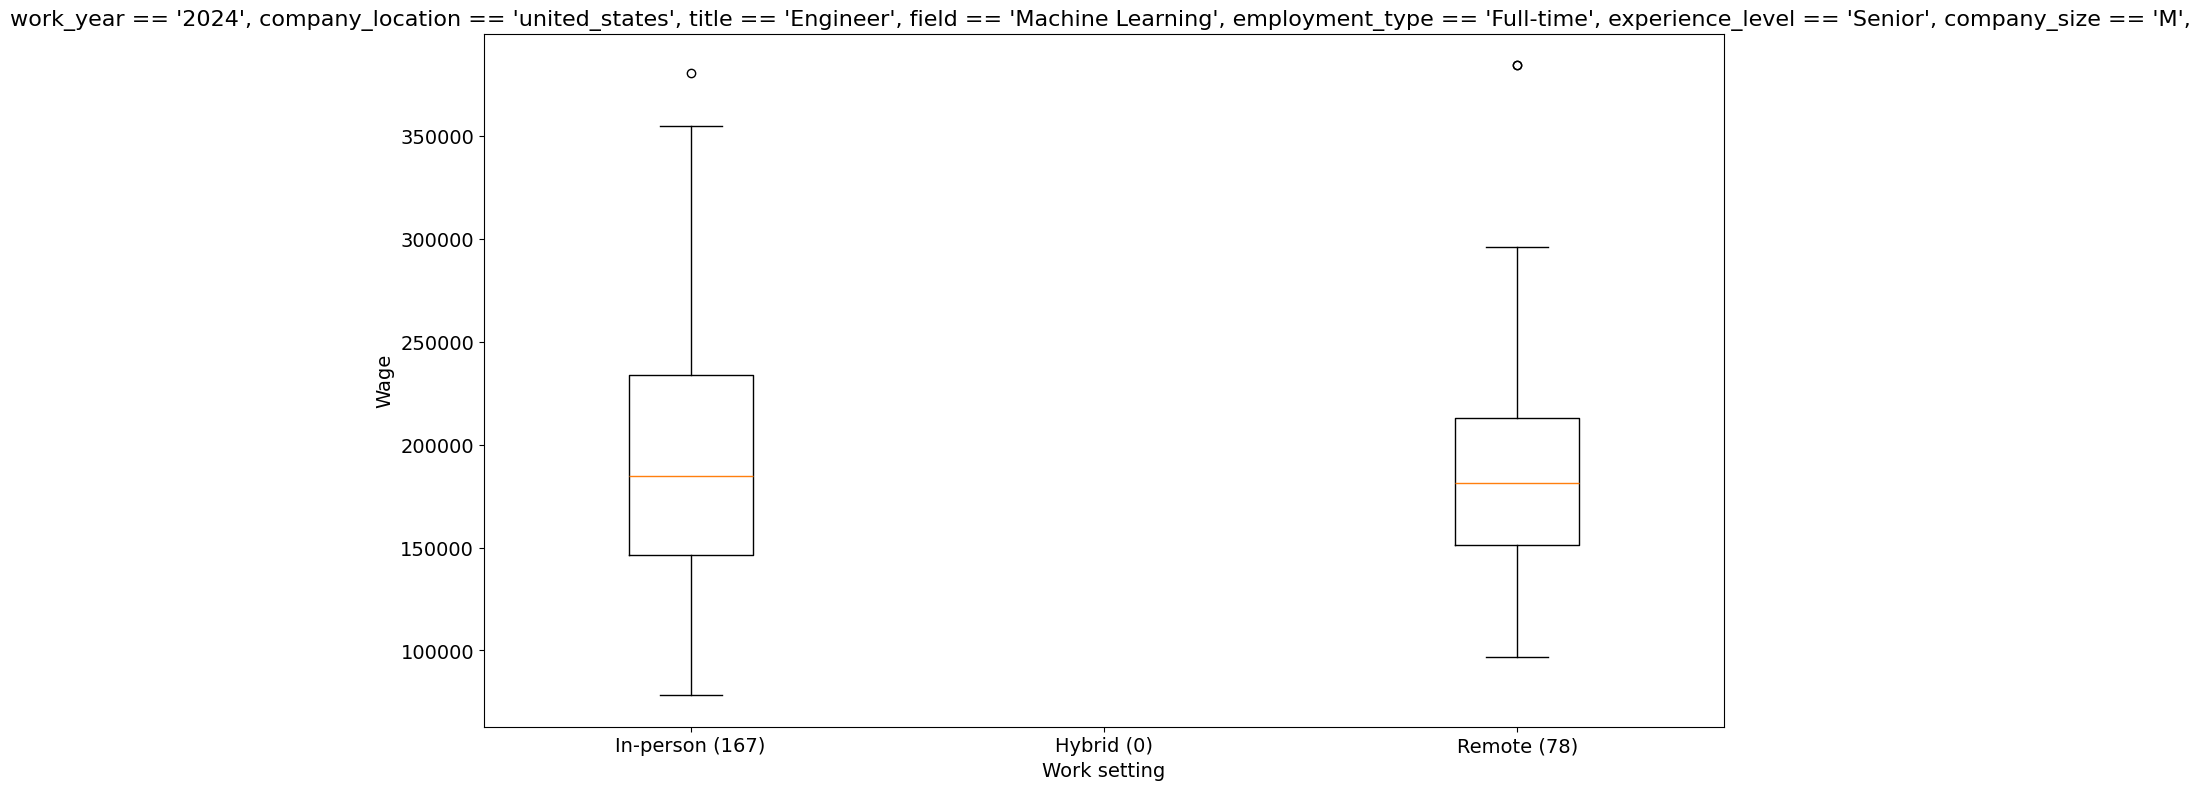

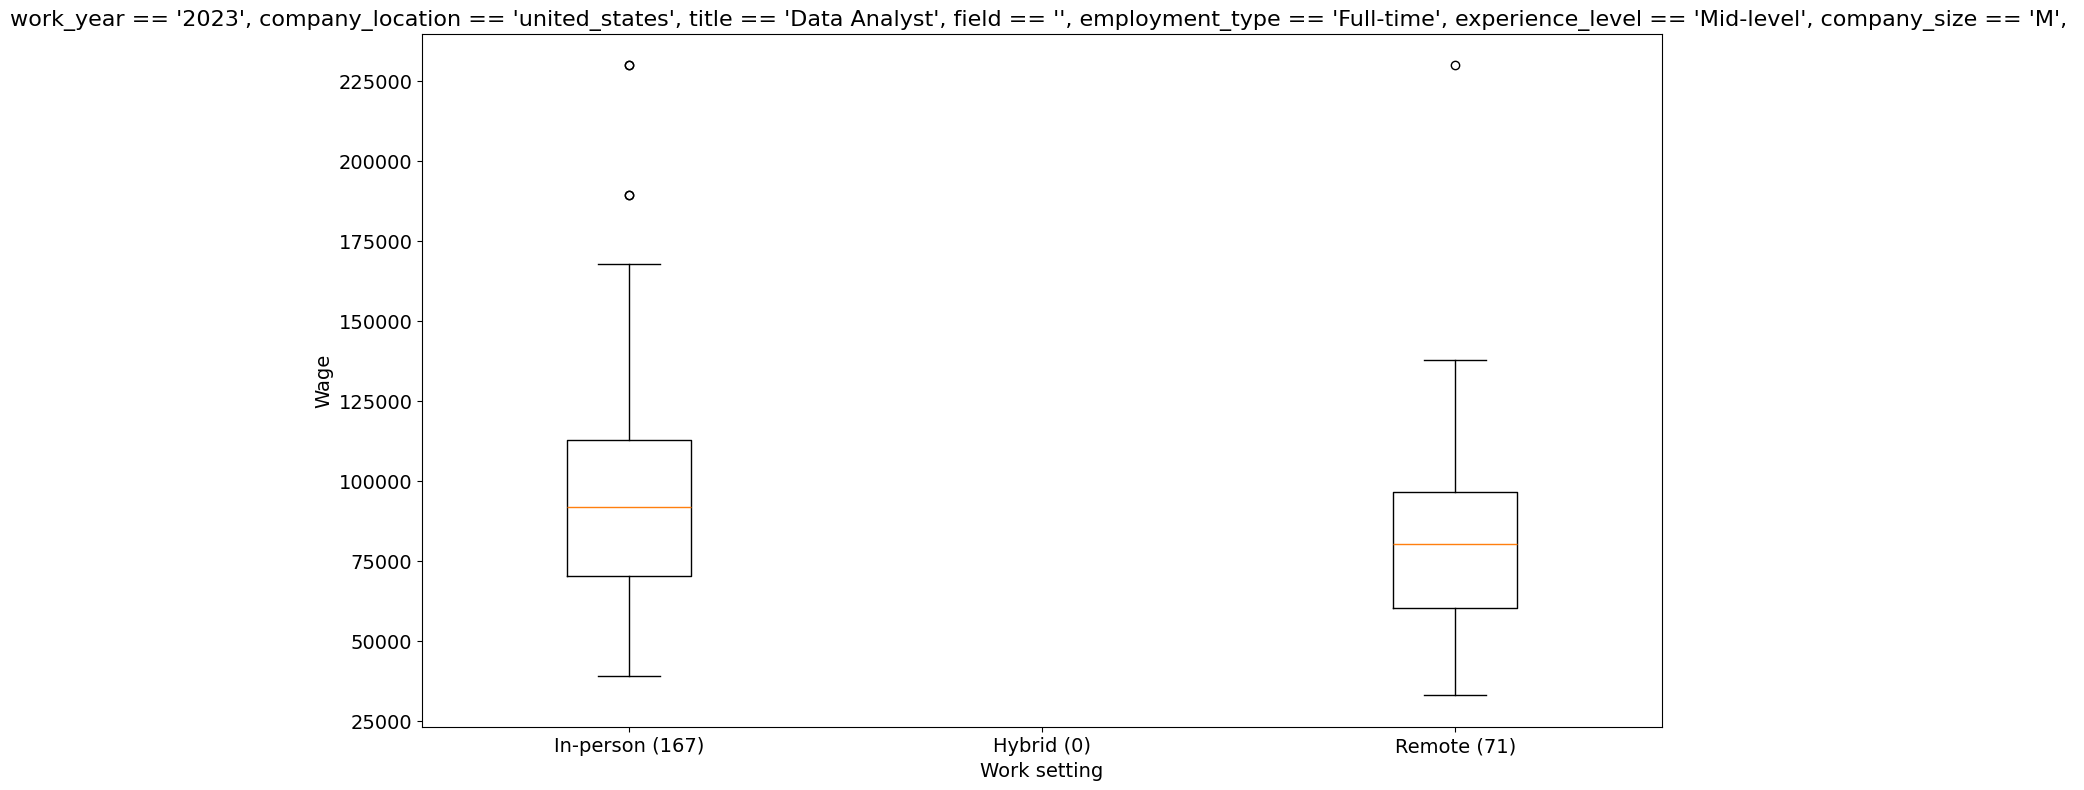

In [66]:
for i in range(0, 10): 
    #let's inspect the top 10 clusters with the most entries according to our constraints set at the start of step 6.5.
    [subset, title] = h.query_main_dataframe(i, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

In the top ten most common listings there is no clear evidence that the work setting has an impact on wage. Let's check for ten random listings: 

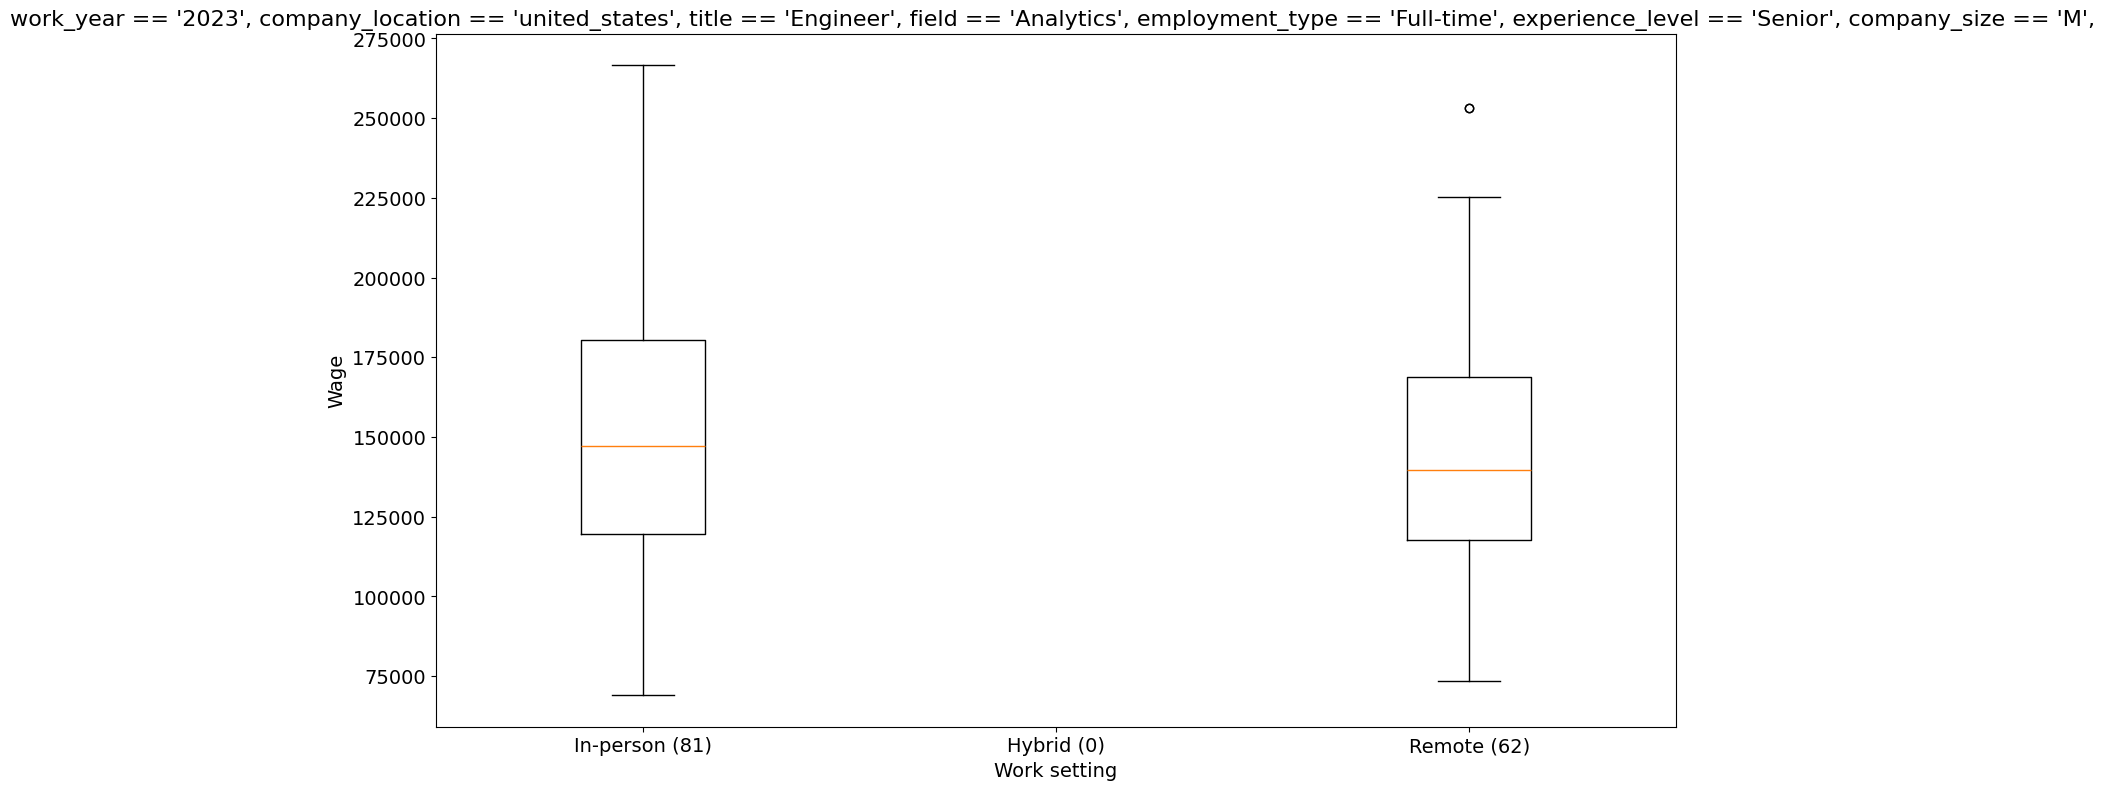

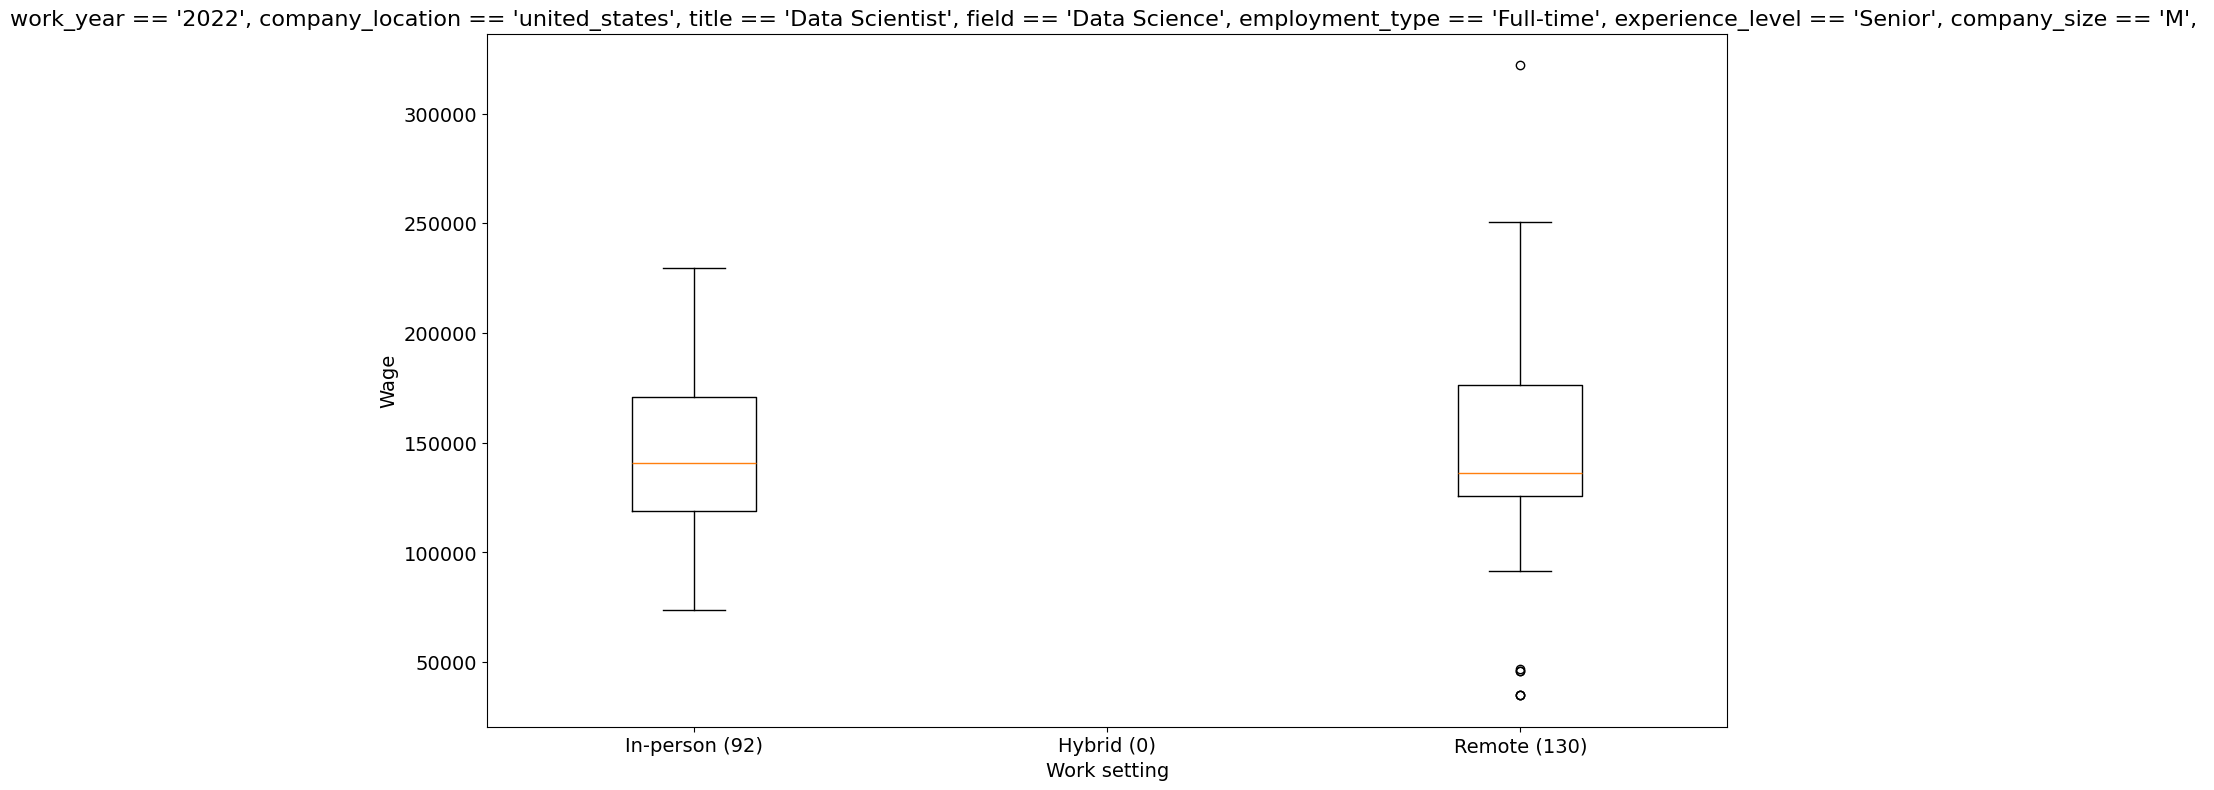

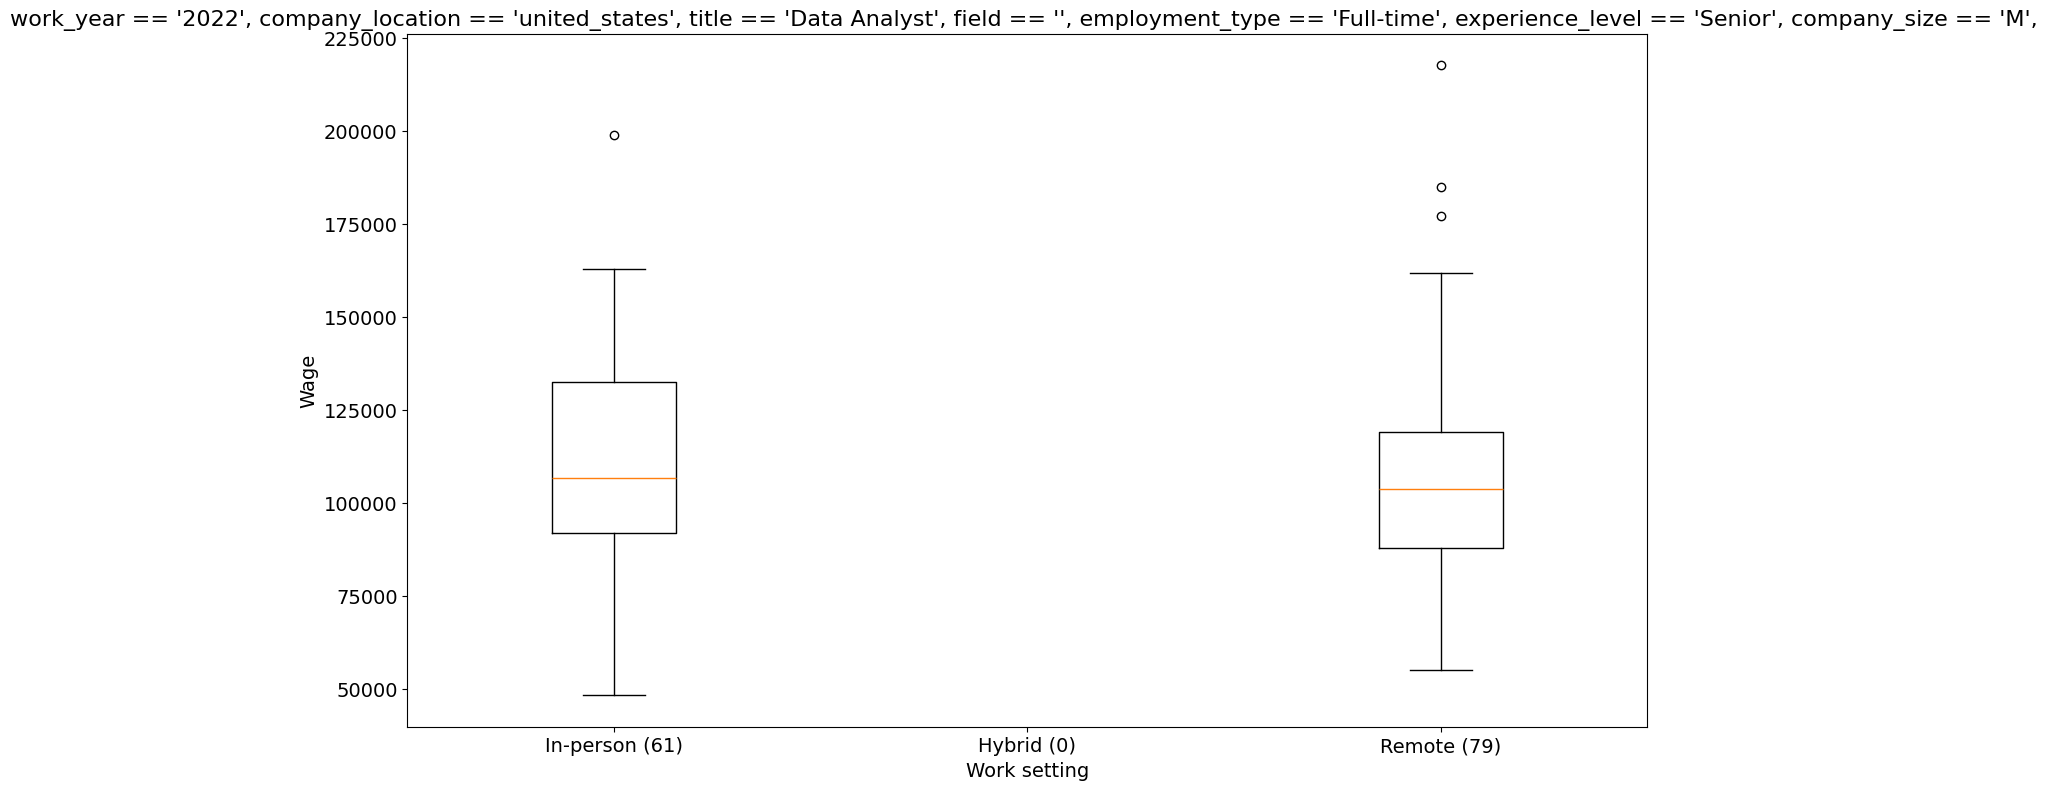

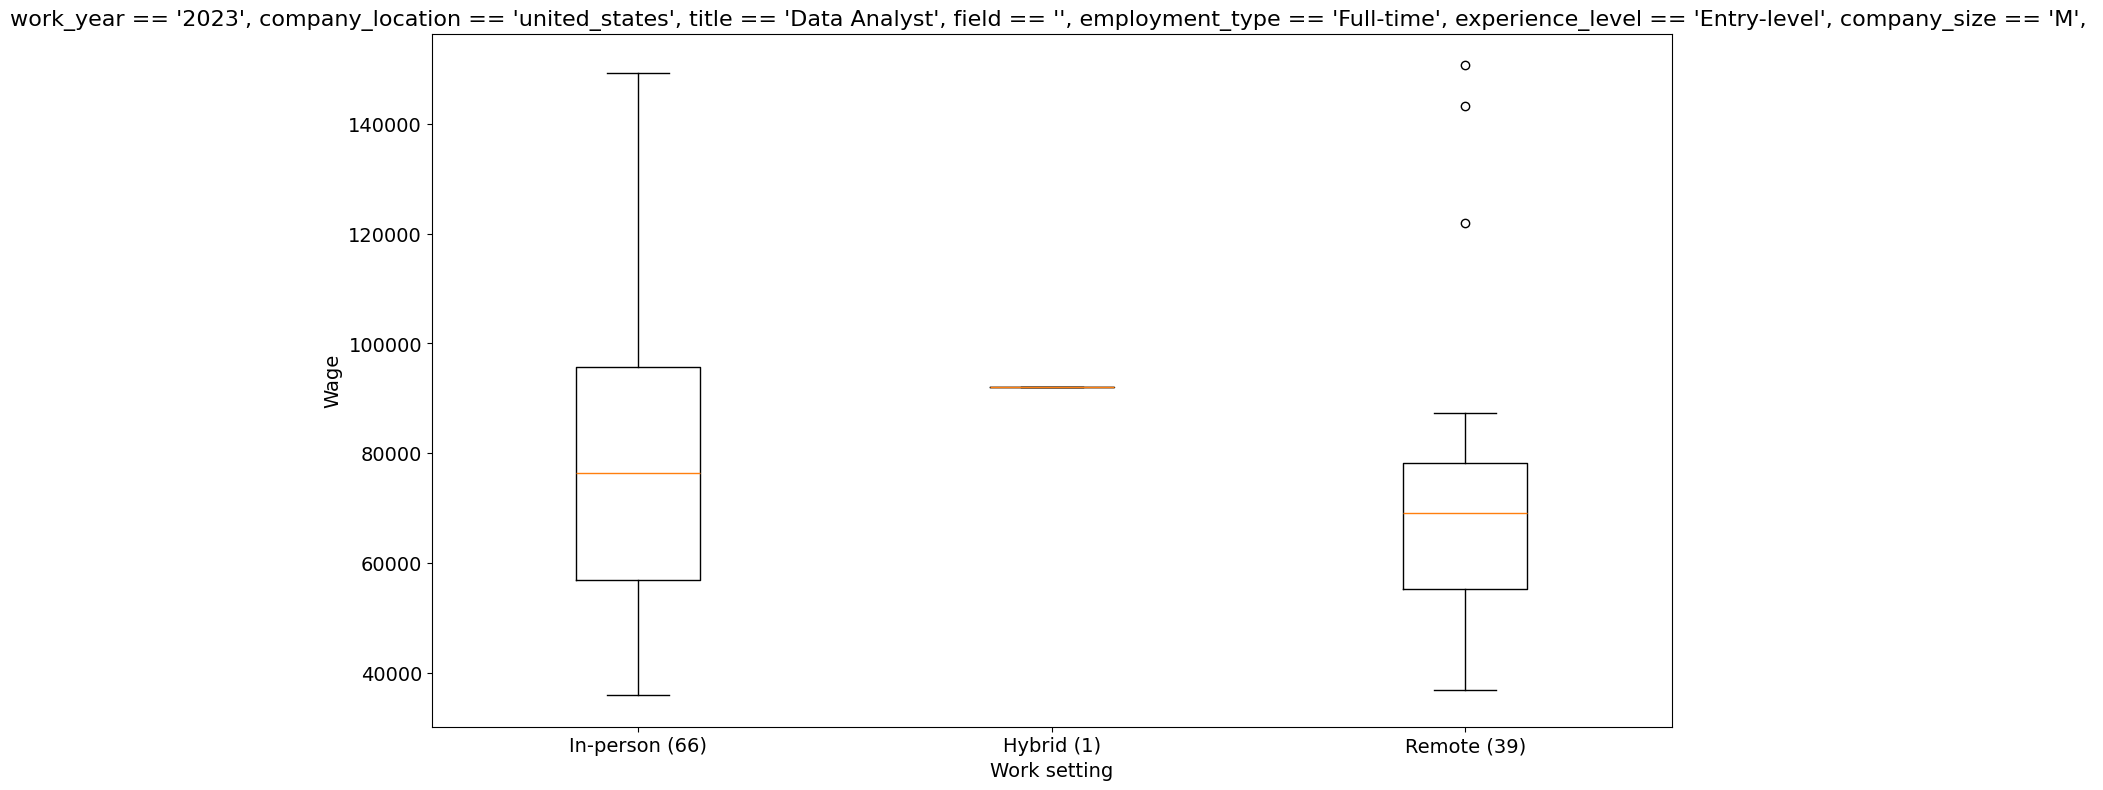

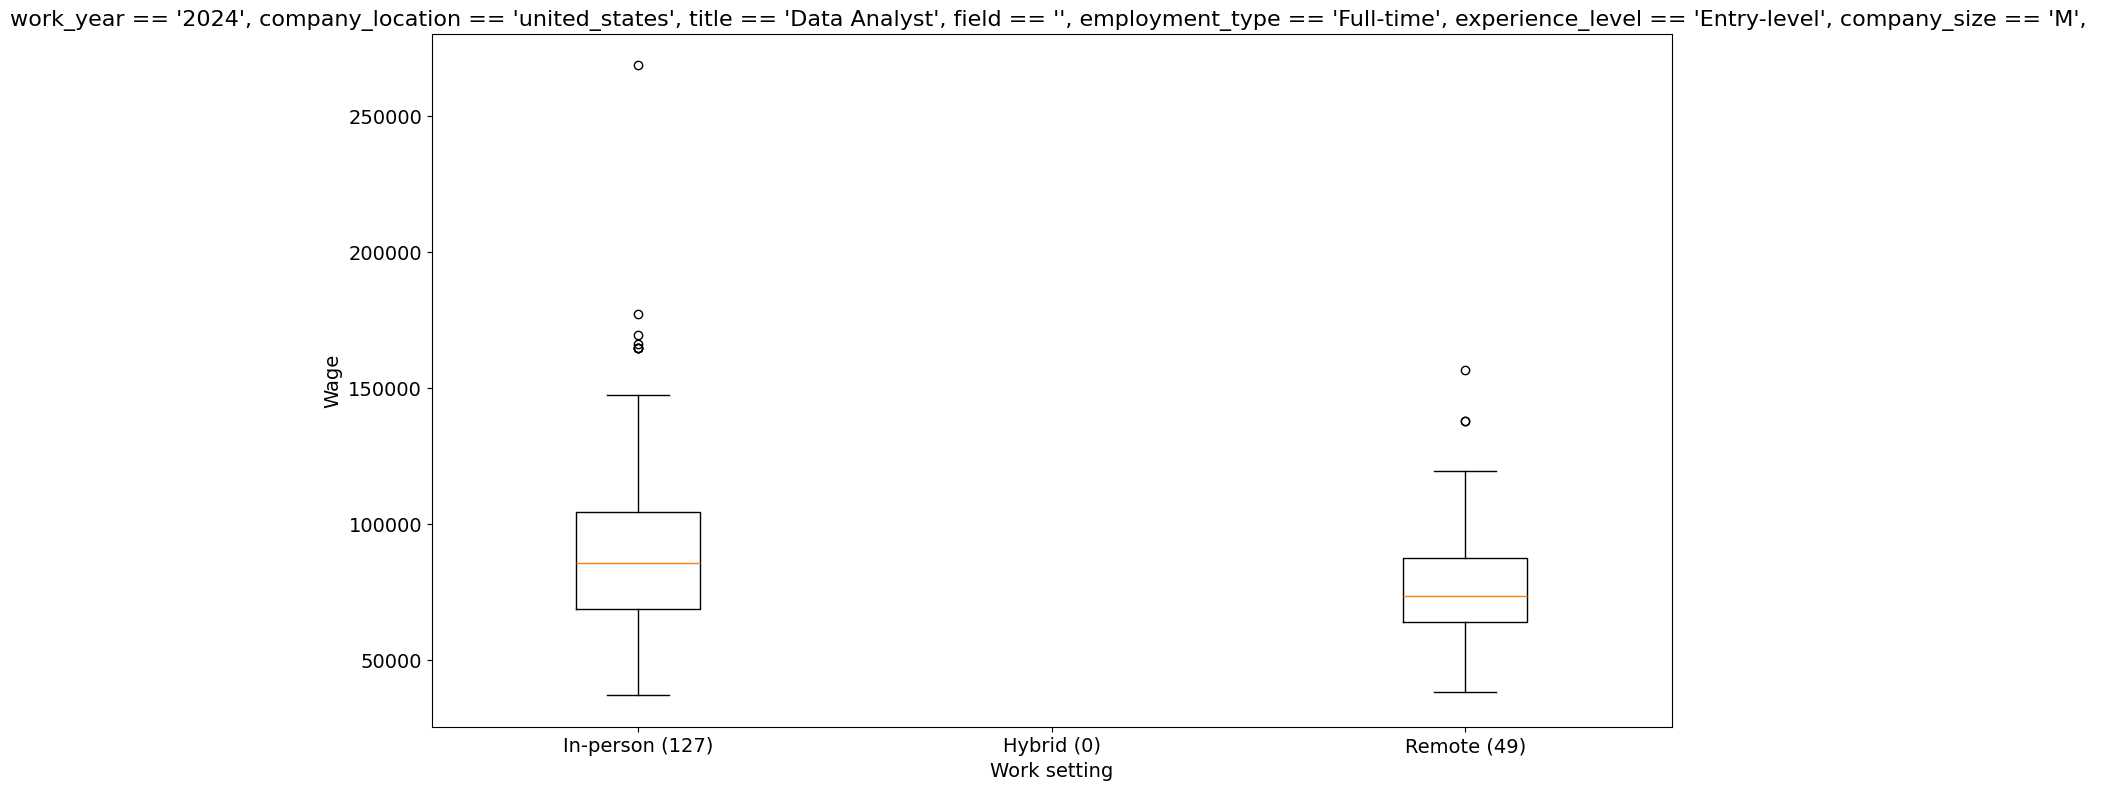

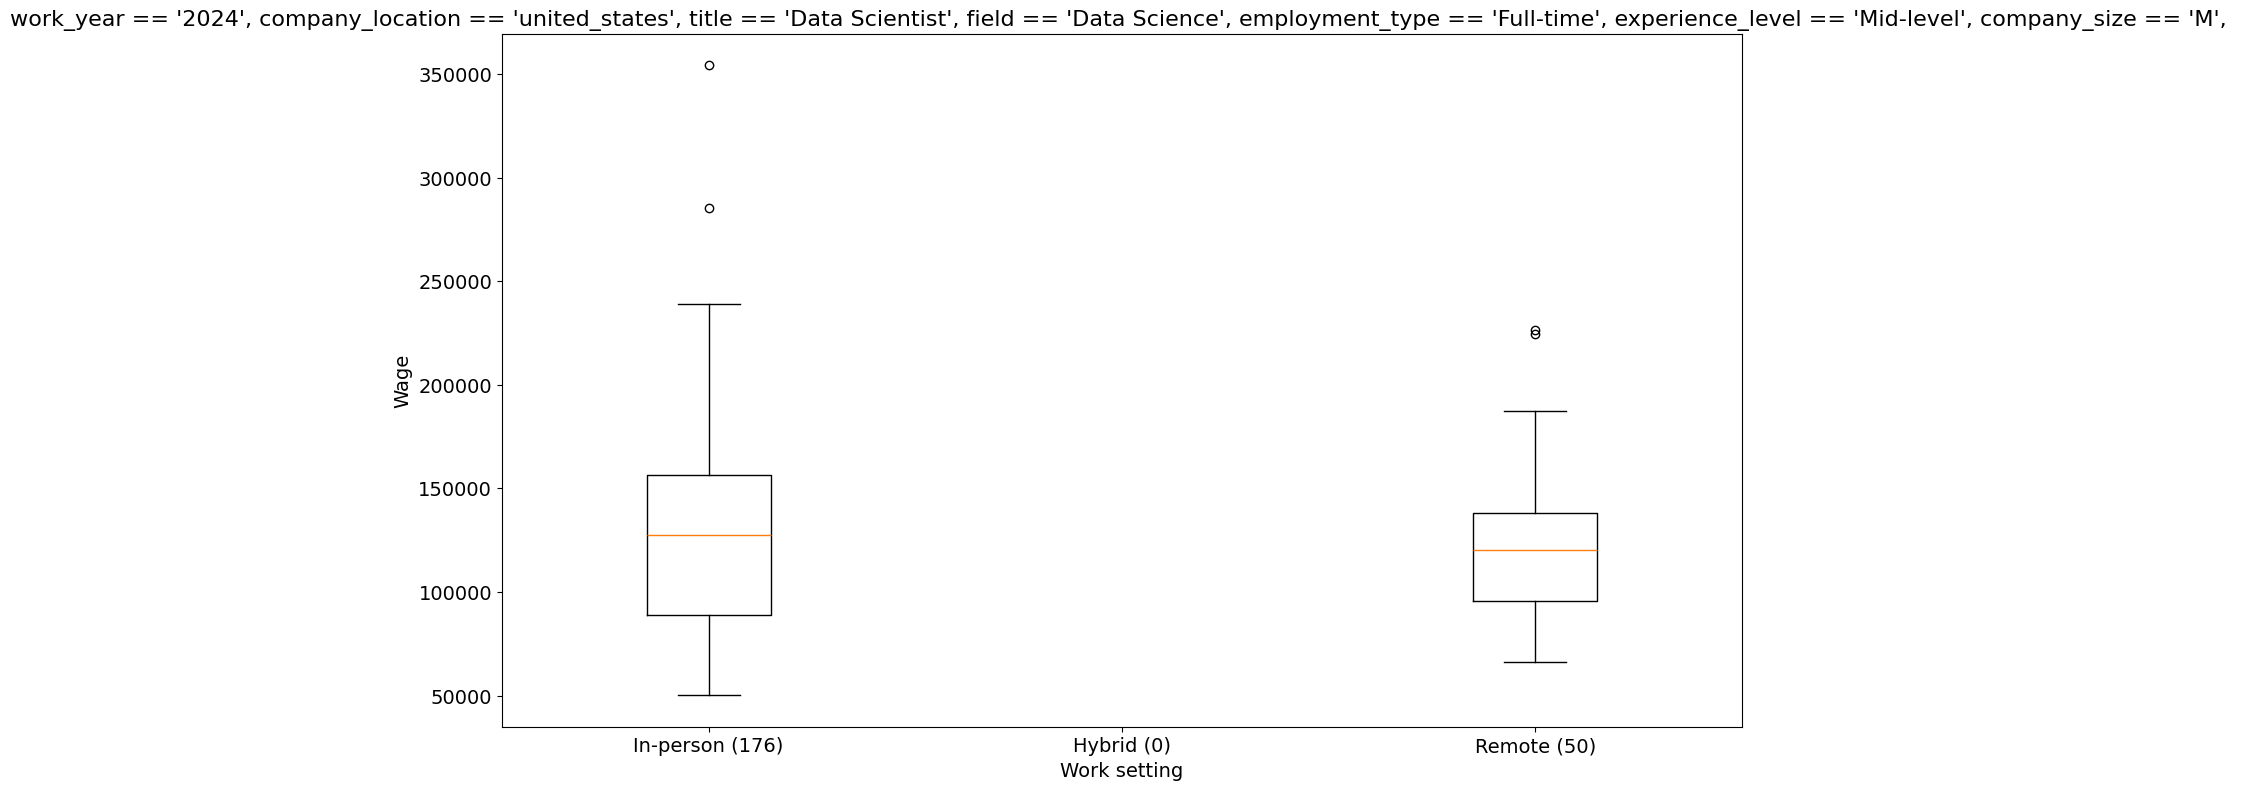

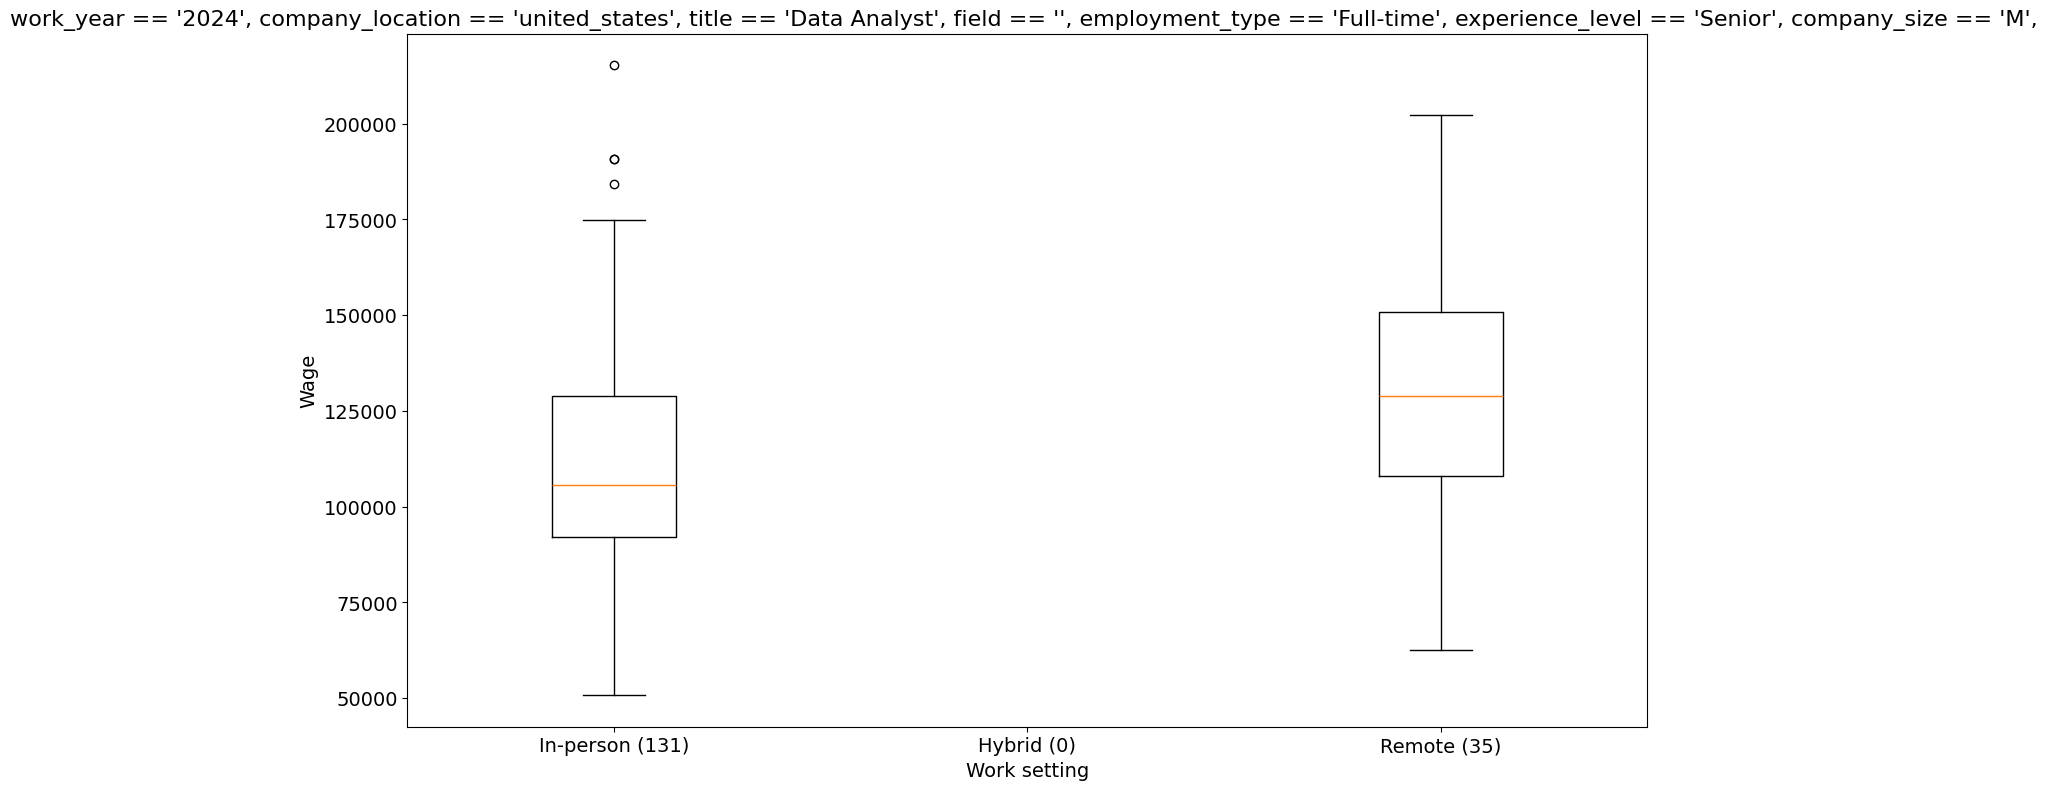

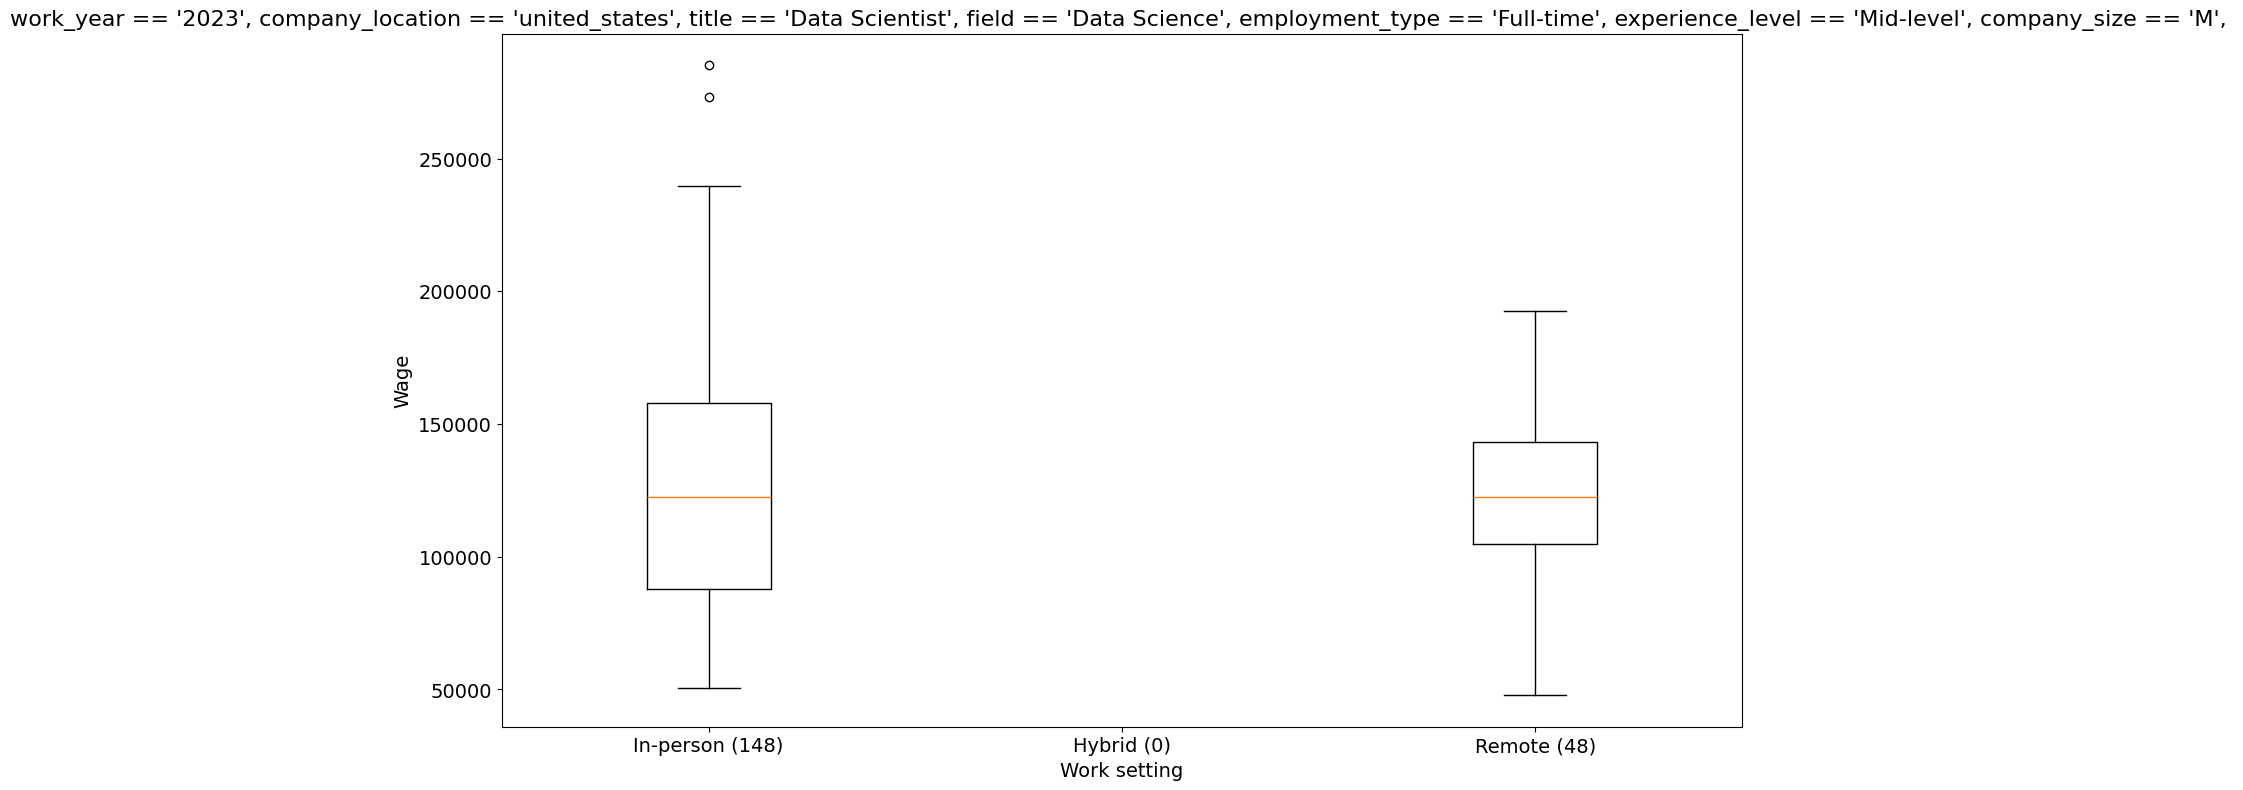

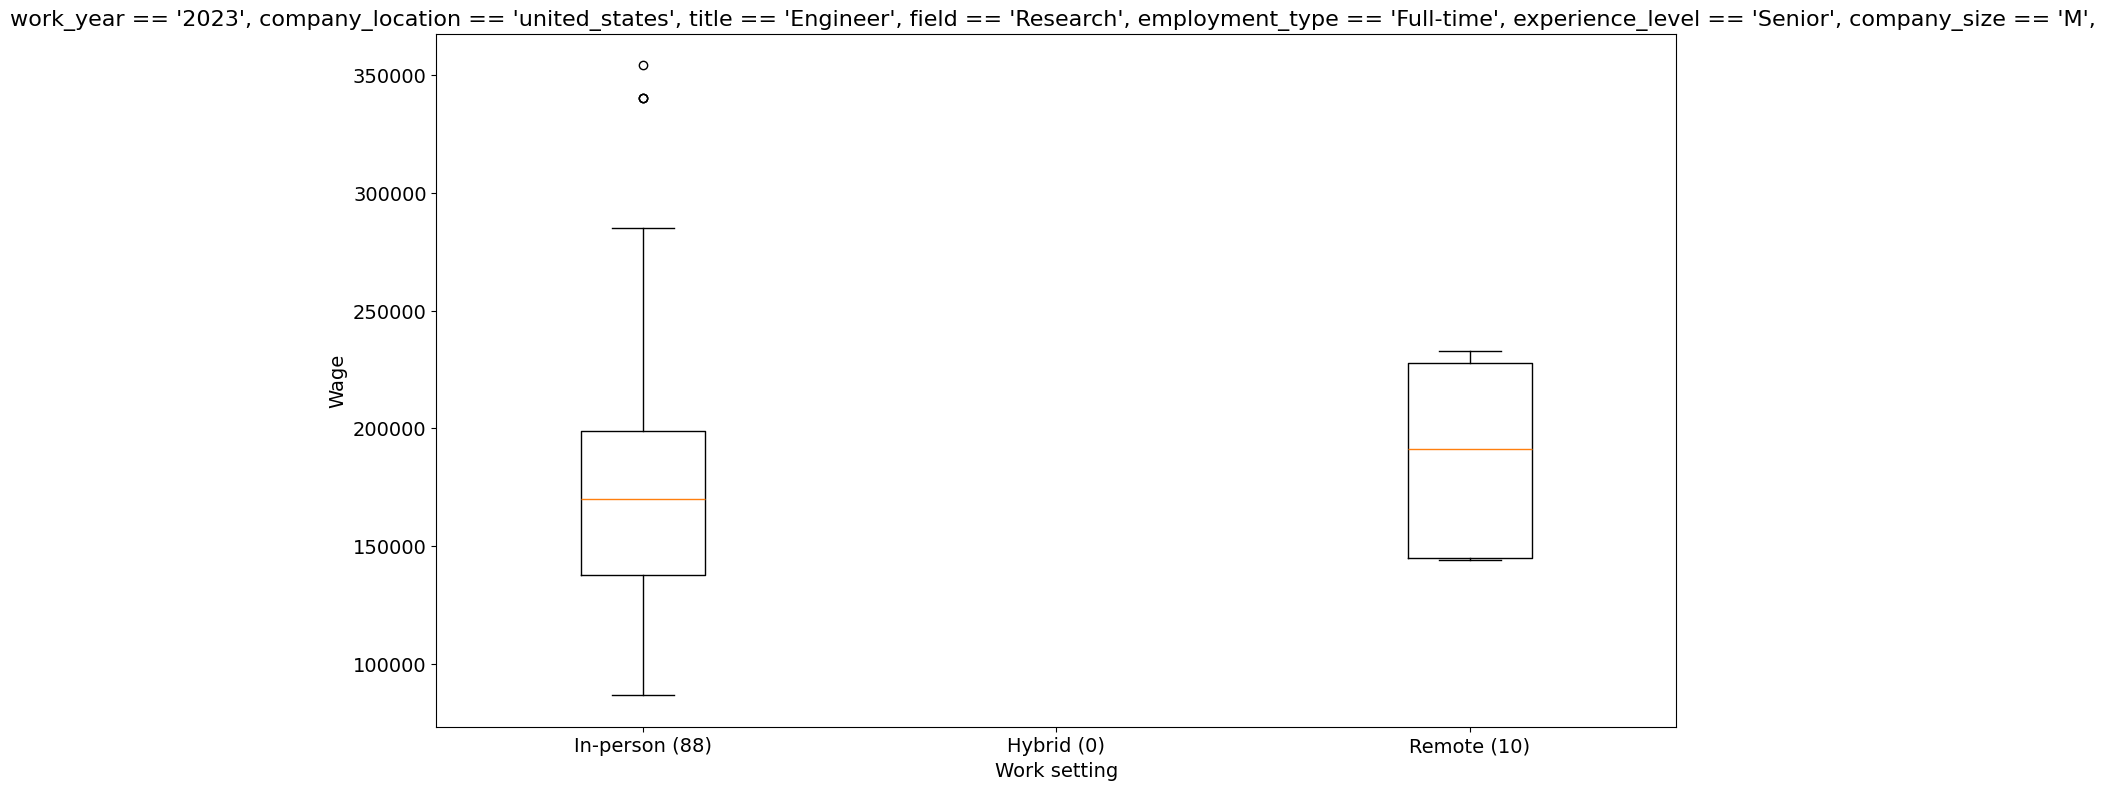

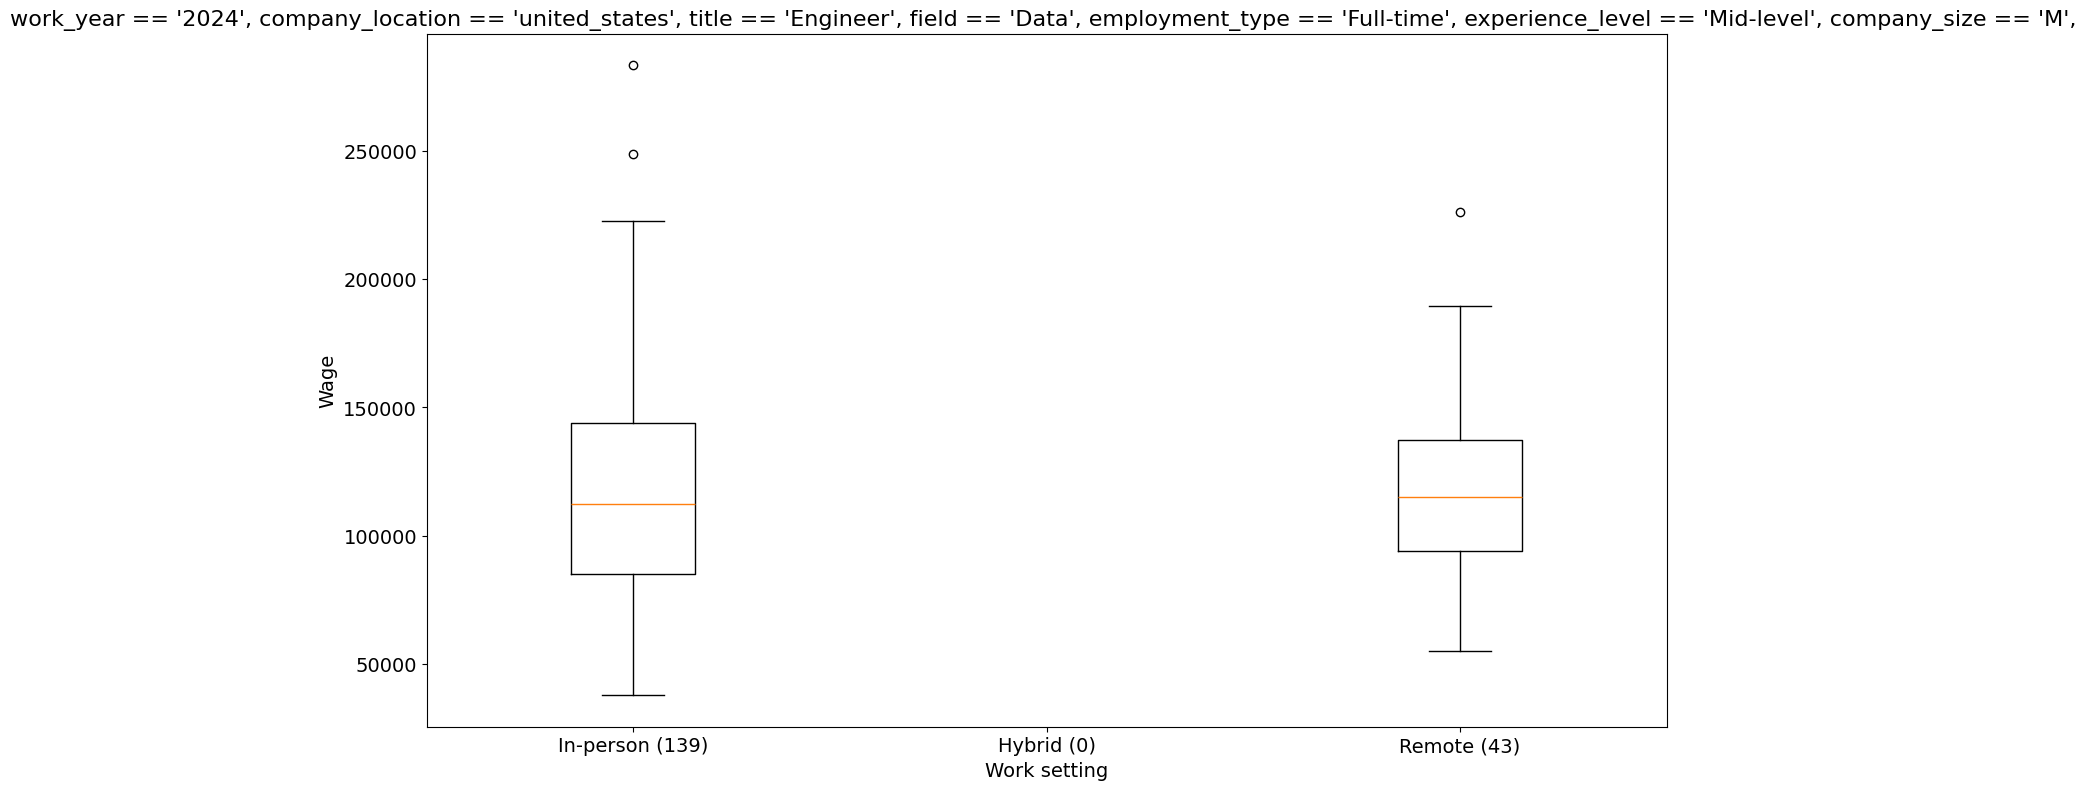

In [67]:
min_listings = 100
lmax = len(clusters.query("count>=@min_listings"))
picked_rows = random.sample(range(10, lmax+1), 10)
for row in picked_rows: 
    [subset, title] = h.query_main_dataframe(row, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

Randomly selecting rows does not make me wonder my preivous analysis - work_setting is no valuable feature. 

## 6.8 Impact dureation: halftime/fulltime.

In [68]:
df_processed.employment_type.unique()

array(['Full-time', 'Freelance', 'Contract', 'Part-time'], dtype=object)

In [69]:
key_for_question = 'employment_type'
clusters = h.make_clusters(df_processed, groupbykeys, key_for_question)
clusters.head(5)

work_year company_location           title             field experience_level company_size work_setting  count
930       2023    united_states        Engineer              Data           Senior            M    In-person    729
872       2023    united_states  Data Scientist      Data Science           Senior            M    In-person    672
972       2023    united_states        Engineer  Machine Learning           Senior            M    In-person    567
873       2023    united_states  Data Scientist      Data Science           Senior            M       Remote    418
846       2023    united_states    Data Analyst                             Senior            M    In-person    351

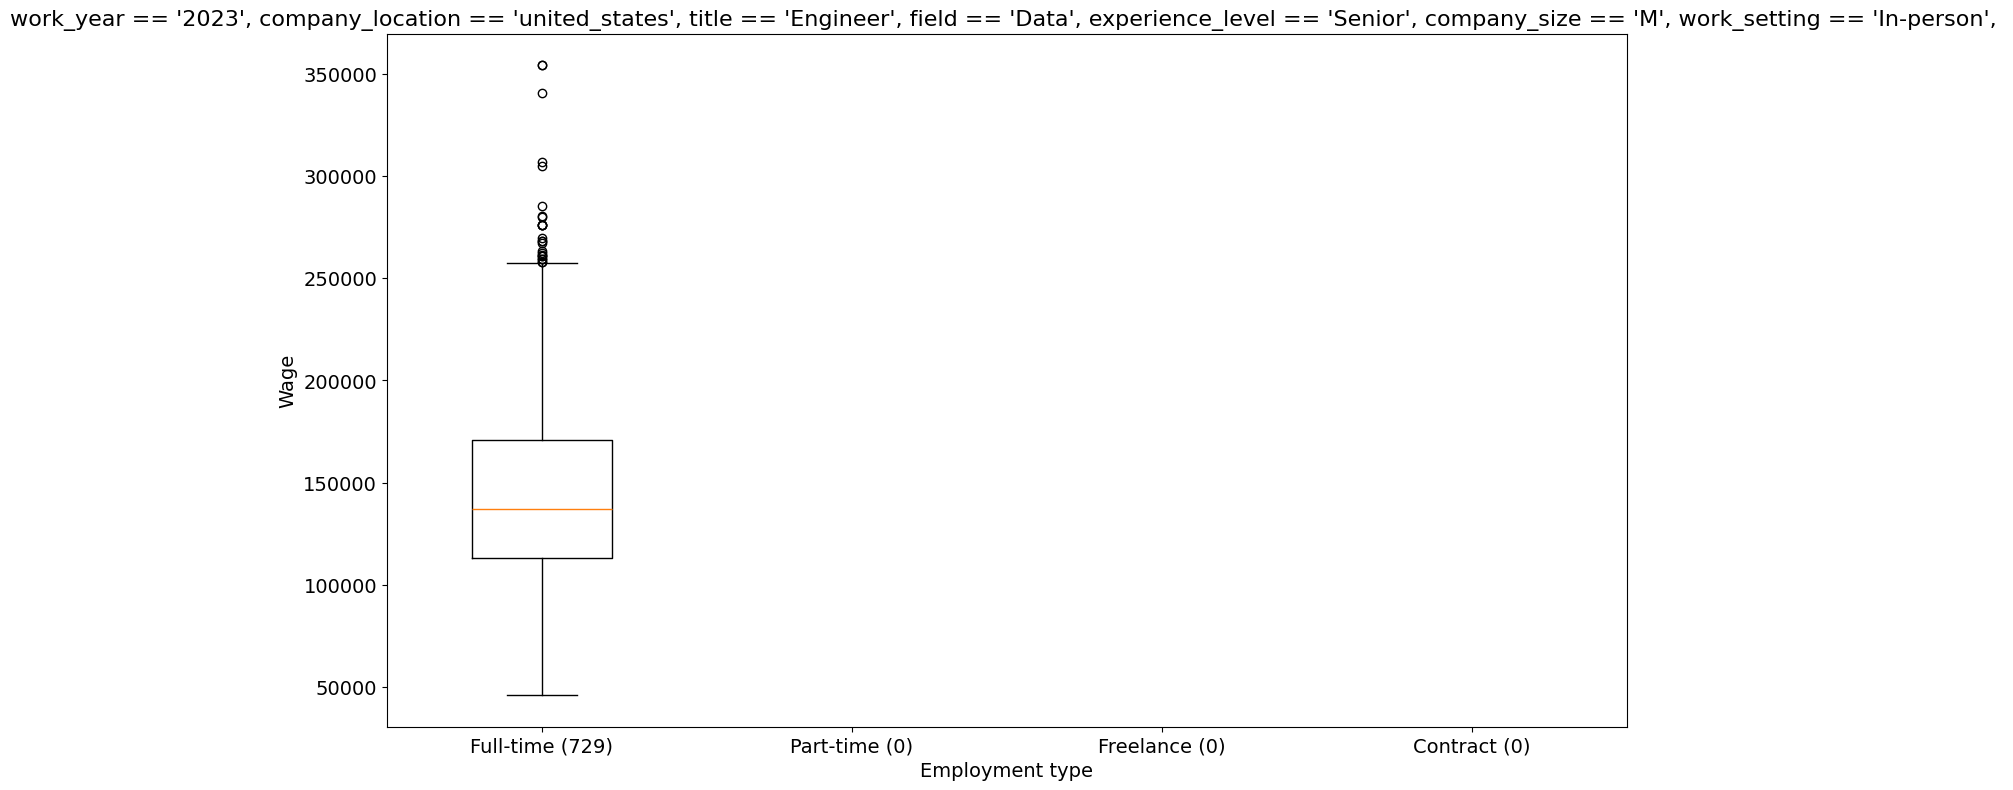

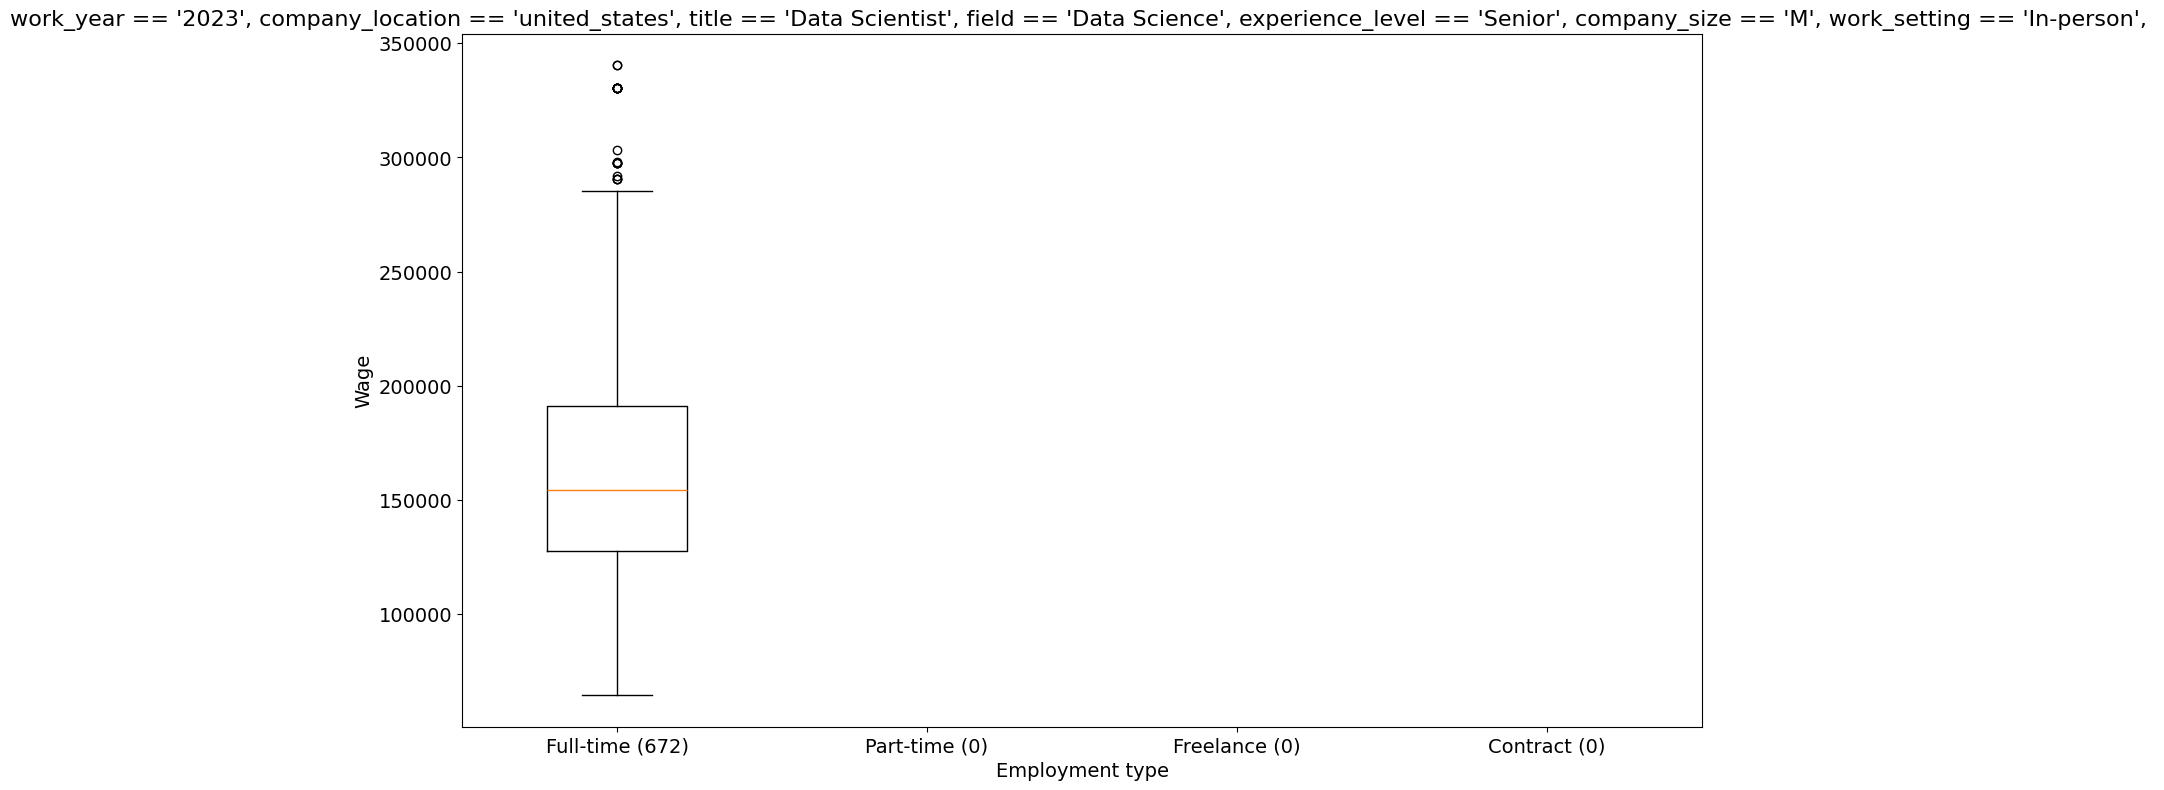

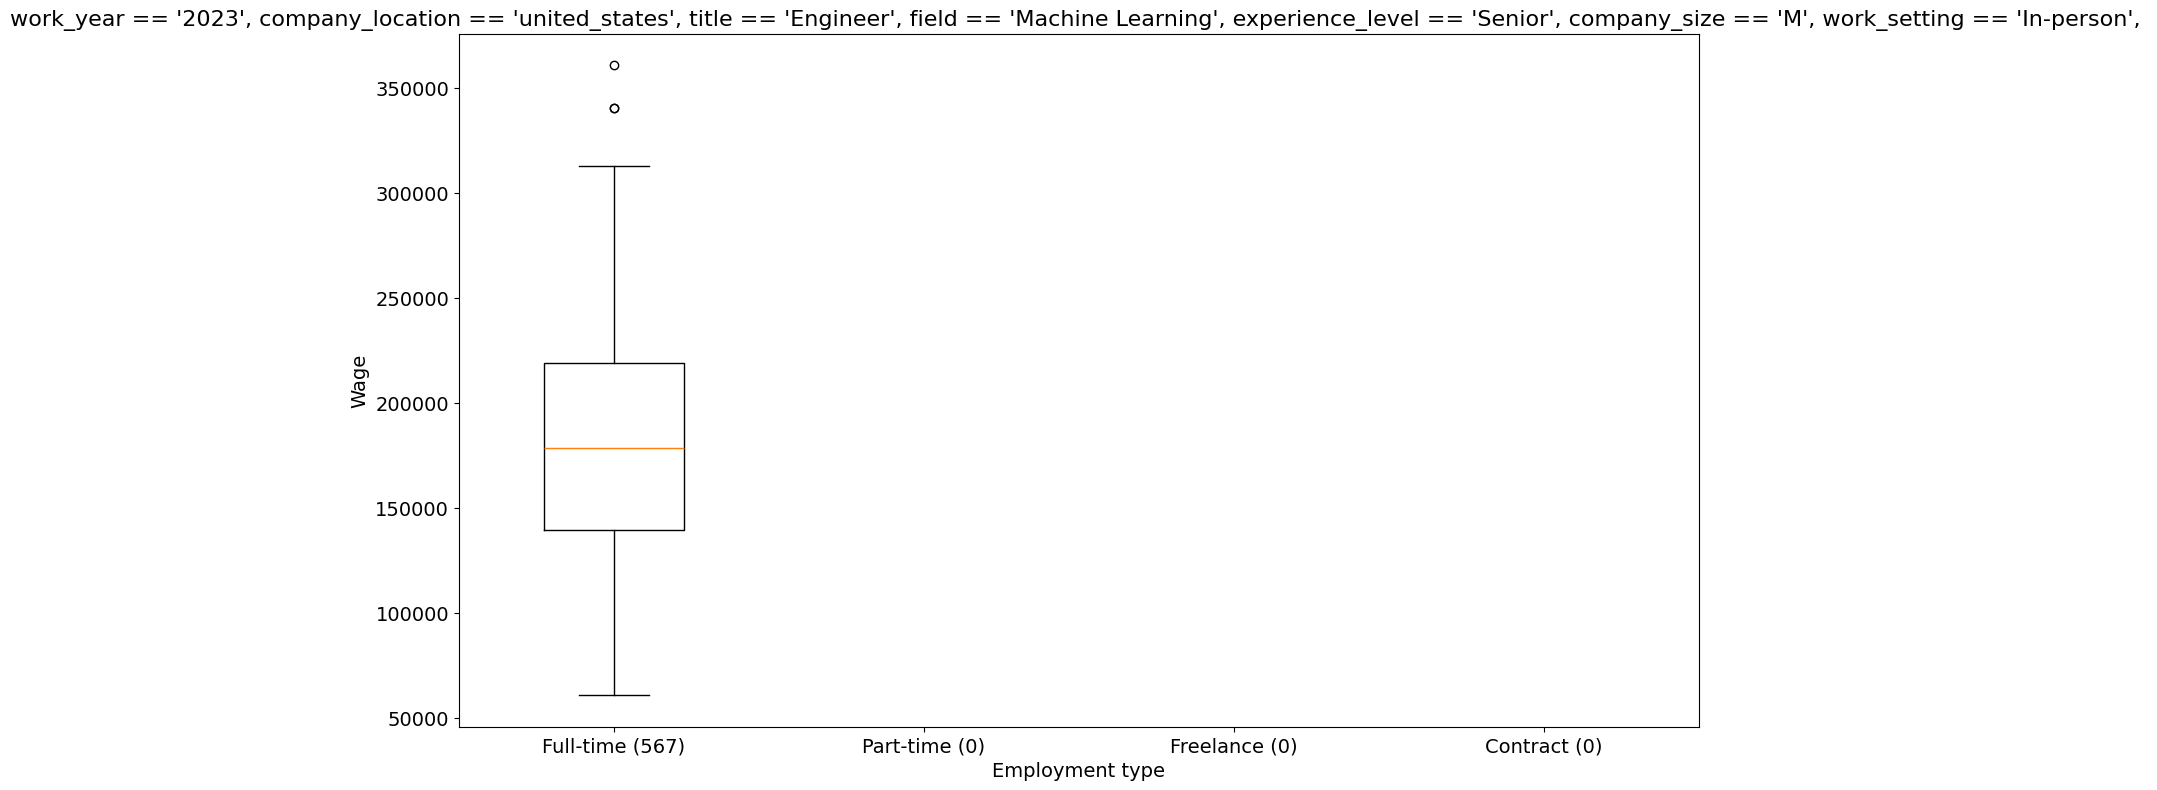

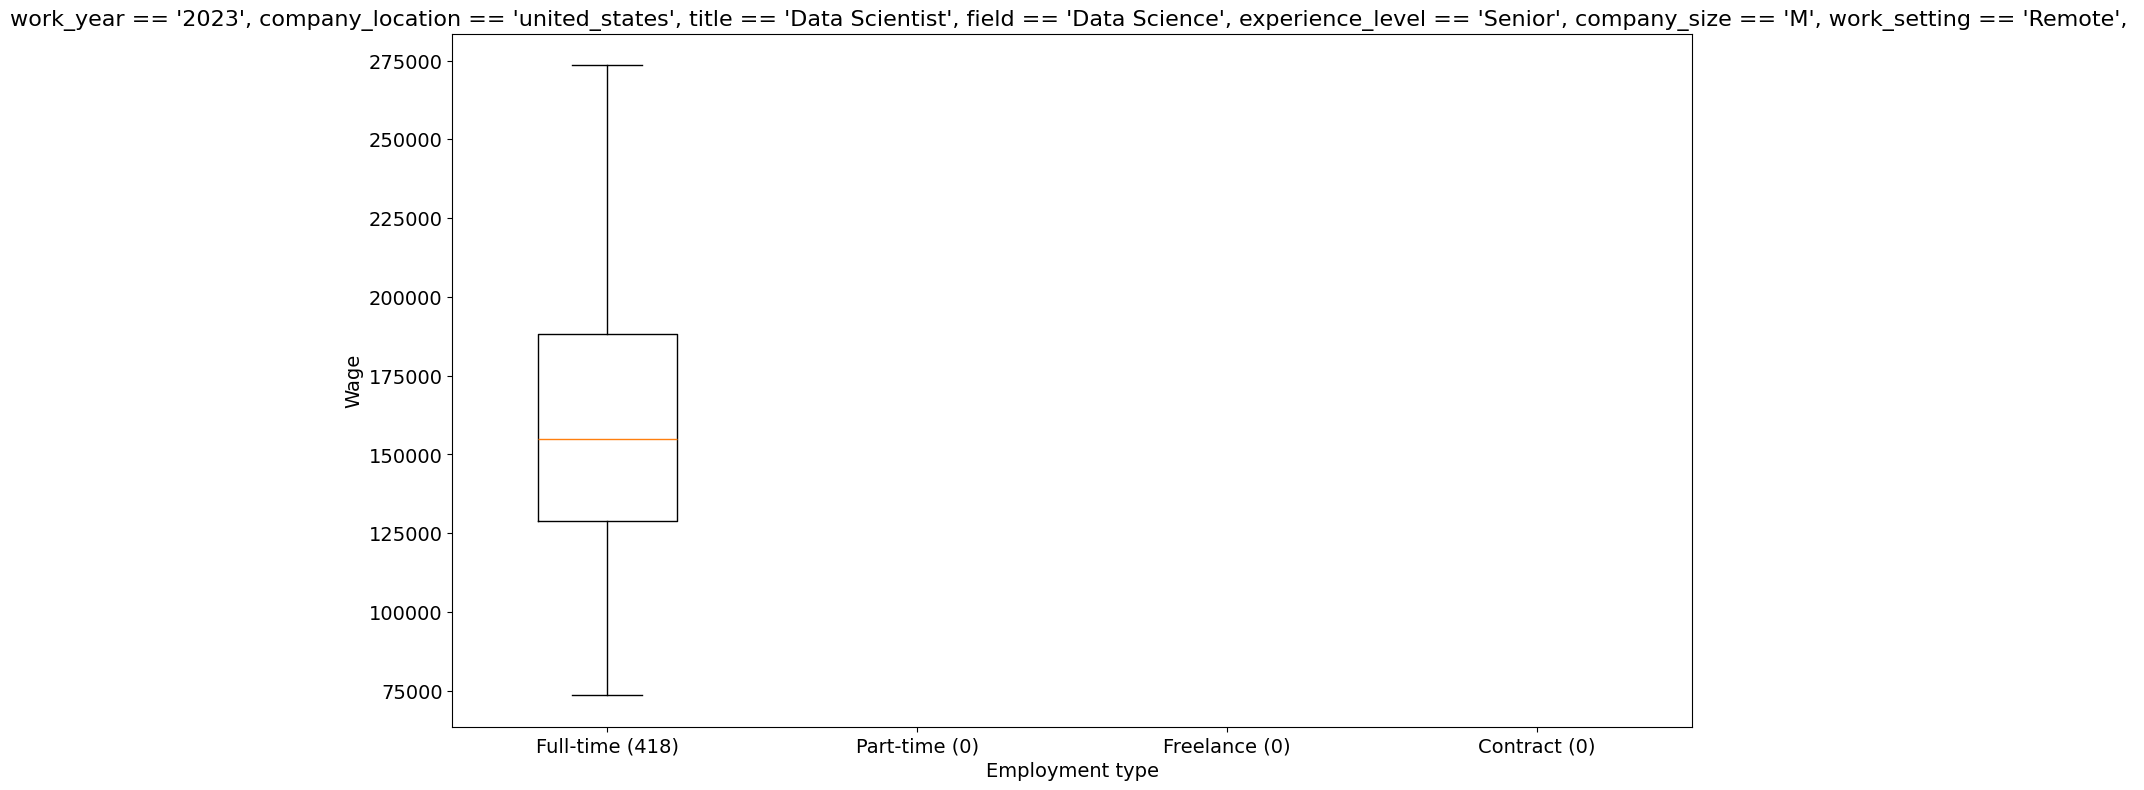

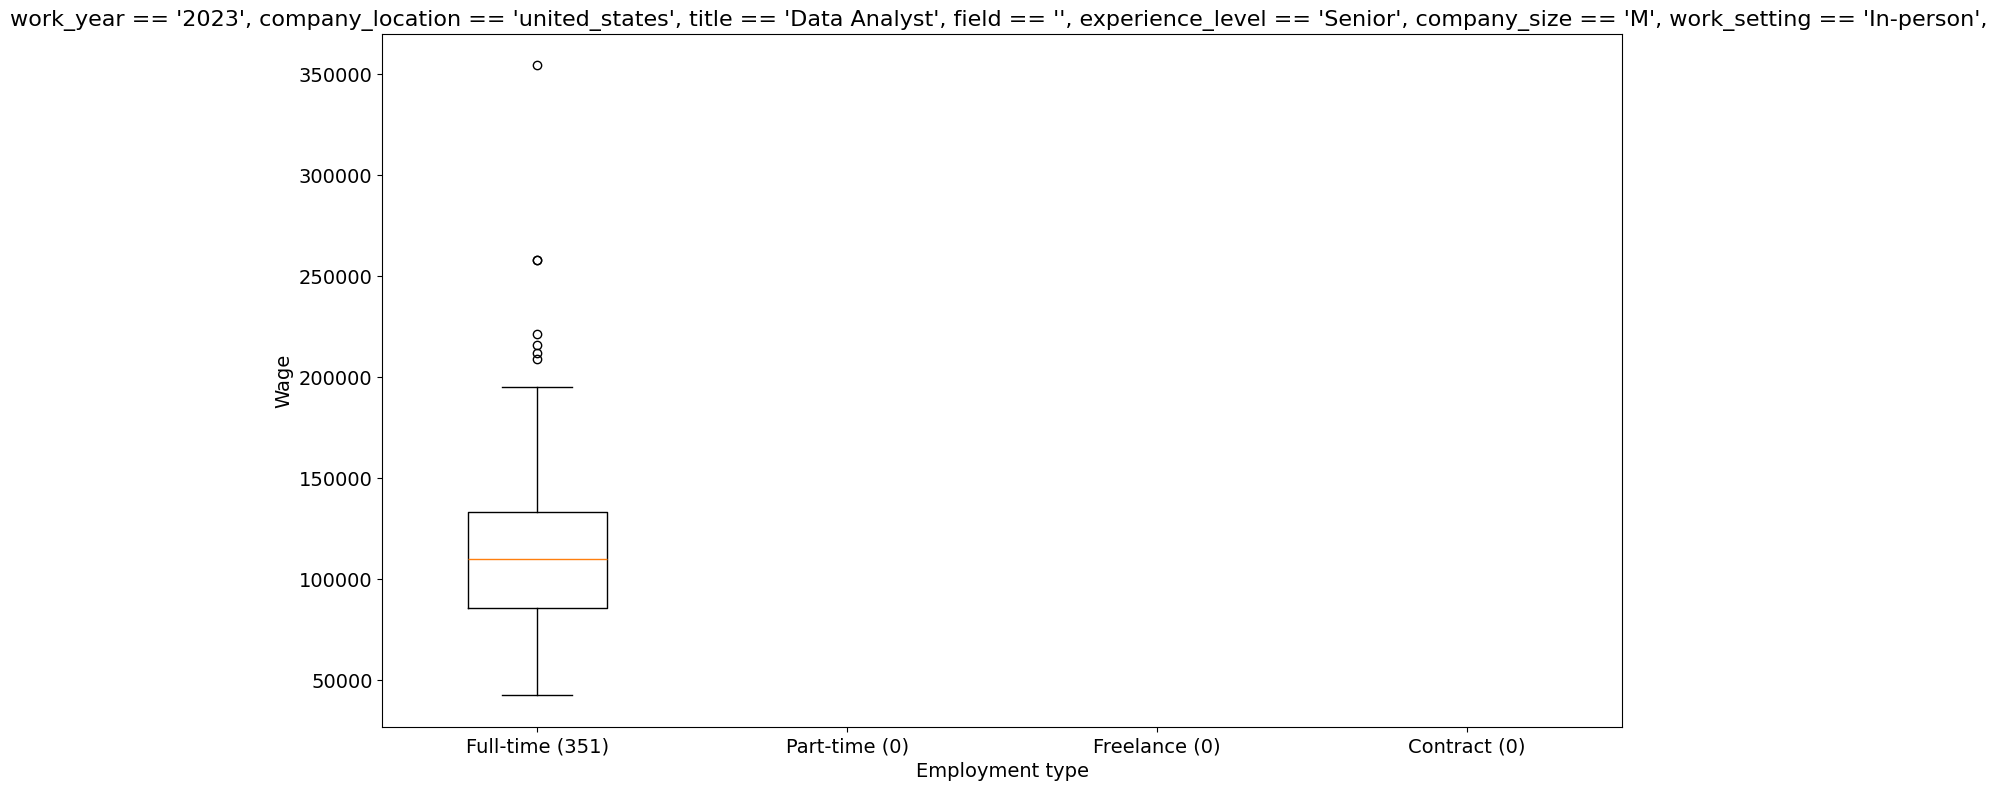

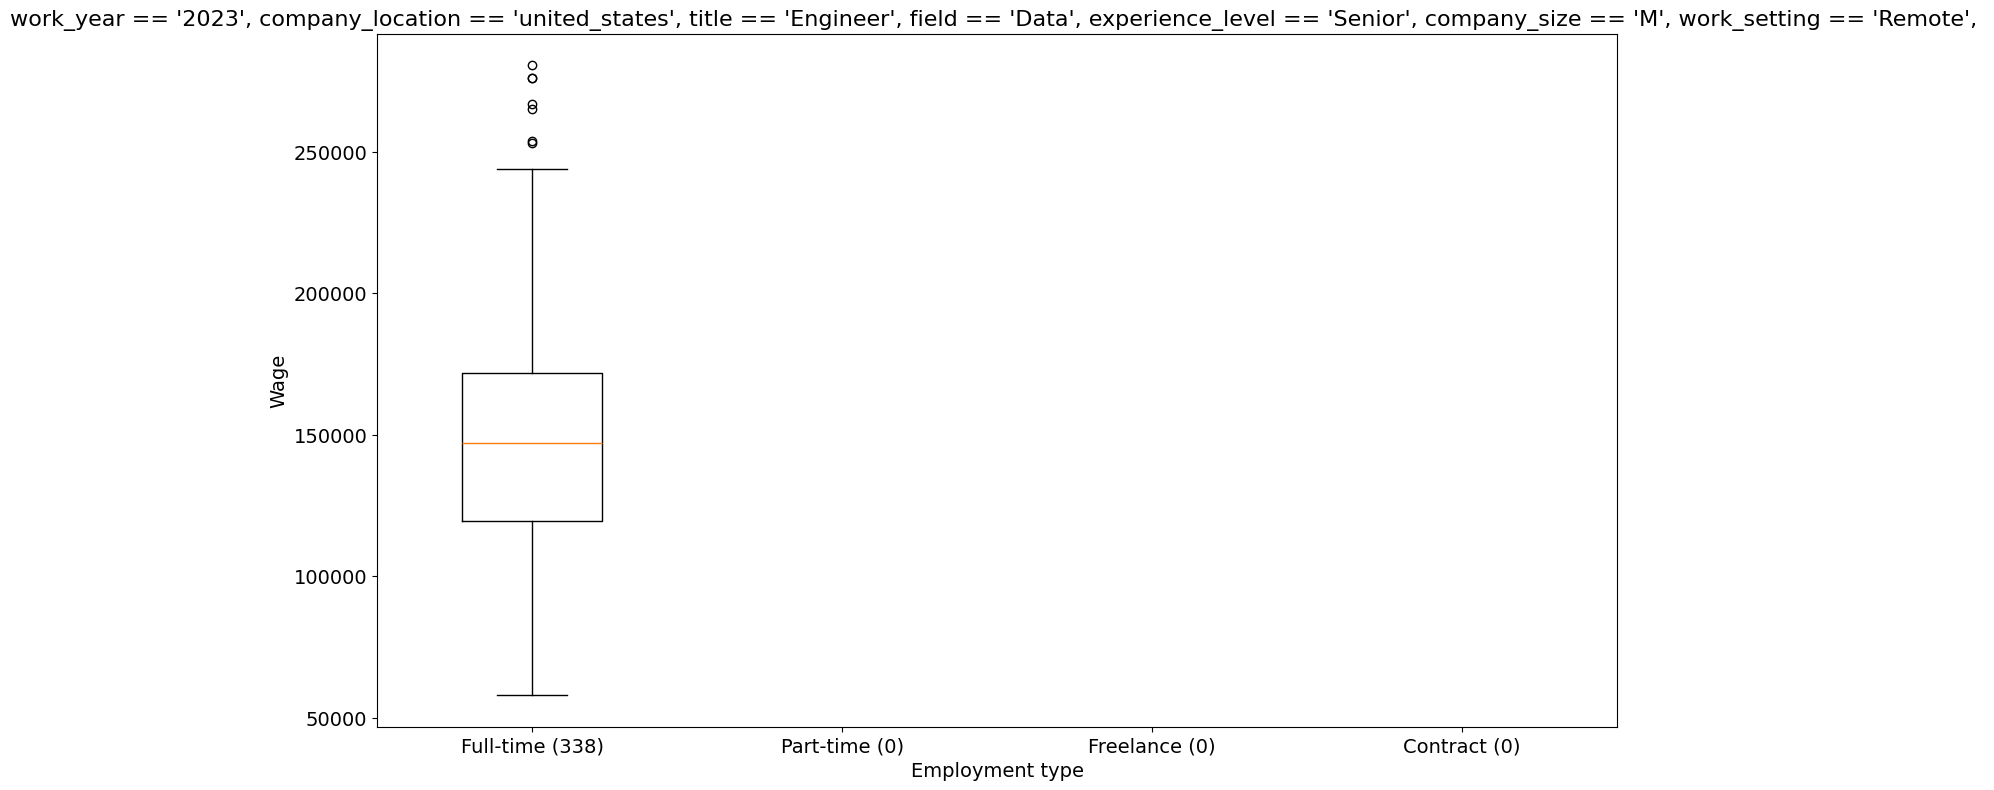

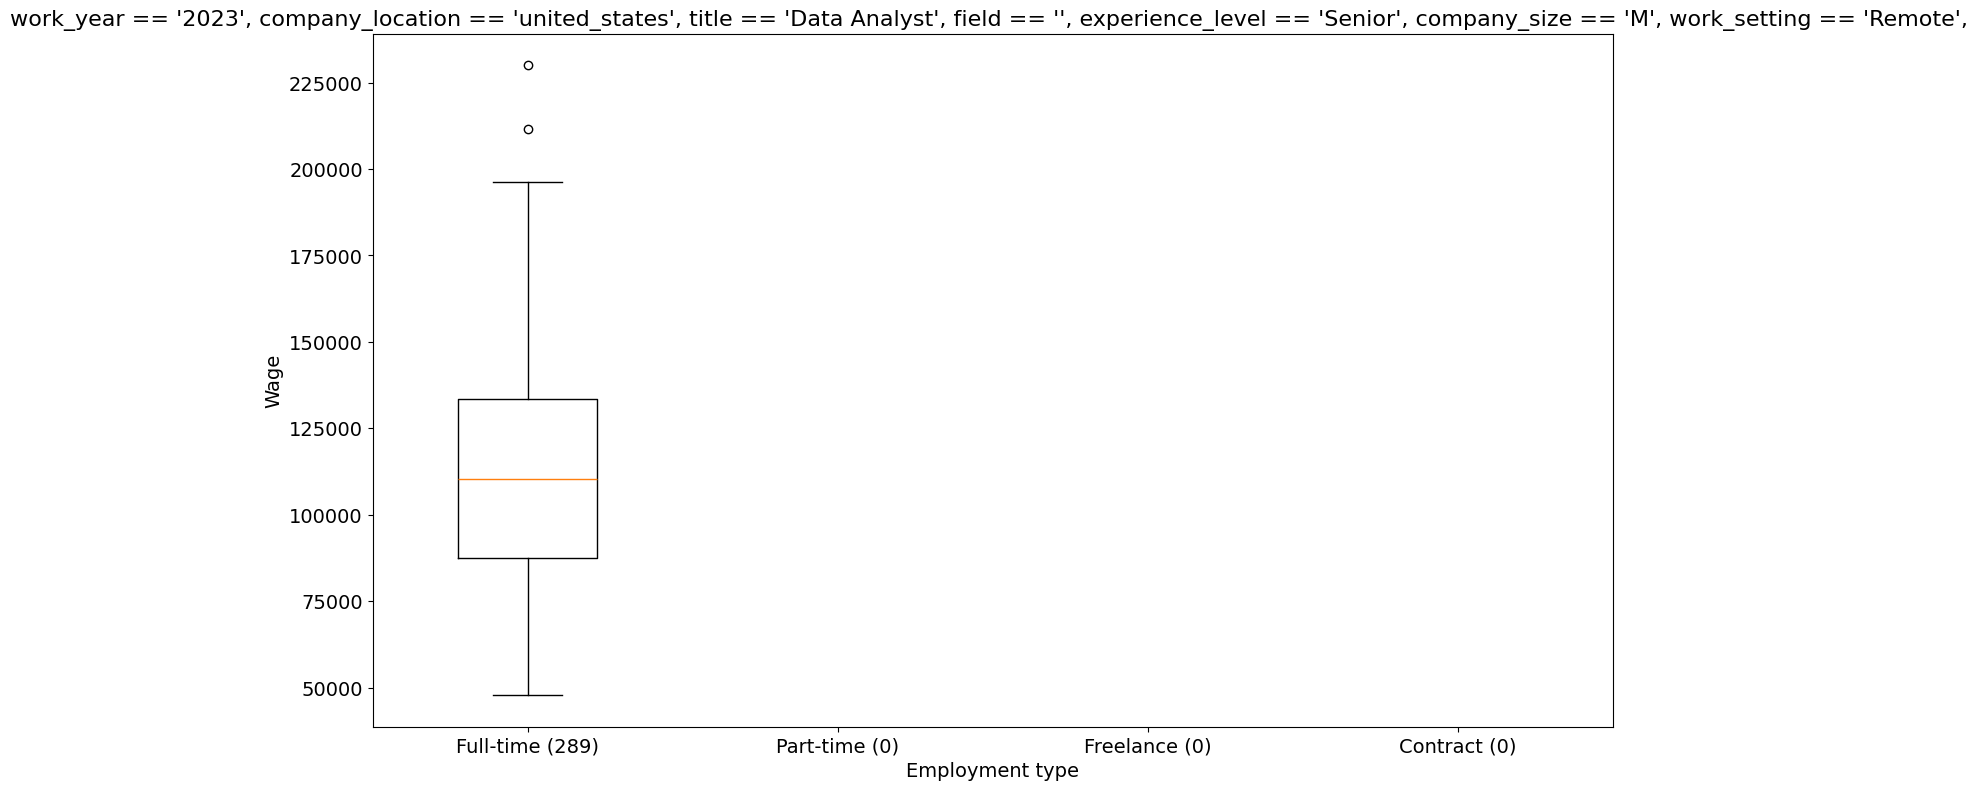

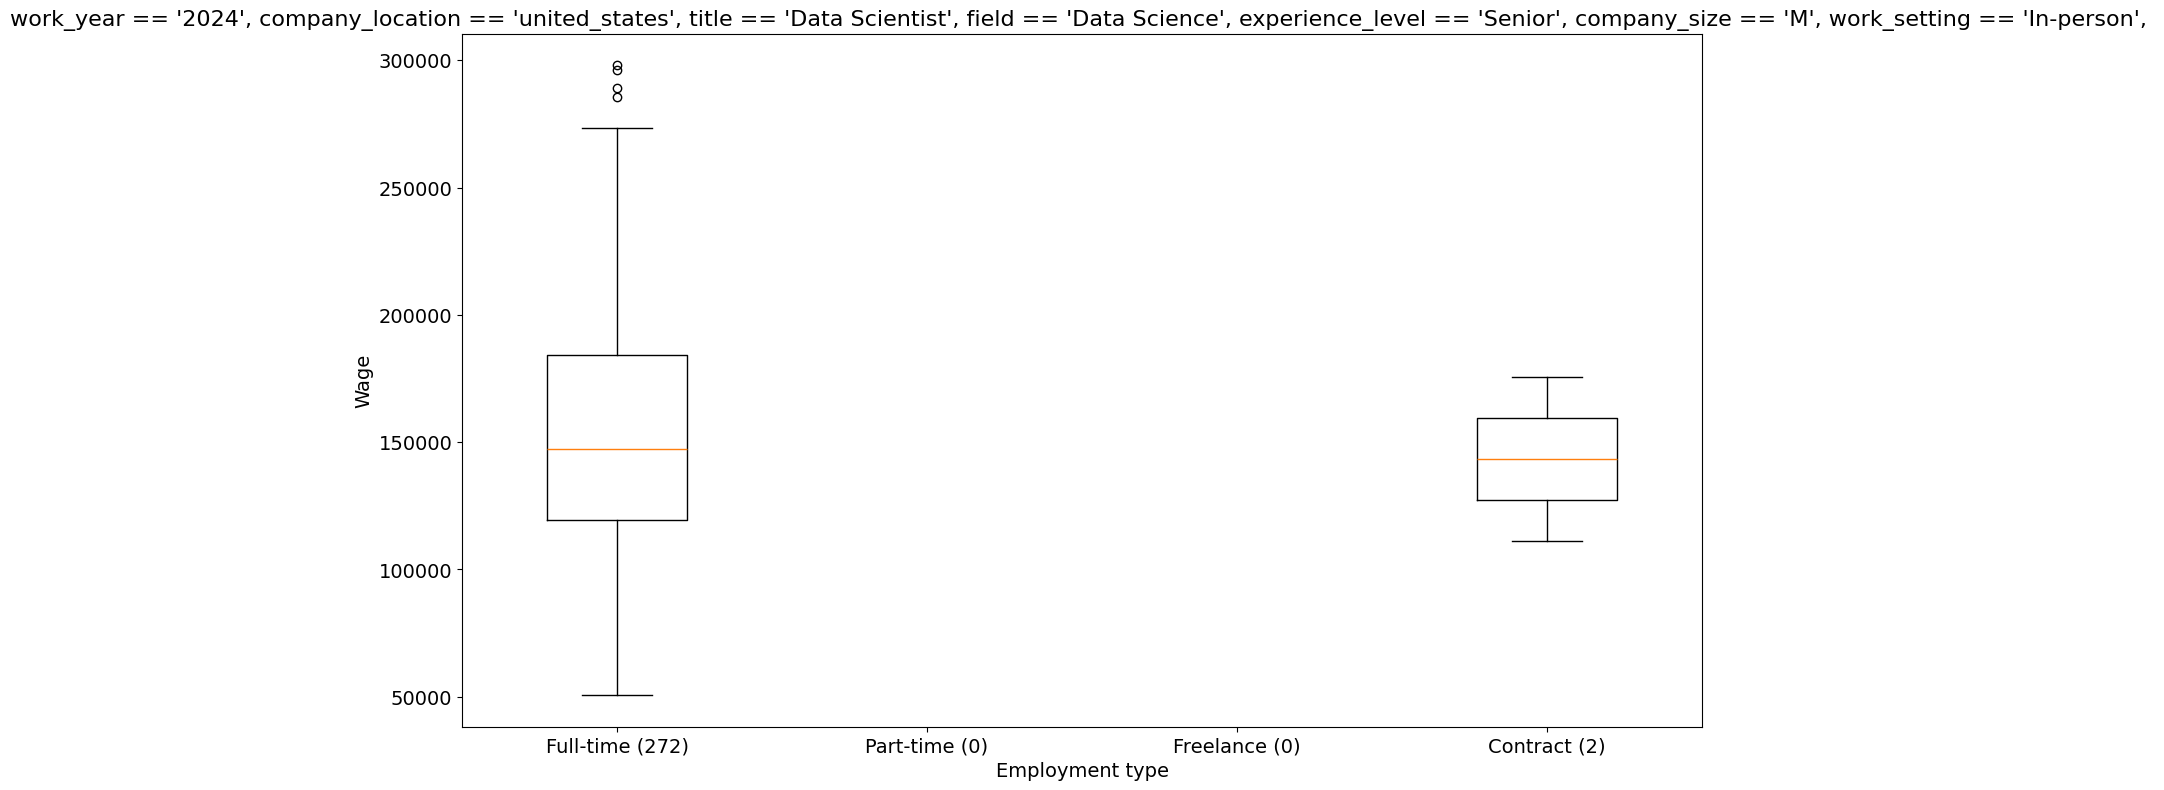

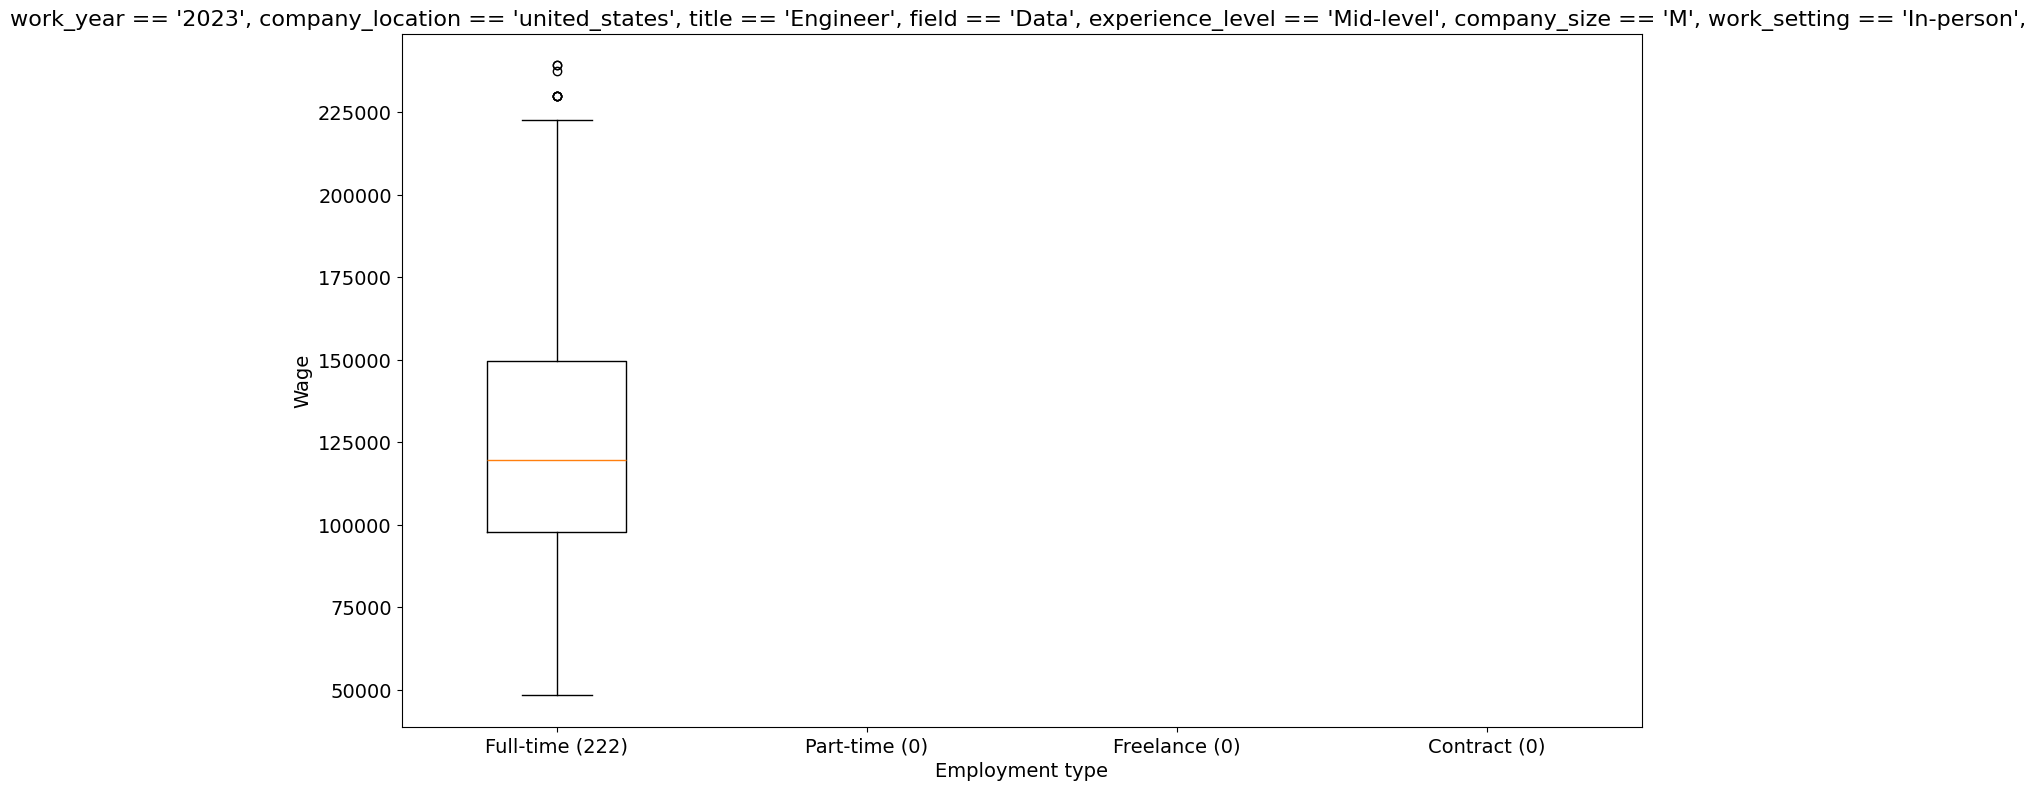

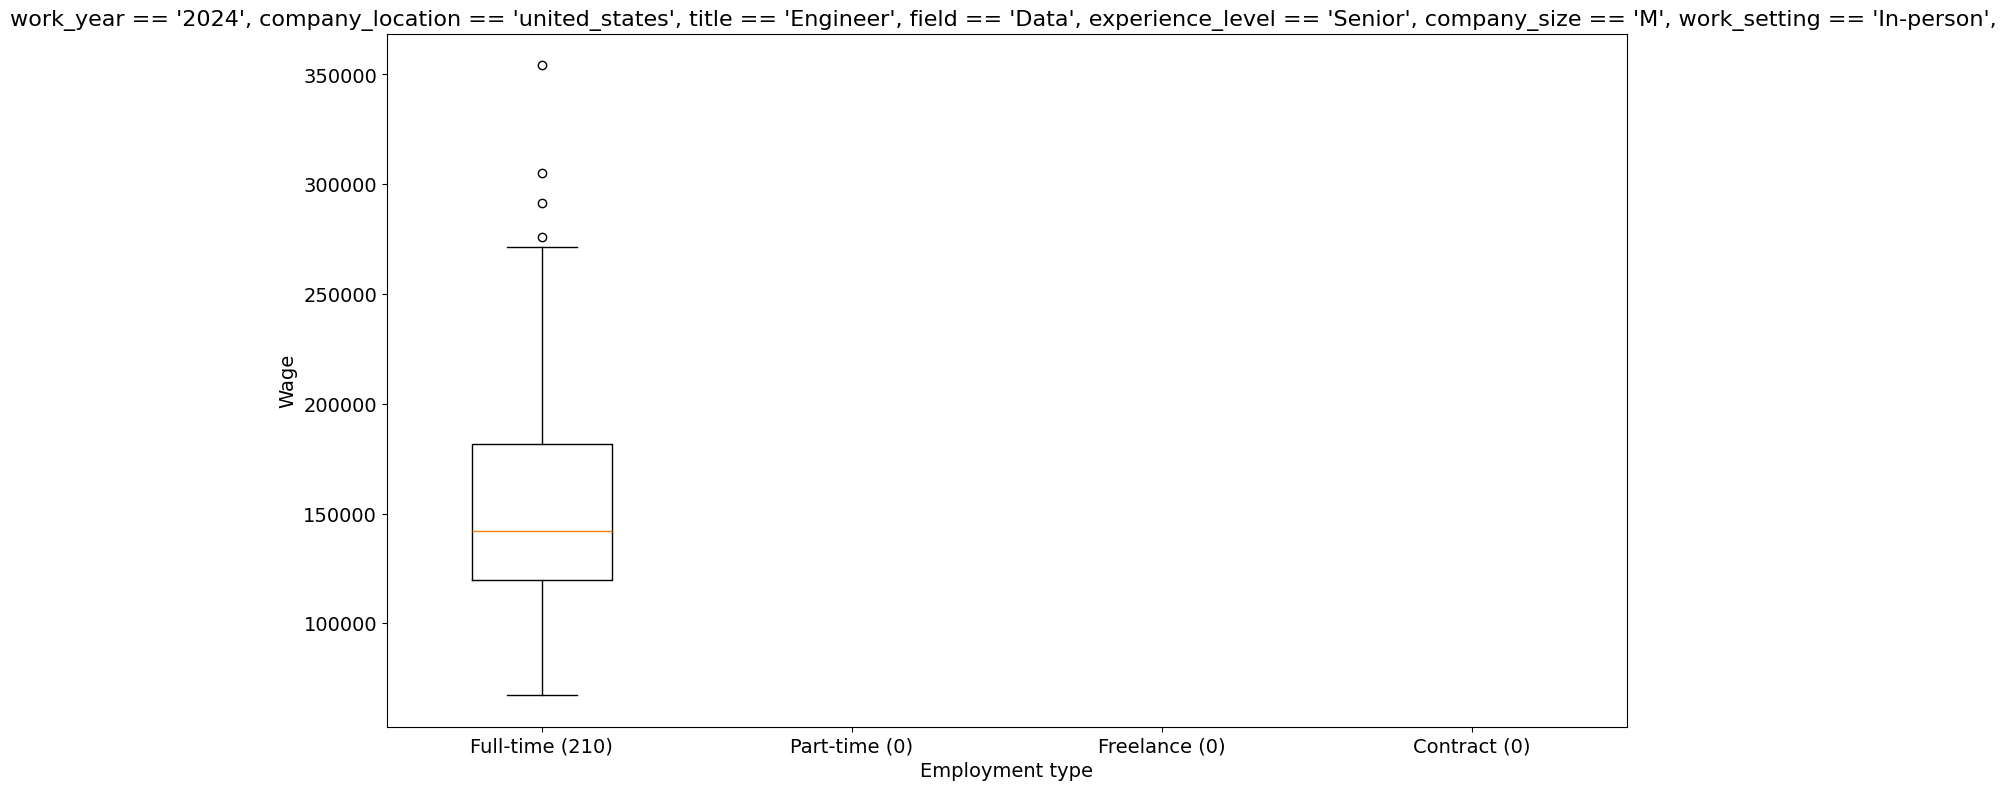

In [70]:
for i in range(0, 10): 
    #let's inspect the top 10 clusters with the most entries according to our constraints set at the start of step 6.5.
    [subset, title] = h.query_main_dataframe(i, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

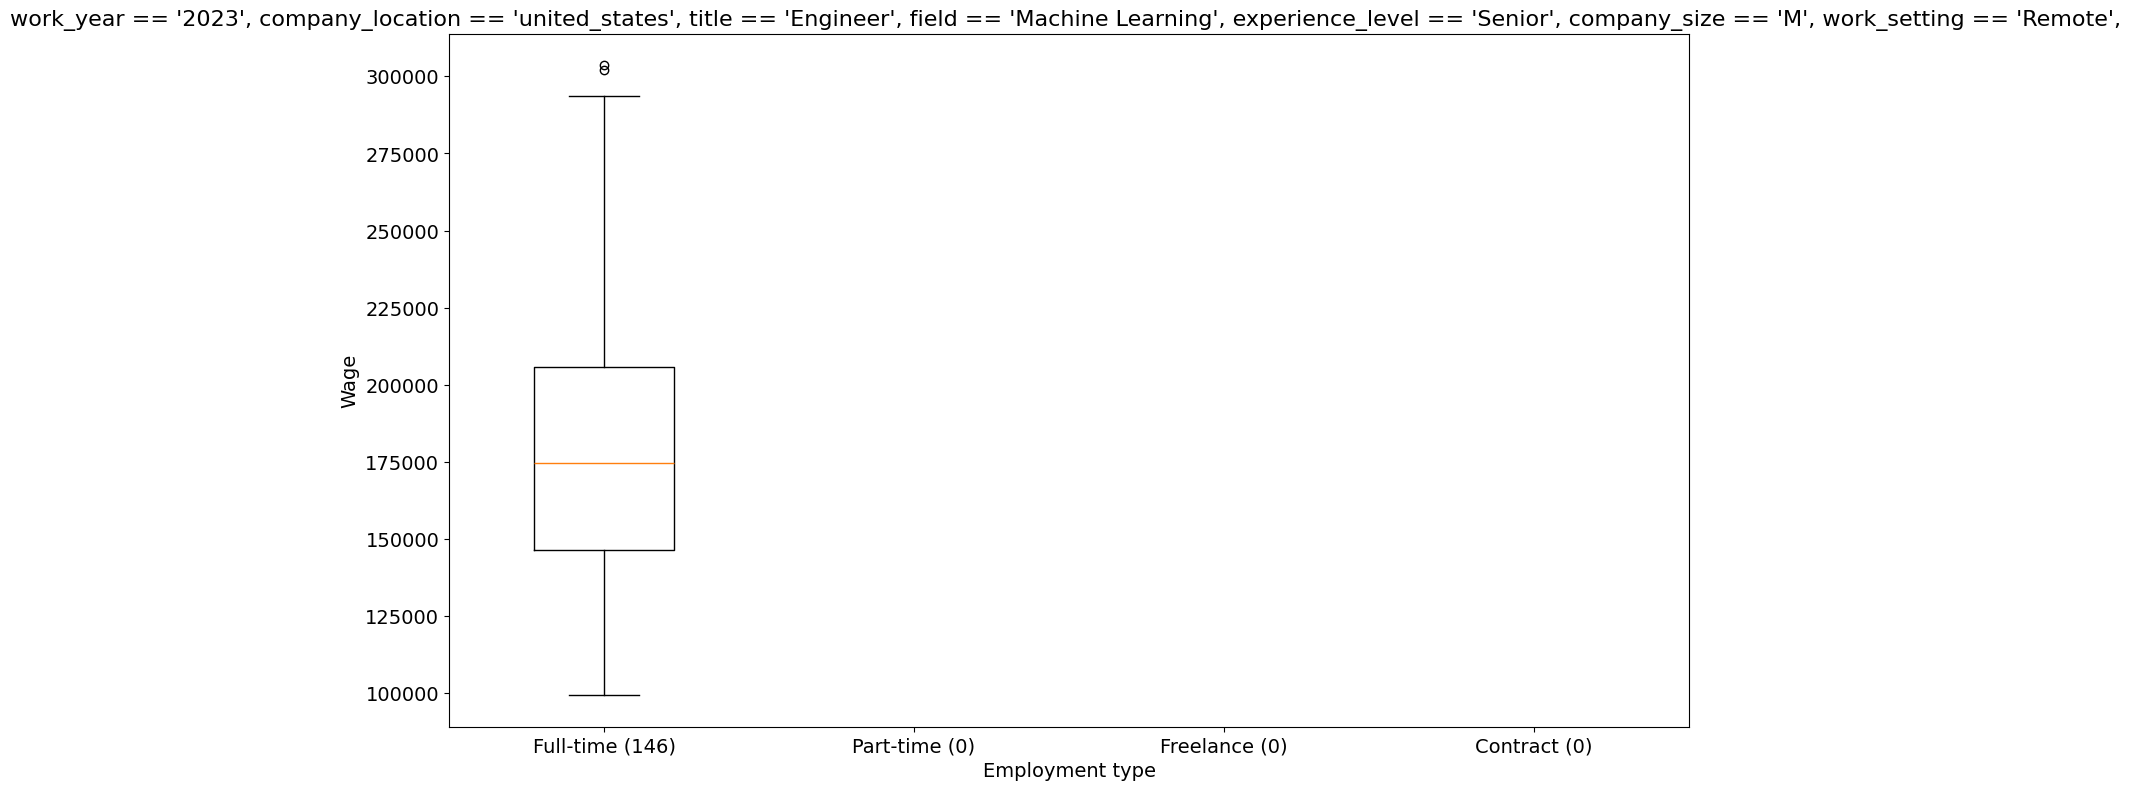

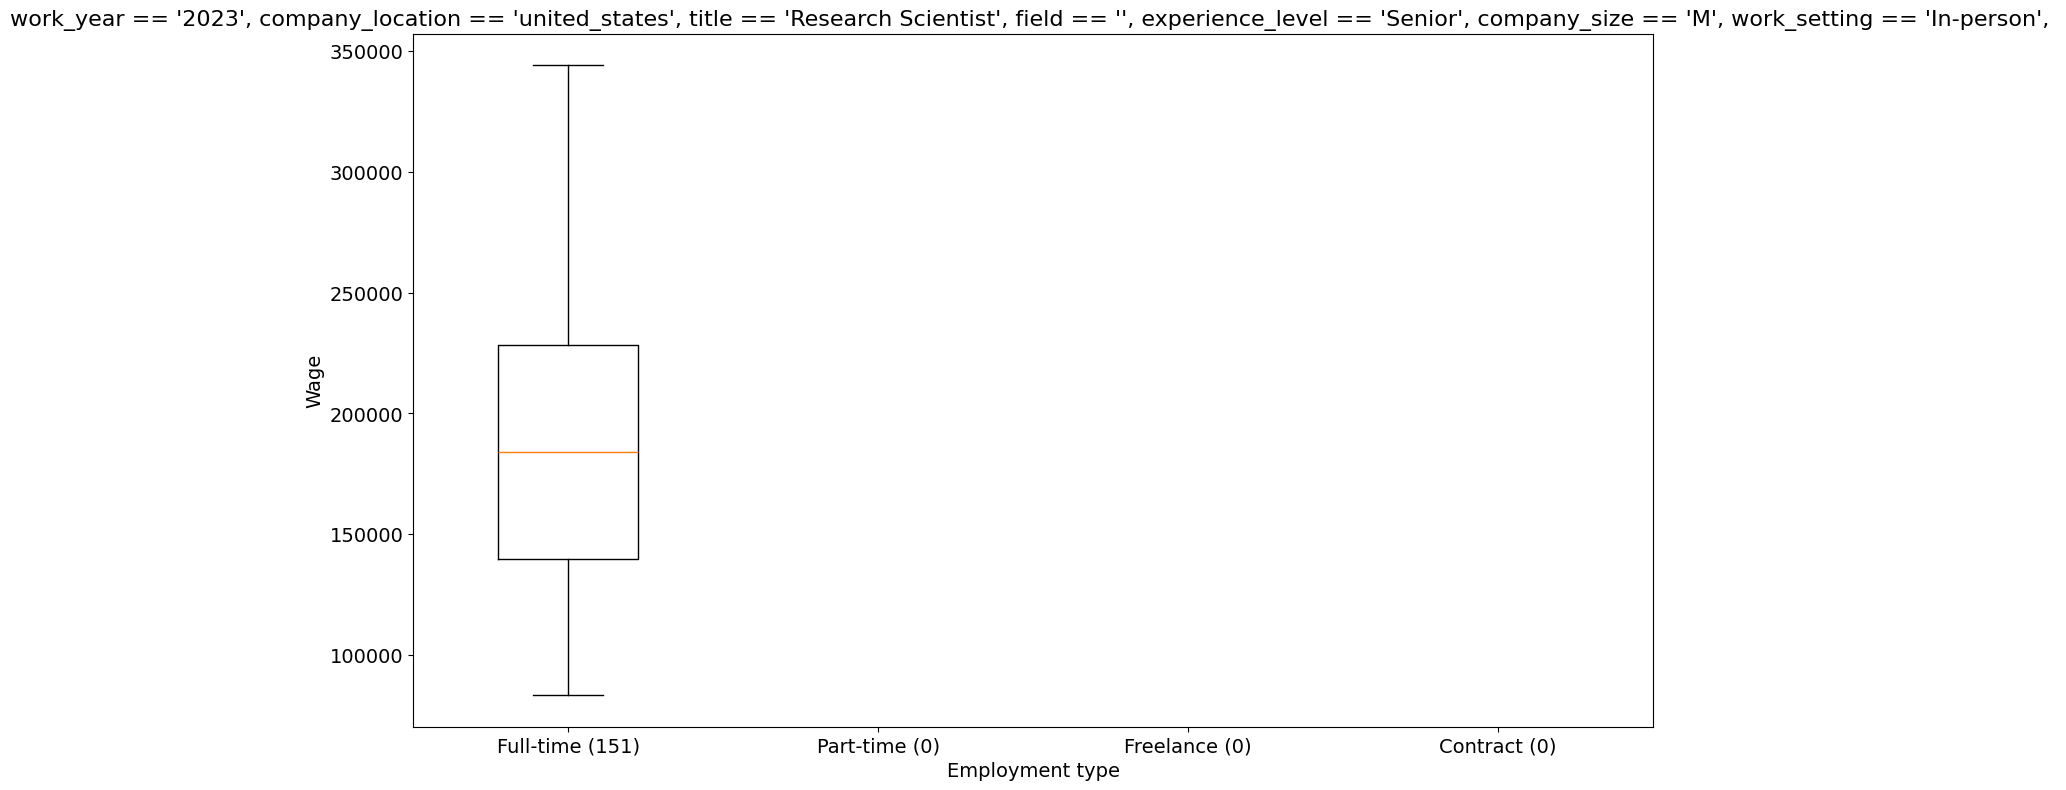

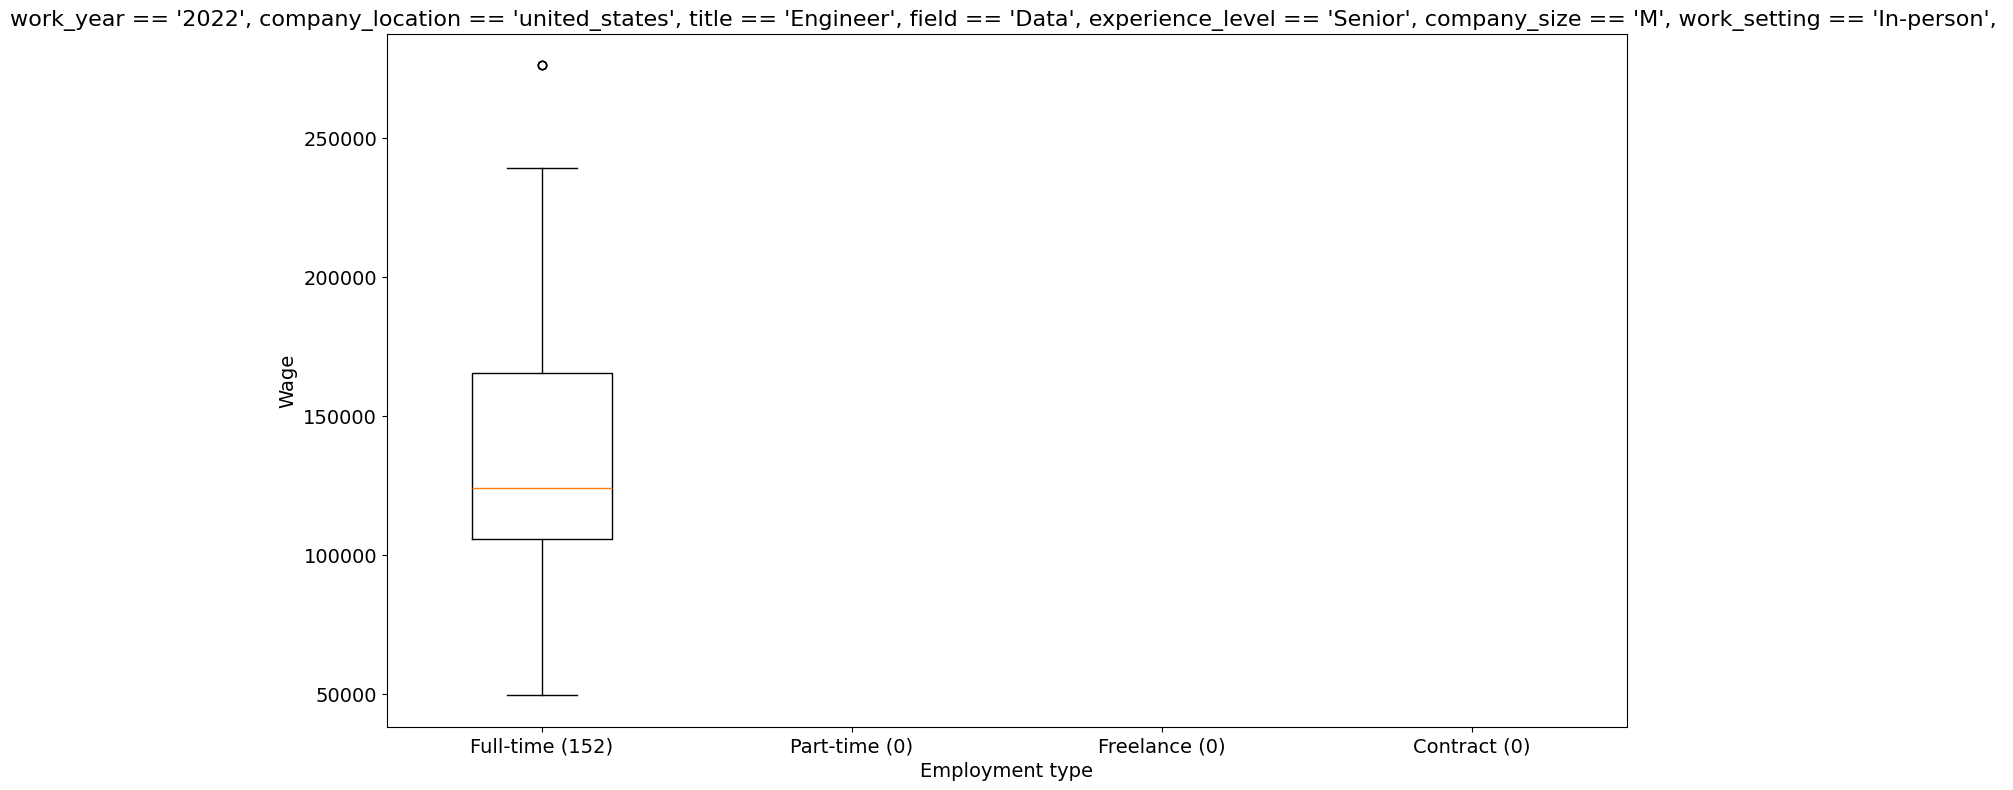

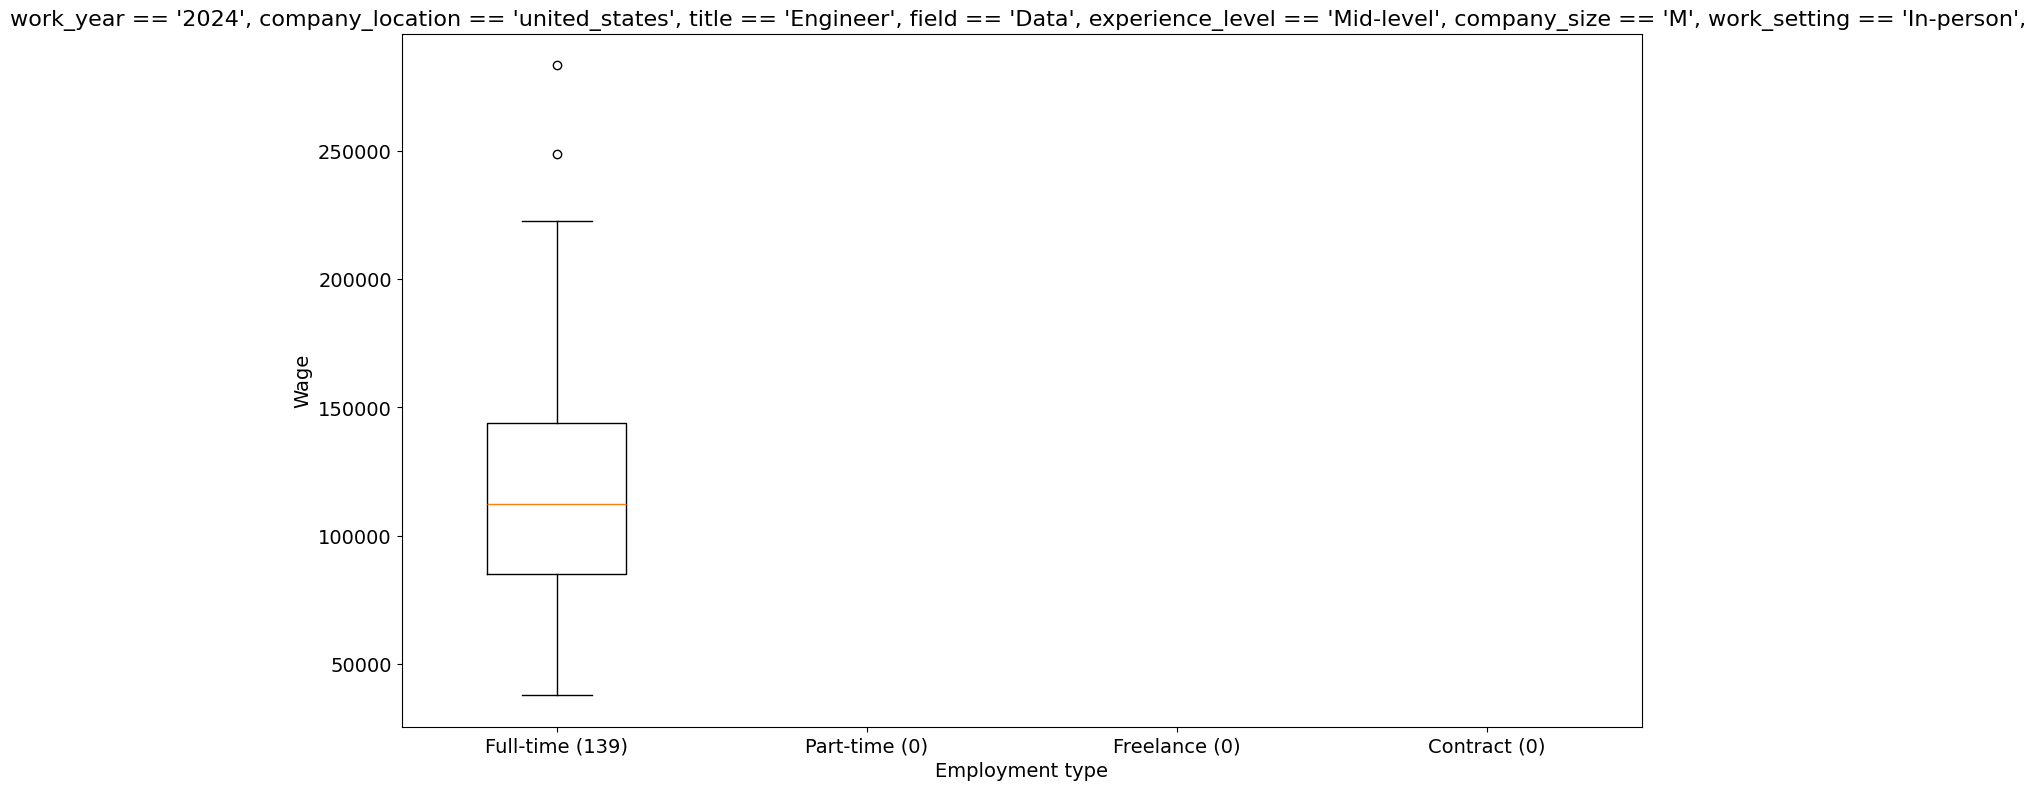

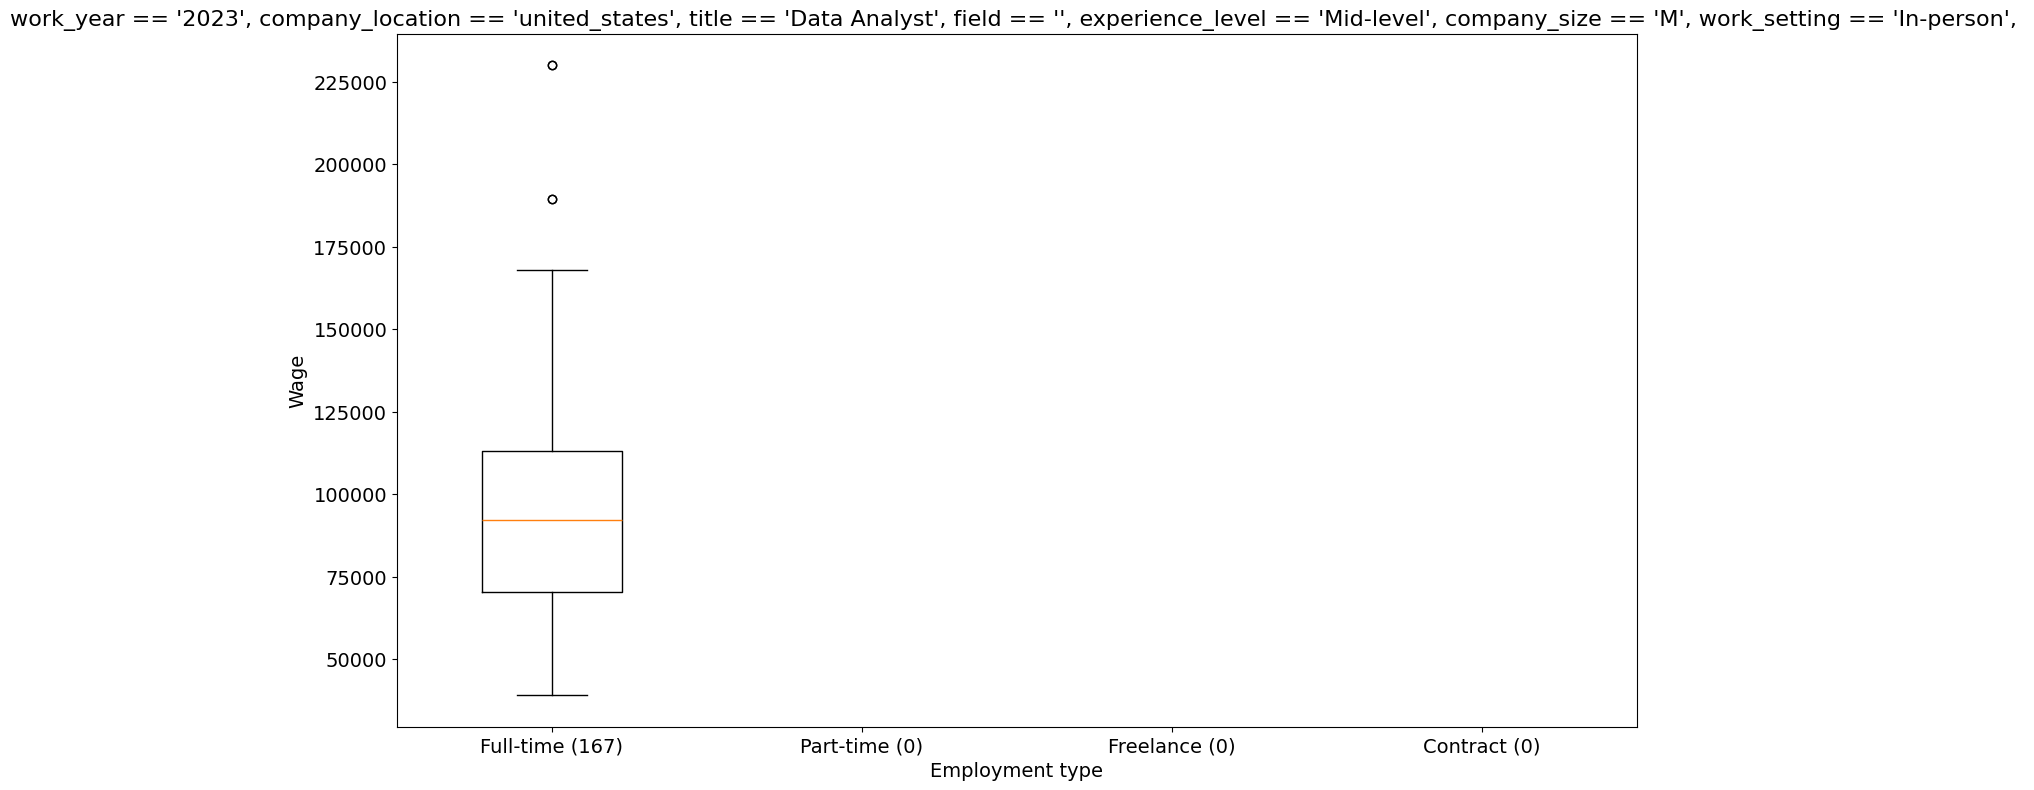

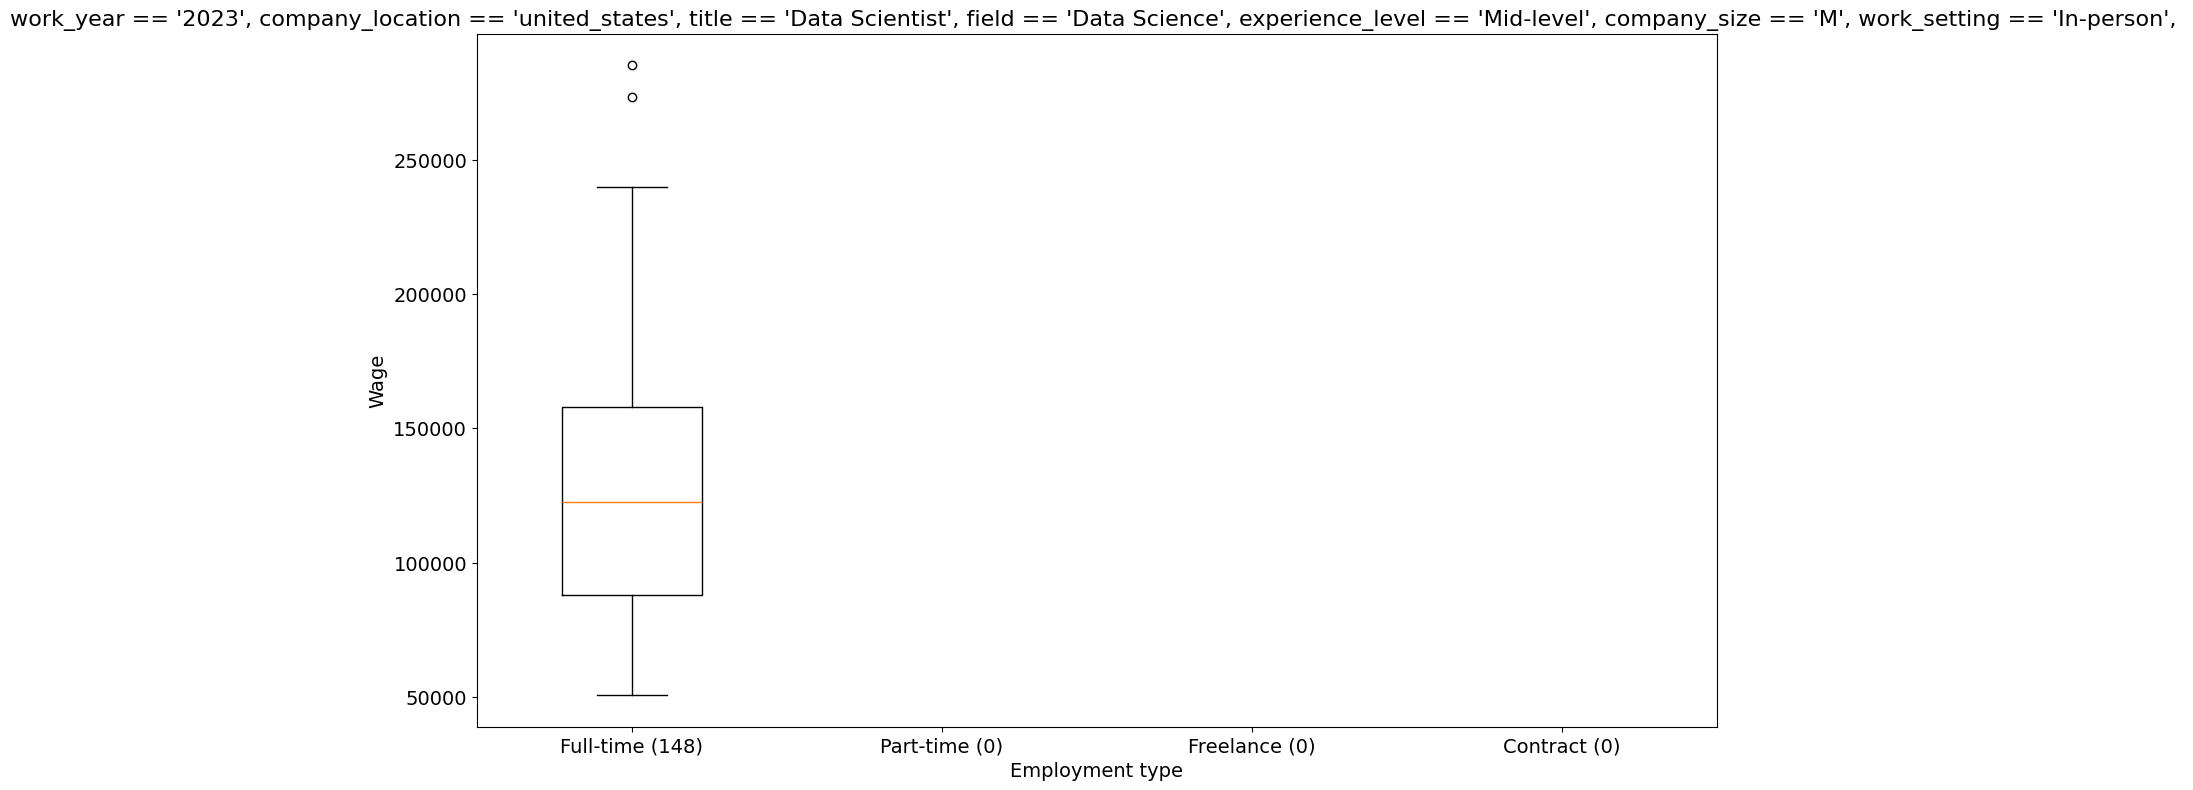

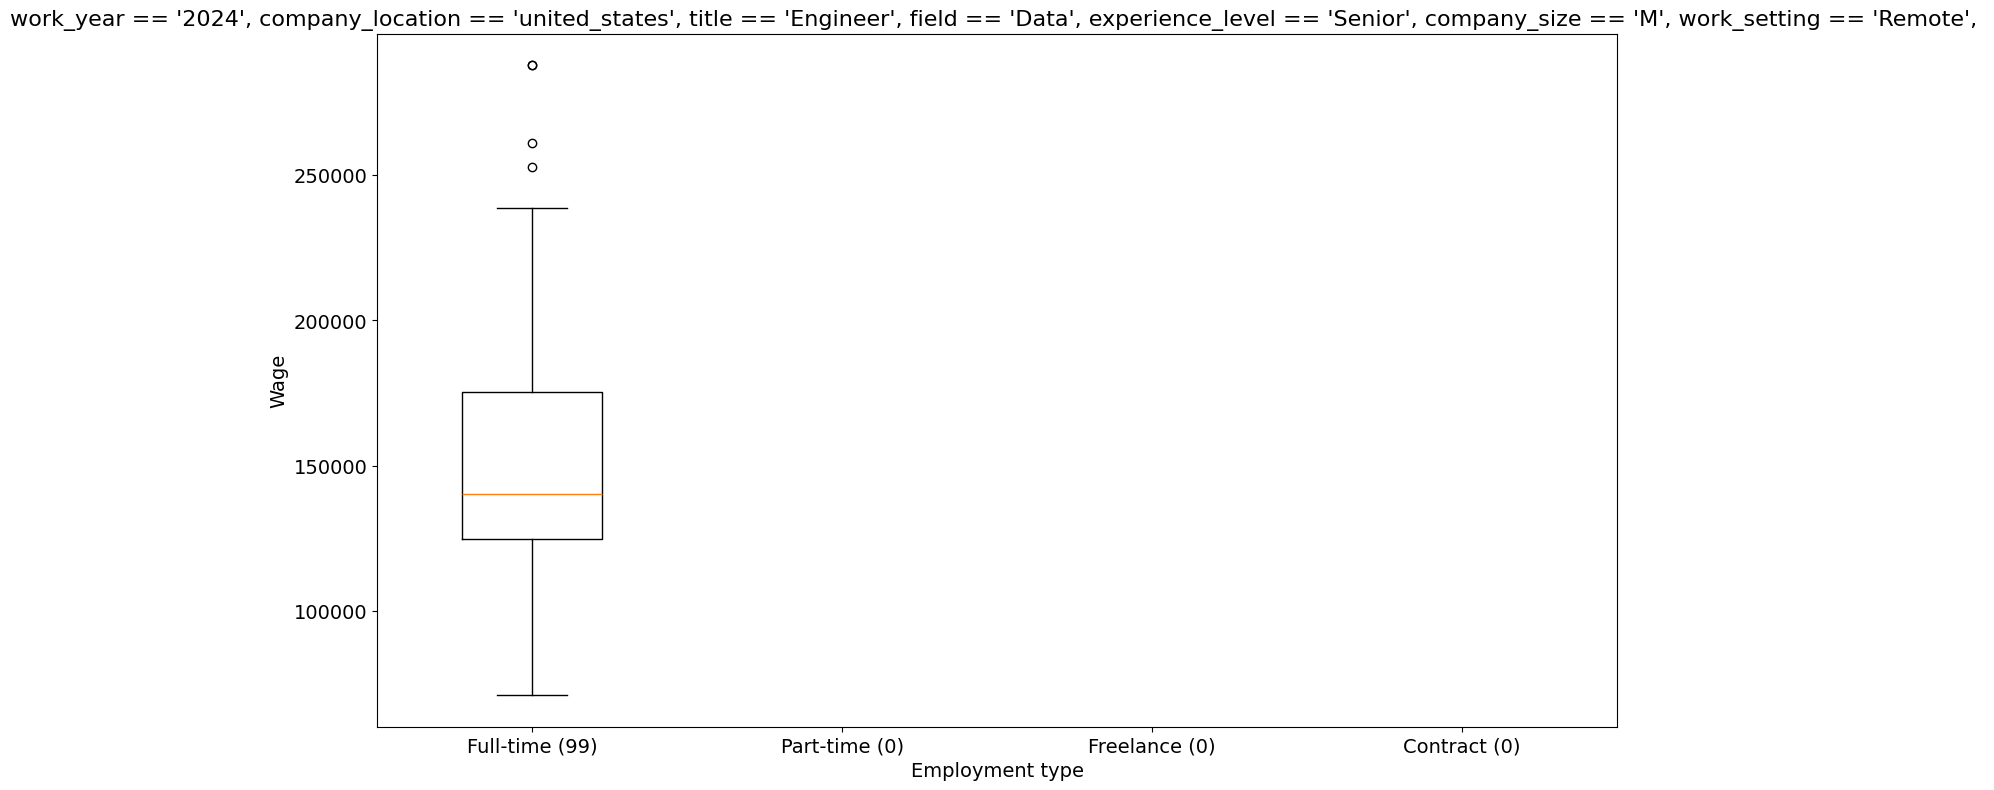

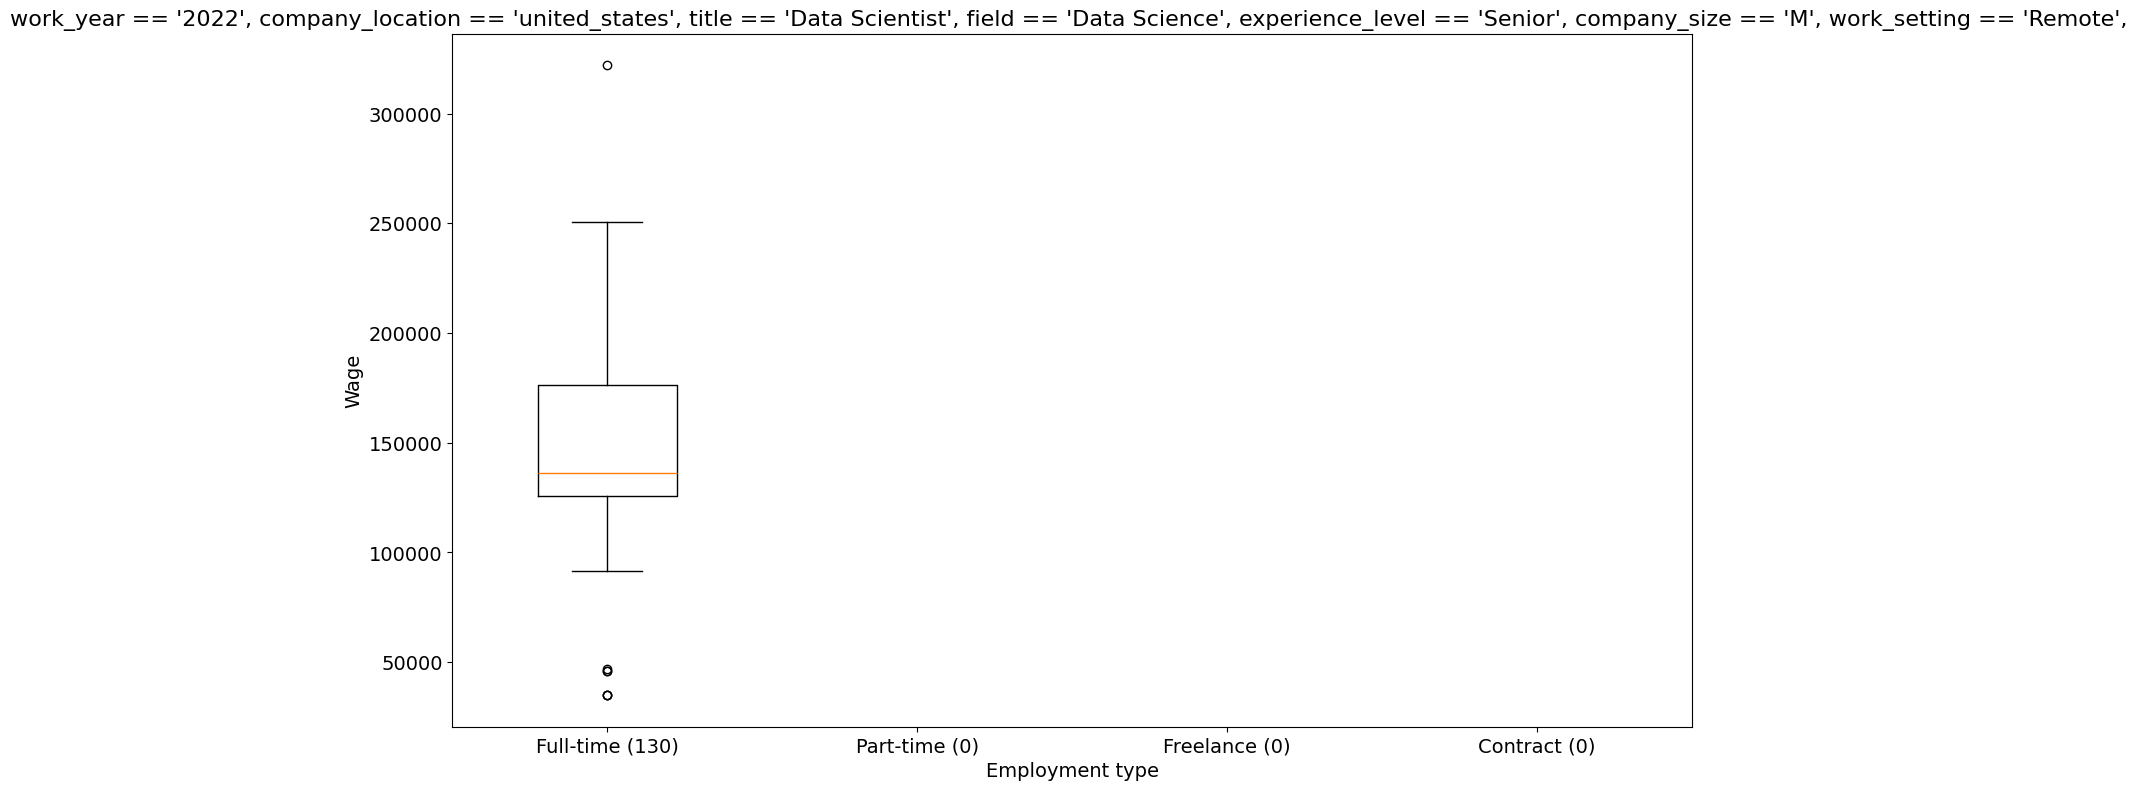

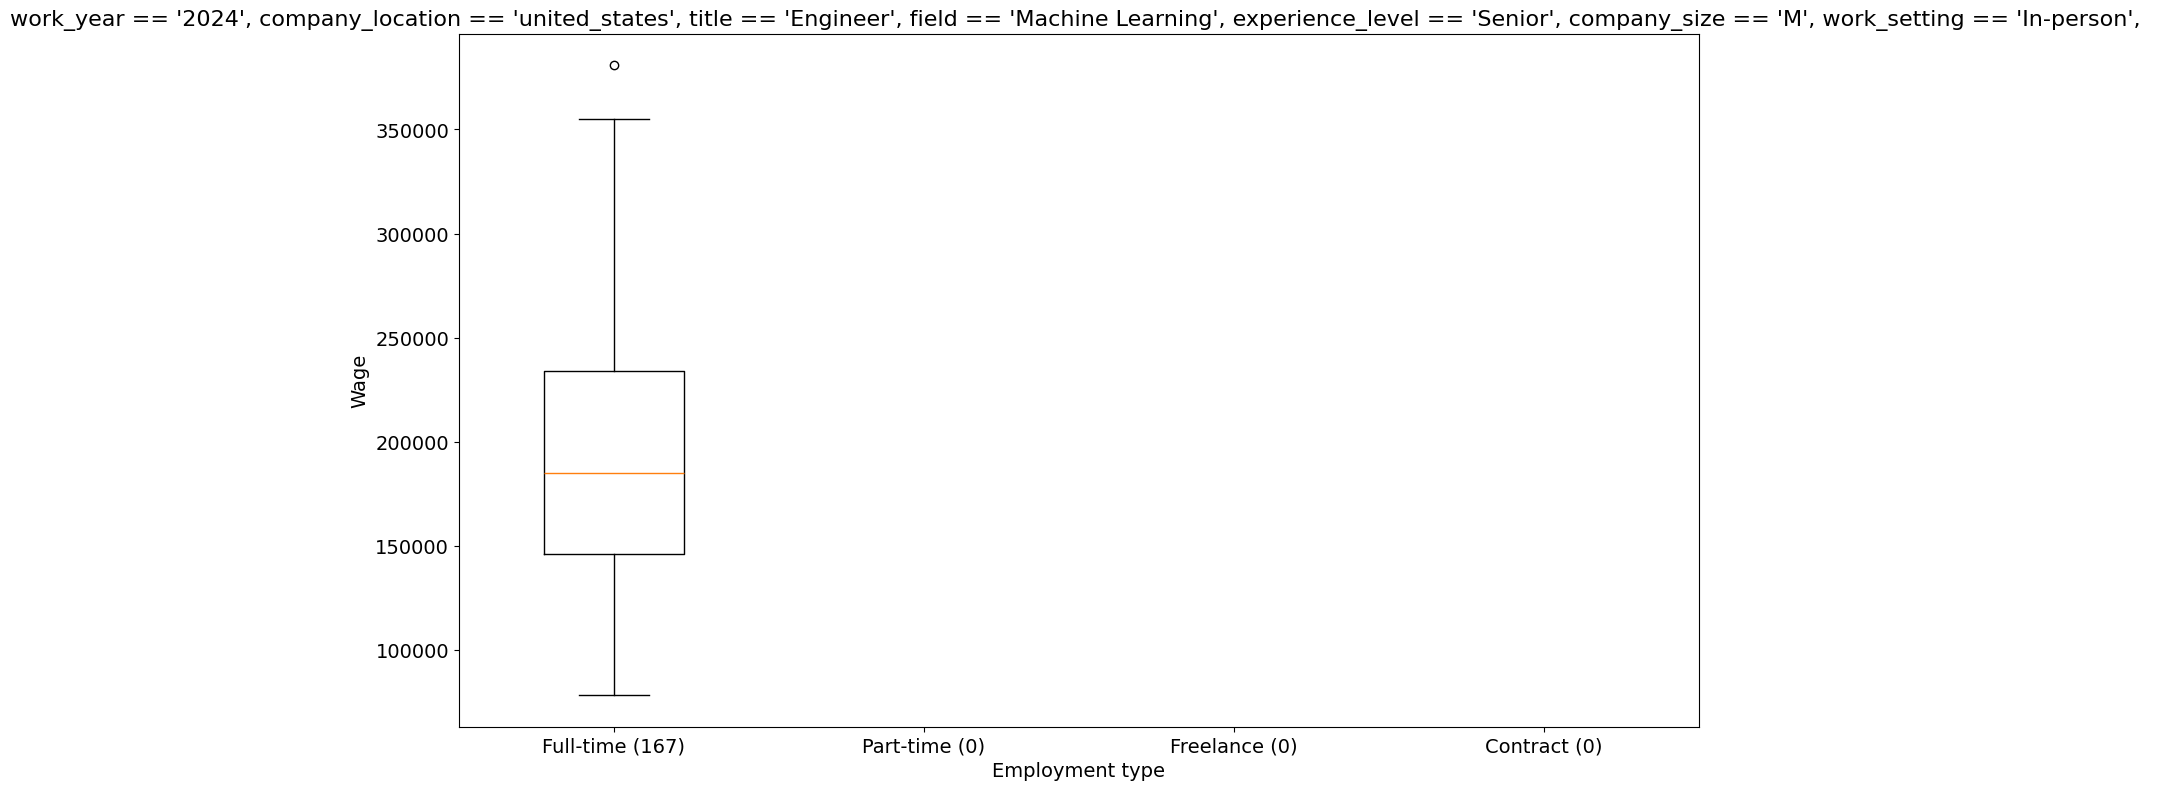

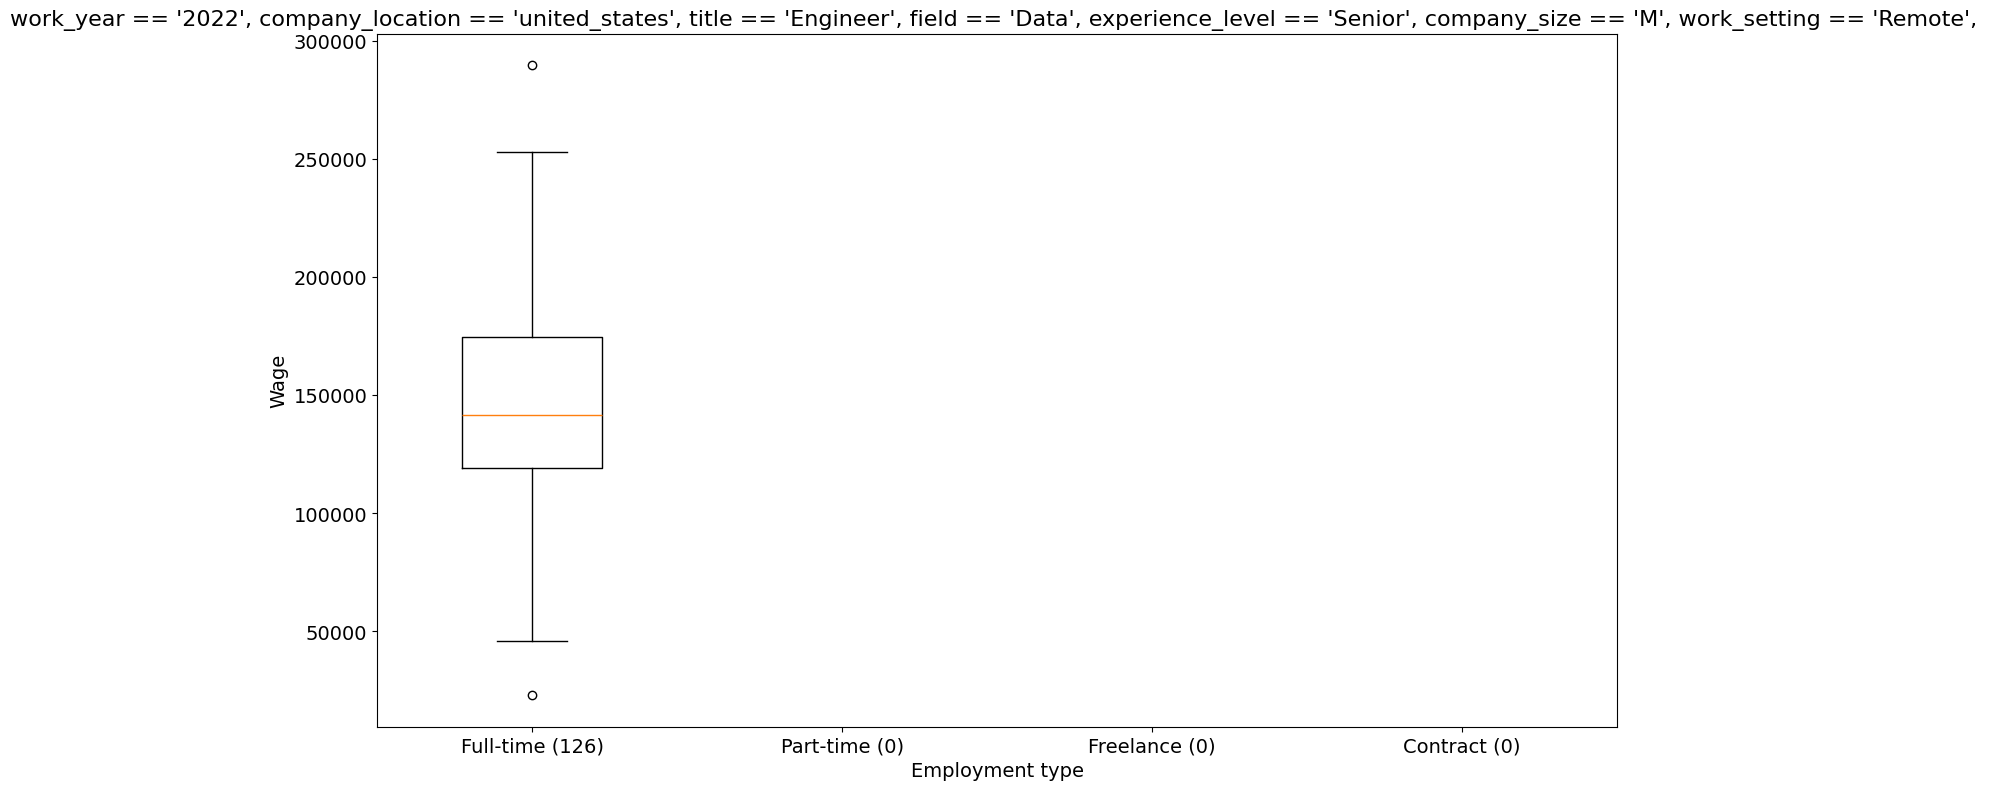

In [71]:
min_listings = 100
lmax = len(clusters.query("count>=@min_listings"))
picked_rows = random.sample(range(10, lmax+1), 10)
for row in picked_rows: 
    [subset, title] = h.query_main_dataframe(row, clusters, df_processed)
    h.make_company_var_plot(subset, title, key_for_question).show()

There are very little positions that are not full_time positions (as seen earlier in the pie charts). This makes it hard to express with certainty if this really makes a difference. To fully answer 6.8 let's take a step back and look at the bigger picture for the US (has the most records) in 2023.

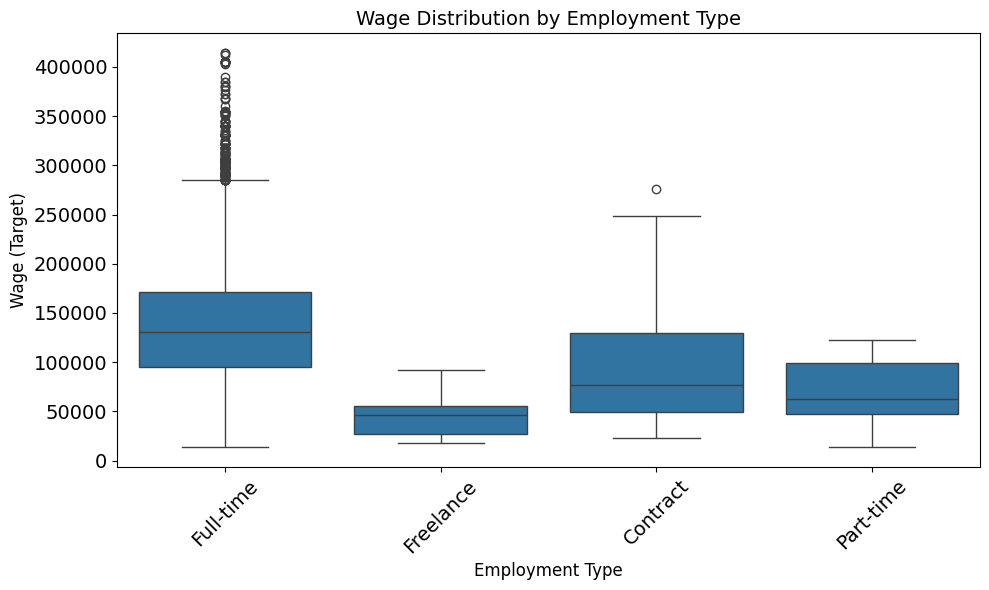

In [72]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='employment_type', y='target', data=df_processed)

# Set plot title and labels
plt.title('Wage Distribution by Employment Type', fontsize=14)
plt.xlabel('Employment Type', fontsize=12)
plt.ylabel('Wage (Target)', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

let's not bother with this feature too much: we can see it has an impact in the overall dataset - and it makes sense to assume that part-time pays less than full-time. With that in mind it can be added as a feature to the model - but we'll need to be careful about how we handle it; we can not make this an ordinal value (is contract more or less than full-time?) This should be OHE. 

## EDA CONCLUSIONS
- No missing data
- Data added by using WB research is usefull, but don't overestimate it - it is heavily leaning to high-income countries. 
- Job_title is a messy variable - splitting it up in field and title made sense to make it less inflated. It would be a good idea to have a better proces (manual) in place to pull these two apart by a knowledgeable person. 
- On a global view it would seem that foreign employees earn less that domestic employees - we can add it as a feature by using the engineered feature and drop the residence column. The country column of the company location should be kept however as the wage discrepencey is not equal in all countries. So only having a binary (is_domestic) column would not be sufficient for the model. 
- USA is overrepresentative in the dataset. It's also clear that a handful of countries have only a tiny share in the overall dataset. 
- after splitting up job title in field and title; we see that data science, data, BI, AI and '' are the most common fields. (matrix in 4.3). Some fields are very rare: Analytics engineering... This ties in to a previous remark - it'd be good to have a more skilled person look at this and group some fields/titles together.
- Prelimenary high level plots showed that our data is not nicely distributed across categories. In every pie-chart made at the start of Q6 there were quite to extreme dominant parts. 
- work_year is a valuable feature
- company_size is not as valuable of a feature as I thought it would be - consider dropping it
- employment_type is very unequally distributed - but can be valuable for edge cases. 
- Outliers... it's a matter of how you look at them: Low income countries (World Bank data) are an outlier compared to the overall dataset (with the USA included); looking at those datapoints on their own, the outliers are gone when compared to their peers. Let's hope that adding the WBI-feature will help to reduce the impact of these outliers without any specific preprocessing done on them. 
- Duplicates... they exist, but it could just as well be two people.

We are now also done with any kind of feature engineering. The name of the dataframe we'll end up doing predictions for is: `X_test_processed` and looks like this: 

In [73]:
X_test_processed.head(5)

work_year experience_level employment_type                  job_title employee_residence work_setting company_location company_size  employee_of_country                  field           title comp_location_WBI_code employee_residence_WBI_code location_income_category residence_income_category  gdp_cap_comploc  gdp_cap_resloc
0       2023           Senior       Full-time             Data Scientist      united_states    In-person    united_states            M                 True           Data Science  Data Scientist                    USA                         USA                        H                         H     82769.412211    82769.412211
1       2024           Senior       Full-time  Machine Learning Engineer      united_states    In-person    united_states            M                 True       Machine Learning        Engineer                    USA                         USA                        H                         H     82769.412211    82769.412211
2       2023           Senior       Full-time               BI Developer      united_states       Remote    united_states            M                 True  Business Intelligence       Developer                    USA                         USA                        H                         H     82769.412211    82769.412211
3       2023           Senior       Full-time              Data Engineer      united_states    In-person    united_states            M                 True                   Data        Engineer                    USA                         USA                        H                         H     82769.412211    82769.412211
4       2023           Senior       Full-time              Data Engineer      united_states    In-person    united_states            M                 True                   Data        Engineer                    USA                         USA                        H                         H     82769.412211    82769.412211

# SECTION B: REGRESSION IMPLEMENTATION

I have implemented traditional models that all require OHE and ordinal encoding, yet I also looked for a model that has a different approach to handling categorical variables. For this I found catboost. Catboost does not require OHE or ordinals; it can handle categorical variables directly. 

Regression will be evaluated later against a test-set that's held of at the beginning of phase B. Different models will receive the trainingdata and will be compared in a further section against the test-set.


# 1 Implement train-test-split: 

In [74]:
df_processed[df_processed.gdp_cap_comploc.isna() ]

Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, employee_residence, work_setting, company_location, company_size, target, employee_of_country, field, title, comp_location_WBI_code, employee_residence_WBI_code, location_income_category, residence_income_category, gdp_cap_comploc, gdp_cap_resloc]
Index: []

In [75]:
targetname = 'target'
tt_ratio = 0.2
random_state = 2025
X_train, X_test, y_train, y_test = train_test_split(df_processed.drop(columns=[targetname]), df_processed[targetname], test_size=tt_ratio, random_state=random_state)

IMPORTANT: 
- When making models, scalers, imputers, whatever only use df_train and y_train!!!
- When evaluatiing models: compare the performance of the models between each other by looking at df_test/y_test. And check for under/overfitting by comparing how each model performs on df_train/y_train and df_test/y_test.
- Don't use testdata in fitting pipelines!


# 2 Implementing transformers
We have different models we want to try, all requiring different preprocessing. Every pipeline you make: make it in section B2 and refer to it from there. 

In [76]:
#start with making all required transformers; if required use a custom ordering sequence for ordinal encoding: 
year_order = [2020, 2021, 2022, 2023, 2024]
size_order = ['S', 'M', 'L']
experience_order = ['Entry-level', 'Mid-level', 'Senior', 'Executive']
income_order = ['L', 'LM', 'UM', 'H']

generated preprocessors: 
- **preprocessor_1**: retain all columns: will go boom for polynomial, so other preprocesors are needed.
- **preprocessor_2**: drop country columns and drop income_order - keep only GDP per capita 
- **preprocessor_3**: PP2 + minmaxscaler on gdp fields! 
- **preprocessor_4**: PP2 without OHE for work setting and ORD for company size! inn the EDA phase there was doubt about the usefullness of these. 

In [77]:
#We don't need to explicitly drop columns: everything that's not explicitly in the pipeline is dropped.
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('ord_work_year', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['work_year']),  # Ordinal encoding for work_year
        ('ord_experience_level', OrdinalEncoder(categories=[experience_order], handle_unknown='use_encoded_value', unknown_value=-1), ['experience_level']),  # Ordinal encoding for experience_level
        ('ohe_employment_type', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['employment_type']),  # One-hot encode employment_type (drop one column - pretty sure we have it covered)
        ('ohe_work_setting', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['work_setting']),  # One-hot encode work_setting (keep all columns as there might be unseen data in the real world)
        ('ord_company_size', OrdinalEncoder(categories=[size_order], handle_unknown='use_encoded_value', unknown_value=-1), ['company_size']),  # Ordinal encoding for company_size
        ('ohe_employee_of_country', OneHotEncoder(drop='first'), ['employee_of_country']),  # One-hot encode employee_of_country (drop one column - pretty sure we have it covered)
        ('ohe_field', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['field']),  # One-hot encode field (keep all columns as there might be unseen data in the real world)
        ('ohe_title', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['title']),  # One-hot encode title (keep all columns as there might be unseen data in the real world)
        ('ohe_company_location', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['company_location']),  # One-hot encode company_location (keep all columns as there might be unseen data in the real world)
        ('ord_location_income_category', OrdinalEncoder(categories=[income_order], handle_unknown='use_encoded_value', unknown_value=-1), ['location_income_category']),  # Ordinal encoding for location_income_category
        ('ord_residence_income_category', OrdinalEncoder(categories=[income_order], handle_unknown='use_encoded_value', unknown_value=-1), ['residence_income_category']),  # Ordinal encoding for residence_income_category
        ('gdp_scaler', MinMaxScaler(), ['gdp_cap_comploc', 'gdp_cap_resloc']),  #scale gdp of company_location and employee_residence location. 
    ]
)
pipeline_1 = Pipeline(steps=[
    ('preprocessor1', preprocessor_1)
])

In [78]:
#we do not apply OHE encoding for the company_location: reason is that we have a MinMaxScaler that is directly related to countries.
#we run the risk to miss some specifities for countries (i.e. pay discrepancy between native/non-native employees), but we gain a model with less features. 
#ideal for multi-degree polynomials. We will see how it goes.
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('ord_work_year', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['work_year']),  # Ordinal encoding for work_year
        ('ord_experience_level', OrdinalEncoder(categories=[experience_order], handle_unknown='use_encoded_value', unknown_value=-1), ['experience_level']),  # Ordinal encoding for experience_level
        #('ohe_employment_type', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['employment_type']),  # One-hot encode employment_type (drop one column - pretty sure we have it covered)
        #('ohe_work_setting', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['work_setting']),  # One-hot encode work_setting (keep all columns as there might be unseen data in the real world)
        ('ord_company_size', OrdinalEncoder(categories=[size_order], handle_unknown='use_encoded_value', unknown_value=-1), ['company_size']),  # Ordinal encoding for company_size
        #('ohe_employee_of_country', OneHotEncoder(drop='first'), ['employee_of_country']),  # One-hot encode employee_of_country (drop one column - pretty sure we have it covered)
        #('ohe_field', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['field']),  # One-hot encode field (keep all columns as there might be unseen data in the real world)
        #('ohe_title', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['title']),  # One-hot encode title (keep all columns as there might be unseen data in the real world)
        ('gdp_scaler', MinMaxScaler(), ['gdp_cap_comploc', 'gdp_cap_resloc']),  #scale gdp of company_location and employee_residence location. 
    ]
)
pipeline_2 = Pipeline(steps=[
    ('preprocessor2', preprocessor_2)
])#oriented for less features. 

#there is a model included that does all preprocessinginternally: catboost - this one does not require a preprocessor pipeline.

In [79]:
#for Ridge and Lasso I want to do scaling too: PP3
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('ord_work_year', Pipeline(steps=[
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ]), ['work_year']),                 # Ordinal encoding andscaling for work_year
        ('ord_experience_level', Pipeline(steps=[
            ('ordinal', OrdinalEncoder(categories=[experience_order], handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ]), ['experience_level']),              # Ordinal encoding andscaling for experience_level

        ('ohe_employment_type', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['employment_type']),  # One-hot encode employment_type (drop one column - pretty sure we have it covered)
        ('ohe_work_setting', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['work_setting']),  # One-hot encode work_setting (keep all columns as there might be unseen data in the real world)
        ('ord_company_size', Pipeline(steps=[
            ('ordinal', OrdinalEncoder(categories=[size_order], handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ]), ['company_size']),  # Ordinal encoding for company_size
        ('ohe_employee_of_country', OneHotEncoder(drop='first'), ['employee_of_country']),  # One-hot encode employee_of_country (drop one column - pretty sure we have it covered)
        ('ohe_field', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['field']),  # One-hot encode field (keep all columns as there might be unseen data in the real world)
        ('ohe_title', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['title']),  # One-hot encode title (keep all columns as there might be unseen data in the real world)
        ('ohe_company_location', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['company_location']),  # One-hot encode company_location (keep all columns as there might be unseen data in the real world)
        ('gdp_scaler', MinMaxScaler(), ['gdp_cap_comploc', 'gdp_cap_resloc']), 
    ]
)
pipeline_3 = Pipeline(steps=[
    ('preprocessor3', preprocessor_3)
])

In [80]:
#in EDA we considered dropping work setting and company size; let's make a fourth pipeline wihtout those feature based on PP3 (os including csaling)
preprocessor_4 = ColumnTransformer(
    transformers=[
        ('ord_work_year', Pipeline(steps=[
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ]), ['work_year']),                 # Ordinal encoding andscaling for work_year
        ('ord_experience_level', Pipeline(steps=[
            ('ordinal', OrdinalEncoder(categories=[experience_order], handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ]), ['experience_level']),              # Ordinal encoding andscaling for experience_level

        ('ohe_employment_type', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['employment_type']),  # One-hot encode employment_type (drop one column - pretty sure we have it covered)
        ('ohe_employee_of_country', OneHotEncoder(drop='first'), ['employee_of_country']),  # One-hot encode employee_of_country (drop one column - pretty sure we have it covered)
        ('ohe_field', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['field']),  # One-hot encode field (keep all columns as there might be unseen data in the real world)
        ('ohe_title', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['title']),  # One-hot encode title (keep all columns as there might be unseen data in the real world)
        ('ohe_company_location', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['company_location']),  # One-hot encode company_location (keep all columns as there might be unseen data in the real world)
        ('gdp_scaler', MinMaxScaler(), ['gdp_cap_comploc', 'gdp_cap_resloc']), 
    ]
)
pipeline_4 = Pipeline(steps=[
    ('preprocessor4', preprocessor_4)
])

In [81]:
preprocessor_5 = ColumnTransformer(
    transformers=[
        ('ord_work_year', Pipeline(steps=[
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ]), ['work_year']),                 # Ordinal encoding andscaling for work_year
        ('ord_experience_level', Pipeline(steps=[
            ('ordinal', OrdinalEncoder(categories=[experience_order], handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ]), ['experience_level']),              # Ordinal encoding andscaling for experience_level

        ('ohe_employment_type', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['employment_type']),  # One-hot encode employment_type (drop one column - pretty sure we have it covered)
        ('ohe_employee_of_country', OneHotEncoder(drop='first'), ['employee_of_country']),  # One-hot encode employee_of_country (drop one column - pretty sure we have it covered)
        ('ohe_field', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['field']),  # One-hot encode field (keep all columns as there might be unseen data in the real world)
        ('ohe_title', OneHotEncoder(drop=None, handle_unknown='ignore' ), ['title']),  # One-hot encode title (keep all columns as there might be unseen data in the real world)
        ('gdp_scaler', MinMaxScaler(), ['gdp_cap_comploc', 'gdp_cap_resloc']), 
    ]
)
pipeline_5 = Pipeline(steps=[
    ('preprocessor5', preprocessor_5)
])

In [82]:
preprocessor_6 = ColumnTransformer(
    transformers=[
        ('ord_work_year', Pipeline(steps=[
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ]), ['work_year']),                 # Ordinal encoding andscaling for work_year
        ('ord_experience_level', Pipeline(steps=[
            ('ordinal', OrdinalEncoder(categories=[experience_order], handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ]), ['experience_level']),              # Ordinal encoding andscaling for experience_level
        ('ord_company_size', Pipeline(steps=[
            ('ordinal', OrdinalEncoder(categories=[size_order], handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ]), ['company_size']),  # Ordinal encoding for company_size
    ]
)
pipeline_6 = Pipeline(steps=[
    ('preprocessor6', preprocessor_6)
])

In [83]:
#pipeline1
X_train_pp1 = h.to_dataframe(pipeline_1.fit_transform(X_train), preprocessor_1, X_train.columns)
X_test_pp1 = h.to_dataframe(pipeline_1.transform(X_test), preprocessor_1, X_test.columns)

#pipeline2
X_train_pp2 = h.to_dataframe(pipeline_2.fit_transform(X_train), preprocessor_2, X_train.columns)
X_test_pp2 = h.to_dataframe(pipeline_2.transform(X_test), preprocessor_2, X_test.columns)

#pipeline3
X_train_pp3 = h.to_dataframe(pipeline_3.fit_transform(X_train), preprocessor_3, X_train.columns)
X_test_pp3 = h.to_dataframe(pipeline_3.transform(X_test), preprocessor_3, X_test.columns)

#pipeline4
X_train_pp4 = h.to_dataframe(pipeline_4.fit_transform(X_train), preprocessor_4, X_train.columns)
X_test_pp4 = h.to_dataframe(pipeline_4.transform(X_test), preprocessor_4, X_test.columns)

#pipeline5
X_train_pp5 = h.to_dataframe(pipeline_5.fit_transform(X_train), preprocessor_5, X_train.columns)
X_test_pp5 = h.to_dataframe(pipeline_5.transform(X_test), preprocessor_5, X_test.columns)

#pipeline6
X_train_pp6 = h.to_dataframe(pipeline_6.fit_transform(X_train), preprocessor_6, X_train.columns)
X_test_pp6 = h.to_dataframe(pipeline_6.transform(X_test), preprocessor_6, X_test.columns)

The target was **not** scaled: for the task at hand there seems to be no need to scale the target: https://gist.github.com/kwinkunks/293784bec54455a4d950ebfa289d2bd0

# 3 implementing models

In [84]:
testpredictions = {}
def save_testresult(name, result, model, note= ''):
    testpredictions[name] = {
        'result': result,
        'note': note, 
        'model': model
    }

## 3.1 Lineair regression: 
we'll be using lineari regression with cross validation - and we'll run data prepocessed by PP1 and PP3 through it: 

In [85]:
##PP1: 

def perform_lr(X, y, X_test, name): 

    print(name)
    #init phase: 
    linear_regressor = LinearRegression()
    #fitting
    cv_scores = cross_val_score(linear_regressor, X, y, cv=5, scoring='r2')
    linear_regressor.fit(X, y)
    print(f"R2scores (per fold): {cv_scores}")
    print(f"Mean R2: {np.mean(cv_scores)}")

    ##Use the model to make predictions on the test set
    y_pred = linear_regressor.predict(X_test)
    save_testresult(name, y_pred, linear_regressor)
    print('\n')

perform_lr(X_train_pp1, y_train, X_test_pp1, 'Lineair_Regression_(PP1)')
perform_lr(X_train_pp2, y_train, X_test_pp2, 'Lineair_Regression_(PP2)')
perform_lr(X_train_pp3, y_train, X_test_pp3, 'Lineair_Regression_(PP3)')
perform_lr(X_train_pp4, y_train, X_test_pp4, 'Lineair_Regression_(PP4)')
perform_lr(X_train_pp5, y_train, X_test_pp5, 'Lineair_Regression_(PP5)')

Lineair_Regression_(PP1)
R2scores (per fold): [0.35259004 0.3303095  0.33955915 0.34872615 0.35671648]
Mean R2: 0.34558026491235677


Lineair_Regression_(PP2)
R2scores (per fold): [0.22204717 0.18867993 0.22528927 0.21959906 0.23456349]
Mean R2: 0.21803578344331703


Lineair_Regression_(PP3)
R2scores (per fold): [0.35255485 0.33052004 0.33978124 0.34933001 0.35842497]
Mean R2: 0.3461222221212758


Lineair_Regression_(PP4)
R2scores (per fold): [0.35250046 0.32833992 0.33981085 0.34973538 0.35819803]
Mean R2: 0.3457169277336775


Lineair_Regression_(PP5)
R2scores (per fold): [0.33879107 0.32566117 0.32122451 0.33178219 0.35366109]
Mean R2: 0.33422400740365926




Marginallly better performance using PP3, but it still isn't worth much. There is a big difference with PP2 - which has the least features after the pipeline. Dropping work_setting and company size did not have a big effect in one way or the other. 

## 3.2 Ridge regression: 
we'll be using CV to select the optimal alpha as recommended by HOML ed.4 P158. We implement Pipeline3 which is a variant of pipeline 1 with a scaler added on top and the World Bank income categories dropped

In [86]:
def perform_ridge(X, y, X_test, name): 
    alphas = np.linspace(0.001, 100.0, 50)
    ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')       #HOML Ed4 P.158 ==> RidgeCV automatically performs cross-validation to find the optimal alpha value.
    #ridge reg
    ridge_cv.fit(X, y)          ##x train and y train separate from xtest an dy test
    cv_scores = cross_val_score(ridge_cv, X, y, cv=5, scoring='r2')
    print(f"Best alpha found in pipeline {name.split('_')[-1]}: {ridge_cv.alpha_} (R2: {np.mean(cv_scores)})")


    ## use the model with the best alpha to make a prediction
    y_pred = ridge_cv.predict(X_test)
    save_testresult(name, y_pred, ridge_cv, f'alpha = {ridge_cv.alpha_}')
perform_ridge(X_train_pp3, y_train, X_test_pp3, 'Ridge_Regression(L2reg)_(PP3)')
perform_ridge(X_train_pp4, y_train, X_test_pp4, 'Ridge_Regression(L2reg)_(PP4)')
perform_ridge(X_train_pp5, y_train, X_test_pp5, 'Ridge_Regression(L2reg)_(PP5)')

Best alpha found in pipeline (PP3): 6.123387755102041 (R2: 0.3547072866016938)
Best alpha found in pipeline (PP4): 6.123387755102041 (R2: 0.35433143618886226)
Best alpha found in pipeline (PP5): 6.123387755102041 (R2: 0.3368325610332651)


## 3.3 Lasso regression: 
Sklearn documentation shows there's a lassoCV class too. We'll be using that. Sandardscaling is needed too; so pipelin3 output

In [87]:
def perform_lasso(X, y, X_test, name): 
    alphas = np.linspace(0.0001, 100.0, 50)
    lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=5000)                                  #there's also a LassoCV: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LassoCV.html 
    #lass0 reg
    lasso_cv.fit(X, y)
    cv_scores = cross_val_score(lasso_cv, X, y, cv=5, scoring='r2')
    print(f"Best alpha found in pipeline {name.split('_')[-1]}: {lasso_cv.alpha_} (R2: {np.mean(cv_scores)})")

    ## use the model with the best alpha to make a prediction
    y_pred = lasso_cv.predict(X_test)
    save_testresult(name, y_pred, lasso_cv, f'alpha = {lasso_cv.alpha_}')
perform_lasso(X_train_pp3, y_train, X_test_pp3, 'Lasso_Regression(L1reg)_(PP3)')
perform_lasso(X_train_pp4, y_train, X_test_pp4, 'Lasso_Regression(L1reg)_(PP4)')
perform_lasso(X_train_pp5, y_train, X_test_pp5, 'Lasso_Regression(L1reg)_(PP5)')

c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6444329882873.107, tolerance: 2921699347.0411425
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2890949429955.4404, tolerance: 2907643000.485951
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6147451856768.941, tolerance: 2982016594.761244
  model = cd_fast.enet_coordinate_desc

Best alpha found in pipeline (PP3): 14.2858 (R2: 0.3535742438789371)


c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5769104779757.984, tolerance: 2921699347.0411425
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2696319462722.546, tolerance: 2907643000.485951
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6156429987061.48, tolerance: 2982016594.761244
  model = cd_fast.enet_coordinate_descen

Best alpha found in pipeline (PP4): 14.2858 (R2: 0.3531721941918251)


c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293817432368.96484, tolerance: 2982016594.761244
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90004791875.98047, tolerance: 2916040542.299524
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 505615940880.3457, tolerance: 2916099621.70838
  model = cd_fast.enet_coordinate_descen

Best alpha found in pipeline (PP5): 12.244985714285715 (R2: 0.3369516220579271)


c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1074876881994.2539, tolerance: 2370977519.810487
  model = cd_fast.enet_coordinate_descent_gram(
c:\Python projects\regression task\evaluatie-2---regressie\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604224415443.2285, tolerance: 2313043068.0771523
  model = cd_fast.enet_coordinate_descent_gram(


Warnings can be supressed by dropping OHE-parts of PP3, but this does negatively impact the R2 score.
So far we see PP4 performing consistently worse than PP3 over all models according to the R2 score. 

## 3.4 Elasticnet regression: 
there's also a CV option availble to find the optimal L1ratio; same X processed pipeline used as for Lasso and Ridge regression. 

In [88]:

def perform_elasticnet(X, y, X_test, name): 
    l1_ratios = np.linspace(0.001, 1.0, 50)
    elastic_cv = ElasticNetCV(l1_ratio=l1_ratios)                 #https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.ElasticNetCV.html
    #elastic net with autotuning of l1_ratio
    elastic_cv.fit(X, y)
    cv_scores = cross_val_score(elastic_cv, X, y, cv=5, scoring='r2')
    print(f"Best ratio found in pipeline {name.split('_')[-1]}: {elastic_cv.l1_ratio_} (R2: {np.mean(cv_scores)})")

    ## use the model with the best alpha to make a prediction
    y_pred = elastic_cv.predict(X_test)
    save_testresult(name, y_pred, elastic_cv, f'L1-ratio = {elastic_cv.alpha_}')

perform_elasticnet(X_train_pp3, y_train, X_test_pp3, 'ElasticNet_Regression_(PP3)')
perform_elasticnet(X_train_pp4, y_train, X_test_pp4, 'ElasticNet_Regression_(PP4)')
perform_elasticnet(X_train_pp5, y_train, X_test_pp5, 'ElasticNet_Regression_(PP5)')


Best ratio found in pipeline (PP3): 1.0 (R2: 0.35357334267797286)
Best ratio found in pipeline (PP4): 1.0 (R2: 0.3532143704820419)
Best ratio found in pipeline (PP5): 1.0 (R2: 0.3369213328804551)


## 3.5 Polynomial regression:


Testing degree 2 - Polynomial_regression_(PP2)
[0.22441426 0.18879402 0.21976728 0.21978412 0.23289632]
Degree 2 mean R2: 0.21713120225069044

Testing degree 3 - Polynomial_regression_(PP2)
[0.22875043 0.19335228 0.2058824  0.2252695  0.23768216]
Degree 3 mean R2: 0.2181873529441532

Testing degree 4 - Polynomial_regression_(PP2)
[-0.37506868  0.08794838 -5.54853677  0.19042327  0.2281909 ]
Degree 4 mean R2: -1.0834085798440163

Testing degree 5 - Polynomial_regression_(PP2)
[-7.51823537e+01 -2.30294190e+06 -4.09199930e+03 -1.15012363e+06
 -1.16758195e+02]
Degree 5 mean R2: -691469.8932434048

Testing degree 6 - Polynomial_regression_(PP2)
[-7.72985374e+01 -1.87046770e+06 -2.84386932e+03 -5.60997172e+05
 -1.55765636e+02]
Degree 6 mean R2: -486908.3620986195

Testing degree 7 - Polynomial_regression_(PP2)
[  -15096.65209205 -2088196.15383505    -4264.75979883  -582359.45071595
   -33003.17299562]
Degree 7 mean R2: -544584.0378875002

Testing degree 8 - Polynomial_regression_(PP2)
[-363

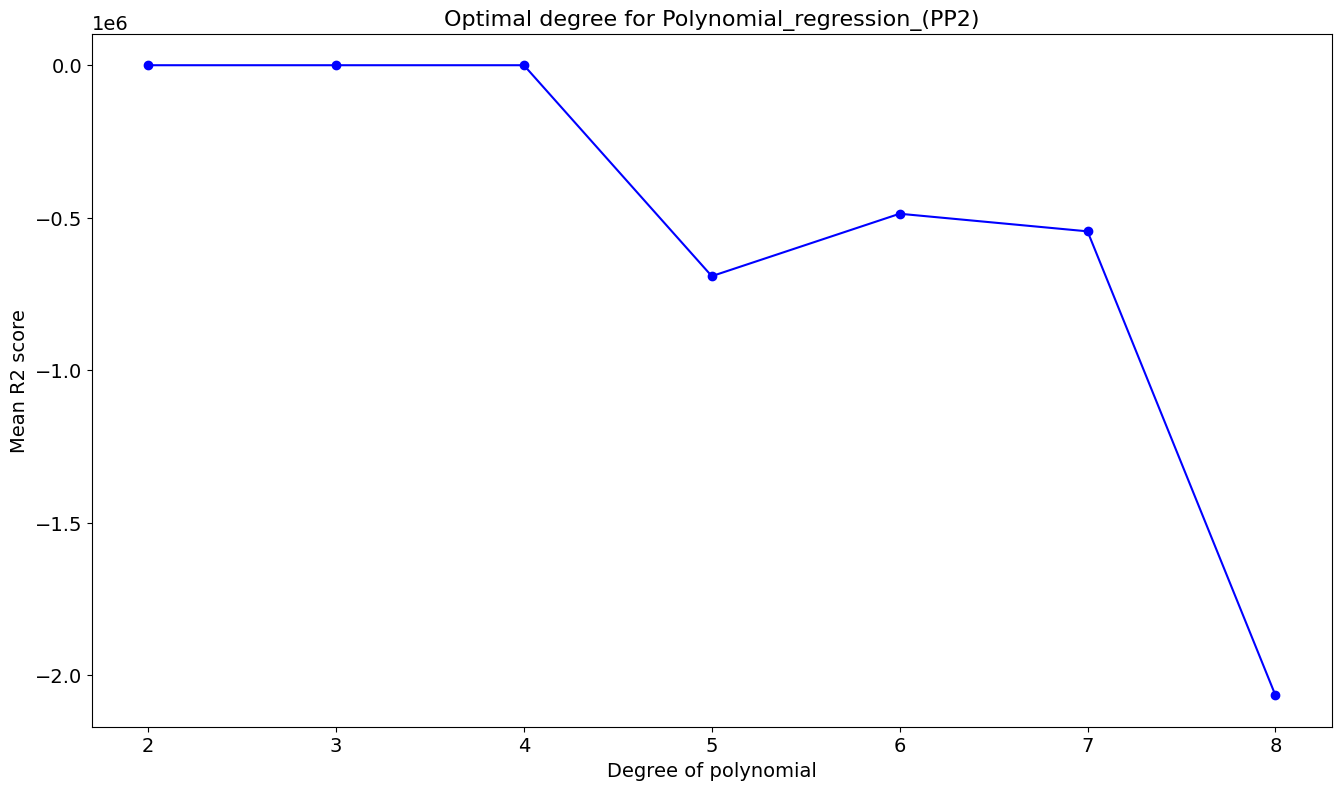

In [89]:

def perform_poly(X, y, X_test, name):
    degrees_to_test = np.arange(2, 9)
    scoring = []
    models = []

    # Loop over degrees and perform cross-validation
    for degree in degrees_to_test:
        print(f"\nTesting degree {degree} - {name}")

        # Create pipeline for polynomial regression
        poly_pipe = Pipeline([
            ('poly_feature', PolynomialFeatures(degree=degree)),
            ('model', LinearRegression())
        ])

        # Perform cross-validation
        scores = cross_val_score(poly_pipe, X, y, cv=5, scoring='r2')
        print(scores)
        scoring.append(np.mean(scores))
        models.append(poly_pipe)

        # Log cross-validation performance
        print(f"Degree {degree} mean R2: {np.mean(scores)}")

    # Find the degree with the best cross-validation score
    optimal_degree_index = np.argmax(scoring)
    optimal_degree = degrees_to_test[optimal_degree_index]
    best_model = models[optimal_degree_index]

    print(f"Best performing degree is: {optimal_degree}")

    # Train the best model on the full training dataset
    best_model.fit(X, y)

    # Generate predictions on X_test
    y_pred = best_model.predict(X_test)

    # Plot the cross-validation performance
    plt.plot(degrees_to_test, scoring, marker='o', linestyle='-', color='b')
    plt.xlabel('Degree of polynomial')
    plt.ylabel('Mean R2 score')
    plt.title(f'Optimal degree for {name}')
    save_testresult(name, y_pred, best_model, f'degree = {optimal_degree}')

perform_poly(X_train_pp2, y_train, X_test_pp2, 'Polynomial_regression_(PP2)')

## 3.6 Random Forest regressor
A model like this makes much more sense for the data we have - EDA showed there's not always a lineair relationschip; and sometimes a feature belonging to class X has another impact on the feature behaviuor of class Y. We'll use a grid search for this. 

In [ ]:

def perform_randomForest(X, y, X_test, name):
    rf_model = RandomForestRegressor()
    parameters = {
        'n_estimators': range(10, 200, 20),
        'max_depth' : np.arange(1,8), 
        'max_features': np.arange(10, 80, 15)
    }
    gs = RandomizedSearchCV(rf_model, parameters, error_score='raise', cv=5, scoring='r2', n_iter=150)
    gs.fit(X, y)
    scores = gs.cv_results_

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f'Best parameters: {gs.best_params_} with R2 of: {gs.best_score_}')
    save_testresult(name, y_pred, best_model, '')

perform_randomForest(X_train_pp2, y_train, X_test_pp2, 'Random_Forest_(PP2)')

## 3.7 CatBoost
This should handle strings in the dataset without the required pipeline - might be interesting to see how it performs on the dataset. From the article here it looks like it might handle the data much better than the random forest regressor due to not needing to use OHE- or ordinal encoding: https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329. It also has a built in feature importance tool - is an interesting addition to the EDA phase of the project.

docs: https://catboost.ai/docs/en/concepts/python-reference_catboostregressor

In [90]:
def catboost_cleaning(df, coldrops): 
    df = df.copy()
    df = df.drop(columns=coldrops)
    return df

In [ ]:
# Identify categorical features (column indices)
catboost_importance = {}
def perform_catboost(X, y, X_test, name, cat_features):
    print(f"\n{name}")
    cb_model = CatBoostRegressor(iterations=500,
                            learning_rate=0.1,
                            depth=6,
                            cat_features=cat_features,
                            verbose=100)
    # Train the model
    cb_model.fit(X, y)

    # Make predictions
    y_pred = cb_model.predict(X_test)

    #save the model:
    save_testresult(name, y_pred, cb_model, '')
    catboost_importance[name] = {}
    catboost_importance[name]['weights'] = cb_model.get_feature_importance()
    catboost_importance[name]['columns'] = X.columns

#The documenation is not really clear: I'll add experience_level as a categorical feature for now
# and run a second call with ordinals handled properly. I want to see if this makes a difference 
# for catboost regressor. 
categoricals_1 = ['experience_level', 'employment_type', 'employee_residence', 
                'work_setting', 'company_location', 'company_size', 'employee_of_country', 
                'field', 'title', 'location_income_category', 'residence_income_category']
cb1_drop = ['job_title', 'comp_location_WBI_code', 'employee_residence_WBI_code']
X_train_CB1 = catboost_cleaning(X_train, cb1_drop)
X_test_CB1 = catboost_cleaning(X_test, cb1_drop)
perform_catboost(X_train_CB1, y_train, X_test_CB1, 'CatBoostRegressor - No Ords', categoricals_1)

#do ordinal encoding on things that are clearly ordinal: company size and experience_level
categoricals_2 = ['employment_type', 'employee_residence', 'work_setting', 'company_location', 
                'field', 'title', 'location_income_category', 'residence_income_category']
extravalues_cb2 = ['gdp_cap_comploc', 'gdp_cap_resloc']
full_merge_cb2 = categoricals_2 + extravalues_cb2

#pipeline6 (specifically for catboost)

X_train_cb2 = pd.concat([X_train_pp6, X_train[full_merge_cb2].reset_index().drop(columns=['index'])], axis=1)
X_test_cb2 = pd.concat([X_test_pp6, X_test[full_merge_cb2].reset_index().drop(columns=['index'])], axis=1)

perform_catboost(X_train_cb2, y_train, X_test_cb2, 'CatBoostRegressor - Ords', categoricals_2)


In [ ]:
for k,v in catboost_importance.items(): 
    feature_importance = v['weights']
    columns = v['columns']
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(columns)[sorted_idx])
    plt.title(f'Feature Importance of catboost processing - {k}')

using catboost we can confirm a few things we saw in EDA: 
- title and field are important; even if we couldn't find linear relations (hard to do with categorical variables), they are still important for the model.
- experience level: boxplots indicated this was important, this seems to be confirmed by catboost. 
- residence location of employee is more important than the company location is. I had not expected this as the two scatterplots that put wage against company location and residence location were very similar.
- work_year is less important than thought - weird.
- As expcted: the initial idea of using income categories by the world bank was not very useful - the data got all pushed into a single category, making it a meaningless variable. 
    - this would also mean that categorizing the data in US vs NOT USA would be even more useless as it would further reduce the variety of countries into a binary category

## 3.8 KNN search
Let's try a last thing: Knearest neighbour. 

In [ ]:
def perform_knn(X, y, X_test, name, k=5):

    print(f"{name} - {k}")
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X, y)
    y_pred = knn.predict(X_test)
    save_testresult(f"{name} - ({k})", y_pred, knn, 'k = ' + str(k))

for i in range(1,17, 3):
    perform_knn(X_train_pp3, y_train, X_test_pp3, 'KNN', i)


# SECTION C: COMPARING MODELS

In b-section we created a dict where we added our y-predictions. Now we can use this dict `testpredictions` to compare our models with by comparing those predictions to the actuals stored in `y_test`: 


In [ ]:
#do all calculations at once, and store the results back in testpredictions. 
#while you do the loop plot actuals vs residuals: 
for k,v in testpredictions.items(): 
    modelname = k.replace('_', ' ')
    modelresults = v['result']
    modelnote = v['note']
    modeltitle = f"{modelname} - ({modelnote})"  #TODO: conditional braces
    v['title'] = modeltitle
    v['mse'] = mean_squared_error(y_test, modelresults)
    v['r2'] = r2_score(y_test, modelresults)
    v['mape'] = mean_absolute_percentage_error(y_test, modelresults)
    v['mae'] = mean_absolute_error(y_test, modelresults)
    v['rmse'] = np.sqrt(mean_squared_error(y_test, modelresults))
    plt.figure
    plt.scatter(x = y_test, y = modelresults)
    plt.title(f"Scatter Plot: {modeltitle}")
    plt.xlabel('Actual values (y_test)')
    plt.ylabel('Predicted values (modelresults)')

    # Display the plot
    plt.show()

Plotting all of our actuals versus predicts, we see that all models manage to land in a narrow error margin at the bottom, which wavers open towards the top. In hindsight it might have been worth it to cap the 'outliers' to a smaller capped value in stead of considering them to be correct values - but just very high wages for some reason. 

A handfull of models seem to be predicting negative wages.

In [ ]:
#plot all testpridiction per scoring-metric

metrics = {
    'mse': 0,
    'r2': 1,
    'mape': 0,
    'mae': 0,
    'rmse': 0,
}
for metric, higher_is_better in metrics.items():
    plt.figure()
    for model, values in testpredictions.items():
        metric_value = values.get(metric)
        plt.bar(model, metric_value, label=f"{model} - {metric_value:.4f}", color='steelblue')
    
    # Set the title and labels
    plt.title(f"Comparison of {metric.upper()} across models")
    plt.xlabel('Model')
    if higher_is_better == 1:
        extra = '(Higher is better)'
    else:
        extra = '(Lower is better)'
    plt.ylabel(f'{metric.upper()} Value {extra}')
   
    # Display the plot
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()


if we're interested we can use the plots above to compare the performance of the different models visually. For an easy overview however, use the following matrix: 

In [97]:
row_names = [v['title'] for v in testpredictions.values()]
metrics_to_plot = list(metrics.keys())


In [ ]:
#this whole cell was done with copilot.
data = np.array([[testpredictions[key][metric] for metric in metrics_to_plot] for key in testpredictions])

# Sort by the 'RMSE' column (ascending order)
rmse_column_index = metrics_to_plot.index('rmse')  # Replace 'RMSE' with the exact column name if necessary
sorted_indices = np.argsort(data[:, rmse_column_index])  # Ascending order
data = data[sorted_indices]
row_names = np.array(row_names)[sorted_indices]  # Rearrange row names as well

# Normalize data for coloring
def normalize_data(data, metric_type):
    if metric_type == 1:  # Higher is better
        return (data - np.min(data)) / (np.max(data) - np.min(data))
    else:  # Lower is better
        return (np.max(data) - data) / (np.max(data) - np.min(data))

normalized_data = np.array([
    normalize_data(data[:, i], metrics[metric]) for i, metric in enumerate(metrics_to_plot)
]).T

# Create a custom colormap
green_red_cmap = LinearSegmentedColormap.from_list("green_red", [(1, 0, 0), (1, 1, 1), (0, 1, 0)])

# Plot the table
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')

table_data = data.round(2).tolist()

table = ax.table(
    cellText=table_data,
    rowLabels=row_names,
    colLabels=metrics_to_plot,
    loc='center',
    cellLoc='center',
)

# Apply colors to cells
for i in range(len(row_names)):
    for j in range(len(metrics_to_plot)):
        color = green_red_cmap(normalized_data[i, j])
        table[(i + 1, j)].set_facecolor(color)

plt.title('Metrics overview per model by ascending RMSE')

# SECTION D: PICKING THE BEST MODEL
None of th models performed really well, all r2 scores stay quite low. The best model is the one with the highest r2 score. In this case, we have four models achieving an R2 score of 0.36: 
- **CatBoostRegressor - Ords - ()**: A model where ordinal values were encoded and CatBoost was used as the regressor.
- **CatBoostRegressor - No Ords - ()**: A model where ordinal values were treated as categorical values and CatBoost was used as the regressor.
- **Ridge Regression(L2reg) (PP3) - (alpha = 6.123387755102041)**: A model using Ridge Regression where alpha was optimized using ridgecv() and data was fed in using pipeline3
- **Ridge Regression(L2reg) (PP4) - (alpha = 6.123387755102041)**: A model using Ridge Regression where alpha was optimized using ridgecv() and data was fed in using pipeline4

For these four models we can look further at other metrics such as RMSE which should be interpred as *lower is better*. 

We can come to the conclusion that the model  **CatBoostRegressor - Ords - ()** performs the best - also across other metrics such as MAE.

Interesting observation: the preprocessing of the data matters we see another Ridge regression model using preprocessingpipeline 5 performing quite poorly - eventhough it found a same Alpha value.

In [109]:
#using "CatBoostRegressor - Ords - ()" to predict for the real testdata. 
# we run a prediction for the dataframe as it existed at the end of section A: X_test_processed

In [110]:
bestmodel = testpredictions["CatBoostRegressor - Ords"]['model']

In [ ]:
bestmodel

In [113]:
#apply tranformer that was used for the catboost model: 
X_test_processed_pp6 = h.to_dataframe(pipeline_6.transform(X_test_processed), preprocessor_6, X_test_processed.columns)
#rebuild all the columns as necessary: 
X_test_processed_for_cb = pd.concat([X_test_processed_pp6, X_test_processed[full_merge_cb2].reset_index().drop(columns=['index'])], axis=1)
#use the catboost model to make predictions with .predit() on rebuilt df.
final_prediction_results = bestmodel.predict(X_test_processed_for_cb)

In [ ]:
if len(final_prediction_results) == len(X_test_processed): 
    output_df = pd.DataFrame(final_prediction_results, columns=['salary_in_eur'])
    saveto = files['outputfile']
    output_dir = os.path.dirname(saveto)
    os.makedirs(output_dir, exist_ok=True)
    output_df.to_csv(saveto, index=False)
    print('File saved succesfully')
else:
    print('something went wrong, could not predict.')

In [ ]:
saveto